In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
import time
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import os
import gym_Aircraft
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
env = gym.make("acav-v0")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/jupyter-kunwoopark/.local/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """transition 저장"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, env.action_space.n)
        )
        
    def forward(self, x):
        return self.layers(x)

In [5]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

In [6]:
policy_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
target_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (layers): Sequential(
    (0): Linear(in_features=5, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=40, bias=True)
    (5): ReLU()
    (6): Linear(in_features=40, out_features=40, bias=True)
    (7): ReLU()
    (8): Linear(in_features=40, out_features=40, bias=True)
    (9): ReLU()
    (10): Linear(in_features=40, out_features=40, bias=True)
    (11): ReLU()
    (12): Linear(in_features=40, out_features=40, bias=True)
    (13): ReLU()
    (14): Linear(in_features=40, out_features=3, bias=True)
  )
)

In [7]:
n_actions = env.action_space.n

In [8]:
optimizer = optim.Adam(policy_net.parameters())
memory = ReplayMemory(1000)

In [9]:
steps_done = 0

In [10]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max (1)은 각 행의 가장 큰 열 값을 반환합니다.
            # 최대 결과의 두번째 열은 최대 요소의 주소값이므로,
            # 기대 보상이 더 큰 행동을 선택할 수 있습니다.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [11]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)

    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # 기대 Q 값 계산
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Huber 손실 계산
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # 모델 최적화
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [12]:
num_episodes = 50000
total_res=[]
reward_list=[]
for i_episode in range(num_episodes):
    total_reward=0
    
    # 환경과 상태 초기화
    res_list=np.zeros(11)
    state = env.reset()
    state=torch.from_numpy(state.astype(np.float32)).unsqueeze(0).to(device)
    for t in count():
        # 행동 선택과 수행
        
        action = select_action(state)
        next_state, reward, done, res = env.step(action.item())
        reward = torch.tensor([reward], dtype=torch.float32).to(device)
        
        next_state=torch.from_numpy(next_state.astype(np.float32)).unsqueeze(0).to(device)

        # 새로운 상태 관찰
        if not done:
            next_state = next_state
        else:
            next_state = None

        # 메모리에 변이 저장
        memory.push(state, action, next_state, reward)

        # 다음 상태로 이동
        state = next_state

        # 최적화 한단계 수행(목표 네트워크에서)
        optimize_model()
        
        # Data save
        
        cmd_list,r_list,elev_list,azim_list,Pm_list,Pt_list,h_list=res
        Pm_list=Pm_list.tolist()
        Pt_list=Pt_list.tolist()
        merged_data=itertools.chain([cmd_list],[r_list],[elev_list],[azim_list],Pm_list,Pt_list,[h_list])
        merged_data=np.array(list(merged_data))
        res_list=np.vstack([res_list,merged_data])
        
        total_reward+=reward
        
        if done:
            res_list=np.delete(res_list,0,0)
            
            total_res.append(res_list)
            reward_list.append(total_reward)
            
            now = time.localtime()
            print ("%04d/%02d/%02d %02d:%02d:%02d" % (now.tm_year, now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min, now.tm_sec))
            print("episode : {} | final step : {} | total reward : {}".format(i_episode, t, total_reward.item()))
            break
            
        
    #목표 네트워크 업데이트, 모든 웨이트와 바이어스 복사
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.close()

2020/11/25 03:25:02
episode : 0 | final step : 98 | total reward : -77.2750015258789
2020/11/25 03:25:02
episode : 1 | final step : 101 | total reward : -10.524999618530273
2020/11/25 03:25:03
episode : 2 | final step : 100 | total reward : -3.25
2020/11/25 03:25:03
episode : 3 | final step : 100 | total reward : -102.0999984741211
2020/11/25 03:25:04
episode : 4 | final step : 99 | total reward : -92.0250015258789
2020/11/25 03:25:04
episode : 5 | final step : 98 | total reward : -112.1500015258789
2020/11/25 03:25:05
episode : 6 | final step : 98 | total reward : -97.05000305175781
2020/11/25 03:25:05
episode : 7 | final step : 97 | total reward : 7.574999809265137
2020/11/25 03:25:06
episode : 8 | final step : 98 | total reward : -101.3499984741211
2020/11/25 03:25:06
episode : 9 | final step : 98 | total reward : -73.375
2020/11/25 03:25:07
episode : 10 | final step : 99 | total reward : -104.4000015258789
2020/11/25 03:25:07
episode : 11 | final step : 98 | total reward : 26.14999

2020/11/25 03:25:50
episode : 98 | final step : 99 | total reward : -2.75
2020/11/25 03:25:51
episode : 99 | final step : 101 | total reward : -5.875
2020/11/25 03:25:51
episode : 100 | final step : 98 | total reward : -83.875
2020/11/25 03:25:52
episode : 101 | final step : 98 | total reward : -69.67500305175781
2020/11/25 03:25:52
episode : 102 | final step : 98 | total reward : -86.30000305175781
2020/11/25 03:25:53
episode : 103 | final step : 99 | total reward : -93.1500015258789
2020/11/25 03:25:53
episode : 104 | final step : 98 | total reward : -63.525001525878906
2020/11/25 03:25:54
episode : 105 | final step : 98 | total reward : -80.82499694824219
2020/11/25 03:25:54
episode : 106 | final step : 100 | total reward : -3.325000047683716
2020/11/25 03:25:55
episode : 107 | final step : 98 | total reward : -80.82499694824219
2020/11/25 03:25:56
episode : 108 | final step : 101 | total reward : -0.800000011920929
2020/11/25 03:25:56
episode : 109 | final step : 98 | total reward 

2020/11/25 03:26:40
episode : 195 | final step : 99 | total reward : -73.19999694824219
2020/11/25 03:26:40
episode : 196 | final step : 100 | total reward : 10.300000190734863
2020/11/25 03:26:41
episode : 197 | final step : 98 | total reward : -66.3499984741211
2020/11/25 03:26:42
episode : 198 | final step : 98 | total reward : -98.0250015258789
2020/11/25 03:26:42
episode : 199 | final step : 97 | total reward : 31.600000381469727
2020/11/25 03:26:43
episode : 200 | final step : 100 | total reward : 15.649999618530273
2020/11/25 03:26:43
episode : 201 | final step : 99 | total reward : 1.6749999523162842
2020/11/25 03:26:44
episode : 202 | final step : 100 | total reward : 12.324999809265137
2020/11/25 03:26:44
episode : 203 | final step : 99 | total reward : 11.725000381469727
2020/11/25 03:26:44
episode : 204 | final step : 99 | total reward : -64.25
2020/11/25 03:26:45
episode : 205 | final step : 96 | total reward : 22.549999237060547
2020/11/25 03:26:45
episode : 206 | final s

2020/11/25 03:27:27
episode : 291 | final step : 98 | total reward : -63.79999923706055
2020/11/25 03:27:27
episode : 292 | final step : 98 | total reward : -93.9000015258789
2020/11/25 03:27:28
episode : 293 | final step : 96 | total reward : 39.724998474121094
2020/11/25 03:27:28
episode : 294 | final step : 99 | total reward : -94.2249984741211
2020/11/25 03:27:29
episode : 295 | final step : 98 | total reward : -84.57499694824219
2020/11/25 03:27:29
episode : 296 | final step : 98 | total reward : -88.69999694824219
2020/11/25 03:27:30
episode : 297 | final step : 98 | total reward : -107.0999984741211
2020/11/25 03:27:31
episode : 298 | final step : 97 | total reward : -86.125
2020/11/25 03:27:31
episode : 299 | final step : 98 | total reward : -85.5
2020/11/25 03:27:32
episode : 300 | final step : 98 | total reward : -72.0250015258789
2020/11/25 03:27:32
episode : 301 | final step : 99 | total reward : -75.75
2020/11/25 03:27:33
episode : 302 | final step : 98 | total reward : 25

2020/11/25 03:28:16
episode : 389 | final step : 98 | total reward : -79.375
2020/11/25 03:28:16
episode : 390 | final step : 98 | total reward : -104.82499694824219
2020/11/25 03:28:17
episode : 391 | final step : 98 | total reward : -81.875
2020/11/25 03:28:17
episode : 392 | final step : 99 | total reward : 24.875
2020/11/25 03:28:18
episode : 393 | final step : 92 | total reward : 22.875
2020/11/25 03:28:18
episode : 394 | final step : 99 | total reward : -100.80000305175781
2020/11/25 03:28:18
episode : 395 | final step : 98 | total reward : -104.1500015258789
2020/11/25 03:28:19
episode : 396 | final step : 98 | total reward : -76.0
2020/11/25 03:28:19
episode : 397 | final step : 98 | total reward : -38.125
2020/11/25 03:28:20
episode : 398 | final step : 99 | total reward : -80.5
2020/11/25 03:28:20
episode : 399 | final step : 99 | total reward : -99.42500305175781
2020/11/25 03:28:21
episode : 400 | final step : 98 | total reward : 59.70000076293945
2020/11/25 03:28:21
episod

2020/11/25 03:29:03
episode : 486 | final step : 98 | total reward : -78.80000305175781
2020/11/25 03:29:03
episode : 487 | final step : 99 | total reward : -66.5
2020/11/25 03:29:04
episode : 488 | final step : 97 | total reward : 37.099998474121094
2020/11/25 03:29:04
episode : 489 | final step : 98 | total reward : -73.42500305175781
2020/11/25 03:29:05
episode : 490 | final step : 98 | total reward : -50.04999923706055
2020/11/25 03:29:06
episode : 491 | final step : 100 | total reward : 25.149999618530273
2020/11/25 03:29:06
episode : 492 | final step : 98 | total reward : -71.07499694824219
2020/11/25 03:29:07
episode : 493 | final step : 99 | total reward : -66.5999984741211
2020/11/25 03:29:07
episode : 494 | final step : 100 | total reward : 28.924999237060547
2020/11/25 03:29:07
episode : 495 | final step : 98 | total reward : 37.724998474121094
2020/11/25 03:29:08
episode : 496 | final step : 98 | total reward : -82.4749984741211
2020/11/25 03:29:08
episode : 497 | final ste

2020/11/25 03:29:50
episode : 583 | final step : 99 | total reward : -68.69999694824219
2020/11/25 03:29:50
episode : 584 | final step : 98 | total reward : -74.07499694824219
2020/11/25 03:29:51
episode : 585 | final step : 98 | total reward : -87.1500015258789
2020/11/25 03:29:51
episode : 586 | final step : 98 | total reward : -84.19999694824219
2020/11/25 03:29:52
episode : 587 | final step : 99 | total reward : 19.5
2020/11/25 03:29:52
episode : 588 | final step : 99 | total reward : -72.92500305175781
2020/11/25 03:29:53
episode : 589 | final step : 98 | total reward : -79.75
2020/11/25 03:29:54
episode : 590 | final step : 96 | total reward : 21.325000762939453
2020/11/25 03:29:54
episode : 591 | final step : 100 | total reward : -73.69999694824219
2020/11/25 03:29:55
episode : 592 | final step : 98 | total reward : -73.875
2020/11/25 03:29:55
episode : 593 | final step : 99 | total reward : -65.8499984741211
2020/11/25 03:29:56
episode : 594 | final step : 95 | total reward : 5

2020/11/25 03:30:38
episode : 680 | final step : 98 | total reward : -63.04999923706055
2020/11/25 03:30:38
episode : 681 | final step : 98 | total reward : -60.875
2020/11/25 03:30:39
episode : 682 | final step : 99 | total reward : -78.5
2020/11/25 03:30:39
episode : 683 | final step : 98 | total reward : -92.9000015258789
2020/11/25 03:30:40
episode : 684 | final step : 100 | total reward : -90.25
2020/11/25 03:30:40
episode : 685 | final step : 99 | total reward : -87.2249984741211
2020/11/25 03:30:41
episode : 686 | final step : 98 | total reward : -62.724998474121094
2020/11/25 03:30:41
episode : 687 | final step : 98 | total reward : -74.9749984741211
2020/11/25 03:30:42
episode : 688 | final step : 100 | total reward : 42.025001525878906
2020/11/25 03:30:43
episode : 689 | final step : 98 | total reward : -66.92500305175781
2020/11/25 03:30:43
episode : 690 | final step : 97 | total reward : 38.45000076293945
2020/11/25 03:30:44
episode : 691 | final step : 99 | total reward : 

2020/11/25 03:31:25
episode : 776 | final step : 99 | total reward : -68.0250015258789
2020/11/25 03:31:26
episode : 777 | final step : 99 | total reward : 11.024999618530273
2020/11/25 03:31:26
episode : 778 | final step : 99 | total reward : -77.9749984741211
2020/11/25 03:31:26
episode : 779 | final step : 99 | total reward : 1.1749999523162842
2020/11/25 03:31:27
episode : 780 | final step : 97 | total reward : 25.024999618530273
2020/11/25 03:31:28
episode : 781 | final step : 97 | total reward : 34.625
2020/11/25 03:31:28
episode : 782 | final step : 99 | total reward : 17.200000762939453
2020/11/25 03:31:29
episode : 783 | final step : 99 | total reward : 28.899999618530273
2020/11/25 03:31:29
episode : 784 | final step : 99 | total reward : 23.25
2020/11/25 03:31:30
episode : 785 | final step : 99 | total reward : 52.974998474121094
2020/11/25 03:31:30
episode : 786 | final step : 99 | total reward : -87.67500305175781
2020/11/25 03:31:31
episode : 787 | final step : 99 | total

2020/11/25 03:32:12
episode : 872 | final step : 98 | total reward : -72.94999694824219
2020/11/25 03:32:12
episode : 873 | final step : 98 | total reward : -93.69999694824219
2020/11/25 03:32:13
episode : 874 | final step : 98 | total reward : -84.19999694824219
2020/11/25 03:32:13
episode : 875 | final step : 98 | total reward : -82.69999694824219
2020/11/25 03:32:14
episode : 876 | final step : 98 | total reward : -58.849998474121094
2020/11/25 03:32:14
episode : 877 | final step : 99 | total reward : 48.82500076293945
2020/11/25 03:32:15
episode : 878 | final step : 97 | total reward : 25.049999237060547
2020/11/25 03:32:15
episode : 879 | final step : 98 | total reward : -68.1500015258789
2020/11/25 03:32:16
episode : 880 | final step : 98 | total reward : -86.05000305175781
2020/11/25 03:32:16
episode : 881 | final step : 98 | total reward : -96.875
2020/11/25 03:32:17
episode : 882 | final step : 98 | total reward : 10.399999618530273
2020/11/25 03:32:17
episode : 883 | final st

2020/11/25 03:32:58
episode : 969 | final step : 95 | total reward : 42.775001525878906
2020/11/25 03:32:59
episode : 970 | final step : 99 | total reward : -74.80000305175781
2020/11/25 03:32:59
episode : 971 | final step : 96 | total reward : 33.474998474121094
2020/11/25 03:32:59
episode : 972 | final step : 98 | total reward : -80.30000305175781
2020/11/25 03:33:00
episode : 973 | final step : 99 | total reward : -61.650001525878906
2020/11/25 03:33:01
episode : 974 | final step : 102 | total reward : 53.875
2020/11/25 03:33:01
episode : 975 | final step : 98 | total reward : -62.724998474121094
2020/11/25 03:33:02
episode : 976 | final step : 98 | total reward : -75.7750015258789
2020/11/25 03:33:02
episode : 977 | final step : 99 | total reward : -91.92500305175781
2020/11/25 03:33:03
episode : 978 | final step : 98 | total reward : -88.9749984741211
2020/11/25 03:33:03
episode : 979 | final step : 98 | total reward : -64.375
2020/11/25 03:33:04
episode : 980 | final step : 100 |

2020/11/25 03:33:47
episode : 1065 | final step : 98 | total reward : -57.42499923706055
2020/11/25 03:33:47
episode : 1066 | final step : 100 | total reward : 36.32500076293945
2020/11/25 03:33:48
episode : 1067 | final step : 97 | total reward : 30.774999618530273
2020/11/25 03:33:48
episode : 1068 | final step : 99 | total reward : -68.32499694824219
2020/11/25 03:33:49
episode : 1069 | final step : 99 | total reward : 46.099998474121094
2020/11/25 03:33:49
episode : 1070 | final step : 97 | total reward : 36.150001525878906
2020/11/25 03:33:50
episode : 1071 | final step : 97 | total reward : 39.04999923706055
2020/11/25 03:33:50
episode : 1072 | final step : 99 | total reward : -84.0999984741211
2020/11/25 03:33:51
episode : 1073 | final step : 100 | total reward : -86.57499694824219
2020/11/25 03:33:51
episode : 1074 | final step : 98 | total reward : -88.67500305175781
2020/11/25 03:33:52
episode : 1075 | final step : 99 | total reward : -93.32499694824219
2020/11/25 03:33:52
ep

2020/11/25 03:34:31
episode : 1160 | final step : 99 | total reward : 13.949999809265137
2020/11/25 03:34:31
episode : 1161 | final step : 95 | total reward : 5.224999904632568
2020/11/25 03:34:31
episode : 1162 | final step : 98 | total reward : -1.7000000476837158
2020/11/25 03:34:32
episode : 1163 | final step : 98 | total reward : -93.5250015258789
2020/11/25 03:34:32
episode : 1164 | final step : 99 | total reward : -8.850000381469727
2020/11/25 03:34:33
episode : 1165 | final step : 98 | total reward : -98.80000305175781
2020/11/25 03:34:33
episode : 1166 | final step : 98 | total reward : -86.9000015258789
2020/11/25 03:34:34
episode : 1167 | final step : 99 | total reward : 11.649999618530273
2020/11/25 03:34:34
episode : 1168 | final step : 98 | total reward : -83.125
2020/11/25 03:34:35
episode : 1169 | final step : 98 | total reward : -4.324999809265137
2020/11/25 03:34:35
episode : 1170 | final step : 100 | total reward : -66.5999984741211
2020/11/25 03:34:36
episode : 1171

2020/11/25 03:35:19
episode : 1255 | final step : 98 | total reward : -90.8499984741211
2020/11/25 03:35:19
episode : 1256 | final step : 100 | total reward : 4.75
2020/11/25 03:35:20
episode : 1257 | final step : 98 | total reward : -86.8499984741211
2020/11/25 03:35:20
episode : 1258 | final step : 98 | total reward : 0.875
2020/11/25 03:35:21
episode : 1259 | final step : 98 | total reward : -106.57499694824219
2020/11/25 03:35:21
episode : 1260 | final step : 95 | total reward : 15.225000381469727
2020/11/25 03:35:22
episode : 1261 | final step : 99 | total reward : -100.5
2020/11/25 03:35:22
episode : 1262 | final step : 98 | total reward : -75.875
2020/11/25 03:35:23
episode : 1263 | final step : 98 | total reward : -96.0999984741211
2020/11/25 03:35:24
episode : 1264 | final step : 98 | total reward : -69.69999694824219
2020/11/25 03:35:24
episode : 1265 | final step : 100 | total reward : 8.899999618530273
2020/11/25 03:35:25
episode : 1266 | final step : 97 | total reward : 13

2020/11/25 03:36:04
episode : 1351 | final step : 99 | total reward : -73.44999694824219
2020/11/25 03:36:05
episode : 1352 | final step : 100 | total reward : 7.900000095367432
2020/11/25 03:36:05
episode : 1353 | final step : 98 | total reward : -92.9749984741211
2020/11/25 03:36:06
episode : 1354 | final step : 99 | total reward : -95.67500305175781
2020/11/25 03:36:06
episode : 1355 | final step : 99 | total reward : -5.974999904632568
2020/11/25 03:36:07
episode : 1356 | final step : 98 | total reward : 0.3499999940395355
2020/11/25 03:36:07
episode : 1357 | final step : 95 | total reward : 19.350000381469727
2020/11/25 03:36:08
episode : 1358 | final step : 99 | total reward : -95.3499984741211
2020/11/25 03:36:08
episode : 1359 | final step : 100 | total reward : 26.0
2020/11/25 03:36:09
episode : 1360 | final step : 98 | total reward : 37.224998474121094
2020/11/25 03:36:09
episode : 1361 | final step : 99 | total reward : 24.475000381469727
2020/11/25 03:36:10
episode : 1362 |

2020/11/25 03:36:50
episode : 1446 | final step : 99 | total reward : -88.25
2020/11/25 03:36:51
episode : 1447 | final step : 98 | total reward : -72.8499984741211
2020/11/25 03:36:51
episode : 1448 | final step : 100 | total reward : 41.275001525878906
2020/11/25 03:36:52
episode : 1449 | final step : 97 | total reward : 49.07500076293945
2020/11/25 03:36:52
episode : 1450 | final step : 99 | total reward : -80.92500305175781
2020/11/25 03:36:52
episode : 1451 | final step : 100 | total reward : -70.2750015258789
2020/11/25 03:36:53
episode : 1452 | final step : 98 | total reward : -74.07499694824219
2020/11/25 03:36:53
episode : 1453 | final step : 99 | total reward : 31.5
2020/11/25 03:36:54
episode : 1454 | final step : 98 | total reward : -63.625
2020/11/25 03:36:54
episode : 1455 | final step : 99 | total reward : 45.875
2020/11/25 03:36:55
episode : 1456 | final step : 102 | total reward : 14.975000381469727
2020/11/25 03:36:55
episode : 1457 | final step : 98 | total reward : 

2020/11/25 03:37:39
episode : 1542 | final step : 99 | total reward : 26.475000381469727
2020/11/25 03:37:39
episode : 1543 | final step : 98 | total reward : 7.949999809265137
2020/11/25 03:37:39
episode : 1544 | final step : 98 | total reward : -70.44999694824219
2020/11/25 03:37:40
episode : 1545 | final step : 99 | total reward : 5.974999904632568
2020/11/25 03:37:40
episode : 1546 | final step : 98 | total reward : -84.9749984741211
2020/11/25 03:37:41
episode : 1547 | final step : 102 | total reward : 25.524999618530273
2020/11/25 03:37:41
episode : 1548 | final step : 98 | total reward : 32.79999923706055
2020/11/25 03:37:42
episode : 1549 | final step : 98 | total reward : -67.32499694824219
2020/11/25 03:37:42
episode : 1550 | final step : 100 | total reward : 13.100000381469727
2020/11/25 03:37:42
episode : 1551 | final step : 98 | total reward : -84.19999694824219
2020/11/25 03:37:43
episode : 1552 | final step : 100 | total reward : -79.32499694824219
2020/11/25 03:37:43
ep

2020/11/25 03:38:26
episode : 1637 | final step : 98 | total reward : -81.75
2020/11/25 03:38:26
episode : 1638 | final step : 99 | total reward : -96.32499694824219
2020/11/25 03:38:27
episode : 1639 | final step : 99 | total reward : -79.30000305175781
2020/11/25 03:38:27
episode : 1640 | final step : 98 | total reward : 13.399999618530273
2020/11/25 03:38:28
episode : 1641 | final step : 98 | total reward : -109.1500015258789
2020/11/25 03:38:28
episode : 1642 | final step : 97 | total reward : 8.574999809265137
2020/11/25 03:38:29
episode : 1643 | final step : 99 | total reward : -91.1500015258789
2020/11/25 03:38:29
episode : 1644 | final step : 98 | total reward : -76.375
2020/11/25 03:38:30
episode : 1645 | final step : 100 | total reward : -68.44999694824219
2020/11/25 03:38:30
episode : 1646 | final step : 100 | total reward : 30.575000762939453
2020/11/25 03:38:31
episode : 1647 | final step : 98 | total reward : 10.175000190734863
2020/11/25 03:38:31
episode : 1648 | final s

2020/11/25 03:39:15
episode : 1733 | final step : 98 | total reward : -91.25
2020/11/25 03:39:16
episode : 1734 | final step : 98 | total reward : -79.32499694824219
2020/11/25 03:39:16
episode : 1735 | final step : 99 | total reward : -88.8499984741211
2020/11/25 03:39:17
episode : 1736 | final step : 98 | total reward : -60.42499923706055
2020/11/25 03:39:18
episode : 1737 | final step : 98 | total reward : -72.9000015258789
2020/11/25 03:39:18
episode : 1738 | final step : 95 | total reward : 8.225000381469727
2020/11/25 03:39:19
episode : 1739 | final step : 99 | total reward : -58.25
2020/11/25 03:39:19
episode : 1740 | final step : 99 | total reward : 13.875
2020/11/25 03:39:20
episode : 1741 | final step : 100 | total reward : -3.0250000953674316
2020/11/25 03:39:20
episode : 1742 | final step : 99 | total reward : 31.0
2020/11/25 03:39:21
episode : 1743 | final step : 96 | total reward : 15.975000381469727
2020/11/25 03:39:21
episode : 1744 | final step : 98 | total reward : -9

2020/11/25 03:40:00
episode : 1829 | final step : 100 | total reward : -97.57499694824219
2020/11/25 03:40:00
episode : 1830 | final step : 99 | total reward : -71.92500305175781
2020/11/25 03:40:01
episode : 1831 | final step : 99 | total reward : -65.1500015258789
2020/11/25 03:40:01
episode : 1832 | final step : 99 | total reward : -75.0999984741211
2020/11/25 03:40:01
episode : 1833 | final step : 97 | total reward : 26.299999237060547
2020/11/25 03:40:02
episode : 1834 | final step : 95 | total reward : 29.950000762939453
2020/11/25 03:40:02
episode : 1835 | final step : 99 | total reward : -95.5250015258789
2020/11/25 03:40:03
episode : 1836 | final step : 98 | total reward : -69.67500305175781
2020/11/25 03:40:03
episode : 1837 | final step : 99 | total reward : 23.649999618530273
2020/11/25 03:40:04
episode : 1838 | final step : 98 | total reward : -109.875
2020/11/25 03:40:04
episode : 1839 | final step : 98 | total reward : -100.82499694824219
2020/11/25 03:40:05
episode : 18

2020/11/25 03:40:46
episode : 1924 | final step : 97 | total reward : 43.67499923706055
2020/11/25 03:40:46
episode : 1925 | final step : 98 | total reward : -91.69999694824219
2020/11/25 03:40:47
episode : 1926 | final step : 100 | total reward : -5.025000095367432
2020/11/25 03:40:47
episode : 1927 | final step : 99 | total reward : -106.07499694824219
2020/11/25 03:40:47
episode : 1928 | final step : 99 | total reward : 8.100000381469727
2020/11/25 03:40:48
episode : 1929 | final step : 98 | total reward : -85.1500015258789
2020/11/25 03:40:48
episode : 1930 | final step : 98 | total reward : -60.75
2020/11/25 03:40:49
episode : 1931 | final step : 98 | total reward : -82.25
2020/11/25 03:40:49
episode : 1932 | final step : 98 | total reward : -96.1500015258789
2020/11/25 03:40:50
episode : 1933 | final step : 98 | total reward : 40.775001525878906
2020/11/25 03:40:50
episode : 1934 | final step : 98 | total reward : 24.049999237060547
2020/11/25 03:40:51
episode : 1935 | final step

2020/11/25 03:41:29
episode : 2019 | final step : 98 | total reward : -69.4749984741211
2020/11/25 03:41:30
episode : 2020 | final step : 98 | total reward : -95.7750015258789
2020/11/25 03:41:30
episode : 2021 | final step : 98 | total reward : -78.2750015258789
2020/11/25 03:41:30
episode : 2022 | final step : 98 | total reward : -68.125
2020/11/25 03:41:31
episode : 2023 | final step : 98 | total reward : -76.375
2020/11/25 03:41:31
episode : 2024 | final step : 98 | total reward : -78.5
2020/11/25 03:41:32
episode : 2025 | final step : 100 | total reward : 28.475000381469727
2020/11/25 03:41:33
episode : 2026 | final step : 98 | total reward : -99.5999984741211
2020/11/25 03:41:33
episode : 2027 | final step : 99 | total reward : -62.25
2020/11/25 03:41:34
episode : 2028 | final step : 98 | total reward : -7.474999904632568
2020/11/25 03:41:34
episode : 2029 | final step : 98 | total reward : -103.05000305175781
2020/11/25 03:41:35
episode : 2030 | final step : 99 | total reward : 

2020/11/25 03:42:18
episode : 2114 | final step : 99 | total reward : -30.475000381469727
2020/11/25 03:42:18
episode : 2115 | final step : 99 | total reward : -70.69999694824219
2020/11/25 03:42:19
episode : 2116 | final step : 100 | total reward : 44.625
2020/11/25 03:42:19
episode : 2117 | final step : 98 | total reward : -43.625
2020/11/25 03:42:19
episode : 2118 | final step : 98 | total reward : -54.67499923706055
2020/11/25 03:42:20
episode : 2119 | final step : 99 | total reward : 16.225000381469727
2020/11/25 03:42:20
episode : 2120 | final step : 97 | total reward : 16.825000762939453
2020/11/25 03:42:21
episode : 2121 | final step : 98 | total reward : -69.5
2020/11/25 03:42:21
episode : 2122 | final step : 99 | total reward : -73.07499694824219
2020/11/25 03:42:22
episode : 2123 | final step : 98 | total reward : -66.625
2020/11/25 03:42:22
episode : 2124 | final step : 98 | total reward : -31.75
2020/11/25 03:42:23
episode : 2125 | final step : 99 | total reward : -68.2750

2020/11/25 03:43:04
episode : 2210 | final step : 99 | total reward : -59.849998474121094
2020/11/25 03:43:05
episode : 2211 | final step : 102 | total reward : 24.024999618530273
2020/11/25 03:43:05
episode : 2212 | final step : 98 | total reward : -58.900001525878906
2020/11/25 03:43:06
episode : 2213 | final step : 98 | total reward : -74.80000305175781
2020/11/25 03:43:06
episode : 2214 | final step : 100 | total reward : -71.69999694824219
2020/11/25 03:43:07
episode : 2215 | final step : 98 | total reward : 19.100000381469727
2020/11/25 03:43:07
episode : 2216 | final step : 99 | total reward : 21.225000381469727
2020/11/25 03:43:08
episode : 2217 | final step : 99 | total reward : -70.25
2020/11/25 03:43:08
episode : 2218 | final step : 99 | total reward : 24.350000381469727
2020/11/25 03:43:09
episode : 2219 | final step : 98 | total reward : -68.05000305175781
2020/11/25 03:43:09
episode : 2220 | final step : 98 | total reward : -72.17500305175781
2020/11/25 03:43:10
episode :

2020/11/25 03:43:52
episode : 2305 | final step : 96 | total reward : 4.875
2020/11/25 03:43:52
episode : 2306 | final step : 98 | total reward : -76.57499694824219
2020/11/25 03:43:53
episode : 2307 | final step : 98 | total reward : -101.125
2020/11/25 03:43:53
episode : 2308 | final step : 100 | total reward : 11.574999809265137
2020/11/25 03:43:54
episode : 2309 | final step : 98 | total reward : -85.9000015258789
2020/11/25 03:43:54
episode : 2310 | final step : 100 | total reward : 7.025000095367432
2020/11/25 03:43:54
episode : 2311 | final step : 100 | total reward : -4.675000190734863
2020/11/25 03:43:55
episode : 2312 | final step : 100 | total reward : -65.80000305175781
2020/11/25 03:43:55
episode : 2313 | final step : 98 | total reward : -73.17500305175781
2020/11/25 03:43:56
episode : 2314 | final step : 98 | total reward : -51.974998474121094
2020/11/25 03:43:56
episode : 2315 | final step : 98 | total reward : 33.224998474121094
2020/11/25 03:43:57
episode : 2316 | fina

2020/11/25 03:44:39
episode : 2400 | final step : 98 | total reward : -60.5
2020/11/25 03:44:39
episode : 2401 | final step : 98 | total reward : -73.57499694824219
2020/11/25 03:44:40
episode : 2402 | final step : 98 | total reward : -39.79999923706055
2020/11/25 03:44:40
episode : 2403 | final step : 99 | total reward : -67.5250015258789
2020/11/25 03:44:40
episode : 2404 | final step : 99 | total reward : -55.025001525878906
2020/11/25 03:44:41
episode : 2405 | final step : 99 | total reward : -35.375
2020/11/25 03:44:41
episode : 2406 | final step : 98 | total reward : -83.32499694824219
2020/11/25 03:44:42
episode : 2407 | final step : 98 | total reward : -81.0
2020/11/25 03:44:42
episode : 2408 | final step : 100 | total reward : 21.75
2020/11/25 03:44:43
episode : 2409 | final step : 99 | total reward : 63.900001525878906
2020/11/25 03:44:43
episode : 2410 | final step : 100 | total reward : -4.849999904632568
2020/11/25 03:44:43
episode : 2411 | final step : 100 | total reward 

2020/11/25 03:45:26
episode : 2496 | final step : 98 | total reward : -86.9000015258789
2020/11/25 03:45:27
episode : 2497 | final step : 98 | total reward : 48.275001525878906
2020/11/25 03:45:27
episode : 2498 | final step : 96 | total reward : 42.849998474121094
2020/11/25 03:45:28
episode : 2499 | final step : 101 | total reward : -71.2249984741211
2020/11/25 03:45:28
episode : 2500 | final step : 98 | total reward : -69.375
2020/11/25 03:45:29
episode : 2501 | final step : 99 | total reward : 11.625
2020/11/25 03:45:29
episode : 2502 | final step : 99 | total reward : 12.850000381469727
2020/11/25 03:45:30
episode : 2503 | final step : 100 | total reward : 1.350000023841858
2020/11/25 03:45:30
episode : 2504 | final step : 98 | total reward : -48.775001525878906
2020/11/25 03:45:31
episode : 2505 | final step : 100 | total reward : -82.625
2020/11/25 03:45:31
episode : 2506 | final step : 98 | total reward : -73.7750015258789
2020/11/25 03:45:31
episode : 2507 | final step : 97 | 

2020/11/25 03:46:11
episode : 2590 | final step : 99 | total reward : -105.9749984741211
2020/11/25 03:46:11
episode : 2591 | final step : 99 | total reward : -47.400001525878906
2020/11/25 03:46:12
episode : 2592 | final step : 97 | total reward : -82.1500015258789
2020/11/25 03:46:12
episode : 2593 | final step : 99 | total reward : -48.474998474121094
2020/11/25 03:46:13
episode : 2594 | final step : 98 | total reward : -88.07499694824219
2020/11/25 03:46:13
episode : 2595 | final step : 98 | total reward : -85.67500305175781
2020/11/25 03:46:14
episode : 2596 | final step : 99 | total reward : -69.4000015258789
2020/11/25 03:46:14
episode : 2597 | final step : 98 | total reward : -67.5
2020/11/25 03:46:15
episode : 2598 | final step : 97 | total reward : 57.849998474121094
2020/11/25 03:46:15
episode : 2599 | final step : 98 | total reward : -60.125
2020/11/25 03:46:16
episode : 2600 | final step : 101 | total reward : 59.25
2020/11/25 03:46:17
episode : 2601 | final step : 100 | t

2020/11/25 03:47:00
episode : 2686 | final step : 96 | total reward : 11.375
2020/11/25 03:47:00
episode : 2687 | final step : 98 | total reward : -66.1500015258789
2020/11/25 03:47:01
episode : 2688 | final step : 98 | total reward : -74.92500305175781
2020/11/25 03:47:01
episode : 2689 | final step : 98 | total reward : -78.57499694824219
2020/11/25 03:47:02
episode : 2690 | final step : 98 | total reward : -59.95000076293945
2020/11/25 03:47:02
episode : 2691 | final step : 99 | total reward : 40.79999923706055
2020/11/25 03:47:03
episode : 2692 | final step : 99 | total reward : -96.82499694824219
2020/11/25 03:47:03
episode : 2693 | final step : 98 | total reward : -71.625
2020/11/25 03:47:04
episode : 2694 | final step : 98 | total reward : -87.0999984741211
2020/11/25 03:47:04
episode : 2695 | final step : 96 | total reward : 35.349998474121094
2020/11/25 03:47:05
episode : 2696 | final step : 98 | total reward : 1.4249999523162842
2020/11/25 03:47:05
episode : 2697 | final step

2020/11/25 03:47:45
episode : 2782 | final step : 99 | total reward : 15.899999618530273
2020/11/25 03:47:46
episode : 2783 | final step : 98 | total reward : -92.55000305175781
2020/11/25 03:47:46
episode : 2784 | final step : 98 | total reward : -89.05000305175781
2020/11/25 03:47:47
episode : 2785 | final step : 99 | total reward : -88.80000305175781
2020/11/25 03:47:47
episode : 2786 | final step : 98 | total reward : -86.5
2020/11/25 03:47:48
episode : 2787 | final step : 98 | total reward : 17.649999618530273
2020/11/25 03:47:48
episode : 2788 | final step : 98 | total reward : -86.4000015258789
2020/11/25 03:47:49
episode : 2789 | final step : 99 | total reward : -82.4000015258789
2020/11/25 03:47:49
episode : 2790 | final step : 98 | total reward : -71.1500015258789
2020/11/25 03:47:50
episode : 2791 | final step : 98 | total reward : -110.8499984741211
2020/11/25 03:47:50
episode : 2792 | final step : 98 | total reward : -90.9749984741211
2020/11/25 03:47:51
episode : 2793 | f

2020/11/25 03:48:29
episode : 2877 | final step : 97 | total reward : 5.375
2020/11/25 03:48:30
episode : 2878 | final step : 99 | total reward : 7.599999904632568
2020/11/25 03:48:30
episode : 2879 | final step : 98 | total reward : -76.17500305175781
2020/11/25 03:48:31
episode : 2880 | final step : 99 | total reward : 16.524999618530273
2020/11/25 03:48:31
episode : 2881 | final step : 99 | total reward : -79.07499694824219
2020/11/25 03:48:31
episode : 2882 | final step : 98 | total reward : -53.95000076293945
2020/11/25 03:48:32
episode : 2883 | final step : 98 | total reward : -77.80000305175781
2020/11/25 03:48:32
episode : 2884 | final step : 98 | total reward : -101.8499984741211
2020/11/25 03:48:33
episode : 2885 | final step : 99 | total reward : -89.82499694824219
2020/11/25 03:48:33
episode : 2886 | final step : 98 | total reward : 16.600000381469727
2020/11/25 03:48:34
episode : 2887 | final step : 100 | total reward : 3.125
2020/11/25 03:48:34
episode : 2888 | final step

2020/11/25 03:49:11
episode : 2971 | final step : 99 | total reward : 13.875
2020/11/25 03:49:11
episode : 2972 | final step : 97 | total reward : 50.29999923706055
2020/11/25 03:49:12
episode : 2973 | final step : 98 | total reward : 12.399999618530273
2020/11/25 03:49:12
episode : 2974 | final step : 98 | total reward : -0.8500000238418579
2020/11/25 03:49:13
episode : 2975 | final step : 98 | total reward : -80.17500305175781
2020/11/25 03:49:13
episode : 2976 | final step : 99 | total reward : -91.625
2020/11/25 03:49:13
episode : 2977 | final step : 96 | total reward : 34.849998474121094
2020/11/25 03:49:14
episode : 2978 | final step : 96 | total reward : 38.45000076293945
2020/11/25 03:49:14
episode : 2979 | final step : 98 | total reward : -92.875
2020/11/25 03:49:15
episode : 2980 | final step : 97 | total reward : 6.775000095367432
2020/11/25 03:49:15
episode : 2981 | final step : 99 | total reward : -91.5250015258789
2020/11/25 03:49:15
episode : 2982 | final step : 98 | tot

2020/11/25 03:49:55
episode : 3067 | final step : 99 | total reward : 5.75
2020/11/25 03:49:55
episode : 3068 | final step : 100 | total reward : 16.450000762939453
2020/11/25 03:49:56
episode : 3069 | final step : 98 | total reward : -95.80000305175781
2020/11/25 03:49:56
episode : 3070 | final step : 98 | total reward : -95.0999984741211
2020/11/25 03:49:57
episode : 3071 | final step : 96 | total reward : -6.125
2020/11/25 03:49:57
episode : 3072 | final step : 99 | total reward : -76.5250015258789
2020/11/25 03:49:57
episode : 3073 | final step : 99 | total reward : 4.224999904632568
2020/11/25 03:49:58
episode : 3074 | final step : 99 | total reward : -75.5
2020/11/25 03:49:58
episode : 3075 | final step : 100 | total reward : -103.0999984741211
2020/11/25 03:49:59
episode : 3076 | final step : 100 | total reward : 47.625
2020/11/25 03:50:00
episode : 3077 | final step : 99 | total reward : 13.425000190734863
2020/11/25 03:50:00
episode : 3078 | final step : 98 | total reward : -6

2020/11/25 03:50:42
episode : 3162 | final step : 98 | total reward : -97.75
2020/11/25 03:50:42
episode : 3163 | final step : 98 | total reward : -111.69999694824219
2020/11/25 03:50:43
episode : 3164 | final step : 98 | total reward : -86.17500305175781
2020/11/25 03:50:43
episode : 3165 | final step : 100 | total reward : -111.4749984741211
2020/11/25 03:50:44
episode : 3166 | final step : 98 | total reward : -104.30000305175781
2020/11/25 03:50:44
episode : 3167 | final step : 100 | total reward : -102.5
2020/11/25 03:50:45
episode : 3168 | final step : 99 | total reward : -103.1500015258789
2020/11/25 03:50:45
episode : 3169 | final step : 101 | total reward : -113.125
2020/11/25 03:50:46
episode : 3170 | final step : 98 | total reward : -115.7750015258789
2020/11/25 03:50:46
episode : 3171 | final step : 99 | total reward : 19.424999237060547
2020/11/25 03:50:47
episode : 3172 | final step : 98 | total reward : -112.05000305175781
2020/11/25 03:50:47
episode : 3173 | final step :

2020/11/25 03:51:30
episode : 3258 | final step : 98 | total reward : -111.9749984741211
2020/11/25 03:51:30
episode : 3259 | final step : 97 | total reward : 2.049999952316284
2020/11/25 03:51:31
episode : 3260 | final step : 98 | total reward : -109.19999694824219
2020/11/25 03:51:31
episode : 3261 | final step : 99 | total reward : -119.30000305175781
2020/11/25 03:51:32
episode : 3262 | final step : 98 | total reward : -110.69999694824219
2020/11/25 03:51:32
episode : 3263 | final step : 99 | total reward : -3.325000047683716
2020/11/25 03:51:33
episode : 3264 | final step : 98 | total reward : -105.07499694824219
2020/11/25 03:51:33
episode : 3265 | final step : 98 | total reward : -81.75
2020/11/25 03:51:34
episode : 3266 | final step : 98 | total reward : -89.69999694824219
2020/11/25 03:51:34
episode : 3267 | final step : 98 | total reward : -98.9000015258789
2020/11/25 03:51:34
episode : 3268 | final step : 100 | total reward : -10.475000381469727
2020/11/25 03:51:35
episode :

2020/11/25 03:52:11
episode : 3352 | final step : 98 | total reward : -72.94999694824219
2020/11/25 03:52:12
episode : 3353 | final step : 102 | total reward : 22.350000381469727
2020/11/25 03:52:12
episode : 3354 | final step : 98 | total reward : -68.30000305175781
2020/11/25 03:52:13
episode : 3355 | final step : 100 | total reward : 50.625
2020/11/25 03:52:13
episode : 3356 | final step : 96 | total reward : 31.225000381469727
2020/11/25 03:52:13
episode : 3357 | final step : 98 | total reward : -51.92499923706055
2020/11/25 03:52:14
episode : 3358 | final step : 98 | total reward : 47.400001525878906
2020/11/25 03:52:14
episode : 3359 | final step : 98 | total reward : -82.05000305175781
2020/11/25 03:52:15
episode : 3360 | final step : 98 | total reward : -79.3499984741211
2020/11/25 03:52:15
episode : 3361 | final step : 98 | total reward : -73.25
2020/11/25 03:52:15
episode : 3362 | final step : 98 | total reward : -74.7249984741211
2020/11/25 03:52:16
episode : 3363 | final st

2020/11/25 03:52:54
episode : 3447 | final step : 99 | total reward : -86.7750015258789
2020/11/25 03:52:55
episode : 3448 | final step : 99 | total reward : -101.44999694824219
2020/11/25 03:52:55
episode : 3449 | final step : 96 | total reward : 37.07500076293945
2020/11/25 03:52:55
episode : 3450 | final step : 98 | total reward : -75.7249984741211
2020/11/25 03:52:56
episode : 3451 | final step : 99 | total reward : -72.9000015258789
2020/11/25 03:52:56
episode : 3452 | final step : 100 | total reward : 12.0
2020/11/25 03:52:57
episode : 3453 | final step : 96 | total reward : 21.625
2020/11/25 03:52:57
episode : 3454 | final step : 98 | total reward : -69.94999694824219
2020/11/25 03:52:58
episode : 3455 | final step : 99 | total reward : 22.625
2020/11/25 03:52:58
episode : 3456 | final step : 99 | total reward : 30.649999618530273
2020/11/25 03:52:59
episode : 3457 | final step : 100 | total reward : -82.19999694824219
2020/11/25 03:52:59
episode : 3458 | final step : 99 | total

2020/11/25 03:53:41
episode : 3542 | final step : 98 | total reward : 24.149999618530273
2020/11/25 03:53:42
episode : 3543 | final step : 98 | total reward : 33.25
2020/11/25 03:53:42
episode : 3544 | final step : 98 | total reward : 25.399999618530273
2020/11/25 03:53:43
episode : 3545 | final step : 98 | total reward : 41.150001525878906
2020/11/25 03:53:43
episode : 3546 | final step : 98 | total reward : 43.42499923706055
2020/11/25 03:53:43
episode : 3547 | final step : 99 | total reward : -63.400001525878906
2020/11/25 03:53:44
episode : 3548 | final step : 99 | total reward : -54.70000076293945
2020/11/25 03:53:44
episode : 3549 | final step : 98 | total reward : -41.54999923706055
2020/11/25 03:53:45
episode : 3550 | final step : 101 | total reward : 71.6500015258789
2020/11/25 03:53:45
episode : 3551 | final step : 98 | total reward : -70.375
2020/11/25 03:53:46
episode : 3552 | final step : 98 | total reward : 41.17499923706055
2020/11/25 03:53:46
episode : 3553 | final step

2020/11/25 03:54:27
episode : 3637 | final step : 98 | total reward : -95.92500305175781
2020/11/25 03:54:27
episode : 3638 | final step : 99 | total reward : -116.875
2020/11/25 03:54:28
episode : 3639 | final step : 94 | total reward : -1.5
2020/11/25 03:54:28
episode : 3640 | final step : 100 | total reward : -112.69999694824219
2020/11/25 03:54:29
episode : 3641 | final step : 99 | total reward : -109.92500305175781
2020/11/25 03:54:29
episode : 3642 | final step : 98 | total reward : -35.875
2020/11/25 03:54:30
episode : 3643 | final step : 98 | total reward : -42.32500076293945
2020/11/25 03:54:30
episode : 3644 | final step : 99 | total reward : -43.900001525878906
2020/11/25 03:54:30
episode : 3645 | final step : 100 | total reward : 62.0
2020/11/25 03:54:31
episode : 3646 | final step : 96 | total reward : 19.024999618530273
2020/11/25 03:54:31
episode : 3647 | final step : 100 | total reward : 0.8999999761581421
2020/11/25 03:54:32
episode : 3648 | final step : 98 | total rew

2020/11/25 03:55:11
episode : 3733 | final step : 98 | total reward : -90.3499984741211
2020/11/25 03:55:11
episode : 3734 | final step : 99 | total reward : -93.7249984741211
2020/11/25 03:55:12
episode : 3735 | final step : 98 | total reward : -95.75
2020/11/25 03:55:12
episode : 3736 | final step : 99 | total reward : 11.600000381469727
2020/11/25 03:55:13
episode : 3737 | final step : 99 | total reward : -101.44999694824219
2020/11/25 03:55:13
episode : 3738 | final step : 99 | total reward : -100.55000305175781
2020/11/25 03:55:14
episode : 3739 | final step : 99 | total reward : -106.69999694824219
2020/11/25 03:55:14
episode : 3740 | final step : 97 | total reward : -100.17500305175781
2020/11/25 03:55:14
episode : 3741 | final step : 96 | total reward : 5.25
2020/11/25 03:55:15
episode : 3742 | final step : 97 | total reward : -101.125
2020/11/25 03:55:15
episode : 3743 | final step : 98 | total reward : -85.6500015258789
2020/11/25 03:55:16
episode : 3744 | final step : 98 | t

2020/11/25 03:55:59
episode : 3829 | final step : 98 | total reward : 62.224998474121094
2020/11/25 03:56:00
episode : 3830 | final step : 99 | total reward : 75.32499694824219
2020/11/25 03:56:00
episode : 3831 | final step : 99 | total reward : -35.67499923706055
2020/11/25 03:56:01
episode : 3832 | final step : 98 | total reward : -30.274999618530273
2020/11/25 03:56:01
episode : 3833 | final step : 98 | total reward : -19.924999237060547
2020/11/25 03:56:02
episode : 3834 | final step : 101 | total reward : 86.75
2020/11/25 03:56:02
episode : 3835 | final step : 98 | total reward : -21.424999237060547
2020/11/25 03:56:03
episode : 3836 | final step : 101 | total reward : 67.875
2020/11/25 03:56:03
episode : 3837 | final step : 99 | total reward : -99.2750015258789
2020/11/25 03:56:04
episode : 3838 | final step : 98 | total reward : -105.9000015258789
2020/11/25 03:56:05
episode : 3839 | final step : 98 | total reward : -91.0
2020/11/25 03:56:05
episode : 3840 | final step : 98 | t

2020/11/25 03:56:47
episode : 3923 | final step : 100 | total reward : -112.125
2020/11/25 03:56:48
episode : 3924 | final step : 98 | total reward : -16.225000381469727
2020/11/25 03:56:48
episode : 3925 | final step : 99 | total reward : 17.975000381469727
2020/11/25 03:56:49
episode : 3926 | final step : 98 | total reward : -57.07500076293945
2020/11/25 03:56:49
episode : 3927 | final step : 100 | total reward : 78.7249984741211
2020/11/25 03:56:49
episode : 3928 | final step : 98 | total reward : -20.375
2020/11/25 03:56:50
episode : 3929 | final step : 100 | total reward : -24.174999237060547
2020/11/25 03:56:50
episode : 3930 | final step : 100 | total reward : 81.19999694824219
2020/11/25 03:56:51
episode : 3931 | final step : 99 | total reward : -37.275001525878906
2020/11/25 03:56:51
episode : 3932 | final step : 93 | total reward : 2.075000047683716
2020/11/25 03:56:52
episode : 3933 | final step : 98 | total reward : -20.25
2020/11/25 03:56:52
episode : 3934 | final step : 9

2020/11/25 03:57:33
episode : 4018 | final step : 99 | total reward : -111.5250015258789
2020/11/25 03:57:34
episode : 4019 | final step : 98 | total reward : -8.524999618530273
2020/11/25 03:57:34
episode : 4020 | final step : 99 | total reward : -117.0250015258789
2020/11/25 03:57:35
episode : 4021 | final step : 100 | total reward : -17.649999618530273
2020/11/25 03:57:35
episode : 4022 | final step : 99 | total reward : -117.0
2020/11/25 03:57:36
episode : 4023 | final step : 98 | total reward : -118.30000305175781
2020/11/25 03:57:36
episode : 4024 | final step : 100 | total reward : -23.0
2020/11/25 03:57:37
episode : 4025 | final step : 99 | total reward : -19.75
2020/11/25 03:57:37
episode : 4026 | final step : 99 | total reward : -119.3499984741211
2020/11/25 03:57:38
episode : 4027 | final step : 98 | total reward : -114.07499694824219
2020/11/25 03:57:38
episode : 4028 | final step : 98 | total reward : -115.375
2020/11/25 03:57:39
episode : 4029 | final step : 99 | total re

2020/11/25 03:58:21
episode : 4113 | final step : 98 | total reward : -4.824999809265137
2020/11/25 03:58:22
episode : 4114 | final step : 98 | total reward : -13.300000190734863
2020/11/25 03:58:22
episode : 4115 | final step : 98 | total reward : -21.225000381469727
2020/11/25 03:58:23
episode : 4116 | final step : 98 | total reward : -7.300000190734863
2020/11/25 03:58:23
episode : 4117 | final step : 98 | total reward : -9.149999618530273
2020/11/25 03:58:24
episode : 4118 | final step : 98 | total reward : -5.324999809265137
2020/11/25 03:58:24
episode : 4119 | final step : 99 | total reward : -11.050000190734863
2020/11/25 03:58:25
episode : 4120 | final step : 98 | total reward : -10.75
2020/11/25 03:58:25
episode : 4121 | final step : 98 | total reward : -8.524999618530273
2020/11/25 03:58:26
episode : 4122 | final step : 98 | total reward : 84.5
2020/11/25 03:58:26
episode : 4123 | final step : 97 | total reward : 93.0250015258789
2020/11/25 03:58:27
episode : 4124 | final ste

2020/11/25 03:59:08
episode : 4208 | final step : 99 | total reward : -7.0
2020/11/25 03:59:09
episode : 4209 | final step : 97 | total reward : 91.44999694824219
2020/11/25 03:59:09
episode : 4210 | final step : 98 | total reward : -6.300000190734863
2020/11/25 03:59:10
episode : 4211 | final step : 99 | total reward : 96.8499984741211
2020/11/25 03:59:10
episode : 4212 | final step : 98 | total reward : -6.824999809265137
2020/11/25 03:59:11
episode : 4213 | final step : 98 | total reward : -4.125
2020/11/25 03:59:11
episode : 4214 | final step : 98 | total reward : -10.850000381469727
2020/11/25 03:59:12
episode : 4215 | final step : 98 | total reward : -4.625
2020/11/25 03:59:12
episode : 4216 | final step : 98 | total reward : -19.524999618530273
2020/11/25 03:59:13
episode : 4217 | final step : 100 | total reward : 93.3499984741211
2020/11/25 03:59:13
episode : 4218 | final step : 100 | total reward : 90.32499694824219
2020/11/25 03:59:14
episode : 4219 | final step : 97 | total 

2020/11/25 03:59:54
episode : 4303 | final step : 100 | total reward : -22.674999237060547
2020/11/25 03:59:54
episode : 4304 | final step : 99 | total reward : -121.5
2020/11/25 03:59:55
episode : 4305 | final step : 98 | total reward : -120.5250015258789
2020/11/25 03:59:55
episode : 4306 | final step : 99 | total reward : -91.1500015258789
2020/11/25 03:59:56
episode : 4307 | final step : 98 | total reward : -117.375
2020/11/25 03:59:56
episode : 4308 | final step : 101 | total reward : -28.625
2020/11/25 03:59:56
episode : 4309 | final step : 100 | total reward : -117.25
2020/11/25 03:59:57
episode : 4310 | final step : 98 | total reward : -115.8499984741211
2020/11/25 03:59:57
episode : 4311 | final step : 102 | total reward : -8.324999809265137
2020/11/25 03:59:58
episode : 4312 | final step : 99 | total reward : -123.0
2020/11/25 03:59:58
episode : 4313 | final step : 100 | total reward : -125.5
2020/11/25 03:59:59
episode : 4314 | final step : 97 | total reward : -18.1000003814

2020/11/25 04:00:38
episode : 4399 | final step : 98 | total reward : -34.67499923706055
2020/11/25 04:00:39
episode : 4400 | final step : 97 | total reward : -17.125
2020/11/25 04:00:40
episode : 4401 | final step : 98 | total reward : -91.42500305175781
2020/11/25 04:00:40
episode : 4402 | final step : 99 | total reward : -80.875
2020/11/25 04:00:41
episode : 4403 | final step : 99 | total reward : 78.7750015258789
2020/11/25 04:00:41
episode : 4404 | final step : 99 | total reward : 98.875
2020/11/25 04:00:42
episode : 4405 | final step : 99 | total reward : -3.875
2020/11/25 04:00:42
episode : 4406 | final step : 99 | total reward : -2.049999952316284
2020/11/25 04:00:43
episode : 4407 | final step : 99 | total reward : 95.625
2020/11/25 04:00:43
episode : 4408 | final step : 98 | total reward : -6.974999904632568
2020/11/25 04:00:44
episode : 4409 | final step : 98 | total reward : -5.675000190734863
2020/11/25 04:00:44
episode : 4410 | final step : 99 | total reward : -31.125
202

2020/11/25 04:01:26
episode : 4495 | final step : 99 | total reward : -18.825000762939453
2020/11/25 04:01:27
episode : 4496 | final step : 98 | total reward : -18.625
2020/11/25 04:01:27
episode : 4497 | final step : 98 | total reward : -9.225000381469727
2020/11/25 04:01:28
episode : 4498 | final step : 98 | total reward : -7.099999904632568
2020/11/25 04:01:28
episode : 4499 | final step : 100 | total reward : 92.42500305175781
2020/11/25 04:01:29
episode : 4500 | final step : 99 | total reward : -4.425000190734863
2020/11/25 04:01:29
episode : 4501 | final step : 96 | total reward : 97.80000305175781
2020/11/25 04:01:30
episode : 4502 | final step : 100 | total reward : 93.9749984741211
2020/11/25 04:01:31
episode : 4503 | final step : 100 | total reward : -6.050000190734863
2020/11/25 04:01:31
episode : 4504 | final step : 98 | total reward : -5.074999809265137
2020/11/25 04:01:32
episode : 4505 | final step : 98 | total reward : -1.850000023841858
2020/11/25 04:01:32
episode : 45

2020/11/25 04:02:14
episode : 4590 | final step : 91 | total reward : -2.200000047683716
2020/11/25 04:02:14
episode : 4591 | final step : 99 | total reward : -22.225000381469727
2020/11/25 04:02:15
episode : 4592 | final step : 100 | total reward : -103.94999694824219
2020/11/25 04:02:15
episode : 4593 | final step : 99 | total reward : 73.5999984741211
2020/11/25 04:02:16
episode : 4594 | final step : 99 | total reward : -5.0
2020/11/25 04:02:16
episode : 4595 | final step : 97 | total reward : 78.67500305175781
2020/11/25 04:02:17
episode : 4596 | final step : 98 | total reward : -26.700000762939453
2020/11/25 04:02:17
episode : 4597 | final step : 100 | total reward : 72.5999984741211
2020/11/25 04:02:18
episode : 4598 | final step : 98 | total reward : -48.20000076293945
2020/11/25 04:02:18
episode : 4599 | final step : 97 | total reward : -37.04999923706055
2020/11/25 04:02:18
episode : 4600 | final step : 98 | total reward : -119.32499694824219
2020/11/25 04:02:19
episode : 4601

2020/11/25 04:03:00
episode : 4684 | final step : 98 | total reward : -9.274999618530273
2020/11/25 04:03:01
episode : 4685 | final step : 98 | total reward : -17.075000762939453
2020/11/25 04:03:01
episode : 4686 | final step : 98 | total reward : 0.0
2020/11/25 04:03:02
episode : 4687 | final step : 100 | total reward : -24.825000762939453
2020/11/25 04:03:03
episode : 4688 | final step : 93 | total reward : 11.024999618530273
2020/11/25 04:03:03
episode : 4689 | final step : 99 | total reward : -23.450000762939453
2020/11/25 04:03:04
episode : 4690 | final step : 98 | total reward : -119.5250015258789
2020/11/25 04:03:04
episode : 4691 | final step : 100 | total reward : -26.25
2020/11/25 04:03:05
episode : 4692 | final step : 93 | total reward : -7.849999904632568
2020/11/25 04:03:05
episode : 4693 | final step : 100 | total reward : -21.325000762939453
2020/11/25 04:03:06
episode : 4694 | final step : 99 | total reward : -123.69999694824219
2020/11/25 04:03:06
episode : 4695 | fin

2020/11/25 04:03:48
episode : 4779 | final step : 99 | total reward : -7.875
2020/11/25 04:03:49
episode : 4780 | final step : 99 | total reward : -97.69999694824219
2020/11/25 04:03:49
episode : 4781 | final step : 98 | total reward : -111.625
2020/11/25 04:03:50
episode : 4782 | final step : 98 | total reward : -118.05000305175781
2020/11/25 04:03:50
episode : 4783 | final step : 98 | total reward : -16.899999618530273
2020/11/25 04:03:51
episode : 4784 | final step : 99 | total reward : 4.400000095367432
2020/11/25 04:03:52
episode : 4785 | final step : 98 | total reward : -97.57499694824219
2020/11/25 04:03:52
episode : 4786 | final step : 98 | total reward : -40.349998474121094
2020/11/25 04:03:53
episode : 4787 | final step : 99 | total reward : -9.350000381469727
2020/11/25 04:03:53
episode : 4788 | final step : 101 | total reward : -24.125
2020/11/25 04:03:54
episode : 4789 | final step : 98 | total reward : -119.55000305175781
2020/11/25 04:03:54
episode : 4790 | final step : 

2020/11/25 04:04:36
episode : 4873 | final step : 99 | total reward : -2.700000047683716
2020/11/25 04:04:37
episode : 4874 | final step : 98 | total reward : -77.0
2020/11/25 04:04:37
episode : 4875 | final step : 99 | total reward : -105.94999694824219
2020/11/25 04:04:38
episode : 4876 | final step : 99 | total reward : 30.975000381469727
2020/11/25 04:04:38
episode : 4877 | final step : 100 | total reward : -95.57499694824219
2020/11/25 04:04:39
episode : 4878 | final step : 99 | total reward : -66.625
2020/11/25 04:04:39
episode : 4879 | final step : 98 | total reward : -25.299999237060547
2020/11/25 04:04:40
episode : 4880 | final step : 98 | total reward : -108.9000015258789
2020/11/25 04:04:40
episode : 4881 | final step : 98 | total reward : -113.9000015258789
2020/11/25 04:04:41
episode : 4882 | final step : 98 | total reward : -79.05000305175781
2020/11/25 04:04:41
episode : 4883 | final step : 97 | total reward : -8.199999809265137
2020/11/25 04:04:42
episode : 4884 | final

2020/11/25 04:05:25
episode : 4968 | final step : 99 | total reward : 20.100000381469727
2020/11/25 04:05:25
episode : 4969 | final step : 100 | total reward : -18.25
2020/11/25 04:05:26
episode : 4970 | final step : 96 | total reward : 36.525001525878906
2020/11/25 04:05:26
episode : 4971 | final step : 99 | total reward : 39.79999923706055
2020/11/25 04:05:27
episode : 4972 | final step : 96 | total reward : -12.350000381469727
2020/11/25 04:05:27
episode : 4973 | final step : 97 | total reward : 97.44999694824219
2020/11/25 04:05:28
episode : 4974 | final step : 98 | total reward : -20.200000762939453
2020/11/25 04:05:28
episode : 4975 | final step : 99 | total reward : -63.400001525878906
2020/11/25 04:05:28
episode : 4976 | final step : 99 | total reward : 91.5
2020/11/25 04:05:29
episode : 4977 | final step : 98 | total reward : -3.924999952316284
2020/11/25 04:05:29
episode : 4978 | final step : 100 | total reward : 57.025001525878906
2020/11/25 04:05:30
episode : 4979 | final s

2020/11/25 04:06:08
episode : 5063 | final step : 100 | total reward : -26.225000381469727
2020/11/25 04:06:09
episode : 5064 | final step : 100 | total reward : -111.5250015258789
2020/11/25 04:06:09
episode : 5065 | final step : 98 | total reward : -121.2750015258789
2020/11/25 04:06:10
episode : 5066 | final step : 100 | total reward : -119.375
2020/11/25 04:06:10
episode : 5067 | final step : 100 | total reward : -23.0
2020/11/25 04:06:10
episode : 5068 | final step : 99 | total reward : -123.44999694824219
2020/11/25 04:06:11
episode : 5069 | final step : 99 | total reward : -122.4749984741211
2020/11/25 04:06:11
episode : 5070 | final step : 99 | total reward : -123.5999984741211
2020/11/25 04:06:12
episode : 5071 | final step : 95 | total reward : -10.699999809265137
2020/11/25 04:06:12
episode : 5072 | final step : 99 | total reward : -122.375
2020/11/25 04:06:13
episode : 5073 | final step : 99 | total reward : -23.75
2020/11/25 04:06:13
episode : 5074 | final step : 99 | tota

2020/11/25 04:06:56
episode : 5158 | final step : 100 | total reward : -57.07500076293945
2020/11/25 04:06:57
episode : 5159 | final step : 99 | total reward : -9.949999809265137
2020/11/25 04:06:57
episode : 5160 | final step : 99 | total reward : 9.574999809265137
2020/11/25 04:06:58
episode : 5161 | final step : 98 | total reward : -121.2750015258789
2020/11/25 04:06:58
episode : 5162 | final step : 98 | total reward : -101.5
2020/11/25 04:06:58
episode : 5163 | final step : 98 | total reward : -56.025001525878906
2020/11/25 04:06:59
episode : 5164 | final step : 98 | total reward : -56.67499923706055
2020/11/25 04:06:59
episode : 5165 | final step : 98 | total reward : -83.82499694824219
2020/11/25 04:07:00
episode : 5166 | final step : 100 | total reward : 2.549999952316284
2020/11/25 04:07:00
episode : 5167 | final step : 98 | total reward : -83.80000305175781
2020/11/25 04:07:01
episode : 5168 | final step : 98 | total reward : -118.1500015258789
2020/11/25 04:07:01
episode : 51

2020/11/25 04:07:41
episode : 5255 | final step : 97 | total reward : -16.850000381469727
2020/11/25 04:07:41
episode : 5256 | final step : 99 | total reward : -122.7750015258789
2020/11/25 04:07:42
episode : 5257 | final step : 98 | total reward : -119.25
2020/11/25 04:07:42
episode : 5258 | final step : 98 | total reward : -119.5
2020/11/25 04:07:43
episode : 5259 | final step : 99 | total reward : -114.875
2020/11/25 04:07:43
episode : 5260 | final step : 99 | total reward : -5.425000190734863
2020/11/25 04:07:43
episode : 5261 | final step : 98 | total reward : -15.75
2020/11/25 04:07:44
episode : 5262 | final step : 99 | total reward : -105.82499694824219
2020/11/25 04:07:44
episode : 5263 | final step : 100 | total reward : -22.924999237060547
2020/11/25 04:07:45
episode : 5264 | final step : 99 | total reward : -66.1500015258789
2020/11/25 04:07:45
episode : 5265 | final step : 98 | total reward : -14.800000190734863
2020/11/25 04:07:46
episode : 5266 | final step : 99 | total r

2020/11/25 04:08:27
episode : 5351 | final step : 98 | total reward : 99.17500305175781
2020/11/25 04:08:27
episode : 5352 | final step : 101 | total reward : -4.849999904632568
2020/11/25 04:08:27
episode : 5353 | final step : 99 | total reward : 94.42500305175781
2020/11/25 04:08:28
episode : 5354 | final step : 98 | total reward : -91.3499984741211
2020/11/25 04:08:28
episode : 5355 | final step : 98 | total reward : -31.850000381469727
2020/11/25 04:08:29
episode : 5356 | final step : 98 | total reward : -41.099998474121094
2020/11/25 04:08:29
episode : 5357 | final step : 100 | total reward : -72.0250015258789
2020/11/25 04:08:30
episode : 5358 | final step : 99 | total reward : 27.799999237060547
2020/11/25 04:08:30
episode : 5359 | final step : 99 | total reward : -75.9749984741211
2020/11/25 04:08:31
episode : 5360 | final step : 98 | total reward : -6.125
2020/11/25 04:08:31
episode : 5361 | final step : 99 | total reward : 85.92500305175781
2020/11/25 04:08:32
episode : 5362 

2020/11/25 04:09:12
episode : 5446 | final step : 98 | total reward : 67.55000305175781
2020/11/25 04:09:13
episode : 5447 | final step : 100 | total reward : 89.07499694824219
2020/11/25 04:09:13
episode : 5448 | final step : 97 | total reward : -4.650000095367432
2020/11/25 04:09:13
episode : 5449 | final step : 100 | total reward : -124.94999694824219
2020/11/25 04:09:14
episode : 5450 | final step : 98 | total reward : -43.29999923706055
2020/11/25 04:09:14
episode : 5451 | final step : 98 | total reward : -44.974998474121094
2020/11/25 04:09:15
episode : 5452 | final step : 98 | total reward : -70.3499984741211
2020/11/25 04:09:15
episode : 5453 | final step : 99 | total reward : -38.900001525878906
2020/11/25 04:09:16
episode : 5454 | final step : 98 | total reward : -102.30000305175781
2020/11/25 04:09:16
episode : 5455 | final step : 98 | total reward : -67.6500015258789
2020/11/25 04:09:17
episode : 5456 | final step : 98 | total reward : -117.9749984741211
2020/11/25 04:09:17

2020/11/25 04:09:57
episode : 5541 | final step : 100 | total reward : -26.25
2020/11/25 04:09:58
episode : 5542 | final step : 97 | total reward : -18.399999618530273
2020/11/25 04:09:58
episode : 5543 | final step : 100 | total reward : -26.25
2020/11/25 04:09:59
episode : 5544 | final step : 97 | total reward : 16.350000381469727
2020/11/25 04:09:59
episode : 5545 | final step : 98 | total reward : 95.3499984741211
2020/11/25 04:10:00
episode : 5546 | final step : 98 | total reward : -4.625
2020/11/25 04:10:00
episode : 5547 | final step : 98 | total reward : -3.325000047683716
2020/11/25 04:10:01
episode : 5548 | final step : 97 | total reward : 95.42500305175781
2020/11/25 04:10:01
episode : 5549 | final step : 98 | total reward : -5.224999904632568
2020/11/25 04:10:02
episode : 5550 | final step : 100 | total reward : -1.3250000476837158
2020/11/25 04:10:02
episode : 5551 | final step : 98 | total reward : 0.0
2020/11/25 04:10:03
episode : 5552 | final step : 98 | total reward : 

2020/11/25 04:10:46
episode : 5637 | final step : 99 | total reward : 96.875
2020/11/25 04:10:46
episode : 5638 | final step : 99 | total reward : 98.5999984741211
2020/11/25 04:10:47
episode : 5639 | final step : 98 | total reward : -3.674999952316284
2020/11/25 04:10:47
episode : 5640 | final step : 98 | total reward : -3.75
2020/11/25 04:10:48
episode : 5641 | final step : 101 | total reward : 90.3499984741211
2020/11/25 04:10:48
episode : 5642 | final step : 98 | total reward : -8.0
2020/11/25 04:10:48
episode : 5643 | final step : 98 | total reward : -13.425000190734863
2020/11/25 04:10:49
episode : 5644 | final step : 99 | total reward : -17.200000762939453
2020/11/25 04:10:49
episode : 5645 | final step : 97 | total reward : 98.7750015258789
2020/11/25 04:10:50
episode : 5646 | final step : 100 | total reward : 93.875
2020/11/25 04:10:50
episode : 5647 | final step : 100 | total reward : 9.949999809265137
2020/11/25 04:10:51
episode : 5648 | final step : 100 | total reward : -25

2020/11/25 04:11:33
episode : 5733 | final step : 99 | total reward : -21.100000381469727
2020/11/25 04:11:34
episode : 5734 | final step : 98 | total reward : -69.05000305175781
2020/11/25 04:11:34
episode : 5735 | final step : 98 | total reward : -43.025001525878906
2020/11/25 04:11:35
episode : 5736 | final step : 100 | total reward : 54.775001525878906
2020/11/25 04:11:35
episode : 5737 | final step : 98 | total reward : -1.9249999523162842
2020/11/25 04:11:36
episode : 5738 | final step : 99 | total reward : 98.19999694824219
2020/11/25 04:11:36
episode : 5739 | final step : 99 | total reward : -3.6500000953674316
2020/11/25 04:11:36
episode : 5740 | final step : 99 | total reward : -4.074999809265137
2020/11/25 04:11:37
episode : 5741 | final step : 96 | total reward : 95.8499984741211
2020/11/25 04:11:37
episode : 5742 | final step : 98 | total reward : -3.049999952316284
2020/11/25 04:11:38
episode : 5743 | final step : 99 | total reward : 94.625
2020/11/25 04:11:38
episode : 5

2020/11/25 04:12:22
episode : 5828 | final step : 99 | total reward : -13.225000381469727
2020/11/25 04:12:22
episode : 5829 | final step : 100 | total reward : -14.399999618530273
2020/11/25 04:12:23
episode : 5830 | final step : 99 | total reward : -69.55000305175781
2020/11/25 04:12:23
episode : 5831 | final step : 99 | total reward : 82.4000015258789
2020/11/25 04:12:23
episode : 5832 | final step : 99 | total reward : -48.349998474121094
2020/11/25 04:12:24
episode : 5833 | final step : 98 | total reward : -5.574999809265137
2020/11/25 04:12:25
episode : 5834 | final step : 98 | total reward : -23.875
2020/11/25 04:12:25
episode : 5835 | final step : 97 | total reward : 44.625
2020/11/25 04:12:26
episode : 5836 | final step : 98 | total reward : -5.074999809265137
2020/11/25 04:12:26
episode : 5837 | final step : 99 | total reward : 94.875
2020/11/25 04:12:26
episode : 5838 | final step : 98 | total reward : -5.349999904632568
2020/11/25 04:12:27
episode : 5839 | final step : 97 |

2020/11/25 04:13:08
episode : 5923 | final step : 98 | total reward : -94.7750015258789
2020/11/25 04:13:09
episode : 5924 | final step : 99 | total reward : -90.0250015258789
2020/11/25 04:13:09
episode : 5925 | final step : 98 | total reward : -22.524999618530273
2020/11/25 04:13:10
episode : 5926 | final step : 97 | total reward : 79.05000305175781
2020/11/25 04:13:10
episode : 5927 | final step : 100 | total reward : 91.82499694824219
2020/11/25 04:13:11
episode : 5928 | final step : 98 | total reward : -95.625
2020/11/25 04:13:11
episode : 5929 | final step : 95 | total reward : 65.55000305175781
2020/11/25 04:13:12
episode : 5930 | final step : 99 | total reward : -4.0
2020/11/25 04:13:12
episode : 5931 | final step : 98 | total reward : -6.300000190734863
2020/11/25 04:13:13
episode : 5932 | final step : 98 | total reward : -1.9500000476837158
2020/11/25 04:13:13
episode : 5933 | final step : 98 | total reward : -2.125
2020/11/25 04:13:14
episode : 5934 | final step : 98 | total

2020/11/25 04:13:53
episode : 6019 | final step : 99 | total reward : 93.3499984741211
2020/11/25 04:13:54
episode : 6020 | final step : 98 | total reward : 96.5250015258789
2020/11/25 04:13:54
episode : 6021 | final step : 98 | total reward : -8.550000190734863
2020/11/25 04:13:55
episode : 6022 | final step : 99 | total reward : 0.0
2020/11/25 04:13:55
episode : 6023 | final step : 101 | total reward : 95.94999694824219
2020/11/25 04:13:56
episode : 6024 | final step : 98 | total reward : -2.75
2020/11/25 04:13:56
episode : 6025 | final step : 97 | total reward : 98.69999694824219
2020/11/25 04:13:56
episode : 6026 | final step : 98 | total reward : -1.4249999523162842
2020/11/25 04:13:57
episode : 6027 | final step : 98 | total reward : -1.5750000476837158
2020/11/25 04:13:57
episode : 6028 | final step : 96 | total reward : 98.25
2020/11/25 04:13:58
episode : 6029 | final step : 98 | total reward : -8.550000190734863
2020/11/25 04:13:58
episode : 6030 | final step : 100 | total rew

2020/11/25 04:14:37
episode : 6114 | final step : 98 | total reward : -3.4000000953674316
2020/11/25 04:14:37
episode : 6115 | final step : 98 | total reward : 63.099998474121094
2020/11/25 04:14:38
episode : 6116 | final step : 99 | total reward : -10.0
2020/11/25 04:14:38
episode : 6117 | final step : 99 | total reward : -6.025000095367432
2020/11/25 04:14:39
episode : 6118 | final step : 99 | total reward : 34.625
2020/11/25 04:14:39
episode : 6119 | final step : 98 | total reward : 93.1500015258789
2020/11/25 04:14:40
episode : 6120 | final step : 98 | total reward : -52.900001525878906
2020/11/25 04:14:40
episode : 6121 | final step : 95 | total reward : 19.75
2020/11/25 04:14:41
episode : 6122 | final step : 100 | total reward : -24.549999237060547
2020/11/25 04:14:41
episode : 6123 | final step : 100 | total reward : 1.1749999523162842
2020/11/25 04:14:42
episode : 6124 | final step : 99 | total reward : -23.75
2020/11/25 04:14:43
episode : 6125 | final step : 100 | total reward

2020/11/25 04:15:23
episode : 6209 | final step : 100 | total reward : 95.55000305175781
2020/11/25 04:15:23
episode : 6210 | final step : 98 | total reward : -2.5999999046325684
2020/11/25 04:15:24
episode : 6211 | final step : 98 | total reward : -2.2249999046325684
2020/11/25 04:15:24
episode : 6212 | final step : 98 | total reward : -7.824999809265137
2020/11/25 04:15:25
episode : 6213 | final step : 99 | total reward : -4.125
2020/11/25 04:15:25
episode : 6214 | final step : 98 | total reward : 0.0
2020/11/25 04:15:26
episode : 6215 | final step : 98 | total reward : -3.299999952316284
2020/11/25 04:15:26
episode : 6216 | final step : 98 | total reward : -0.15000000596046448
2020/11/25 04:15:27
episode : 6217 | final step : 100 | total reward : 91.42500305175781
2020/11/25 04:15:27
episode : 6218 | final step : 98 | total reward : -6.375
2020/11/25 04:15:28
episode : 6219 | final step : 98 | total reward : -38.625
2020/11/25 04:15:28
episode : 6220 | final step : 99 | total reward

2020/11/25 04:16:08
episode : 6304 | final step : 99 | total reward : -32.32500076293945
2020/11/25 04:16:08
episode : 6305 | final step : 100 | total reward : 70.69999694824219
2020/11/25 04:16:09
episode : 6306 | final step : 98 | total reward : -8.125
2020/11/25 04:16:09
episode : 6307 | final step : 98 | total reward : 56.54999923706055
2020/11/25 04:16:10
episode : 6308 | final step : 99 | total reward : -20.549999237060547
2020/11/25 04:16:10
episode : 6309 | final step : 99 | total reward : -118.07499694824219
2020/11/25 04:16:11
episode : 6310 | final step : 98 | total reward : -121.2750015258789
2020/11/25 04:16:11
episode : 6311 | final step : 100 | total reward : -24.149999618530273
2020/11/25 04:16:12
episode : 6312 | final step : 98 | total reward : -114.5
2020/11/25 04:16:12
episode : 6313 | final step : 98 | total reward : -104.44999694824219
2020/11/25 04:16:13
episode : 6314 | final step : 97 | total reward : 42.525001525878906
2020/11/25 04:16:13
episode : 6315 | fina

2020/11/25 04:16:51
episode : 6399 | final step : 98 | total reward : -19.225000381469727
2020/11/25 04:16:52
episode : 6400 | final step : 96 | total reward : -14.75
2020/11/25 04:16:52
episode : 6401 | final step : 99 | total reward : -23.375
2020/11/25 04:16:53
episode : 6402 | final step : 93 | total reward : -7.224999904632568
2020/11/25 04:16:53
episode : 6403 | final step : 100 | total reward : -25.524999618530273
2020/11/25 04:16:54
episode : 6404 | final step : 96 | total reward : -15.475000381469727
2020/11/25 04:16:55
episode : 6405 | final step : 100 | total reward : -24.200000762939453
2020/11/25 04:16:55
episode : 6406 | final step : 95 | total reward : -14.0
2020/11/25 04:16:56
episode : 6407 | final step : 100 | total reward : -24.424999237060547
2020/11/25 04:16:56
episode : 6408 | final step : 98 | total reward : -21.274999618530273
2020/11/25 04:16:57
episode : 6409 | final step : 100 | total reward : -23.725000381469727
2020/11/25 04:16:57
episode : 6410 | final ste

2020/11/25 04:17:39
episode : 6493 | final step : 99 | total reward : -2.4749999046325684
2020/11/25 04:17:40
episode : 6494 | final step : 98 | total reward : 97.17500305175781
2020/11/25 04:17:40
episode : 6495 | final step : 99 | total reward : 94.32499694824219
2020/11/25 04:17:40
episode : 6496 | final step : 98 | total reward : -2.375
2020/11/25 04:17:41
episode : 6497 | final step : 98 | total reward : -6.0
2020/11/25 04:17:41
episode : 6498 | final step : 98 | total reward : -46.650001525878906
2020/11/25 04:17:42
episode : 6499 | final step : 97 | total reward : 8.774999618530273
2020/11/25 04:17:42
episode : 6500 | final step : 97 | total reward : -14.5
2020/11/25 04:17:43
episode : 6501 | final step : 100 | total reward : -24.825000762939453
2020/11/25 04:17:43
episode : 6502 | final step : 98 | total reward : -69.875
2020/11/25 04:17:43
episode : 6503 | final step : 98 | total reward : -121.2750015258789
2020/11/25 04:17:44
episode : 6504 | final step : 98 | total reward : 

2020/11/25 04:18:24
episode : 6588 | final step : 98 | total reward : -2.049999952316284
2020/11/25 04:18:24
episode : 6589 | final step : 100 | total reward : 89.2249984741211
2020/11/25 04:18:25
episode : 6590 | final step : 98 | total reward : -5.650000095367432
2020/11/25 04:18:25
episode : 6591 | final step : 98 | total reward : -5.675000190734863
2020/11/25 04:18:25
episode : 6592 | final step : 98 | total reward : -52.900001525878906
2020/11/25 04:18:26
episode : 6593 | final step : 99 | total reward : -10.274999618530273
2020/11/25 04:18:26
episode : 6594 | final step : 100 | total reward : 44.375
2020/11/25 04:18:27
episode : 6595 | final step : 99 | total reward : -25.799999237060547
2020/11/25 04:18:27
episode : 6596 | final step : 99 | total reward : 76.375
2020/11/25 04:18:27
episode : 6597 | final step : 99 | total reward : 99.7750015258789
2020/11/25 04:18:28
episode : 6598 | final step : 100 | total reward : 96.07499694824219
2020/11/25 04:18:28
episode : 6599 | final s

2020/11/25 04:19:07
episode : 6683 | final step : 99 | total reward : -103.0999984741211
2020/11/25 04:19:08
episode : 6684 | final step : 98 | total reward : -119.32499694824219
2020/11/25 04:19:08
episode : 6685 | final step : 98 | total reward : -113.42500305175781
2020/11/25 04:19:09
episode : 6686 | final step : 100 | total reward : -26.25
2020/11/25 04:19:09
episode : 6687 | final step : 98 | total reward : -79.5999984741211
2020/11/25 04:19:10
episode : 6688 | final step : 98 | total reward : -109.32499694824219
2020/11/25 04:19:10
episode : 6689 | final step : 98 | total reward : -96.625
2020/11/25 04:19:11
episode : 6690 | final step : 100 | total reward : -22.850000381469727
2020/11/25 04:19:11
episode : 6691 | final step : 100 | total reward : -16.100000381469727
2020/11/25 04:19:12
episode : 6692 | final step : 98 | total reward : -121.2750015258789
2020/11/25 04:19:12
episode : 6693 | final step : 99 | total reward : -121.5
2020/11/25 04:19:13
episode : 6694 | final step :

2020/11/25 04:19:53
episode : 6778 | final step : 101 | total reward : -26.674999237060547
2020/11/25 04:19:53
episode : 6779 | final step : 99 | total reward : -115.9000015258789
2020/11/25 04:19:54
episode : 6780 | final step : 99 | total reward : 59.150001525878906
2020/11/25 04:19:54
episode : 6781 | final step : 99 | total reward : -119.94999694824219
2020/11/25 04:19:55
episode : 6782 | final step : 99 | total reward : -76.94999694824219
2020/11/25 04:19:55
episode : 6783 | final step : 98 | total reward : -0.8500000238418579
2020/11/25 04:19:56
episode : 6784 | final step : 98 | total reward : -88.3499984741211
2020/11/25 04:19:56
episode : 6785 | final step : 98 | total reward : -6.175000190734863
2020/11/25 04:19:56
episode : 6786 | final step : 99 | total reward : -62.724998474121094
2020/11/25 04:19:57
episode : 6787 | final step : 97 | total reward : 1.850000023841858
2020/11/25 04:19:57
episode : 6788 | final step : 99 | total reward : 29.875
2020/11/25 04:19:58
episode : 

2020/11/25 04:20:39
episode : 6872 | final step : 99 | total reward : -121.4000015258789
2020/11/25 04:20:39
episode : 6873 | final step : 98 | total reward : -119.25
2020/11/25 04:20:40
episode : 6874 | final step : 98 | total reward : -77.3499984741211
2020/11/25 04:20:40
episode : 6875 | final step : 98 | total reward : -113.44999694824219
2020/11/25 04:20:41
episode : 6876 | final step : 100 | total reward : -22.975000381469727
2020/11/25 04:20:41
episode : 6877 | final step : 98 | total reward : -121.125
2020/11/25 04:20:42
episode : 6878 | final step : 100 | total reward : -124.67500305175781
2020/11/25 04:20:42
episode : 6879 | final step : 95 | total reward : -11.725000381469727
2020/11/25 04:20:43
episode : 6880 | final step : 99 | total reward : -119.6500015258789
2020/11/25 04:20:43
episode : 6881 | final step : 98 | total reward : -117.44999694824219
2020/11/25 04:20:44
episode : 6882 | final step : 97 | total reward : -18.825000762939453
2020/11/25 04:20:44
episode : 6883 

2020/11/25 04:21:26
episode : 6967 | final step : 99 | total reward : 85.80000305175781
2020/11/25 04:21:26
episode : 6968 | final step : 97 | total reward : 99.0250015258789
2020/11/25 04:21:27
episode : 6969 | final step : 98 | total reward : -2.9749999046325684
2020/11/25 04:21:28
episode : 6970 | final step : 100 | total reward : 69.7249984741211
2020/11/25 04:21:28
episode : 6971 | final step : 98 | total reward : -3.200000047683716
2020/11/25 04:21:29
episode : 6972 | final step : 98 | total reward : -10.75
2020/11/25 04:21:29
episode : 6973 | final step : 98 | total reward : -5.925000190734863
2020/11/25 04:21:30
episode : 6974 | final step : 98 | total reward : -0.6499999761581421
2020/11/25 04:21:30
episode : 6975 | final step : 99 | total reward : -5.949999809265137
2020/11/25 04:21:31
episode : 6976 | final step : 99 | total reward : -9.75
2020/11/25 04:21:31
episode : 6977 | final step : 99 | total reward : -6.625
2020/11/25 04:21:32
episode : 6978 | final step : 99 | total

2020/11/25 04:22:12
episode : 7061 | final step : 98 | total reward : -121.2750015258789
2020/11/25 04:22:13
episode : 7062 | final step : 98 | total reward : -119.875
2020/11/25 04:22:13
episode : 7063 | final step : 95 | total reward : -9.125
2020/11/25 04:22:14
episode : 7064 | final step : 98 | total reward : -67.82499694824219
2020/11/25 04:22:14
episode : 7065 | final step : 98 | total reward : -112.0
2020/11/25 04:22:15
episode : 7066 | final step : 97 | total reward : 8.875
2020/11/25 04:22:15
episode : 7067 | final step : 98 | total reward : -115.7249984741211
2020/11/25 04:22:16
episode : 7068 | final step : 98 | total reward : -90.9000015258789
2020/11/25 04:22:16
episode : 7069 | final step : 100 | total reward : -122.0250015258789
2020/11/25 04:22:17
episode : 7070 | final step : 100 | total reward : -23.424999237060547
2020/11/25 04:22:17
episode : 7071 | final step : 98 | total reward : -120.2249984741211
2020/11/25 04:22:18
episode : 7072 | final step : 99 | total rewar

2020/11/25 04:23:02
episode : 7157 | final step : 97 | total reward : 95.05000305175781
2020/11/25 04:23:03
episode : 7158 | final step : 98 | total reward : -59.525001525878906
2020/11/25 04:23:03
episode : 7159 | final step : 99 | total reward : 88.69999694824219
2020/11/25 04:23:04
episode : 7160 | final step : 98 | total reward : -2.075000047683716
2020/11/25 04:23:04
episode : 7161 | final step : 100 | total reward : -3.4749999046325684
2020/11/25 04:23:04
episode : 7162 | final step : 100 | total reward : -90.8499984741211
2020/11/25 04:23:05
episode : 7163 | final step : 99 | total reward : -118.94999694824219
2020/11/25 04:23:05
episode : 7164 | final step : 99 | total reward : 65.7249984741211
2020/11/25 04:23:06
episode : 7165 | final step : 99 | total reward : -19.100000381469727
2020/11/25 04:23:06
episode : 7166 | final step : 97 | total reward : 32.57500076293945
2020/11/25 04:23:07
episode : 7167 | final step : 98 | total reward : 30.225000381469727
2020/11/25 04:23:07
e

2020/11/25 04:23:45
episode : 7251 | final step : 98 | total reward : -117.94999694824219
2020/11/25 04:23:46
episode : 7252 | final step : 98 | total reward : -12.649999618530273
2020/11/25 04:23:46
episode : 7253 | final step : 97 | total reward : -116.82499694824219
2020/11/25 04:23:47
episode : 7254 | final step : 96 | total reward : -5.875
2020/11/25 04:23:47
episode : 7255 | final step : 98 | total reward : -121.2750015258789
2020/11/25 04:23:48
episode : 7256 | final step : 98 | total reward : -120.94999694824219
2020/11/25 04:23:48
episode : 7257 | final step : 98 | total reward : -21.174999237060547
2020/11/25 04:23:49
episode : 7258 | final step : 98 | total reward : -119.67500305175781
2020/11/25 04:23:49
episode : 7259 | final step : 98 | total reward : -117.57499694824219
2020/11/25 04:23:50
episode : 7260 | final step : 98 | total reward : 70.0999984741211
2020/11/25 04:23:50
episode : 7261 | final step : 99 | total reward : 97.94999694824219
2020/11/25 04:23:51
episode :

2020/11/25 04:24:33
episode : 7346 | final step : 98 | total reward : 98.69999694824219
2020/11/25 04:24:34
episode : 7347 | final step : 98 | total reward : -2.2249999046325684
2020/11/25 04:24:34
episode : 7348 | final step : 98 | total reward : -3.674999952316284
2020/11/25 04:24:35
episode : 7349 | final step : 97 | total reward : 85.9000015258789
2020/11/25 04:24:35
episode : 7350 | final step : 98 | total reward : -3.0
2020/11/25 04:24:36
episode : 7351 | final step : 98 | total reward : 92.6500015258789
2020/11/25 04:24:36
episode : 7352 | final step : 99 | total reward : -4.625
2020/11/25 04:24:37
episode : 7353 | final step : 98 | total reward : -38.70000076293945
2020/11/25 04:24:37
episode : 7354 | final step : 100 | total reward : 55.099998474121094
2020/11/25 04:24:38
episode : 7355 | final step : 98 | total reward : 36.0
2020/11/25 04:24:38
episode : 7356 | final step : 95 | total reward : -14.0
2020/11/25 04:24:39
episode : 7357 | final step : 99 | total reward : -70.699

2020/11/25 04:25:20
episode : 7442 | final step : 98 | total reward : -47.625
2020/11/25 04:25:21
episode : 7443 | final step : 98 | total reward : -77.55000305175781
2020/11/25 04:25:21
episode : 7444 | final step : 99 | total reward : -2.950000047683716
2020/11/25 04:25:21
episode : 7445 | final step : 99 | total reward : -23.149999618530273
2020/11/25 04:25:22
episode : 7446 | final step : 98 | total reward : 83.3499984741211
2020/11/25 04:25:22
episode : 7447 | final step : 99 | total reward : -3.7249999046325684
2020/11/25 04:25:23
episode : 7448 | final step : 98 | total reward : -1.375
2020/11/25 04:25:23
episode : 7449 | final step : 97 | total reward : 89.9749984741211
2020/11/25 04:25:23
episode : 7450 | final step : 98 | total reward : 95.5
2020/11/25 04:25:24
episode : 7451 | final step : 97 | total reward : 98.5999984741211
2020/11/25 04:25:24
episode : 7452 | final step : 99 | total reward : -1.149999976158142
2020/11/25 04:25:25
episode : 7453 | final step : 99 | total r

2020/11/25 04:26:07
episode : 7537 | final step : 97 | total reward : 74.3499984741211
2020/11/25 04:26:07
episode : 7538 | final step : 98 | total reward : -5.099999904632568
2020/11/25 04:26:08
episode : 7539 | final step : 98 | total reward : -116.80000305175781
2020/11/25 04:26:08
episode : 7540 | final step : 98 | total reward : -6.449999809265137
2020/11/25 04:26:08
episode : 7541 | final step : 98 | total reward : -100.69999694824219
2020/11/25 04:26:09
episode : 7542 | final step : 98 | total reward : 93.80000305175781
2020/11/25 04:26:09
episode : 7543 | final step : 99 | total reward : -8.100000381469727
2020/11/25 04:26:10
episode : 7544 | final step : 101 | total reward : 91.7249984741211
2020/11/25 04:26:10
episode : 7545 | final step : 96 | total reward : 96.30000305175781
2020/11/25 04:26:11
episode : 7546 | final step : 98 | total reward : -0.6499999761581421
2020/11/25 04:26:11
episode : 7547 | final step : 98 | total reward : -0.02500000037252903
2020/11/25 04:26:11
e

2020/11/25 04:26:54
episode : 7632 | final step : 99 | total reward : -21.75
2020/11/25 04:26:55
episode : 7633 | final step : 100 | total reward : -26.125
2020/11/25 04:26:55
episode : 7634 | final step : 100 | total reward : -22.0
2020/11/25 04:26:56
episode : 7635 | final step : 97 | total reward : -17.625
2020/11/25 04:26:56
episode : 7636 | final step : 97 | total reward : -17.475000381469727
2020/11/25 04:26:57
episode : 7637 | final step : 100 | total reward : -24.5
2020/11/25 04:26:57
episode : 7638 | final step : 94 | total reward : -10.0
2020/11/25 04:26:58
episode : 7639 | final step : 99 | total reward : -23.75
2020/11/25 04:26:58
episode : 7640 | final step : 99 | total reward : -21.125
2020/11/25 04:26:59
episode : 7641 | final step : 97 | total reward : -18.825000762939453
2020/11/25 04:26:59
episode : 7642 | final step : 100 | total reward : -25.924999237060547
2020/11/25 04:27:00
episode : 7643 | final step : 98 | total reward : -18.600000381469727
2020/11/25 04:27:00


2020/11/25 04:27:39
episode : 7729 | final step : 99 | total reward : -27.924999237060547
2020/11/25 04:27:39
episode : 7730 | final step : 98 | total reward : -8.475000381469727
2020/11/25 04:27:40
episode : 7731 | final step : 100 | total reward : 9.925000190734863
2020/11/25 04:27:40
episode : 7732 | final step : 98 | total reward : -21.274999618530273
2020/11/25 04:27:41
episode : 7733 | final step : 99 | total reward : -75.94999694824219
2020/11/25 04:27:41
episode : 7734 | final step : 100 | total reward : -24.5
2020/11/25 04:27:42
episode : 7735 | final step : 96 | total reward : -15.024999618530273
2020/11/25 04:27:42
episode : 7736 | final step : 100 | total reward : -26.25
2020/11/25 04:27:42
episode : 7737 | final step : 98 | total reward : -120.9749984741211
2020/11/25 04:27:43
episode : 7738 | final step : 99 | total reward : -123.75
2020/11/25 04:27:43
episode : 7739 | final step : 99 | total reward : -120.0
2020/11/25 04:27:44
episode : 7740 | final step : 99 | total rew

2020/11/25 04:28:26
episode : 7824 | final step : 100 | total reward : -6.050000190734863
2020/11/25 04:28:26
episode : 7825 | final step : 100 | total reward : -15.225000381469727
2020/11/25 04:28:27
episode : 7826 | final step : 98 | total reward : -89.0
2020/11/25 04:28:27
episode : 7827 | final step : 98 | total reward : -6.550000190734863
2020/11/25 04:28:28
episode : 7828 | final step : 96 | total reward : 25.424999237060547
2020/11/25 04:28:28
episode : 7829 | final step : 99 | total reward : -14.050000190734863
2020/11/25 04:28:29
episode : 7830 | final step : 99 | total reward : -46.70000076293945
2020/11/25 04:28:30
episode : 7831 | final step : 99 | total reward : 89.1500015258789
2020/11/25 04:28:30
episode : 7832 | final step : 96 | total reward : 57.0
2020/11/25 04:28:31
episode : 7833 | final step : 97 | total reward : 35.29999923706055
2020/11/25 04:28:31
episode : 7834 | final step : 99 | total reward : -22.975000381469727
2020/11/25 04:28:32
episode : 7835 | final ste

2020/11/25 04:29:12
episode : 7919 | final step : 98 | total reward : 81.0
2020/11/25 04:29:13
episode : 7920 | final step : 99 | total reward : -15.5
2020/11/25 04:29:13
episode : 7921 | final step : 99 | total reward : -32.92499923706055
2020/11/25 04:29:14
episode : 7922 | final step : 100 | total reward : 17.274999618530273
2020/11/25 04:29:14
episode : 7923 | final step : 100 | total reward : -42.79999923706055
2020/11/25 04:29:15
episode : 7924 | final step : 99 | total reward : 49.17499923706055
2020/11/25 04:29:15
episode : 7925 | final step : 94 | total reward : -5.949999809265137
2020/11/25 04:29:16
episode : 7926 | final step : 97 | total reward : -16.200000762939453
2020/11/25 04:29:16
episode : 7927 | final step : 97 | total reward : 64.32499694824219
2020/11/25 04:29:17
episode : 7928 | final step : 98 | total reward : 48.17499923706055
2020/11/25 04:29:17
episode : 7929 | final step : 98 | total reward : -61.54999923706055
2020/11/25 04:29:17
episode : 7930 | final step 

2020/11/25 04:29:59
episode : 8015 | final step : 98 | total reward : -4.025000095367432
2020/11/25 04:29:59
episode : 8016 | final step : 98 | total reward : -65.6500015258789
2020/11/25 04:29:59
episode : 8017 | final step : 98 | total reward : -8.574999809265137
2020/11/25 04:30:00
episode : 8018 | final step : 98 | total reward : 96.9749984741211
2020/11/25 04:30:00
episode : 8019 | final step : 97 | total reward : 65.67500305175781
2020/11/25 04:30:01
episode : 8020 | final step : 100 | total reward : -4.125
2020/11/25 04:30:01
episode : 8021 | final step : 98 | total reward : -6.574999809265137
2020/11/25 04:30:01
episode : 8022 | final step : 98 | total reward : -2.075000047683716
2020/11/25 04:30:02
episode : 8023 | final step : 98 | total reward : -7.974999904632568
2020/11/25 04:30:02
episode : 8024 | final step : 98 | total reward : -6.775000095367432
2020/11/25 04:30:03
episode : 8025 | final step : 97 | total reward : -6.050000190734863
2020/11/25 04:30:03
episode : 8026 |

2020/11/25 04:30:42
episode : 8110 | final step : 100 | total reward : -75.44999694824219
2020/11/25 04:30:43
episode : 8111 | final step : 98 | total reward : -18.350000381469727
2020/11/25 04:30:43
episode : 8112 | final step : 98 | total reward : -21.225000381469727
2020/11/25 04:30:44
episode : 8113 | final step : 98 | total reward : -31.875
2020/11/25 04:30:44
episode : 8114 | final step : 99 | total reward : -19.524999618530273
2020/11/25 04:30:45
episode : 8115 | final step : 100 | total reward : 11.925000190734863
2020/11/25 04:30:45
episode : 8116 | final step : 98 | total reward : -33.025001525878906
2020/11/25 04:30:46
episode : 8117 | final step : 99 | total reward : -3.4000000953674316
2020/11/25 04:30:46
episode : 8118 | final step : 99 | total reward : -30.274999618530273
2020/11/25 04:30:47
episode : 8119 | final step : 100 | total reward : 43.67499923706055
2020/11/25 04:30:47
episode : 8120 | final step : 98 | total reward : -21.825000762939453
2020/11/25 04:30:47
epi

2020/11/25 04:31:27
episode : 8205 | final step : 98 | total reward : -23.475000381469727
2020/11/25 04:31:28
episode : 8206 | final step : 100 | total reward : 11.824999809265137
2020/11/25 04:31:29
episode : 8207 | final step : 99 | total reward : -104.2750015258789
2020/11/25 04:31:29
episode : 8208 | final step : 99 | total reward : -29.600000381469727
2020/11/25 04:31:30
episode : 8209 | final step : 98 | total reward : -76.9000015258789
2020/11/25 04:31:30
episode : 8210 | final step : 98 | total reward : -6.699999809265137
2020/11/25 04:31:31
episode : 8211 | final step : 100 | total reward : -24.450000762939453
2020/11/25 04:31:31
episode : 8212 | final step : 103 | total reward : 24.850000381469727
2020/11/25 04:31:32
episode : 8213 | final step : 98 | total reward : -98.69999694824219
2020/11/25 04:31:32
episode : 8214 | final step : 99 | total reward : -42.29999923706055
2020/11/25 04:31:33
episode : 8215 | final step : 99 | total reward : -122.25
2020/11/25 04:31:33
episode

2020/11/25 04:32:13
episode : 8300 | final step : 98 | total reward : -5.425000190734863
2020/11/25 04:32:14
episode : 8301 | final step : 100 | total reward : -5.050000190734863
2020/11/25 04:32:14
episode : 8302 | final step : 99 | total reward : 95.0
2020/11/25 04:32:15
episode : 8303 | final step : 98 | total reward : -1.8250000476837158
2020/11/25 04:32:15
episode : 8304 | final step : 98 | total reward : -5.449999809265137
2020/11/25 04:32:16
episode : 8305 | final step : 94 | total reward : 98.5250015258789
2020/11/25 04:32:16
episode : 8306 | final step : 98 | total reward : -6.849999904632568
2020/11/25 04:32:17
episode : 8307 | final step : 99 | total reward : -11.149999618530273
2020/11/25 04:32:17
episode : 8308 | final step : 98 | total reward : -71.94999694824219
2020/11/25 04:32:18
episode : 8309 | final step : 96 | total reward : 8.149999618530273
2020/11/25 04:32:18
episode : 8310 | final step : 97 | total reward : -17.25
2020/11/25 04:32:18
episode : 8311 | final step

2020/11/25 04:33:00
episode : 8395 | final step : 98 | total reward : -5.875
2020/11/25 04:33:00
episode : 8396 | final step : 99 | total reward : -1.9249999523162842
2020/11/25 04:33:01
episode : 8397 | final step : 98 | total reward : 97.9000015258789
2020/11/25 04:33:01
episode : 8398 | final step : 98 | total reward : -9.800000190734863
2020/11/25 04:33:01
episode : 8399 | final step : 100 | total reward : 90.82499694824219
2020/11/25 04:33:02
episode : 8400 | final step : 97 | total reward : 97.94999694824219
2020/11/25 04:33:02
episode : 8401 | final step : 98 | total reward : -0.675000011920929
2020/11/25 04:33:03
episode : 8402 | final step : 98 | total reward : -1.5499999523162842
2020/11/25 04:33:03
episode : 8403 | final step : 99 | total reward : -3.25
2020/11/25 04:33:03
episode : 8404 | final step : 100 | total reward : 93.0999984741211
2020/11/25 04:33:04
episode : 8405 | final step : 96 | total reward : 94.5250015258789
2020/11/25 04:33:04
episode : 8406 | final step : 

2020/11/25 04:33:46
episode : 8491 | final step : 100 | total reward : 30.625
2020/11/25 04:33:46
episode : 8492 | final step : 98 | total reward : -1.875
2020/11/25 04:33:46
episode : 8493 | final step : 100 | total reward : 88.05000305175781
2020/11/25 04:33:47
episode : 8494 | final step : 98 | total reward : 97.75
2020/11/25 04:33:47
episode : 8495 | final step : 98 | total reward : -2.825000047683716
2020/11/25 04:33:48
episode : 8496 | final step : 98 | total reward : 70.125
2020/11/25 04:33:48
episode : 8497 | final step : 98 | total reward : -1.9500000476837158
2020/11/25 04:33:49
episode : 8498 | final step : 98 | total reward : -1.475000023841858
2020/11/25 04:33:49
episode : 8499 | final step : 99 | total reward : 95.0250015258789
2020/11/25 04:33:49
episode : 8500 | final step : 100 | total reward : -14.600000381469727
2020/11/25 04:33:50
episode : 8501 | final step : 98 | total reward : -107.55000305175781
2020/11/25 04:33:50
episode : 8502 | final step : 95 | total reward

2020/11/25 04:34:29
episode : 8587 | final step : 99 | total reward : -27.200000762939453
2020/11/25 04:34:29
episode : 8588 | final step : 98 | total reward : -0.42500001192092896
2020/11/25 04:34:30
episode : 8589 | final step : 99 | total reward : -5.099999904632568
2020/11/25 04:34:30
episode : 8590 | final step : 98 | total reward : -5.199999809265137
2020/11/25 04:34:31
episode : 8591 | final step : 98 | total reward : -7.599999904632568
2020/11/25 04:34:31
episode : 8592 | final step : 100 | total reward : -3.049999952316284
2020/11/25 04:34:31
episode : 8593 | final step : 100 | total reward : -3.075000047683716
2020/11/25 04:34:32
episode : 8594 | final step : 98 | total reward : 0.0
2020/11/25 04:34:32
episode : 8595 | final step : 98 | total reward : -3.6500000953674316
2020/11/25 04:34:33
episode : 8596 | final step : 100 | total reward : 95.9749984741211
2020/11/25 04:34:33
episode : 8597 | final step : 97 | total reward : 95.25
2020/11/25 04:34:34
episode : 8598 | final s

2020/11/25 04:35:16
episode : 8682 | final step : 98 | total reward : -3.5
2020/11/25 04:35:17
episode : 8683 | final step : 100 | total reward : -2.9000000953674316
2020/11/25 04:35:17
episode : 8684 | final step : 99 | total reward : 19.649999618530273
2020/11/25 04:35:18
episode : 8685 | final step : 100 | total reward : -24.299999237060547
2020/11/25 04:35:18
episode : 8686 | final step : 98 | total reward : -115.92500305175781
2020/11/25 04:35:19
episode : 8687 | final step : 99 | total reward : -0.32499998807907104
2020/11/25 04:35:19
episode : 8688 | final step : 96 | total reward : -14.949999809265137
2020/11/25 04:35:20
episode : 8689 | final step : 99 | total reward : -0.8500000238418579
2020/11/25 04:35:20
episode : 8690 | final step : 99 | total reward : -23.700000762939453
2020/11/25 04:35:21
episode : 8691 | final step : 99 | total reward : -22.700000762939453
2020/11/25 04:35:21
episode : 8692 | final step : 99 | total reward : 13.25
2020/11/25 04:35:22
episode : 8693 | 

2020/11/25 04:36:01
episode : 8777 | final step : 98 | total reward : -21.274999618530273
2020/11/25 04:36:02
episode : 8778 | final step : 99 | total reward : -118.2249984741211
2020/11/25 04:36:02
episode : 8779 | final step : 97 | total reward : -14.524999618530273
2020/11/25 04:36:02
episode : 8780 | final step : 99 | total reward : -121.6500015258789
2020/11/25 04:36:03
episode : 8781 | final step : 98 | total reward : -120.44999694824219
2020/11/25 04:36:03
episode : 8782 | final step : 98 | total reward : -121.2750015258789
2020/11/25 04:36:04
episode : 8783 | final step : 100 | total reward : -112.55000305175781
2020/11/25 04:36:04
episode : 8784 | final step : 99 | total reward : -19.524999618530273
2020/11/25 04:36:05
episode : 8785 | final step : 98 | total reward : -20.950000762939453
2020/11/25 04:36:05
episode : 8786 | final step : 99 | total reward : -2.450000047683716
2020/11/25 04:36:05
episode : 8787 | final step : 99 | total reward : -70.9749984741211
2020/11/25 04:3

2020/11/25 04:36:49
episode : 8872 | final step : 98 | total reward : -11.625
2020/11/25 04:36:49
episode : 8873 | final step : 100 | total reward : 74.7249984741211
2020/11/25 04:36:50
episode : 8874 | final step : 100 | total reward : 45.32500076293945
2020/11/25 04:36:50
episode : 8875 | final step : 100 | total reward : -3.549999952316284
2020/11/25 04:36:51
episode : 8876 | final step : 98 | total reward : -75.625
2020/11/25 04:36:51
episode : 8877 | final step : 99 | total reward : 8.024999618530273
2020/11/25 04:36:52
episode : 8878 | final step : 100 | total reward : -24.549999237060547
2020/11/25 04:36:52
episode : 8879 | final step : 98 | total reward : -20.049999237060547
2020/11/25 04:36:53
episode : 8880 | final step : 98 | total reward : -121.2750015258789
2020/11/25 04:36:53
episode : 8881 | final step : 99 | total reward : -15.375
2020/11/25 04:36:53
episode : 8882 | final step : 99 | total reward : 30.649999618530273
2020/11/25 04:36:54
episode : 8883 | final step : 99

2020/11/25 04:37:33
episode : 8967 | final step : 98 | total reward : 53.375
2020/11/25 04:37:33
episode : 8968 | final step : 98 | total reward : -29.975000381469727
2020/11/25 04:37:33
episode : 8969 | final step : 99 | total reward : 21.5
2020/11/25 04:37:34
episode : 8970 | final step : 100 | total reward : -22.524999618530273
2020/11/25 04:37:34
episode : 8971 | final step : 99 | total reward : 29.424999237060547
2020/11/25 04:37:35
episode : 8972 | final step : 100 | total reward : -97.6500015258789
2020/11/25 04:37:35
episode : 8973 | final step : 98 | total reward : -15.5
2020/11/25 04:37:36
episode : 8974 | final step : 100 | total reward : -25.875
2020/11/25 04:37:36
episode : 8975 | final step : 99 | total reward : -17.600000381469727
2020/11/25 04:37:36
episode : 8976 | final step : 98 | total reward : -21.274999618530273
2020/11/25 04:37:37
episode : 8977 | final step : 99 | total reward : -12.0
2020/11/25 04:37:37
episode : 8978 | final step : 96 | total reward : -14.6499

2020/11/25 04:38:17
episode : 9062 | final step : 98 | total reward : -121.2750015258789
2020/11/25 04:38:18
episode : 9063 | final step : 98 | total reward : -14.899999618530273
2020/11/25 04:38:19
episode : 9064 | final step : 98 | total reward : -29.174999237060547
2020/11/25 04:38:19
episode : 9065 | final step : 98 | total reward : -43.17499923706055
2020/11/25 04:38:20
episode : 9066 | final step : 98 | total reward : -14.449999809265137
2020/11/25 04:38:20
episode : 9067 | final step : 98 | total reward : -29.850000381469727
2020/11/25 04:38:21
episode : 9068 | final step : 99 | total reward : -45.54999923706055
2020/11/25 04:38:21
episode : 9069 | final step : 98 | total reward : -117.875
2020/11/25 04:38:22
episode : 9070 | final step : 98 | total reward : -93.9000015258789
2020/11/25 04:38:22
episode : 9071 | final step : 98 | total reward : -109.07499694824219
2020/11/25 04:38:23
episode : 9072 | final step : 98 | total reward : -72.0
2020/11/25 04:38:23
episode : 9073 | fin

2020/11/25 04:39:06
episode : 9156 | final step : 95 | total reward : 19.125
2020/11/25 04:39:06
episode : 9157 | final step : 97 | total reward : -13.375
2020/11/25 04:39:07
episode : 9158 | final step : 96 | total reward : 36.775001525878906
2020/11/25 04:39:07
episode : 9159 | final step : 100 | total reward : -26.25
2020/11/25 04:39:08
episode : 9160 | final step : 95 | total reward : -14.0
2020/11/25 04:39:08
episode : 9161 | final step : 98 | total reward : -53.025001525878906
2020/11/25 04:39:09
episode : 9162 | final step : 100 | total reward : -21.299999237060547
2020/11/25 04:39:09
episode : 9163 | final step : 97 | total reward : 14.625
2020/11/25 04:39:10
episode : 9164 | final step : 99 | total reward : -0.30000001192092896
2020/11/25 04:39:10
episode : 9165 | final step : 99 | total reward : -18.149999618530273
2020/11/25 04:39:11
episode : 9166 | final step : 98 | total reward : -20.774999618530273
2020/11/25 04:39:11
episode : 9167 | final step : 98 | total reward : -4.

2020/11/25 04:39:53
episode : 9252 | final step : 97 | total reward : -17.950000762939453
2020/11/25 04:39:53
episode : 9253 | final step : 98 | total reward : -119.82499694824219
2020/11/25 04:39:54
episode : 9254 | final step : 99 | total reward : -120.17500305175781
2020/11/25 04:39:54
episode : 9255 | final step : 99 | total reward : -121.2249984741211
2020/11/25 04:39:55
episode : 9256 | final step : 98 | total reward : -20.375
2020/11/25 04:39:55
episode : 9257 | final step : 99 | total reward : -120.05000305175781
2020/11/25 04:39:55
episode : 9258 | final step : 98 | total reward : -119.30000305175781
2020/11/25 04:39:56
episode : 9259 | final step : 96 | total reward : -15.5
2020/11/25 04:39:56
episode : 9260 | final step : 100 | total reward : -21.274999618530273
2020/11/25 04:39:57
episode : 9261 | final step : 98 | total reward : -0.925000011920929
2020/11/25 04:39:57
episode : 9262 | final step : 98 | total reward : -3.924999952316284
2020/11/25 04:39:57
episode : 9263 | f

2020/11/25 04:40:37
episode : 9347 | final step : 98 | total reward : -118.92500305175781
2020/11/25 04:40:38
episode : 9348 | final step : 98 | total reward : -67.5250015258789
2020/11/25 04:40:38
episode : 9349 | final step : 97 | total reward : 7.974999904632568
2020/11/25 04:40:39
episode : 9350 | final step : 101 | total reward : 82.9000015258789
2020/11/25 04:40:39
episode : 9351 | final step : 96 | total reward : 99.32499694824219
2020/11/25 04:40:40
episode : 9352 | final step : 98 | total reward : 95.4749984741211
2020/11/25 04:40:40
episode : 9353 | final step : 97 | total reward : 92.92500305175781
2020/11/25 04:40:41
episode : 9354 | final step : 97 | total reward : 95.8499984741211
2020/11/25 04:40:41
episode : 9355 | final step : 99 | total reward : 0.0
2020/11/25 04:40:42
episode : 9356 | final step : 98 | total reward : -9.449999809265137
2020/11/25 04:40:42
episode : 9357 | final step : 99 | total reward : -3.4749999046325684
2020/11/25 04:40:42
episode : 9358 | final 

2020/11/25 04:41:22
episode : 9442 | final step : 99 | total reward : 60.32500076293945
2020/11/25 04:41:23
episode : 9443 | final step : 99 | total reward : -11.875
2020/11/25 04:41:23
episode : 9444 | final step : 98 | total reward : -16.149999618530273
2020/11/25 04:41:24
episode : 9445 | final step : 99 | total reward : 87.0
2020/11/25 04:41:24
episode : 9446 | final step : 99 | total reward : -12.675000190734863
2020/11/25 04:41:25
episode : 9447 | final step : 96 | total reward : 75.92500305175781
2020/11/25 04:41:25
episode : 9448 | final step : 102 | total reward : 91.7249984741211
2020/11/25 04:41:26
episode : 9449 | final step : 98 | total reward : -3.625
2020/11/25 04:41:26
episode : 9450 | final step : 98 | total reward : -6.650000095367432
2020/11/25 04:41:27
episode : 9451 | final step : 98 | total reward : -62.29999923706055
2020/11/25 04:41:27
episode : 9452 | final step : 100 | total reward : -18.125
2020/11/25 04:41:27
episode : 9453 | final step : 98 | total reward :

2020/11/25 04:42:08
episode : 9538 | final step : 98 | total reward : -99.5999984741211
2020/11/25 04:42:09
episode : 9539 | final step : 98 | total reward : -91.6500015258789
2020/11/25 04:42:09
episode : 9540 | final step : 98 | total reward : -95.7750015258789
2020/11/25 04:42:10
episode : 9541 | final step : 100 | total reward : -3.950000047683716
2020/11/25 04:42:10
episode : 9542 | final step : 98 | total reward : -80.9749984741211
2020/11/25 04:42:11
episode : 9543 | final step : 98 | total reward : -118.82499694824219
2020/11/25 04:42:11
episode : 9544 | final step : 96 | total reward : -4.800000190734863
2020/11/25 04:42:12
episode : 9545 | final step : 98 | total reward : -10.774999618530273
2020/11/25 04:42:12
episode : 9546 | final step : 98 | total reward : -115.57499694824219
2020/11/25 04:42:13
episode : 9547 | final step : 99 | total reward : -119.0
2020/11/25 04:42:13
episode : 9548 | final step : 97 | total reward : -17.475000381469727
2020/11/25 04:42:14
episode : 95

2020/11/25 04:42:54
episode : 9634 | final step : 100 | total reward : 21.375
2020/11/25 04:42:55
episode : 9635 | final step : 99 | total reward : -14.574999809265137
2020/11/25 04:42:55
episode : 9636 | final step : 98 | total reward : -25.850000381469727
2020/11/25 04:42:56
episode : 9637 | final step : 98 | total reward : -5.550000190734863
2020/11/25 04:42:56
episode : 9638 | final step : 98 | total reward : 91.5250015258789
2020/11/25 04:42:56
episode : 9639 | final step : 98 | total reward : 94.4749984741211
2020/11/25 04:42:57
episode : 9640 | final step : 98 | total reward : -5.175000190734863
2020/11/25 04:42:57
episode : 9641 | final step : 100 | total reward : 96.94999694824219
2020/11/25 04:42:58
episode : 9642 | final step : 99 | total reward : 98.0250015258789
2020/11/25 04:42:58
episode : 9643 | final step : 99 | total reward : 73.69999694824219
2020/11/25 04:42:59
episode : 9644 | final step : 99 | total reward : -23.75
2020/11/25 04:42:59
episode : 9645 | final step :

2020/11/25 04:43:41
episode : 9729 | final step : 98 | total reward : -119.7750015258789
2020/11/25 04:43:42
episode : 9730 | final step : 98 | total reward : -118.69999694824219
2020/11/25 04:43:42
episode : 9731 | final step : 98 | total reward : -118.69999694824219
2020/11/25 04:43:43
episode : 9732 | final step : 100 | total reward : -25.75
2020/11/25 04:43:43
episode : 9733 | final step : 98 | total reward : -118.375
2020/11/25 04:43:43
episode : 9734 | final step : 98 | total reward : -18.649999618530273
2020/11/25 04:43:44
episode : 9735 | final step : 98 | total reward : -119.625
2020/11/25 04:43:44
episode : 9736 | final step : 98 | total reward : -119.75
2020/11/25 04:43:45
episode : 9737 | final step : 98 | total reward : -120.67500305175781
2020/11/25 04:43:45
episode : 9738 | final step : 99 | total reward : -121.67500305175781
2020/11/25 04:43:46
episode : 9739 | final step : 98 | total reward : -119.57499694824219
2020/11/25 04:43:46
episode : 9740 | final step : 98 | to

2020/11/25 04:44:27
episode : 9824 | final step : 96 | total reward : 19.475000381469727
2020/11/25 04:44:27
episode : 9825 | final step : 98 | total reward : -31.049999237060547
2020/11/25 04:44:28
episode : 9826 | final step : 98 | total reward : -20.524999618530273
2020/11/25 04:44:28
episode : 9827 | final step : 99 | total reward : 28.625
2020/11/25 04:44:29
episode : 9828 | final step : 99 | total reward : -44.07500076293945
2020/11/25 04:44:29
episode : 9829 | final step : 98 | total reward : -23.274999618530273
2020/11/25 04:44:29
episode : 9830 | final step : 98 | total reward : -46.875
2020/11/25 04:44:30
episode : 9831 | final step : 98 | total reward : -32.29999923706055
2020/11/25 04:44:30
episode : 9832 | final step : 98 | total reward : -119.42500305175781
2020/11/25 04:44:31
episode : 9833 | final step : 99 | total reward : -3.875
2020/11/25 04:44:31
episode : 9834 | final step : 98 | total reward : -25.600000381469727
2020/11/25 04:44:32
episode : 9835 | final step : 9

2020/11/25 04:45:13
episode : 9919 | final step : 99 | total reward : -5.849999904632568
2020/11/25 04:45:13
episode : 9920 | final step : 100 | total reward : 75.67500305175781
2020/11/25 04:45:14
episode : 9921 | final step : 98 | total reward : -9.800000190734863
2020/11/25 04:45:14
episode : 9922 | final step : 99 | total reward : -12.824999809265137
2020/11/25 04:45:15
episode : 9923 | final step : 98 | total reward : -22.149999618530273
2020/11/25 04:45:15
episode : 9924 | final step : 101 | total reward : -98.3499984741211
2020/11/25 04:45:16
episode : 9925 | final step : 98 | total reward : -107.05000305175781
2020/11/25 04:45:16
episode : 9926 | final step : 98 | total reward : 81.67500305175781
2020/11/25 04:45:17
episode : 9927 | final step : 100 | total reward : 9.75
2020/11/25 04:45:18
episode : 9928 | final step : 100 | total reward : -24.774999618530273
2020/11/25 04:45:18
episode : 9929 | final step : 98 | total reward : 9.75
2020/11/25 04:45:19
episode : 9930 | final s

2020/11/25 04:46:01
episode : 10015 | final step : 98 | total reward : -0.2750000059604645
2020/11/25 04:46:01
episode : 10016 | final step : 99 | total reward : -22.799999237060547
2020/11/25 04:46:02
episode : 10017 | final step : 98 | total reward : -28.774999618530273
2020/11/25 04:46:02
episode : 10018 | final step : 99 | total reward : 97.17500305175781
2020/11/25 04:46:03
episode : 10019 | final step : 99 | total reward : -36.375
2020/11/25 04:46:03
episode : 10020 | final step : 100 | total reward : 95.67500305175781
2020/11/25 04:46:04
episode : 10021 | final step : 98 | total reward : -5.175000190734863
2020/11/25 04:46:04
episode : 10022 | final step : 97 | total reward : 96.92500305175781
2020/11/25 04:46:05
episode : 10023 | final step : 99 | total reward : -7.099999904632568
2020/11/25 04:46:05
episode : 10024 | final step : 100 | total reward : 8.324999809265137
2020/11/25 04:46:06
episode : 10025 | final step : 99 | total reward : -93.125
2020/11/25 04:46:06
episode : 1

2020/11/25 04:46:46
episode : 10109 | final step : 99 | total reward : -31.950000762939453
2020/11/25 04:46:47
episode : 10110 | final step : 98 | total reward : -56.32500076293945
2020/11/25 04:46:47
episode : 10111 | final step : 97 | total reward : 4.099999904632568
2020/11/25 04:46:48
episode : 10112 | final step : 100 | total reward : -26.125
2020/11/25 04:46:48
episode : 10113 | final step : 95 | total reward : 7.400000095367432
2020/11/25 04:46:49
episode : 10114 | final step : 100 | total reward : 28.149999618530273
2020/11/25 04:46:49
episode : 10115 | final step : 99 | total reward : -20.424999237060547
2020/11/25 04:46:50
episode : 10116 | final step : 99 | total reward : 34.79999923706055
2020/11/25 04:46:50
episode : 10117 | final step : 99 | total reward : 12.324999809265137
2020/11/25 04:46:51
episode : 10118 | final step : 98 | total reward : -18.424999237060547
2020/11/25 04:46:51
episode : 10119 | final step : 100 | total reward : 2.450000047683716
2020/11/25 04:46:52

2020/11/25 04:47:31
episode : 10202 | final step : 100 | total reward : -120.7249984741211
2020/11/25 04:47:32
episode : 10203 | final step : 101 | total reward : -57.349998474121094
2020/11/25 04:47:32
episode : 10204 | final step : 99 | total reward : -106.5
2020/11/25 04:47:33
episode : 10205 | final step : 98 | total reward : -99.0250015258789
2020/11/25 04:47:33
episode : 10206 | final step : 98 | total reward : -117.9749984741211
2020/11/25 04:47:33
episode : 10207 | final step : 98 | total reward : -25.850000381469727
2020/11/25 04:47:34
episode : 10208 | final step : 98 | total reward : -115.05000305175781
2020/11/25 04:47:34
episode : 10209 | final step : 98 | total reward : -112.2750015258789
2020/11/25 04:47:35
episode : 10210 | final step : 98 | total reward : -29.649999618530273
2020/11/25 04:47:35
episode : 10211 | final step : 98 | total reward : 90.875
2020/11/25 04:47:35
episode : 10212 | final step : 96 | total reward : 94.5250015258789
2020/11/25 04:47:36
episode : 1

2020/11/25 04:48:16
episode : 10296 | final step : 98 | total reward : -4.349999904632568
2020/11/25 04:48:16
episode : 10297 | final step : 98 | total reward : -24.350000381469727
2020/11/25 04:48:17
episode : 10298 | final step : 96 | total reward : 82.5999984741211
2020/11/25 04:48:17
episode : 10299 | final step : 98 | total reward : -49.400001525878906
2020/11/25 04:48:18
episode : 10300 | final step : 100 | total reward : -4.150000095367432
2020/11/25 04:48:18
episode : 10301 | final step : 99 | total reward : 99.82499694824219
2020/11/25 04:48:19
episode : 10302 | final step : 99 | total reward : -5.099999904632568
2020/11/25 04:48:20
episode : 10303 | final step : 98 | total reward : 84.0250015258789
2020/11/25 04:48:20
episode : 10304 | final step : 97 | total reward : 38.974998474121094
2020/11/25 04:48:21
episode : 10305 | final step : 98 | total reward : -120.9000015258789
2020/11/25 04:48:21
episode : 10306 | final step : 98 | total reward : -68.17500305175781
2020/11/25 0

2020/11/25 04:49:03
episode : 10390 | final step : 97 | total reward : -23.450000762939453
2020/11/25 04:49:04
episode : 10391 | final step : 100 | total reward : -4.0
2020/11/25 04:49:04
episode : 10392 | final step : 99 | total reward : -4.925000190734863
2020/11/25 04:49:05
episode : 10393 | final step : 100 | total reward : -1.975000023841858
2020/11/25 04:49:06
episode : 10394 | final step : 98 | total reward : -3.049999952316284
2020/11/25 04:49:06
episode : 10395 | final step : 100 | total reward : -2.0999999046325684
2020/11/25 04:49:07
episode : 10396 | final step : 98 | total reward : -18.875
2020/11/25 04:49:07
episode : 10397 | final step : 94 | total reward : -1.1749999523162842
2020/11/25 04:49:08
episode : 10398 | final step : 98 | total reward : -8.725000381469727
2020/11/25 04:49:08
episode : 10399 | final step : 99 | total reward : -82.625
2020/11/25 04:49:09
episode : 10400 | final step : 100 | total reward : 4.425000190734863
2020/11/25 04:49:09
episode : 10401 | fi

2020/11/25 04:49:51
episode : 10483 | final step : 98 | total reward : -21.274999618530273
2020/11/25 04:49:51
episode : 10484 | final step : 100 | total reward : -126.25
2020/11/25 04:49:51
episode : 10485 | final step : 98 | total reward : -119.4749984741211
2020/11/25 04:49:52
episode : 10486 | final step : 98 | total reward : -119.17500305175781
2020/11/25 04:49:52
episode : 10487 | final step : 98 | total reward : -119.42500305175781
2020/11/25 04:49:53
episode : 10488 | final step : 100 | total reward : -10.524999618530273
2020/11/25 04:49:53
episode : 10489 | final step : 98 | total reward : -119.7249984741211
2020/11/25 04:49:54
episode : 10490 | final step : 99 | total reward : -119.4000015258789
2020/11/25 04:49:54
episode : 10491 | final step : 95 | total reward : -7.125
2020/11/25 04:49:55
episode : 10492 | final step : 99 | total reward : -119.2249984741211
2020/11/25 04:49:55
episode : 10493 | final step : 98 | total reward : -20.649999618530273
2020/11/25 04:49:56
episod

2020/11/25 04:50:38
episode : 10577 | final step : 99 | total reward : 98.30000305175781
2020/11/25 04:50:39
episode : 10578 | final step : 99 | total reward : -5.150000095367432
2020/11/25 04:50:39
episode : 10579 | final step : 99 | total reward : 97.5250015258789
2020/11/25 04:50:39
episode : 10580 | final step : 98 | total reward : -10.925000190734863
2020/11/25 04:50:40
episode : 10581 | final step : 102 | total reward : 96.1500015258789
2020/11/25 04:50:41
episode : 10582 | final step : 97 | total reward : 53.525001525878906
2020/11/25 04:50:41
episode : 10583 | final step : 98 | total reward : -108.2249984741211
2020/11/25 04:50:41
episode : 10584 | final step : 99 | total reward : -76.42500305175781
2020/11/25 04:50:42
episode : 10585 | final step : 100 | total reward : 25.674999237060547
2020/11/25 04:50:42
episode : 10586 | final step : 99 | total reward : -24.350000381469727
2020/11/25 04:50:43
episode : 10587 | final step : 99 | total reward : -6.050000190734863
2020/11/25 

2020/11/25 04:51:26
episode : 10670 | final step : 98 | total reward : -9.324999809265137
2020/11/25 04:51:26
episode : 10671 | final step : 104 | total reward : -36.150001525878906
2020/11/25 04:51:27
episode : 10672 | final step : 98 | total reward : -83.8499984741211
2020/11/25 04:51:27
episode : 10673 | final step : 99 | total reward : -120.0999984741211
2020/11/25 04:51:27
episode : 10674 | final step : 96 | total reward : -13.225000381469727
2020/11/25 04:51:28
episode : 10675 | final step : 96 | total reward : -14.149999618530273
2020/11/25 04:51:28
episode : 10676 | final step : 100 | total reward : -126.25
2020/11/25 04:51:29
episode : 10677 | final step : 100 | total reward : -24.975000381469727
2020/11/25 04:51:29
episode : 10678 | final step : 98 | total reward : -114.5999984741211
2020/11/25 04:51:30
episode : 10679 | final step : 98 | total reward : -64.94999694824219
2020/11/25 04:51:30
episode : 10680 | final step : 98 | total reward : -46.79999923706055
2020/11/25 04:5

2020/11/25 04:52:10
episode : 10763 | final step : 98 | total reward : -119.67500305175781
2020/11/25 04:52:10
episode : 10764 | final step : 98 | total reward : -119.17500305175781
2020/11/25 04:52:11
episode : 10765 | final step : 98 | total reward : -115.2249984741211
2020/11/25 04:52:11
episode : 10766 | final step : 98 | total reward : -119.7249984741211
2020/11/25 04:52:11
episode : 10767 | final step : 100 | total reward : -24.450000762939453
2020/11/25 04:52:12
episode : 10768 | final step : 98 | total reward : -121.2750015258789
2020/11/25 04:52:12
episode : 10769 | final step : 96 | total reward : -13.574999809265137
2020/11/25 04:52:13
episode : 10770 | final step : 98 | total reward : -119.19999694824219
2020/11/25 04:52:13
episode : 10771 | final step : 98 | total reward : -2.125
2020/11/25 04:52:13
episode : 10772 | final step : 98 | total reward : -2.625
2020/11/25 04:52:14
episode : 10773 | final step : 98 | total reward : -5.875
2020/11/25 04:52:15
episode : 10774 | fi

2020/11/25 04:52:55
episode : 10857 | final step : 98 | total reward : -1.2999999523162842
2020/11/25 04:52:56
episode : 10858 | final step : 97 | total reward : -6.974999904632568
2020/11/25 04:52:56
episode : 10859 | final step : 98 | total reward : -5.175000190734863
2020/11/25 04:52:57
episode : 10860 | final step : 98 | total reward : -1.125
2020/11/25 04:52:58
episode : 10861 | final step : 98 | total reward : -4.375
2020/11/25 04:52:58
episode : 10862 | final step : 98 | total reward : -113.5
2020/11/25 04:52:59
episode : 10863 | final step : 100 | total reward : -89.2249984741211
2020/11/25 04:52:59
episode : 10864 | final step : 97 | total reward : 82.875
2020/11/25 04:53:00
episode : 10865 | final step : 98 | total reward : 57.224998474121094
2020/11/25 04:53:00
episode : 10866 | final step : 99 | total reward : -112.57499694824219
2020/11/25 04:53:01
episode : 10867 | final step : 100 | total reward : 46.07500076293945
2020/11/25 04:53:01
episode : 10868 | final step : 100 |

2020/11/25 04:53:42
episode : 10951 | final step : 98 | total reward : -11.300000190734863
2020/11/25 04:53:43
episode : 10952 | final step : 98 | total reward : -4.125
2020/11/25 04:53:43
episode : 10953 | final step : 98 | total reward : -9.324999809265137
2020/11/25 04:53:44
episode : 10954 | final step : 97 | total reward : 97.94999694824219
2020/11/25 04:53:44
episode : 10955 | final step : 99 | total reward : -7.599999904632568
2020/11/25 04:53:44
episode : 10956 | final step : 100 | total reward : 92.5250015258789
2020/11/25 04:53:45
episode : 10957 | final step : 98 | total reward : -28.100000381469727
2020/11/25 04:53:45
episode : 10958 | final step : 97 | total reward : -0.824999988079071
2020/11/25 04:53:46
episode : 10959 | final step : 99 | total reward : 96.25
2020/11/25 04:53:46
episode : 10960 | final step : 98 | total reward : -3.7249999046325684
2020/11/25 04:53:47
episode : 10961 | final step : 97 | total reward : 94.80000305175781
2020/11/25 04:53:47
episode : 10962

2020/11/25 04:54:25
episode : 11045 | final step : 98 | total reward : -3.0999999046325684
2020/11/25 04:54:26
episode : 11046 | final step : 100 | total reward : 96.25
2020/11/25 04:54:26
episode : 11047 | final step : 98 | total reward : -7.775000095367432
2020/11/25 04:54:27
episode : 11048 | final step : 98 | total reward : -0.125
2020/11/25 04:54:27
episode : 11049 | final step : 98 | total reward : -4.449999809265137
2020/11/25 04:54:28
episode : 11050 | final step : 98 | total reward : -8.350000381469727
2020/11/25 04:54:28
episode : 11051 | final step : 102 | total reward : 93.9000015258789
2020/11/25 04:54:28
episode : 11052 | final step : 95 | total reward : 95.7750015258789
2020/11/25 04:54:29
episode : 11053 | final step : 98 | total reward : 93.7750015258789
2020/11/25 04:54:29
episode : 11054 | final step : 99 | total reward : -7.0
2020/11/25 04:54:30
episode : 11055 | final step : 100 | total reward : -31.575000762939453
2020/11/25 04:54:30
episode : 11056 | final step :

2020/11/25 04:55:09
episode : 11139 | final step : 98 | total reward : -12.975000381469727
2020/11/25 04:55:10
episode : 11140 | final step : 99 | total reward : -22.399999618530273
2020/11/25 04:55:10
episode : 11141 | final step : 98 | total reward : -42.775001525878906
2020/11/25 04:55:10
episode : 11142 | final step : 100 | total reward : -22.975000381469727
2020/11/25 04:55:11
episode : 11143 | final step : 98 | total reward : -18.875
2020/11/25 04:55:11
episode : 11144 | final step : 100 | total reward : -23.850000381469727
2020/11/25 04:55:12
episode : 11145 | final step : 99 | total reward : -7.125
2020/11/25 04:55:12
episode : 11146 | final step : 99 | total reward : -57.349998474121094
2020/11/25 04:55:12
episode : 11147 | final step : 100 | total reward : 46.25
2020/11/25 04:55:13
episode : 11148 | final step : 97 | total reward : 19.0
2020/11/25 04:55:13
episode : 11149 | final step : 99 | total reward : -80.92500305175781
2020/11/25 04:55:14
episode : 11150 | final step : 

2020/11/25 04:55:53
episode : 11233 | final step : 99 | total reward : -5.525000095367432
2020/11/25 04:55:53
episode : 11234 | final step : 99 | total reward : 68.07499694824219
2020/11/25 04:55:54
episode : 11235 | final step : 99 | total reward : -73.32499694824219
2020/11/25 04:55:54
episode : 11236 | final step : 96 | total reward : -1.0750000476837158
2020/11/25 04:55:55
episode : 11237 | final step : 96 | total reward : 27.625
2020/11/25 04:55:55
episode : 11238 | final step : 99 | total reward : 37.29999923706055
2020/11/25 04:55:56
episode : 11239 | final step : 96 | total reward : -16.075000762939453
2020/11/25 04:55:56
episode : 11240 | final step : 99 | total reward : -23.700000762939453
2020/11/25 04:55:57
episode : 11241 | final step : 95 | total reward : -8.75
2020/11/25 04:55:57
episode : 11242 | final step : 98 | total reward : 38.974998474121094
2020/11/25 04:55:57
episode : 11243 | final step : 93 | total reward : -9.274999618530273
2020/11/25 04:55:58
episode : 1124

2020/11/25 04:56:34
episode : 11327 | final step : 100 | total reward : -84.05000305175781
2020/11/25 04:56:34
episode : 11328 | final step : 98 | total reward : -6.724999904632568
2020/11/25 04:56:35
episode : 11329 | final step : 98 | total reward : -4.625
2020/11/25 04:56:35
episode : 11330 | final step : 98 | total reward : -29.75
2020/11/25 04:56:36
episode : 11331 | final step : 98 | total reward : -12.75
2020/11/25 04:56:36
episode : 11332 | final step : 99 | total reward : -22.225000381469727
2020/11/25 04:56:37
episode : 11333 | final step : 97 | total reward : 65.3499984741211
2020/11/25 04:56:37
episode : 11334 | final step : 98 | total reward : -115.7249984741211
2020/11/25 04:56:38
episode : 11335 | final step : 98 | total reward : -121.2750015258789
2020/11/25 04:56:38
episode : 11336 | final step : 98 | total reward : -11.899999618530273
2020/11/25 04:56:39
episode : 11337 | final step : 98 | total reward : -45.82500076293945
2020/11/25 04:56:39
episode : 11338 | final s

2020/11/25 04:57:19
episode : 11421 | final step : 98 | total reward : -10.75
2020/11/25 04:57:19
episode : 11422 | final step : 94 | total reward : -0.375
2020/11/25 04:57:19
episode : 11423 | final step : 99 | total reward : -23.475000381469727
2020/11/25 04:57:20
episode : 11424 | final step : 100 | total reward : -6.199999809265137
2020/11/25 04:57:20
episode : 11425 | final step : 100 | total reward : -20.700000762939453
2020/11/25 04:57:21
episode : 11426 | final step : 99 | total reward : -15.050000190734863
2020/11/25 04:57:21
episode : 11427 | final step : 96 | total reward : -16.399999618530273
2020/11/25 04:57:22
episode : 11428 | final step : 100 | total reward : -26.25
2020/11/25 04:57:22
episode : 11429 | final step : 100 | total reward : -24.600000381469727
2020/11/25 04:57:22
episode : 11430 | final step : 98 | total reward : -20.975000381469727
2020/11/25 04:57:23
episode : 11431 | final step : 95 | total reward : -10.125
2020/11/25 04:57:23
episode : 11432 | final ste

2020/11/25 04:58:02
episode : 11515 | final step : 95 | total reward : 90.67500305175781
2020/11/25 04:58:03
episode : 11516 | final step : 99 | total reward : 97.75
2020/11/25 04:58:03
episode : 11517 | final step : 99 | total reward : 92.9749984741211
2020/11/25 04:58:04
episode : 11518 | final step : 97 | total reward : 98.875
2020/11/25 04:58:04
episode : 11519 | final step : 98 | total reward : -15.949999809265137
2020/11/25 04:58:05
episode : 11520 | final step : 98 | total reward : -7.099999904632568
2020/11/25 04:58:05
episode : 11521 | final step : 98 | total reward : -42.099998474121094
2020/11/25 04:58:05
episode : 11522 | final step : 99 | total reward : -6.349999904632568
2020/11/25 04:58:06
episode : 11523 | final step : 98 | total reward : -65.67500305175781
2020/11/25 04:58:06
episode : 11524 | final step : 98 | total reward : -65.0
2020/11/25 04:58:07
episode : 11525 | final step : 99 | total reward : 6.824999809265137
2020/11/25 04:58:07
episode : 11526 | final step :

2020/11/25 04:58:44
episode : 11609 | final step : 98 | total reward : -105.7750015258789
2020/11/25 04:58:45
episode : 11610 | final step : 98 | total reward : -21.274999618530273
2020/11/25 04:58:45
episode : 11611 | final step : 98 | total reward : 93.4749984741211
2020/11/25 04:58:45
episode : 11612 | final step : 99 | total reward : -4.449999809265137
2020/11/25 04:58:46
episode : 11613 | final step : 98 | total reward : -44.95000076293945
2020/11/25 04:58:46
episode : 11614 | final step : 100 | total reward : 94.8499984741211
2020/11/25 04:58:47
episode : 11615 | final step : 99 | total reward : -14.125
2020/11/25 04:58:47
episode : 11616 | final step : 97 | total reward : 94.4000015258789
2020/11/25 04:58:47
episode : 11617 | final step : 98 | total reward : 73.67500305175781
2020/11/25 04:58:48
episode : 11618 | final step : 98 | total reward : -3.1500000953674316
2020/11/25 04:58:48
episode : 11619 | final step : 97 | total reward : -12.074999809265137
2020/11/25 04:58:49
epis

2020/11/25 04:59:29
episode : 11704 | final step : 100 | total reward : 76.5250015258789
2020/11/25 04:59:30
episode : 11705 | final step : 98 | total reward : -118.42500305175781
2020/11/25 04:59:30
episode : 11706 | final step : 99 | total reward : -105.125
2020/11/25 04:59:31
episode : 11707 | final step : 99 | total reward : -7.449999809265137
2020/11/25 04:59:32
episode : 11708 | final step : 100 | total reward : 53.82500076293945
2020/11/25 04:59:32
episode : 11709 | final step : 99 | total reward : -34.42499923706055
2020/11/25 04:59:32
episode : 11710 | final step : 98 | total reward : -54.025001525878906
2020/11/25 04:59:33
episode : 11711 | final step : 99 | total reward : -110.8499984741211
2020/11/25 04:59:33
episode : 11712 | final step : 98 | total reward : -21.024999618530273
2020/11/25 04:59:34
episode : 11713 | final step : 98 | total reward : -50.04999923706055
2020/11/25 04:59:34
episode : 11714 | final step : 99 | total reward : -51.974998474121094
2020/11/25 04:59:

2020/11/25 05:00:15
episode : 11798 | final step : 97 | total reward : 73.7249984741211
2020/11/25 05:00:16
episode : 11799 | final step : 95 | total reward : -9.774999618530273
2020/11/25 05:00:16
episode : 11800 | final step : 100 | total reward : -23.024999618530273
2020/11/25 05:00:17
episode : 11801 | final step : 96 | total reward : 0.4749999940395355
2020/11/25 05:00:18
episode : 11802 | final step : 100 | total reward : -17.524999618530273
2020/11/25 05:00:18
episode : 11803 | final step : 98 | total reward : -47.95000076293945
2020/11/25 05:00:19
episode : 11804 | final step : 100 | total reward : 3.674999952316284
2020/11/25 05:00:19
episode : 11805 | final step : 98 | total reward : -38.92499923706055
2020/11/25 05:00:20
episode : 11806 | final step : 98 | total reward : -2.625
2020/11/25 05:00:20
episode : 11807 | final step : 99 | total reward : -100.0999984741211
2020/11/25 05:00:21
episode : 11808 | final step : 98 | total reward : -27.100000381469727
2020/11/25 05:00:21

2020/11/25 05:01:03
episode : 11892 | final step : 99 | total reward : 92.8499984741211
2020/11/25 05:01:04
episode : 11893 | final step : 98 | total reward : -34.599998474121094
2020/11/25 05:01:04
episode : 11894 | final step : 98 | total reward : -7.375
2020/11/25 05:01:05
episode : 11895 | final step : 97 | total reward : 98.4749984741211
2020/11/25 05:01:05
episode : 11896 | final step : 98 | total reward : -6.025000095367432
2020/11/25 05:01:06
episode : 11897 | final step : 99 | total reward : -2.575000047683716
2020/11/25 05:01:06
episode : 11898 | final step : 98 | total reward : -8.274999618530273
2020/11/25 05:01:07
episode : 11899 | final step : 97 | total reward : 18.325000762939453
2020/11/25 05:01:07
episode : 11900 | final step : 99 | total reward : -53.17499923706055
2020/11/25 05:01:08
episode : 11901 | final step : 99 | total reward : -23.700000762939453
2020/11/25 05:01:08
episode : 11902 | final step : 97 | total reward : -9.274999618530273
2020/11/25 05:01:09
epis

2020/11/25 05:01:52
episode : 11986 | final step : 98 | total reward : 89.55000305175781
2020/11/25 05:01:52
episode : 11987 | final step : 98 | total reward : -8.774999618530273
2020/11/25 05:01:53
episode : 11988 | final step : 98 | total reward : -1.475000023841858
2020/11/25 05:01:53
episode : 11989 | final step : 99 | total reward : -5.699999809265137
2020/11/25 05:01:54
episode : 11990 | final step : 98 | total reward : 99.5
2020/11/25 05:01:54
episode : 11991 | final step : 99 | total reward : 95.6500015258789
2020/11/25 05:01:55
episode : 11992 | final step : 98 | total reward : -4.349999904632568
2020/11/25 05:01:55
episode : 11993 | final step : 100 | total reward : 94.75
2020/11/25 05:01:56
episode : 11994 | final step : 99 | total reward : -25.875
2020/11/25 05:01:56
episode : 11995 | final step : 97 | total reward : 4.949999809265137
2020/11/25 05:01:57
episode : 11996 | final step : 97 | total reward : -18.825000762939453
2020/11/25 05:01:57
episode : 11997 | final step :

2020/11/25 05:02:37
episode : 12081 | final step : 98 | total reward : -121.2750015258789
2020/11/25 05:02:37
episode : 12082 | final step : 99 | total reward : -122.625
2020/11/25 05:02:38
episode : 12083 | final step : 95 | total reward : -14.0
2020/11/25 05:02:38
episode : 12084 | final step : 100 | total reward : -122.82499694824219
2020/11/25 05:02:38
episode : 12085 | final step : 99 | total reward : -117.55000305175781
2020/11/25 05:02:39
episode : 12086 | final step : 99 | total reward : -123.75
2020/11/25 05:02:39
episode : 12087 | final step : 100 | total reward : -124.0
2020/11/25 05:02:40
episode : 12088 | final step : 101 | total reward : -26.975000381469727
2020/11/25 05:02:40
episode : 12089 | final step : 98 | total reward : -120.2249984741211
2020/11/25 05:02:41
episode : 12090 | final step : 98 | total reward : -119.5
2020/11/25 05:02:41
episode : 12091 | final step : 98 | total reward : -120.17500305175781
2020/11/25 05:02:42
episode : 12092 | final step : 102 | tota

2020/11/25 05:03:25
episode : 12176 | final step : 98 | total reward : -10.975000381469727
2020/11/25 05:03:25
episode : 12177 | final step : 99 | total reward : -5.150000095367432
2020/11/25 05:03:26
episode : 12178 | final step : 98 | total reward : -2.174999952316284
2020/11/25 05:03:26
episode : 12179 | final step : 98 | total reward : -3.9749999046325684
2020/11/25 05:03:27
episode : 12180 | final step : 98 | total reward : -3.549999952316284
2020/11/25 05:03:27
episode : 12181 | final step : 99 | total reward : -7.025000095367432
2020/11/25 05:03:28
episode : 12182 | final step : 98 | total reward : -15.925000190734863
2020/11/25 05:03:29
episode : 12183 | final step : 100 | total reward : -29.725000381469727
2020/11/25 05:03:29
episode : 12184 | final step : 99 | total reward : -28.725000381469727
2020/11/25 05:03:30
episode : 12185 | final step : 99 | total reward : -97.42500305175781
2020/11/25 05:03:30
episode : 12186 | final step : 98 | total reward : -120.92500305175781
202

2020/11/25 05:04:11
episode : 12269 | final step : 99 | total reward : -107.2750015258789
2020/11/25 05:04:12
episode : 12270 | final step : 96 | total reward : -16.125
2020/11/25 05:04:12
episode : 12271 | final step : 100 | total reward : -25.125
2020/11/25 05:04:12
episode : 12272 | final step : 99 | total reward : -20.125
2020/11/25 05:04:13
episode : 12273 | final step : 100 | total reward : -14.149999618530273
2020/11/25 05:04:13
episode : 12274 | final step : 97 | total reward : -17.774999618530273
2020/11/25 05:04:14
episode : 12275 | final step : 99 | total reward : -21.524999618530273
2020/11/25 05:04:14
episode : 12276 | final step : 99 | total reward : -91.1500015258789
2020/11/25 05:04:15
episode : 12277 | final step : 100 | total reward : -23.549999237060547
2020/11/25 05:04:15
episode : 12278 | final step : 100 | total reward : -23.024999618530273
2020/11/25 05:04:16
episode : 12279 | final step : 98 | total reward : -18.375
2020/11/25 05:04:16
episode : 12280 | final st

2020/11/25 05:04:55
episode : 12362 | final step : 97 | total reward : 98.42500305175781
2020/11/25 05:04:55
episode : 12363 | final step : 98 | total reward : -90.6500015258789
2020/11/25 05:04:56
episode : 12364 | final step : 98 | total reward : -118.5250015258789
2020/11/25 05:04:56
episode : 12365 | final step : 98 | total reward : -3.299999952316284
2020/11/25 05:04:57
episode : 12366 | final step : 98 | total reward : -26.850000381469727
2020/11/25 05:04:57
episode : 12367 | final step : 97 | total reward : 22.524999618530273
2020/11/25 05:04:58
episode : 12368 | final step : 100 | total reward : -25.075000762939453
2020/11/25 05:04:59
episode : 12369 | final step : 100 | total reward : -23.700000762939453
2020/11/25 05:04:59
episode : 12370 | final step : 101 | total reward : 64.375
2020/11/25 05:05:00
episode : 12371 | final step : 101 | total reward : -27.600000381469727
2020/11/25 05:05:00
episode : 12372 | final step : 98 | total reward : -115.0999984741211
2020/11/25 05:05

2020/11/25 05:05:40
episode : 12456 | final step : 99 | total reward : -3.0250000953674316
2020/11/25 05:05:41
episode : 12457 | final step : 98 | total reward : -6.150000095367432
2020/11/25 05:05:42
episode : 12458 | final step : 98 | total reward : -10.074999809265137
2020/11/25 05:05:42
episode : 12459 | final step : 98 | total reward : -67.375
2020/11/25 05:05:43
episode : 12460 | final step : 98 | total reward : -114.0
2020/11/25 05:05:43
episode : 12461 | final step : 100 | total reward : -121.67500305175781
2020/11/25 05:05:44
episode : 12462 | final step : 98 | total reward : -120.80000305175781
2020/11/25 05:05:44
episode : 12463 | final step : 98 | total reward : -112.6500015258789
2020/11/25 05:05:45
episode : 12464 | final step : 98 | total reward : -65.0999984741211
2020/11/25 05:05:45
episode : 12465 | final step : 98 | total reward : -117.0999984741211
2020/11/25 05:05:46
episode : 12466 | final step : 99 | total reward : -119.375
2020/11/25 05:05:46
episode : 12467 | f

2020/11/25 05:06:25
episode : 12550 | final step : 100 | total reward : 39.92499923706055
2020/11/25 05:06:25
episode : 12551 | final step : 98 | total reward : -6.050000190734863
2020/11/25 05:06:26
episode : 12552 | final step : 94 | total reward : 37.875
2020/11/25 05:06:26
episode : 12553 | final step : 98 | total reward : -118.625
2020/11/25 05:06:27
episode : 12554 | final step : 98 | total reward : -112.55000305175781
2020/11/25 05:06:27
episode : 12555 | final step : 98 | total reward : -36.54999923706055
2020/11/25 05:06:28
episode : 12556 | final step : 100 | total reward : -4.275000095367432
2020/11/25 05:06:28
episode : 12557 | final step : 98 | total reward : -5.75
2020/11/25 05:06:29
episode : 12558 | final step : 99 | total reward : -29.774999618530273
2020/11/25 05:06:29
episode : 12559 | final step : 98 | total reward : -4.175000190734863
2020/11/25 05:06:30
episode : 12560 | final step : 92 | total reward : 15.550000190734863
2020/11/25 05:06:31
episode : 12561 | fina

2020/11/25 05:07:11
episode : 12645 | final step : 98 | total reward : -7.050000190734863
2020/11/25 05:07:11
episode : 12646 | final step : 98 | total reward : -3.575000047683716
2020/11/25 05:07:12
episode : 12647 | final step : 99 | total reward : -81.4000015258789
2020/11/25 05:07:12
episode : 12648 | final step : 98 | total reward : 0.699999988079071
2020/11/25 05:07:13
episode : 12649 | final step : 99 | total reward : 70.07499694824219
2020/11/25 05:07:13
episode : 12650 | final step : 98 | total reward : -10.175000190734863
2020/11/25 05:07:14
episode : 12651 | final step : 98 | total reward : -97.7750015258789
2020/11/25 05:07:14
episode : 12652 | final step : 98 | total reward : -114.125
2020/11/25 05:07:15
episode : 12653 | final step : 99 | total reward : -98.80000305175781
2020/11/25 05:07:15
episode : 12654 | final step : 98 | total reward : -102.69999694824219
2020/11/25 05:07:15
episode : 12655 | final step : 98 | total reward : -98.125
2020/11/25 05:07:16
episode : 126

2020/11/25 05:07:57
episode : 12738 | final step : 100 | total reward : -26.25
2020/11/25 05:07:57
episode : 12739 | final step : 99 | total reward : -121.44999694824219
2020/11/25 05:07:58
episode : 12740 | final step : 97 | total reward : -18.024999618530273
2020/11/25 05:07:58
episode : 12741 | final step : 99 | total reward : -122.1500015258789
2020/11/25 05:07:59
episode : 12742 | final step : 99 | total reward : -123.30000305175781
2020/11/25 05:07:59
episode : 12743 | final step : 98 | total reward : -118.8499984741211
2020/11/25 05:08:00
episode : 12744 | final step : 98 | total reward : -119.9749984741211
2020/11/25 05:08:00
episode : 12745 | final step : 101 | total reward : -28.774999618530273
2020/11/25 05:08:01
episode : 12746 | final step : 99 | total reward : -122.19999694824219
2020/11/25 05:08:01
episode : 12747 | final step : 98 | total reward : -117.07499694824219
2020/11/25 05:08:02
episode : 12748 | final step : 99 | total reward : -20.475000381469727
2020/11/25 05

2020/11/25 05:08:45
episode : 12831 | final step : 99 | total reward : -92.92500305175781
2020/11/25 05:08:46
episode : 12832 | final step : 98 | total reward : -5.675000190734863
2020/11/25 05:08:46
episode : 12833 | final step : 100 | total reward : -22.174999237060547
2020/11/25 05:08:47
episode : 12834 | final step : 99 | total reward : -21.049999237060547
2020/11/25 05:08:47
episode : 12835 | final step : 99 | total reward : -22.024999618530273
2020/11/25 05:08:48
episode : 12836 | final step : 99 | total reward : -123.75
2020/11/25 05:08:48
episode : 12837 | final step : 98 | total reward : -58.79999923706055
2020/11/25 05:08:49
episode : 12838 | final step : 99 | total reward : -121.75
2020/11/25 05:08:49
episode : 12839 | final step : 98 | total reward : -120.9000015258789
2020/11/25 05:08:50
episode : 12840 | final step : 99 | total reward : -121.4749984741211
2020/11/25 05:08:51
episode : 12841 | final step : 99 | total reward : -122.30000305175781
2020/11/25 05:08:51
episode

2020/11/25 05:09:30
episode : 12925 | final step : 95 | total reward : 97.42500305175781
2020/11/25 05:09:30
episode : 12926 | final step : 98 | total reward : -3.6500000953674316
2020/11/25 05:09:30
episode : 12927 | final step : 98 | total reward : -2.25
2020/11/25 05:09:31
episode : 12928 | final step : 99 | total reward : 98.94999694824219
2020/11/25 05:09:31
episode : 12929 | final step : 100 | total reward : 93.875
2020/11/25 05:09:32
episode : 12930 | final step : 98 | total reward : -1.875
2020/11/25 05:09:32
episode : 12931 | final step : 98 | total reward : -4.724999904632568
2020/11/25 05:09:32
episode : 12932 | final step : 97 | total reward : 100.0
2020/11/25 05:09:33
episode : 12933 | final step : 100 | total reward : -5.650000095367432
2020/11/25 05:09:33
episode : 12934 | final step : 101 | total reward : -5.900000095367432
2020/11/25 05:09:34
episode : 12935 | final step : 97 | total reward : -76.25
2020/11/25 05:09:34
episode : 12936 | final step : 99 | total reward :

2020/11/25 05:10:12
episode : 13019 | final step : 99 | total reward : -116.0250015258789
2020/11/25 05:10:12
episode : 13020 | final step : 98 | total reward : -52.400001525878906
2020/11/25 05:10:12
episode : 13021 | final step : 98 | total reward : -0.30000001192092896
2020/11/25 05:10:13
episode : 13022 | final step : 99 | total reward : -6.375
2020/11/25 05:10:13
episode : 13023 | final step : 100 | total reward : 99.92500305175781
2020/11/25 05:10:14
episode : 13024 | final step : 103 | total reward : 99.0250015258789
2020/11/25 05:10:15
episode : 13025 | final step : 98 | total reward : -1.75
2020/11/25 05:10:15
episode : 13026 | final step : 98 | total reward : -0.925000011920929
2020/11/25 05:10:16
episode : 13027 | final step : 98 | total reward : -11.699999809265137
2020/11/25 05:10:16
episode : 13028 | final step : 98 | total reward : -4.300000190734863
2020/11/25 05:10:16
episode : 13029 | final step : 98 | total reward : 0.0
2020/11/25 05:10:17
episode : 13030 | final ste

2020/11/25 05:10:55
episode : 13114 | final step : 99 | total reward : -23.75
2020/11/25 05:10:55
episode : 13115 | final step : 100 | total reward : -8.100000381469727
2020/11/25 05:10:56
episode : 13116 | final step : 100 | total reward : 24.375
2020/11/25 05:10:56
episode : 13117 | final step : 98 | total reward : -2.25
2020/11/25 05:10:56
episode : 13118 | final step : 98 | total reward : -5.125
2020/11/25 05:10:57
episode : 13119 | final step : 98 | total reward : -1.5499999523162842
2020/11/25 05:10:57
episode : 13120 | final step : 102 | total reward : 44.775001525878906
2020/11/25 05:10:58
episode : 13121 | final step : 98 | total reward : -39.17499923706055
2020/11/25 05:10:58
episode : 13122 | final step : 99 | total reward : -63.57500076293945
2020/11/25 05:10:59
episode : 13123 | final step : 98 | total reward : -106.4749984741211
2020/11/25 05:10:59
episode : 13124 | final step : 98 | total reward : -6.675000190734863
2020/11/25 05:11:00
episode : 13125 | final step : 102 

2020/11/25 05:11:41
episode : 13209 | final step : 96 | total reward : -16.399999618530273
2020/11/25 05:11:41
episode : 13210 | final step : 98 | total reward : -121.2750015258789
2020/11/25 05:11:42
episode : 13211 | final step : 98 | total reward : -118.30000305175781
2020/11/25 05:11:42
episode : 13212 | final step : 98 | total reward : -121.2750015258789
2020/11/25 05:11:43
episode : 13213 | final step : 99 | total reward : -22.25
2020/11/25 05:11:44
episode : 13214 | final step : 98 | total reward : -121.2750015258789
2020/11/25 05:11:44
episode : 13215 | final step : 98 | total reward : -116.55000305175781
2020/11/25 05:11:45
episode : 13216 | final step : 98 | total reward : -116.44999694824219
2020/11/25 05:11:45
episode : 13217 | final step : 99 | total reward : -121.5250015258789
2020/11/25 05:11:46
episode : 13218 | final step : 99 | total reward : -122.9749984741211
2020/11/25 05:11:46
episode : 13219 | final step : 99 | total reward : -122.125
2020/11/25 05:11:47
episode 

2020/11/25 05:12:26
episode : 13303 | final step : 98 | total reward : 58.75
2020/11/25 05:12:26
episode : 13304 | final step : 99 | total reward : -19.450000762939453
2020/11/25 05:12:27
episode : 13305 | final step : 99 | total reward : 37.67499923706055
2020/11/25 05:12:27
episode : 13306 | final step : 98 | total reward : -114.0
2020/11/25 05:12:27
episode : 13307 | final step : 99 | total reward : -4.849999904632568
2020/11/25 05:12:28
episode : 13308 | final step : 98 | total reward : -39.42499923706055
2020/11/25 05:12:28
episode : 13309 | final step : 99 | total reward : -71.17500305175781
2020/11/25 05:12:29
episode : 13310 | final step : 98 | total reward : -5.025000095367432
2020/11/25 05:12:29
episode : 13311 | final step : 98 | total reward : -3.3499999046325684
2020/11/25 05:12:30
episode : 13312 | final step : 100 | total reward : 39.349998474121094
2020/11/25 05:12:30
episode : 13313 | final step : 98 | total reward : -51.900001525878906
2020/11/25 05:12:31
episode : 13

2020/11/25 05:13:08
episode : 13397 | final step : 99 | total reward : -123.75
2020/11/25 05:13:08
episode : 13398 | final step : 98 | total reward : -17.024999618530273
2020/11/25 05:13:09
episode : 13399 | final step : 99 | total reward : -21.5
2020/11/25 05:13:09
episode : 13400 | final step : 98 | total reward : -117.17500305175781
2020/11/25 05:13:10
episode : 13401 | final step : 98 | total reward : -52.650001525878906
2020/11/25 05:13:10
episode : 13402 | final step : 99 | total reward : -114.375
2020/11/25 05:13:11
episode : 13403 | final step : 96 | total reward : -14.350000381469727
2020/11/25 05:13:11
episode : 13404 | final step : 99 | total reward : -21.424999237060547
2020/11/25 05:13:12
episode : 13405 | final step : 98 | total reward : -118.2750015258789
2020/11/25 05:13:12
episode : 13406 | final step : 98 | total reward : -87.80000305175781
2020/11/25 05:13:13
episode : 13407 | final step : 99 | total reward : 69.1500015258789
2020/11/25 05:13:14
episode : 13408 | fin

2020/11/25 05:13:57
episode : 13491 | final step : 98 | total reward : 15.725000381469727
2020/11/25 05:13:57
episode : 13492 | final step : 94 | total reward : 5.625
2020/11/25 05:13:58
episode : 13493 | final step : 96 | total reward : -14.300000190734863
2020/11/25 05:13:59
episode : 13494 | final step : 98 | total reward : 0.22499999403953552
2020/11/25 05:13:59
episode : 13495 | final step : 100 | total reward : -11.875
2020/11/25 05:14:00
episode : 13496 | final step : 96 | total reward : -9.949999809265137
2020/11/25 05:14:00
episode : 13497 | final step : 99 | total reward : -1.350000023841858
2020/11/25 05:14:01
episode : 13498 | final step : 97 | total reward : -18.825000762939453
2020/11/25 05:14:01
episode : 13499 | final step : 98 | total reward : -19.850000381469727
2020/11/25 05:14:02
episode : 13500 | final step : 98 | total reward : -120.5
2020/11/25 05:14:02
episode : 13501 | final step : 100 | total reward : -24.875
2020/11/25 05:14:03
episode : 13502 | final step : 

2020/11/25 05:14:43
episode : 13585 | final step : 99 | total reward : -14.25
2020/11/25 05:14:43
episode : 13586 | final step : 98 | total reward : -112.0
2020/11/25 05:14:44
episode : 13587 | final step : 98 | total reward : -66.69999694824219
2020/11/25 05:14:45
episode : 13588 | final step : 98 | total reward : -17.575000762939453
2020/11/25 05:14:45
episode : 13589 | final step : 97 | total reward : 70.92500305175781
2020/11/25 05:14:45
episode : 13590 | final step : 99 | total reward : -26.299999237060547
2020/11/25 05:14:46
episode : 13591 | final step : 97 | total reward : 22.875
2020/11/25 05:14:46
episode : 13592 | final step : 98 | total reward : -17.125
2020/11/25 05:14:47
episode : 13593 | final step : 99 | total reward : -21.424999237060547
2020/11/25 05:14:47
episode : 13594 | final step : 100 | total reward : -22.799999237060547
2020/11/25 05:14:47
episode : 13595 | final step : 95 | total reward : 72.94999694824219
2020/11/25 05:14:48
episode : 13596 | final step : 97 

2020/11/25 05:15:27
episode : 13679 | final step : 98 | total reward : -2.4000000953674316
2020/11/25 05:15:27
episode : 13680 | final step : 96 | total reward : 69.375
2020/11/25 05:15:28
episode : 13681 | final step : 99 | total reward : 96.375
2020/11/25 05:15:28
episode : 13682 | final step : 96 | total reward : 35.599998474121094
2020/11/25 05:15:29
episode : 13683 | final step : 99 | total reward : -6.800000190734863
2020/11/25 05:15:29
episode : 13684 | final step : 98 | total reward : -20.75
2020/11/25 05:15:30
episode : 13685 | final step : 98 | total reward : -106.69999694824219
2020/11/25 05:15:30
episode : 13686 | final step : 97 | total reward : 51.974998474121094
2020/11/25 05:15:31
episode : 13687 | final step : 99 | total reward : -12.425000190734863
2020/11/25 05:15:32
episode : 13688 | final step : 97 | total reward : -12.175000190734863
2020/11/25 05:15:32
episode : 13689 | final step : 98 | total reward : 41.79999923706055
2020/11/25 05:15:32
episode : 13690 | final

2020/11/25 05:16:14
episode : 13773 | final step : 98 | total reward : -2.2750000953674316
2020/11/25 05:16:14
episode : 13774 | final step : 101 | total reward : 95.0
2020/11/25 05:16:15
episode : 13775 | final step : 98 | total reward : -6.625
2020/11/25 05:16:15
episode : 13776 | final step : 99 | total reward : 96.2249984741211
2020/11/25 05:16:16
episode : 13777 | final step : 103 | total reward : 98.1500015258789
2020/11/25 05:16:16
episode : 13778 | final step : 99 | total reward : 0.0
2020/11/25 05:16:17
episode : 13779 | final step : 97 | total reward : -2.299999952316284
2020/11/25 05:16:17
episode : 13780 | final step : 98 | total reward : -5.349999904632568
2020/11/25 05:16:18
episode : 13781 | final step : 98 | total reward : -3.125
2020/11/25 05:16:18
episode : 13782 | final step : 98 | total reward : 93.0250015258789
2020/11/25 05:16:19
episode : 13783 | final step : 98 | total reward : -119.7249984741211
2020/11/25 05:16:19
episode : 13784 | final step : 100 | total rew

2020/11/25 05:16:57
episode : 13867 | final step : 99 | total reward : -19.424999237060547
2020/11/25 05:16:58
episode : 13868 | final step : 96 | total reward : -14.725000381469727
2020/11/25 05:16:58
episode : 13869 | final step : 96 | total reward : 16.200000762939453
2020/11/25 05:16:58
episode : 13870 | final step : 98 | total reward : 64.7249984741211
2020/11/25 05:16:59
episode : 13871 | final step : 98 | total reward : 95.80000305175781
2020/11/25 05:16:59
episode : 13872 | final step : 98 | total reward : -1.600000023841858
2020/11/25 05:17:00
episode : 13873 | final step : 98 | total reward : -1.0499999523162842
2020/11/25 05:17:00
episode : 13874 | final step : 98 | total reward : -3.75
2020/11/25 05:17:00
episode : 13875 | final step : 100 | total reward : 97.5
2020/11/25 05:17:01
episode : 13876 | final step : 99 | total reward : -13.449999809265137
2020/11/25 05:17:01
episode : 13877 | final step : 98 | total reward : -22.424999237060547
2020/11/25 05:17:02
episode : 1387

2020/11/25 05:17:40
episode : 13961 | final step : 98 | total reward : -18.274999618530273
2020/11/25 05:17:41
episode : 13962 | final step : 98 | total reward : -115.8499984741211
2020/11/25 05:17:41
episode : 13963 | final step : 99 | total reward : -99.4000015258789
2020/11/25 05:17:41
episode : 13964 | final step : 101 | total reward : -27.700000762939453
2020/11/25 05:17:42
episode : 13965 | final step : 97 | total reward : -16.799999237060547
2020/11/25 05:17:42
episode : 13966 | final step : 98 | total reward : -20.075000762939453
2020/11/25 05:17:43
episode : 13967 | final step : 99 | total reward : -123.0999984741211
2020/11/25 05:17:43
episode : 13968 | final step : 100 | total reward : -26.25
2020/11/25 05:17:44
episode : 13969 | final step : 94 | total reward : -7.675000190734863
2020/11/25 05:17:44
episode : 13970 | final step : 100 | total reward : 33.775001525878906
2020/11/25 05:17:44
episode : 13971 | final step : 98 | total reward : -4.925000190734863
2020/11/25 05:17

2020/11/25 05:18:26
episode : 14055 | final step : 97 | total reward : 21.299999237060547
2020/11/25 05:18:27
episode : 14056 | final step : 99 | total reward : -22.75
2020/11/25 05:18:27
episode : 14057 | final step : 96 | total reward : -15.925000190734863
2020/11/25 05:18:27
episode : 14058 | final step : 98 | total reward : -21.274999618530273
2020/11/25 05:18:28
episode : 14059 | final step : 100 | total reward : -22.450000762939453
2020/11/25 05:18:28
episode : 14060 | final step : 100 | total reward : -2.174999952316284
2020/11/25 05:18:29
episode : 14061 | final step : 98 | total reward : -62.92499923706055
2020/11/25 05:18:29
episode : 14062 | final step : 99 | total reward : -86.2750015258789
2020/11/25 05:18:30
episode : 14063 | final step : 94 | total reward : 29.424999237060547
2020/11/25 05:18:30
episode : 14064 | final step : 97 | total reward : 9.350000381469727
2020/11/25 05:18:30
episode : 14065 | final step : 98 | total reward : -14.149999618530273
2020/11/25 05:18:3

2020/11/25 05:19:13
episode : 14150 | final step : 98 | total reward : -1.725000023841858
2020/11/25 05:19:13
episode : 14151 | final step : 98 | total reward : 94.9000015258789
2020/11/25 05:19:13
episode : 14152 | final step : 98 | total reward : -4.800000190734863
2020/11/25 05:19:14
episode : 14153 | final step : 98 | total reward : -1.899999976158142
2020/11/25 05:19:15
episode : 14154 | final step : 99 | total reward : 94.2249984741211
2020/11/25 05:19:15
episode : 14155 | final step : 97 | total reward : 94.75
2020/11/25 05:19:16
episode : 14156 | final step : 98 | total reward : -4.474999904632568
2020/11/25 05:19:16
episode : 14157 | final step : 97 | total reward : 95.9749984741211
2020/11/25 05:19:16
episode : 14158 | final step : 100 | total reward : 88.625
2020/11/25 05:19:17
episode : 14159 | final step : 98 | total reward : -6.224999904632568
2020/11/25 05:19:18
episode : 14160 | final step : 100 | total reward : 24.450000762939453
2020/11/25 05:19:18
episode : 14161 | f

2020/11/25 05:19:58
episode : 14244 | final step : 94 | total reward : 10.774999618530273
2020/11/25 05:19:58
episode : 14245 | final step : 100 | total reward : -26.25
2020/11/25 05:19:59
episode : 14246 | final step : 100 | total reward : -25.774999618530273
2020/11/25 05:19:59
episode : 14247 | final step : 100 | total reward : -26.25
2020/11/25 05:20:00
episode : 14248 | final step : 98 | total reward : -120.4749984741211
2020/11/25 05:20:00
episode : 14249 | final step : 99 | total reward : -123.75
2020/11/25 05:20:01
episode : 14250 | final step : 99 | total reward : -122.05000305175781
2020/11/25 05:20:01
episode : 14251 | final step : 97 | total reward : -14.925000190734863
2020/11/25 05:20:01
episode : 14252 | final step : 98 | total reward : -121.2750015258789
2020/11/25 05:20:02
episode : 14253 | final step : 98 | total reward : -120.1500015258789
2020/11/25 05:20:02
episode : 14254 | final step : 101 | total reward : -26.325000762939453
2020/11/25 05:20:03
episode : 14255 |

2020/11/25 05:20:43
episode : 14339 | final step : 99 | total reward : -106.1500015258789
2020/11/25 05:20:44
episode : 14340 | final step : 99 | total reward : 43.79999923706055
2020/11/25 05:20:44
episode : 14341 | final step : 99 | total reward : -8.274999618530273
2020/11/25 05:20:45
episode : 14342 | final step : 99 | total reward : -4.849999904632568
2020/11/25 05:20:45
episode : 14343 | final step : 97 | total reward : 71.80000305175781
2020/11/25 05:20:46
episode : 14344 | final step : 99 | total reward : -110.17500305175781
2020/11/25 05:20:46
episode : 14345 | final step : 100 | total reward : -125.42500305175781
2020/11/25 05:20:47
episode : 14346 | final step : 97 | total reward : -17.875
2020/11/25 05:20:47
episode : 14347 | final step : 98 | total reward : -9.925000190734863
2020/11/25 05:20:48
episode : 14348 | final step : 101 | total reward : 78.17500305175781
2020/11/25 05:20:48
episode : 14349 | final step : 97 | total reward : 100.0
2020/11/25 05:20:49
episode : 143

2020/11/25 05:21:27
episode : 14433 | final step : 100 | total reward : 34.900001525878906
2020/11/25 05:21:27
episode : 14434 | final step : 98 | total reward : -29.674999237060547
2020/11/25 05:21:28
episode : 14435 | final step : 99 | total reward : -4.449999809265137
2020/11/25 05:21:28
episode : 14436 | final step : 99 | total reward : -11.024999618530273
2020/11/25 05:21:29
episode : 14437 | final step : 98 | total reward : -120.4000015258789
2020/11/25 05:21:29
episode : 14438 | final step : 99 | total reward : -20.625
2020/11/25 05:21:30
episode : 14439 | final step : 99 | total reward : 27.149999618530273
2020/11/25 05:21:30
episode : 14440 | final step : 99 | total reward : 32.32500076293945
2020/11/25 05:21:30
episode : 14441 | final step : 98 | total reward : -5.425000190734863
2020/11/25 05:21:31
episode : 14442 | final step : 98 | total reward : -41.275001525878906
2020/11/25 05:21:31
episode : 14443 | final step : 98 | total reward : -10.149999618530273
2020/11/25 05:21:

2020/11/25 05:22:11
episode : 14527 | final step : 98 | total reward : -0.6000000238418579
2020/11/25 05:22:12
episode : 14528 | final step : 99 | total reward : -2.6500000953674316
2020/11/25 05:22:13
episode : 14529 | final step : 103 | total reward : 97.05000305175781
2020/11/25 05:22:13
episode : 14530 | final step : 100 | total reward : -1.4500000476837158
2020/11/25 05:22:14
episode : 14531 | final step : 98 | total reward : -8.375
2020/11/25 05:22:14
episode : 14532 | final step : 99 | total reward : -2.674999952316284
2020/11/25 05:22:15
episode : 14533 | final step : 98 | total reward : -2.174999952316284
2020/11/25 05:22:15
episode : 14534 | final step : 100 | total reward : -28.024999618530273
2020/11/25 05:22:16
episode : 14535 | final step : 95 | total reward : 40.45000076293945
2020/11/25 05:22:16
episode : 14536 | final step : 98 | total reward : -15.175000190734863
2020/11/25 05:22:17
episode : 14537 | final step : 98 | total reward : -2.950000047683716
2020/11/25 05:22

2020/11/25 05:22:56
episode : 14621 | final step : 98 | total reward : -47.75
2020/11/25 05:22:57
episode : 14622 | final step : 98 | total reward : -37.875
2020/11/25 05:22:57
episode : 14623 | final step : 97 | total reward : 12.25
2020/11/25 05:22:58
episode : 14624 | final step : 97 | total reward : -18.825000762939453
2020/11/25 05:22:58
episode : 14625 | final step : 100 | total reward : -24.424999237060547
2020/11/25 05:22:59
episode : 14626 | final step : 100 | total reward : -22.174999237060547
2020/11/25 05:22:59
episode : 14627 | final step : 99 | total reward : -23.524999618530273
2020/11/25 05:23:00
episode : 14628 | final step : 96 | total reward : -8.925000190734863
2020/11/25 05:23:00
episode : 14629 | final step : 100 | total reward : 48.474998474121094
2020/11/25 05:23:01
episode : 14630 | final step : 98 | total reward : -2.200000047683716
2020/11/25 05:23:01
episode : 14631 | final step : 99 | total reward : -3.424999952316284
2020/11/25 05:23:02
episode : 14632 | f

2020/11/25 05:23:44
episode : 14716 | final step : 98 | total reward : -2.2249999046325684
2020/11/25 05:23:44
episode : 14717 | final step : 101 | total reward : 100.0
2020/11/25 05:23:45
episode : 14718 | final step : 99 | total reward : 95.19999694824219
2020/11/25 05:23:46
episode : 14719 | final step : 98 | total reward : -5.074999809265137
2020/11/25 05:23:46
episode : 14720 | final step : 98 | total reward : -5.25
2020/11/25 05:23:47
episode : 14721 | final step : 100 | total reward : -3.549999952316284
2020/11/25 05:23:47
episode : 14722 | final step : 97 | total reward : 94.75
2020/11/25 05:23:48
episode : 14723 | final step : 99 | total reward : -2.325000047683716
2020/11/25 05:23:48
episode : 14724 | final step : 100 | total reward : 97.125
2020/11/25 05:23:49
episode : 14725 | final step : 101 | total reward : 96.92500305175781
2020/11/25 05:23:49
episode : 14726 | final step : 98 | total reward : 71.6500015258789
2020/11/25 05:23:50
episode : 14727 | final step : 96 | tota

2020/11/25 05:24:30
episode : 14811 | final step : 98 | total reward : -117.44999694824219
2020/11/25 05:24:30
episode : 14812 | final step : 99 | total reward : -121.55000305175781
2020/11/25 05:24:31
episode : 14813 | final step : 99 | total reward : -119.42500305175781
2020/11/25 05:24:31
episode : 14814 | final step : 98 | total reward : -120.2750015258789
2020/11/25 05:24:32
episode : 14815 | final step : 98 | total reward : -117.9000015258789
2020/11/25 05:24:32
episode : 14816 | final step : 97 | total reward : -115.9749984741211
2020/11/25 05:24:33
episode : 14817 | final step : 98 | total reward : -117.82499694824219
2020/11/25 05:24:33
episode : 14818 | final step : 104 | total reward : -34.775001525878906
2020/11/25 05:24:34
episode : 14819 | final step : 98 | total reward : -21.274999618530273
2020/11/25 05:24:34
episode : 14820 | final step : 99 | total reward : -17.450000762939453
2020/11/25 05:24:35
episode : 14821 | final step : 98 | total reward : -118.0
2020/11/25 05:

2020/11/25 05:25:13
episode : 14905 | final step : 98 | total reward : -2.3499999046325684
2020/11/25 05:25:13
episode : 14906 | final step : 100 | total reward : 99.30000305175781
2020/11/25 05:25:14
episode : 14907 | final step : 98 | total reward : -5.224999904632568
2020/11/25 05:25:14
episode : 14908 | final step : 98 | total reward : -6.050000190734863
2020/11/25 05:25:15
episode : 14909 | final step : 98 | total reward : -44.95000076293945
2020/11/25 05:25:15
episode : 14910 | final step : 98 | total reward : -1.4249999523162842
2020/11/25 05:25:16
episode : 14911 | final step : 98 | total reward : -4.75
2020/11/25 05:25:16
episode : 14912 | final step : 99 | total reward : -4.550000190734863
2020/11/25 05:25:17
episode : 14913 | final step : 101 | total reward : 94.4000015258789
2020/11/25 05:25:17
episode : 14914 | final step : 98 | total reward : -0.125
2020/11/25 05:25:18
episode : 14915 | final step : 98 | total reward : -9.574999809265137
2020/11/25 05:25:18
episode : 1491

2020/11/25 05:26:00
episode : 14999 | final step : 98 | total reward : -24.850000381469727
2020/11/25 05:26:00
episode : 15000 | final step : 98 | total reward : -51.29999923706055
2020/11/25 05:26:00
episode : 15001 | final step : 98 | total reward : -47.400001525878906
2020/11/25 05:26:01
episode : 15002 | final step : 98 | total reward : -84.05000305175781
2020/11/25 05:26:01
episode : 15003 | final step : 99 | total reward : -105.05000305175781
2020/11/25 05:26:02
episode : 15004 | final step : 99 | total reward : 92.05000305175781
2020/11/25 05:26:02
episode : 15005 | final step : 97 | total reward : 79.125
2020/11/25 05:26:03
episode : 15006 | final step : 98 | total reward : -15.774999618530273
2020/11/25 05:26:03
episode : 15007 | final step : 98 | total reward : -7.349999904632568
2020/11/25 05:26:04
episode : 15008 | final step : 98 | total reward : -81.94999694824219
2020/11/25 05:26:05
episode : 15009 | final step : 98 | total reward : -22.625
2020/11/25 05:26:05
episode : 

2020/11/25 05:26:45
episode : 15093 | final step : 100 | total reward : -124.19999694824219
2020/11/25 05:26:45
episode : 15094 | final step : 98 | total reward : -115.4749984741211
2020/11/25 05:26:45
episode : 15095 | final step : 98 | total reward : -119.9000015258789
2020/11/25 05:26:46
episode : 15096 | final step : 98 | total reward : -116.42500305175781
2020/11/25 05:26:46
episode : 15097 | final step : 99 | total reward : -121.0
2020/11/25 05:26:47
episode : 15098 | final step : 99 | total reward : -20.149999618530273
2020/11/25 05:26:47
episode : 15099 | final step : 101 | total reward : -22.5
2020/11/25 05:26:48
episode : 15100 | final step : 98 | total reward : -116.1500015258789
2020/11/25 05:26:48
episode : 15101 | final step : 98 | total reward : -51.0
2020/11/25 05:26:48
episode : 15102 | final step : 98 | total reward : -93.0250015258789
2020/11/25 05:26:49
episode : 15103 | final step : 99 | total reward : -85.7249984741211
2020/11/25 05:26:49
episode : 15104 | final s

2020/11/25 05:27:28
episode : 15187 | final step : 99 | total reward : -2.0999999046325684
2020/11/25 05:27:29
episode : 15188 | final step : 98 | total reward : -6.625
2020/11/25 05:27:29
episode : 15189 | final step : 99 | total reward : 34.125
2020/11/25 05:27:29
episode : 15190 | final step : 99 | total reward : -115.57499694824219
2020/11/25 05:27:30
episode : 15191 | final step : 98 | total reward : 0.30000001192092896
2020/11/25 05:27:30
episode : 15192 | final step : 100 | total reward : -22.950000762939453
2020/11/25 05:27:31
episode : 15193 | final step : 99 | total reward : -13.125
2020/11/25 05:27:31
episode : 15194 | final step : 98 | total reward : -21.25
2020/11/25 05:27:32
episode : 15195 | final step : 100 | total reward : 62.95000076293945
2020/11/25 05:27:32
episode : 15196 | final step : 98 | total reward : -18.524999618530273
2020/11/25 05:27:32
episode : 15197 | final step : 92 | total reward : -0.550000011920929
2020/11/25 05:27:33
episode : 15198 | final step : 

2020/11/25 05:28:15
episode : 15281 | final step : 99 | total reward : -20.75
2020/11/25 05:28:15
episode : 15282 | final step : 99 | total reward : -123.625
2020/11/25 05:28:15
episode : 15283 | final step : 98 | total reward : -73.55000305175781
2020/11/25 05:28:16
episode : 15284 | final step : 98 | total reward : -86.875
2020/11/25 05:28:16
episode : 15285 | final step : 100 | total reward : -22.075000762939453
2020/11/25 05:28:17
episode : 15286 | final step : 99 | total reward : -116.25
2020/11/25 05:28:17
episode : 15287 | final step : 98 | total reward : -60.025001525878906
2020/11/25 05:28:17
episode : 15288 | final step : 97 | total reward : -17.825000762939453
2020/11/25 05:28:18
episode : 15289 | final step : 98 | total reward : -116.2249984741211
2020/11/25 05:28:18
episode : 15290 | final step : 98 | total reward : -17.950000762939453
2020/11/25 05:28:19
episode : 15291 | final step : 100 | total reward : -23.600000381469727
2020/11/25 05:28:19
episode : 15292 | final ste

2020/11/25 05:29:03
episode : 15376 | final step : 100 | total reward : 43.32500076293945
2020/11/25 05:29:03
episode : 15377 | final step : 99 | total reward : -55.70000076293945
2020/11/25 05:29:04
episode : 15378 | final step : 98 | total reward : -8.725000381469727
2020/11/25 05:29:04
episode : 15379 | final step : 97 | total reward : -12.75
2020/11/25 05:29:05
episode : 15380 | final step : 100 | total reward : -12.475000381469727
2020/11/25 05:29:05
episode : 15381 | final step : 99 | total reward : -0.699999988079071
2020/11/25 05:29:06
episode : 15382 | final step : 98 | total reward : 72.5250015258789
2020/11/25 05:29:06
episode : 15383 | final step : 98 | total reward : -3.450000047683716
2020/11/25 05:29:07
episode : 15384 | final step : 98 | total reward : -7.125
2020/11/25 05:29:07
episode : 15385 | final step : 100 | total reward : 17.350000381469727
2020/11/25 05:29:08
episode : 15386 | final step : 98 | total reward : -37.224998474121094
2020/11/25 05:29:08
episode : 15

2020/11/25 05:29:48
episode : 15470 | final step : 97 | total reward : -17.700000762939453
2020/11/25 05:29:48
episode : 15471 | final step : 99 | total reward : -118.05000305175781
2020/11/25 05:29:49
episode : 15472 | final step : 99 | total reward : -1.5
2020/11/25 05:29:49
episode : 15473 | final step : 100 | total reward : 34.224998474121094
2020/11/25 05:29:50
episode : 15474 | final step : 100 | total reward : 98.875
2020/11/25 05:29:50
episode : 15475 | final step : 97 | total reward : -2.950000047683716
2020/11/25 05:29:51
episode : 15476 | final step : 98 | total reward : -53.95000076293945
2020/11/25 05:29:51
episode : 15477 | final step : 99 | total reward : -6.724999904632568
2020/11/25 05:29:52
episode : 15478 | final step : 100 | total reward : 1.6749999523162842
2020/11/25 05:29:52
episode : 15479 | final step : 97 | total reward : 57.70000076293945
2020/11/25 05:29:53
episode : 15480 | final step : 98 | total reward : 21.225000381469727
2020/11/25 05:29:53
episode : 15

2020/11/25 05:30:37
episode : 15565 | final step : 96 | total reward : -12.649999618530273
2020/11/25 05:30:37
episode : 15566 | final step : 100 | total reward : -24.950000762939453
2020/11/25 05:30:38
episode : 15567 | final step : 97 | total reward : -13.25
2020/11/25 05:30:38
episode : 15568 | final step : 100 | total reward : -26.25
2020/11/25 05:30:39
episode : 15569 | final step : 99 | total reward : -17.450000762939453
2020/11/25 05:30:39
episode : 15570 | final step : 99 | total reward : -3.674999952316284
2020/11/25 05:30:40
episode : 15571 | final step : 100 | total reward : 21.375
2020/11/25 05:30:40
episode : 15572 | final step : 99 | total reward : 2.1500000953674316
2020/11/25 05:30:41
episode : 15573 | final step : 99 | total reward : -81.25
2020/11/25 05:30:42
episode : 15574 | final step : 98 | total reward : -58.125
2020/11/25 05:30:42
episode : 15575 | final step : 100 | total reward : 15.524999618530273
2020/11/25 05:30:43
episode : 15576 | final step : 99 | total 

2020/11/25 05:31:23
episode : 15658 | final step : 99 | total reward : -16.5
2020/11/25 05:31:23
episode : 15659 | final step : 99 | total reward : -84.94999694824219
2020/11/25 05:31:24
episode : 15660 | final step : 97 | total reward : 59.95000076293945
2020/11/25 05:31:24
episode : 15661 | final step : 99 | total reward : -23.75
2020/11/25 05:31:25
episode : 15662 | final step : 100 | total reward : -26.25
2020/11/25 05:31:25
episode : 15663 | final step : 97 | total reward : 40.57500076293945
2020/11/25 05:31:26
episode : 15664 | final step : 94 | total reward : -3.5250000953674316
2020/11/25 05:31:27
episode : 15665 | final step : 99 | total reward : 56.474998474121094
2020/11/25 05:31:27
episode : 15666 | final step : 99 | total reward : -2.424999952316284
2020/11/25 05:31:28
episode : 15667 | final step : 99 | total reward : -73.5250015258789
2020/11/25 05:31:28
episode : 15668 | final step : 98 | total reward : 68.4000015258789
2020/11/25 05:31:29
episode : 15669 | final step :

2020/11/25 05:32:08
episode : 15752 | final step : 100 | total reward : 95.8499984741211
2020/11/25 05:32:09
episode : 15753 | final step : 100 | total reward : 98.82499694824219
2020/11/25 05:32:09
episode : 15754 | final step : 98 | total reward : 97.2249984741211
2020/11/25 05:32:10
episode : 15755 | final step : 98 | total reward : -6.775000095367432
2020/11/25 05:32:11
episode : 15756 | final step : 99 | total reward : -6.525000095367432
2020/11/25 05:32:11
episode : 15757 | final step : 98 | total reward : -10.375
2020/11/25 05:32:12
episode : 15758 | final step : 99 | total reward : -10.125
2020/11/25 05:32:12
episode : 15759 | final step : 96 | total reward : 25.0
2020/11/25 05:32:13
episode : 15760 | final step : 99 | total reward : -20.100000381469727
2020/11/25 05:32:13
episode : 15761 | final step : 97 | total reward : 48.474998474121094
2020/11/25 05:32:14
episode : 15762 | final step : 99 | total reward : 54.67499923706055
2020/11/25 05:32:14
episode : 15763 | final step 

2020/11/25 05:32:54
episode : 15846 | final step : 98 | total reward : -2.174999952316284
2020/11/25 05:32:55
episode : 15847 | final step : 98 | total reward : -14.050000190734863
2020/11/25 05:32:55
episode : 15848 | final step : 99 | total reward : 94.5999984741211
2020/11/25 05:32:56
episode : 15849 | final step : 101 | total reward : 95.0250015258789
2020/11/25 05:32:56
episode : 15850 | final step : 97 | total reward : 99.67500305175781
2020/11/25 05:32:57
episode : 15851 | final step : 99 | total reward : -3.9000000953674316
2020/11/25 05:32:58
episode : 15852 | final step : 99 | total reward : 99.69999694824219
2020/11/25 05:32:58
episode : 15853 | final step : 98 | total reward : -0.32499998807907104
2020/11/25 05:32:59
episode : 15854 | final step : 98 | total reward : -6.550000190734863
2020/11/25 05:32:59
episode : 15855 | final step : 98 | total reward : -2.174999952316284
2020/11/25 05:33:00
episode : 15856 | final step : 99 | total reward : 98.125
2020/11/25 05:33:00
epi

2020/11/25 05:33:41
episode : 15941 | final step : 98 | total reward : -28.899999618530273
2020/11/25 05:33:41
episode : 15942 | final step : 98 | total reward : -10.949999809265137
2020/11/25 05:33:42
episode : 15943 | final step : 99 | total reward : -41.275001525878906
2020/11/25 05:33:42
episode : 15944 | final step : 98 | total reward : -3.3499999046325684
2020/11/25 05:33:43
episode : 15945 | final step : 99 | total reward : -27.450000762939453
2020/11/25 05:33:44
episode : 15946 | final step : 98 | total reward : -84.2249984741211
2020/11/25 05:33:44
episode : 15947 | final step : 97 | total reward : 93.44999694824219
2020/11/25 05:33:45
episode : 15948 | final step : 97 | total reward : 83.4000015258789
2020/11/25 05:33:45
episode : 15949 | final step : 99 | total reward : -2.950000047683716
2020/11/25 05:33:46
episode : 15950 | final step : 98 | total reward : -5.5
2020/11/25 05:33:46
episode : 15951 | final step : 98 | total reward : -6.574999809265137
2020/11/25 05:33:47
epi

2020/11/25 05:34:27
episode : 16036 | final step : 99 | total reward : -14.375
2020/11/25 05:34:28
episode : 16037 | final step : 100 | total reward : 98.92500305175781
2020/11/25 05:34:28
episode : 16038 | final step : 100 | total reward : 91.9000015258789
2020/11/25 05:34:29
episode : 16039 | final step : 99 | total reward : 97.4000015258789
2020/11/25 05:34:29
episode : 16040 | final step : 98 | total reward : -7.199999809265137
2020/11/25 05:34:30
episode : 16041 | final step : 99 | total reward : 96.30000305175781
2020/11/25 05:34:30
episode : 16042 | final step : 98 | total reward : 93.57499694824219
2020/11/25 05:34:31
episode : 16043 | final step : 99 | total reward : -1.350000023841858
2020/11/25 05:34:31
episode : 16044 | final step : 98 | total reward : -1.225000023841858
2020/11/25 05:34:32
episode : 16045 | final step : 98 | total reward : -0.30000001192092896
2020/11/25 05:34:33
episode : 16046 | final step : 99 | total reward : -0.05000000074505806
2020/11/25 05:34:33
ep

2020/11/25 05:35:14
episode : 16130 | final step : 103 | total reward : 19.924999237060547
2020/11/25 05:35:14
episode : 16131 | final step : 98 | total reward : -103.94999694824219
2020/11/25 05:35:15
episode : 16132 | final step : 98 | total reward : -115.5
2020/11/25 05:35:15
episode : 16133 | final step : 98 | total reward : -117.80000305175781
2020/11/25 05:35:16
episode : 16134 | final step : 99 | total reward : -123.75
2020/11/25 05:35:16
episode : 16135 | final step : 99 | total reward : -23.75
2020/11/25 05:35:17
episode : 16136 | final step : 98 | total reward : -88.44999694824219
2020/11/25 05:35:17
episode : 16137 | final step : 98 | total reward : -59.474998474121094
2020/11/25 05:35:18
episode : 16138 | final step : 99 | total reward : -40.29999923706055
2020/11/25 05:35:18
episode : 16139 | final step : 98 | total reward : -111.30000305175781
2020/11/25 05:35:18
episode : 16140 | final step : 99 | total reward : -119.3499984741211
2020/11/25 05:35:19
episode : 16141 | fi

2020/11/25 05:36:03
episode : 16224 | final step : 98 | total reward : 94.67500305175781
2020/11/25 05:36:03
episode : 16225 | final step : 100 | total reward : 93.4749984741211
2020/11/25 05:36:04
episode : 16226 | final step : 98 | total reward : -2.0
2020/11/25 05:36:04
episode : 16227 | final step : 98 | total reward : -4.349999904632568
2020/11/25 05:36:05
episode : 16228 | final step : 97 | total reward : -1.7000000476837158
2020/11/25 05:36:05
episode : 16229 | final step : 99 | total reward : 96.6500015258789
2020/11/25 05:36:06
episode : 16230 | final step : 99 | total reward : -4.875
2020/11/25 05:36:06
episode : 16231 | final step : 98 | total reward : 98.42500305175781
2020/11/25 05:36:07
episode : 16232 | final step : 98 | total reward : -3.375
2020/11/25 05:36:08
episode : 16233 | final step : 98 | total reward : -3.4000000953674316
2020/11/25 05:36:08
episode : 16234 | final step : 98 | total reward : -4.300000190734863
2020/11/25 05:36:09
episode : 16235 | final step : 

2020/11/25 05:36:50
episode : 16318 | final step : 98 | total reward : -9.600000381469727
2020/11/25 05:36:50
episode : 16319 | final step : 98 | total reward : -116.5250015258789
2020/11/25 05:36:51
episode : 16320 | final step : 98 | total reward : -119.4000015258789
2020/11/25 05:36:52
episode : 16321 | final step : 99 | total reward : -6.699999809265137
2020/11/25 05:36:52
episode : 16322 | final step : 99 | total reward : -2.5
2020/11/25 05:36:53
episode : 16323 | final step : 98 | total reward : -63.025001525878906
2020/11/25 05:36:53
episode : 16324 | final step : 97 | total reward : -15.425000190734863
2020/11/25 05:36:54
episode : 16325 | final step : 99 | total reward : -119.375
2020/11/25 05:36:54
episode : 16326 | final step : 97 | total reward : -8.100000381469727
2020/11/25 05:36:55
episode : 16327 | final step : 98 | total reward : -120.375
2020/11/25 05:36:55
episode : 16328 | final step : 100 | total reward : -8.274999618530273
2020/11/25 05:36:56
episode : 16329 | fin

2020/11/25 05:37:36
episode : 16413 | final step : 100 | total reward : 35.20000076293945
2020/11/25 05:37:37
episode : 16414 | final step : 99 | total reward : 4.025000095367432
2020/11/25 05:37:37
episode : 16415 | final step : 98 | total reward : -19.649999618530273
2020/11/25 05:37:38
episode : 16416 | final step : 99 | total reward : 10.600000381469727
2020/11/25 05:37:38
episode : 16417 | final step : 98 | total reward : -17.375
2020/11/25 05:37:39
episode : 16418 | final step : 100 | total reward : -24.200000762939453
2020/11/25 05:37:39
episode : 16419 | final step : 99 | total reward : -85.32499694824219
2020/11/25 05:37:39
episode : 16420 | final step : 98 | total reward : -20.649999618530273
2020/11/25 05:37:40
episode : 16421 | final step : 98 | total reward : 49.849998474121094
2020/11/25 05:37:40
episode : 16422 | final step : 100 | total reward : -79.92500305175781
2020/11/25 05:37:41
episode : 16423 | final step : 100 | total reward : -19.725000381469727
2020/11/25 05:3

2020/11/25 05:38:22
episode : 16507 | final step : 99 | total reward : -25.225000381469727
2020/11/25 05:38:22
episode : 16508 | final step : 98 | total reward : 94.875
2020/11/25 05:38:23
episode : 16509 | final step : 97 | total reward : -10.925000190734863
2020/11/25 05:38:23
episode : 16510 | final step : 98 | total reward : -14.875
2020/11/25 05:38:23
episode : 16511 | final step : 97 | total reward : 86.44999694824219
2020/11/25 05:38:24
episode : 16512 | final step : 97 | total reward : 92.42500305175781
2020/11/25 05:38:24
episode : 16513 | final step : 98 | total reward : 69.07499694824219
2020/11/25 05:38:25
episode : 16514 | final step : 97 | total reward : -18.450000762939453
2020/11/25 05:38:25
episode : 16515 | final step : 100 | total reward : 93.2249984741211
2020/11/25 05:38:26
episode : 16516 | final step : 98 | total reward : -5.025000095367432
2020/11/25 05:38:27
episode : 16517 | final step : 98 | total reward : -35.125
2020/11/25 05:38:27
episode : 16518 | final s

2020/11/25 05:39:08
episode : 16602 | final step : 100 | total reward : 98.5250015258789
2020/11/25 05:39:08
episode : 16603 | final step : 99 | total reward : 87.6500015258789
2020/11/25 05:39:09
episode : 16604 | final step : 97 | total reward : 95.94999694824219
2020/11/25 05:39:09
episode : 16605 | final step : 99 | total reward : -3.8499999046325684
2020/11/25 05:39:10
episode : 16606 | final step : 99 | total reward : -1.0
2020/11/25 05:39:10
episode : 16607 | final step : 99 | total reward : -5.300000190734863
2020/11/25 05:39:11
episode : 16608 | final step : 98 | total reward : 97.0250015258789
2020/11/25 05:39:11
episode : 16609 | final step : 97 | total reward : 87.5250015258789
2020/11/25 05:39:12
episode : 16610 | final step : 97 | total reward : -8.550000190734863
2020/11/25 05:39:12
episode : 16611 | final step : 98 | total reward : -10.350000381469727
2020/11/25 05:39:13
episode : 16612 | final step : 101 | total reward : 60.650001525878906
2020/11/25 05:39:13
episode :

2020/11/25 05:39:58
episode : 16697 | final step : 99 | total reward : -22.024999618530273
2020/11/25 05:39:58
episode : 16698 | final step : 99 | total reward : -22.674999237060547
2020/11/25 05:39:59
episode : 16699 | final step : 96 | total reward : -14.875
2020/11/25 05:40:00
episode : 16700 | final step : 100 | total reward : -26.25
2020/11/25 05:40:00
episode : 16701 | final step : 94 | total reward : -11.625
2020/11/25 05:40:01
episode : 16702 | final step : 95 | total reward : -8.899999618530273
2020/11/25 05:40:01
episode : 16703 | final step : 94 | total reward : -2.5999999046325684
2020/11/25 05:40:02
episode : 16704 | final step : 97 | total reward : 40.0
2020/11/25 05:40:02
episode : 16705 | final step : 98 | total reward : 99.75
2020/11/25 05:40:03
episode : 16706 | final step : 98 | total reward : -3.0999999046325684
2020/11/25 05:40:03
episode : 16707 | final step : 99 | total reward : -3.924999952316284
2020/11/25 05:40:04
episode : 16708 | final step : 98 | total rewa

2020/11/25 05:40:45
episode : 16791 | final step : 100 | total reward : 28.899999618530273
2020/11/25 05:40:45
episode : 16792 | final step : 98 | total reward : 7.724999904632568
2020/11/25 05:40:46
episode : 16793 | final step : 98 | total reward : -18.225000381469727
2020/11/25 05:40:46
episode : 16794 | final step : 100 | total reward : -26.25
2020/11/25 05:40:47
episode : 16795 | final step : 99 | total reward : -17.924999237060547
2020/11/25 05:40:47
episode : 16796 | final step : 100 | total reward : -24.674999237060547
2020/11/25 05:40:47
episode : 16797 | final step : 97 | total reward : -13.524999618530273
2020/11/25 05:40:48
episode : 16798 | final step : 100 | total reward : -22.649999618530273
2020/11/25 05:40:49
episode : 16799 | final step : 100 | total reward : -24.875
2020/11/25 05:40:49
episode : 16800 | final step : 100 | total reward : 19.024999618530273
2020/11/25 05:40:50
episode : 16801 | final step : 98 | total reward : -5.599999904632568
2020/11/25 05:40:50
epi

2020/11/25 05:41:33
episode : 16885 | final step : 101 | total reward : 10.399999618530273
2020/11/25 05:41:33
episode : 16886 | final step : 98 | total reward : -87.94999694824219
2020/11/25 05:41:34
episode : 16887 | final step : 97 | total reward : 60.099998474121094
2020/11/25 05:41:34
episode : 16888 | final step : 99 | total reward : 15.949999809265137
2020/11/25 05:41:35
episode : 16889 | final step : 96 | total reward : 26.875
2020/11/25 05:41:35
episode : 16890 | final step : 98 | total reward : 90.05000305175781
2020/11/25 05:41:35
episode : 16891 | final step : 100 | total reward : 21.774999618530273
2020/11/25 05:41:36
episode : 16892 | final step : 98 | total reward : -7.300000190734863
2020/11/25 05:41:36
episode : 16893 | final step : 99 | total reward : 85.3499984741211
2020/11/25 05:41:37
episode : 16894 | final step : 99 | total reward : 63.974998474121094
2020/11/25 05:41:37
episode : 16895 | final step : 98 | total reward : 39.20000076293945
2020/11/25 05:41:37
epis

2020/11/25 05:42:18
episode : 16979 | final step : 100 | total reward : -121.94999694824219
2020/11/25 05:42:19
episode : 16980 | final step : 99 | total reward : -22.549999237060547
2020/11/25 05:42:19
episode : 16981 | final step : 97 | total reward : -116.5999984741211
2020/11/25 05:42:20
episode : 16982 | final step : 98 | total reward : -24.075000762939453
2020/11/25 05:42:20
episode : 16983 | final step : 98 | total reward : -53.849998474121094
2020/11/25 05:42:21
episode : 16984 | final step : 99 | total reward : -118.92500305175781
2020/11/25 05:42:22
episode : 16985 | final step : 98 | total reward : -20.174999237060547
2020/11/25 05:42:22
episode : 16986 | final step : 98 | total reward : -98.5250015258789
2020/11/25 05:42:23
episode : 16987 | final step : 98 | total reward : 17.774999618530273
2020/11/25 05:42:23
episode : 16988 | final step : 98 | total reward : -81.0999984741211
2020/11/25 05:42:24
episode : 16989 | final step : 99 | total reward : -39.875
2020/11/25 05:42

2020/11/25 05:43:04
episode : 17072 | final step : 96 | total reward : -14.149999618530273
2020/11/25 05:43:05
episode : 17073 | final step : 100 | total reward : 14.350000381469727
2020/11/25 05:43:05
episode : 17074 | final step : 99 | total reward : 11.225000381469727
2020/11/25 05:43:05
episode : 17075 | final step : 99 | total reward : -16.774999618530273
2020/11/25 05:43:06
episode : 17076 | final step : 100 | total reward : -23.674999237060547
2020/11/25 05:43:06
episode : 17077 | final step : 100 | total reward : 2.75
2020/11/25 05:43:07
episode : 17078 | final step : 99 | total reward : -60.92499923706055
2020/11/25 05:43:07
episode : 17079 | final step : 98 | total reward : -20.450000762939453
2020/11/25 05:43:08
episode : 17080 | final step : 100 | total reward : -120.125
2020/11/25 05:43:08
episode : 17081 | final step : 99 | total reward : -19.674999237060547
2020/11/25 05:43:08
episode : 17082 | final step : 100 | total reward : -23.674999237060547
2020/11/25 05:43:09
epi

2020/11/25 05:43:48
episode : 17165 | final step : 96 | total reward : 96.75
2020/11/25 05:43:48
episode : 17166 | final step : 97 | total reward : 92.57499694824219
2020/11/25 05:43:49
episode : 17167 | final step : 99 | total reward : 99.6500015258789
2020/11/25 05:43:49
episode : 17168 | final step : 99 | total reward : -4.375
2020/11/25 05:43:50
episode : 17169 | final step : 98 | total reward : -4.300000190734863
2020/11/25 05:43:50
episode : 17170 | final step : 98 | total reward : -4.425000190734863
2020/11/25 05:43:51
episode : 17171 | final step : 98 | total reward : 92.5
2020/11/25 05:43:51
episode : 17172 | final step : 99 | total reward : 97.69999694824219
2020/11/25 05:43:52
episode : 17173 | final step : 98 | total reward : -6.099999904632568
2020/11/25 05:43:53
episode : 17174 | final step : 100 | total reward : 96.9000015258789
2020/11/25 05:43:53
episode : 17175 | final step : 98 | total reward : -2.9000000953674316
2020/11/25 05:43:54
episode : 17176 | final step : 98

2020/11/25 05:44:33
episode : 17259 | final step : 98 | total reward : -98.67500305175781
2020/11/25 05:44:34
episode : 17260 | final step : 97 | total reward : 22.875
2020/11/25 05:44:34
episode : 17261 | final step : 97 | total reward : -55.57500076293945
2020/11/25 05:44:35
episode : 17262 | final step : 101 | total reward : -110.5250015258789
2020/11/25 05:44:35
episode : 17263 | final step : 97 | total reward : -6.525000095367432
2020/11/25 05:44:35
episode : 17264 | final step : 96 | total reward : -14.199999809265137
2020/11/25 05:44:36
episode : 17265 | final step : 98 | total reward : -104.8499984741211
2020/11/25 05:44:36
episode : 17266 | final step : 99 | total reward : -56.275001525878906
2020/11/25 05:44:37
episode : 17267 | final step : 99 | total reward : -5.25
2020/11/25 05:44:37
episode : 17268 | final step : 101 | total reward : 78.4000015258789
2020/11/25 05:44:38
episode : 17269 | final step : 99 | total reward : -5.474999904632568
2020/11/25 05:44:38
episode : 172

2020/11/25 05:45:15
episode : 17352 | final step : 100 | total reward : -6.125
2020/11/25 05:45:16
episode : 17353 | final step : 98 | total reward : -16.575000762939453
2020/11/25 05:45:16
episode : 17354 | final step : 98 | total reward : -119.2750015258789
2020/11/25 05:45:17
episode : 17355 | final step : 98 | total reward : -78.55000305175781
2020/11/25 05:45:18
episode : 17356 | final step : 98 | total reward : -43.25
2020/11/25 05:45:18
episode : 17357 | final step : 99 | total reward : -120.44999694824219
2020/11/25 05:45:18
episode : 17358 | final step : 95 | total reward : 35.875
2020/11/25 05:45:19
episode : 17359 | final step : 98 | total reward : -27.774999618530273
2020/11/25 05:45:19
episode : 17360 | final step : 100 | total reward : -18.125
2020/11/25 05:45:20
episode : 17361 | final step : 100 | total reward : -6.824999809265137
2020/11/25 05:45:20
episode : 17362 | final step : 96 | total reward : 55.42499923706055
2020/11/25 05:45:21
episode : 17363 | final step : 9

2020/11/25 05:46:02
episode : 17446 | final step : 101 | total reward : 86.7249984741211
2020/11/25 05:46:02
episode : 17447 | final step : 99 | total reward : 97.67500305175781
2020/11/25 05:46:03
episode : 17448 | final step : 98 | total reward : -1.25
2020/11/25 05:46:03
episode : 17449 | final step : 97 | total reward : 88.55000305175781
2020/11/25 05:46:04
episode : 17450 | final step : 98 | total reward : -111.125
2020/11/25 05:46:05
episode : 17451 | final step : 98 | total reward : -16.024999618530273
2020/11/25 05:46:05
episode : 17452 | final step : 98 | total reward : 96.75
2020/11/25 05:46:06
episode : 17453 | final step : 103 | total reward : 71.92500305175781
2020/11/25 05:46:06
episode : 17454 | final step : 101 | total reward : 96.875
2020/11/25 05:46:07
episode : 17455 | final step : 101 | total reward : 62.275001525878906
2020/11/25 05:46:07
episode : 17456 | final step : 98 | total reward : 0.0
2020/11/25 05:46:08
episode : 17457 | final step : 98 | total reward : 94

2020/11/25 05:46:50
episode : 17541 | final step : 98 | total reward : -0.375
2020/11/25 05:46:51
episode : 17542 | final step : 99 | total reward : -14.0
2020/11/25 05:46:51
episode : 17543 | final step : 100 | total reward : 63.57500076293945
2020/11/25 05:46:52
episode : 17544 | final step : 98 | total reward : -24.0
2020/11/25 05:46:52
episode : 17545 | final step : 99 | total reward : -42.92499923706055
2020/11/25 05:46:53
episode : 17546 | final step : 98 | total reward : -64.25
2020/11/25 05:46:53
episode : 17547 | final step : 100 | total reward : -15.625
2020/11/25 05:46:54
episode : 17548 | final step : 98 | total reward : 32.42499923706055
2020/11/25 05:46:54
episode : 17549 | final step : 98 | total reward : 33.32500076293945
2020/11/25 05:46:55
episode : 17550 | final step : 96 | total reward : 11.149999618530273
2020/11/25 05:46:55
episode : 17551 | final step : 99 | total reward : -113.32499694824219
2020/11/25 05:46:56
episode : 17552 | final step : 98 | total reward : 

2020/11/25 05:47:36
episode : 17635 | final step : 99 | total reward : -20.5
2020/11/25 05:47:36
episode : 17636 | final step : 96 | total reward : -1.899999976158142
2020/11/25 05:47:37
episode : 17637 | final step : 99 | total reward : -90.3499984741211
2020/11/25 05:47:37
episode : 17638 | final step : 99 | total reward : 80.0
2020/11/25 05:47:38
episode : 17639 | final step : 100 | total reward : 61.25
2020/11/25 05:47:38
episode : 17640 | final step : 98 | total reward : -3.0250000953674316
2020/11/25 05:47:39
episode : 17641 | final step : 98 | total reward : 16.625
2020/11/25 05:47:39
episode : 17642 | final step : 102 | total reward : 47.775001525878906
2020/11/25 05:47:40
episode : 17643 | final step : 98 | total reward : -2.4749999046325684
2020/11/25 05:47:40
episode : 17644 | final step : 98 | total reward : -18.450000762939453
2020/11/25 05:47:41
episode : 17645 | final step : 97 | total reward : 64.94999694824219
2020/11/25 05:47:41
episode : 17646 | final step : 98 | tot

2020/11/25 05:48:19
episode : 17728 | final step : 99 | total reward : -3.0
2020/11/25 05:48:19
episode : 17729 | final step : 98 | total reward : -6.25
2020/11/25 05:48:20
episode : 17730 | final step : 98 | total reward : -2.2249999046325684
2020/11/25 05:48:20
episode : 17731 | final step : 100 | total reward : 93.2249984741211
2020/11/25 05:48:21
episode : 17732 | final step : 97 | total reward : 98.0250015258789
2020/11/25 05:48:21
episode : 17733 | final step : 99 | total reward : -7.275000095367432
2020/11/25 05:48:21
episode : 17734 | final step : 98 | total reward : -6.574999809265137
2020/11/25 05:48:22
episode : 17735 | final step : 99 | total reward : -70.19999694824219
2020/11/25 05:48:22
episode : 17736 | final step : 98 | total reward : -5.625
2020/11/25 05:48:23
episode : 17737 | final step : 99 | total reward : -81.07499694824219
2020/11/25 05:48:23
episode : 17738 | final step : 99 | total reward : -31.700000762939453
2020/11/25 05:48:24
episode : 17739 | final step :

2020/11/25 05:49:03
episode : 17822 | final step : 96 | total reward : 53.67499923706055
2020/11/25 05:49:04
episode : 17823 | final step : 100 | total reward : -26.25
2020/11/25 05:49:04
episode : 17824 | final step : 98 | total reward : -74.82499694824219
2020/11/25 05:49:05
episode : 17825 | final step : 99 | total reward : 94.82499694824219
2020/11/25 05:49:05
episode : 17826 | final step : 100 | total reward : 91.57499694824219
2020/11/25 05:49:05
episode : 17827 | final step : 95 | total reward : 93.375
2020/11/25 05:49:06
episode : 17828 | final step : 98 | total reward : -3.75
2020/11/25 05:49:06
episode : 17829 | final step : 97 | total reward : 97.32499694824219
2020/11/25 05:49:07
episode : 17830 | final step : 98 | total reward : -2.125
2020/11/25 05:49:08
episode : 17831 | final step : 96 | total reward : 97.80000305175781
2020/11/25 05:49:08
episode : 17832 | final step : 99 | total reward : -10.949999809265137
2020/11/25 05:49:09
episode : 17833 | final step : 100 | tota

2020/11/25 05:49:49
episode : 17916 | final step : 98 | total reward : -118.05000305175781
2020/11/25 05:49:49
episode : 17917 | final step : 98 | total reward : -93.3499984741211
2020/11/25 05:49:50
episode : 17918 | final step : 98 | total reward : 69.94999694824219
2020/11/25 05:49:50
episode : 17919 | final step : 98 | total reward : -2.7750000953674316
2020/11/25 05:49:50
episode : 17920 | final step : 99 | total reward : -6.425000190734863
2020/11/25 05:49:51
episode : 17921 | final step : 98 | total reward : -71.17500305175781
2020/11/25 05:49:51
episode : 17922 | final step : 98 | total reward : -24.299999237060547
2020/11/25 05:49:52
episode : 17923 | final step : 99 | total reward : 85.7750015258789
2020/11/25 05:49:52
episode : 17924 | final step : 98 | total reward : -81.69999694824219
2020/11/25 05:49:53
episode : 17925 | final step : 99 | total reward : -78.94999694824219
2020/11/25 05:49:53
episode : 17926 | final step : 98 | total reward : -34.900001525878906
2020/11/25

2020/11/25 05:50:34
episode : 18010 | final step : 98 | total reward : -8.350000381469727
2020/11/25 05:50:34
episode : 18011 | final step : 99 | total reward : -72.75
2020/11/25 05:50:35
episode : 18012 | final step : 98 | total reward : -9.100000381469727
2020/11/25 05:50:35
episode : 18013 | final step : 98 | total reward : 90.4749984741211
2020/11/25 05:50:36
episode : 18014 | final step : 99 | total reward : -7.5
2020/11/25 05:50:36
episode : 18015 | final step : 98 | total reward : -8.425000190734863
2020/11/25 05:50:37
episode : 18016 | final step : 97 | total reward : 97.55000305175781
2020/11/25 05:50:37
episode : 18017 | final step : 99 | total reward : -63.025001525878906
2020/11/25 05:50:38
episode : 18018 | final step : 98 | total reward : 29.524999618530273
2020/11/25 05:50:38
episode : 18019 | final step : 99 | total reward : -100.0250015258789
2020/11/25 05:50:39
episode : 18020 | final step : 98 | total reward : -3.7249999046325684
2020/11/25 05:50:40
episode : 18021 |

2020/11/25 05:51:19
episode : 18105 | final step : 98 | total reward : 86.94999694824219
2020/11/25 05:51:19
episode : 18106 | final step : 99 | total reward : -4.150000095367432
2020/11/25 05:51:20
episode : 18107 | final step : 99 | total reward : -5.900000095367432
2020/11/25 05:51:21
episode : 18108 | final step : 98 | total reward : -3.0
2020/11/25 05:51:21
episode : 18109 | final step : 100 | total reward : 99.42500305175781
2020/11/25 05:51:22
episode : 18110 | final step : 101 | total reward : -4.474999904632568
2020/11/25 05:51:22
episode : 18111 | final step : 99 | total reward : -10.899999618530273
2020/11/25 05:51:23
episode : 18112 | final step : 98 | total reward : -3.5999999046325684
2020/11/25 05:51:23
episode : 18113 | final step : 98 | total reward : -1.600000023841858
2020/11/25 05:51:24
episode : 18114 | final step : 99 | total reward : -2.7249999046325684
2020/11/25 05:51:24
episode : 18115 | final step : 98 | total reward : -92.55000305175781
2020/11/25 05:51:25
e

2020/11/25 05:52:04
episode : 18199 | final step : 98 | total reward : -25.600000381469727
2020/11/25 05:52:04
episode : 18200 | final step : 98 | total reward : 0.0
2020/11/25 05:52:05
episode : 18201 | final step : 98 | total reward : -4.75
2020/11/25 05:52:05
episode : 18202 | final step : 101 | total reward : 95.375
2020/11/25 05:52:06
episode : 18203 | final step : 98 | total reward : -53.29999923706055
2020/11/25 05:52:06
episode : 18204 | final step : 98 | total reward : -3.049999952316284
2020/11/25 05:52:07
episode : 18205 | final step : 98 | total reward : 89.55000305175781
2020/11/25 05:52:07
episode : 18206 | final step : 99 | total reward : 97.75
2020/11/25 05:52:08
episode : 18207 | final step : 99 | total reward : -4.150000095367432
2020/11/25 05:52:09
episode : 18208 | final step : 98 | total reward : -5.574999809265137
2020/11/25 05:52:09
episode : 18209 | final step : 99 | total reward : 18.274999618530273
2020/11/25 05:52:10
episode : 18210 | final step : 98 | total 

2020/11/25 05:52:49
episode : 18293 | final step : 97 | total reward : -70.25
2020/11/25 05:52:49
episode : 18294 | final step : 98 | total reward : -38.625
2020/11/25 05:52:49
episode : 18295 | final step : 100 | total reward : 52.349998474121094
2020/11/25 05:52:50
episode : 18296 | final step : 99 | total reward : -91.05000305175781
2020/11/25 05:52:50
episode : 18297 | final step : 98 | total reward : 64.875
2020/11/25 05:52:51
episode : 18298 | final step : 99 | total reward : 90.2249984741211
2020/11/25 05:52:51
episode : 18299 | final step : 98 | total reward : -6.675000190734863
2020/11/25 05:52:52
episode : 18300 | final step : 99 | total reward : 98.69999694824219
2020/11/25 05:52:52
episode : 18301 | final step : 98 | total reward : -4.074999809265137
2020/11/25 05:52:52
episode : 18302 | final step : 99 | total reward : 93.875
2020/11/25 05:52:53
episode : 18303 | final step : 100 | total reward : 100.0
2020/11/25 05:52:53
episode : 18304 | final step : 98 | total reward : 

2020/11/25 05:53:34
episode : 18387 | final step : 99 | total reward : -24.100000381469727
2020/11/25 05:53:35
episode : 18388 | final step : 98 | total reward : 50.025001525878906
2020/11/25 05:53:35
episode : 18389 | final step : 98 | total reward : -39.025001525878906
2020/11/25 05:53:36
episode : 18390 | final step : 98 | total reward : -7.775000095367432
2020/11/25 05:53:36
episode : 18391 | final step : 100 | total reward : -2.174999952316284
2020/11/25 05:53:37
episode : 18392 | final step : 100 | total reward : -2.625
2020/11/25 05:53:37
episode : 18393 | final step : 98 | total reward : -13.824999809265137
2020/11/25 05:53:38
episode : 18394 | final step : 97 | total reward : 4.550000190734863
2020/11/25 05:53:38
episode : 18395 | final step : 96 | total reward : 19.825000762939453
2020/11/25 05:53:39
episode : 18396 | final step : 100 | total reward : -24.25
2020/11/25 05:53:39
episode : 18397 | final step : 98 | total reward : -0.6499999761581421
2020/11/25 05:53:40
episode 

2020/11/25 05:54:19
episode : 18481 | final step : 100 | total reward : -1.725000023841858
2020/11/25 05:54:20
episode : 18482 | final step : 99 | total reward : 14.024999618530273
2020/11/25 05:54:20
episode : 18483 | final step : 97 | total reward : -11.725000381469727
2020/11/25 05:54:21
episode : 18484 | final step : 98 | total reward : 9.574999809265137
2020/11/25 05:54:21
episode : 18485 | final step : 98 | total reward : -121.2750015258789
2020/11/25 05:54:22
episode : 18486 | final step : 98 | total reward : -64.05000305175781
2020/11/25 05:54:22
episode : 18487 | final step : 98 | total reward : -119.0
2020/11/25 05:54:22
episode : 18488 | final step : 99 | total reward : -121.69999694824219
2020/11/25 05:54:23
episode : 18489 | final step : 100 | total reward : -22.350000381469727
2020/11/25 05:54:23
episode : 18490 | final step : 99 | total reward : -120.7750015258789
2020/11/25 05:54:24
episode : 18491 | final step : 98 | total reward : -41.599998474121094
2020/11/25 05:54:

2020/11/25 05:55:01
episode : 18575 | final step : 99 | total reward : -32.125
2020/11/25 05:55:02
episode : 18576 | final step : 98 | total reward : 61.04999923706055
2020/11/25 05:55:02
episode : 18577 | final step : 98 | total reward : -114.8499984741211
2020/11/25 05:55:03
episode : 18578 | final step : 98 | total reward : -24.174999237060547
2020/11/25 05:55:03
episode : 18579 | final step : 100 | total reward : -15.925000190734863
2020/11/25 05:55:04
episode : 18580 | final step : 98 | total reward : -11.899999618530273
2020/11/25 05:55:04
episode : 18581 | final step : 97 | total reward : 8.100000381469727
2020/11/25 05:55:04
episode : 18582 | final step : 100 | total reward : -16.024999618530273
2020/11/25 05:55:05
episode : 18583 | final step : 99 | total reward : -78.25
2020/11/25 05:55:05
episode : 18584 | final step : 100 | total reward : -111.05000305175781
2020/11/25 05:55:06
episode : 18585 | final step : 98 | total reward : -21.274999618530273
2020/11/25 05:55:06
episod

2020/11/25 05:55:46
episode : 18668 | final step : 100 | total reward : 90.2750015258789
2020/11/25 05:55:47
episode : 18669 | final step : 98 | total reward : -19.225000381469727
2020/11/25 05:55:47
episode : 18670 | final step : 98 | total reward : -33.67499923706055
2020/11/25 05:55:48
episode : 18671 | final step : 96 | total reward : 67.05000305175781
2020/11/25 05:55:48
episode : 18672 | final step : 100 | total reward : -3.799999952316284
2020/11/25 05:55:49
episode : 18673 | final step : 100 | total reward : 14.0
2020/11/25 05:55:49
episode : 18674 | final step : 99 | total reward : 69.7750015258789
2020/11/25 05:55:50
episode : 18675 | final step : 99 | total reward : -58.400001525878906
2020/11/25 05:55:50
episode : 18676 | final step : 100 | total reward : 82.7249984741211
2020/11/25 05:55:51
episode : 18677 | final step : 99 | total reward : -39.5
2020/11/25 05:55:51
episode : 18678 | final step : 98 | total reward : -12.149999618530273
2020/11/25 05:55:52
episode : 18679 |

2020/11/25 05:56:32
episode : 18762 | final step : 97 | total reward : 97.875
2020/11/25 05:56:32
episode : 18763 | final step : 98 | total reward : 0.0
2020/11/25 05:56:33
episode : 18764 | final step : 98 | total reward : -4.375
2020/11/25 05:56:33
episode : 18765 | final step : 98 | total reward : -4.724999904632568
2020/11/25 05:56:34
episode : 18766 | final step : 100 | total reward : 97.2249984741211
2020/11/25 05:56:34
episode : 18767 | final step : 99 | total reward : -5.925000190734863
2020/11/25 05:56:35
episode : 18768 | final step : 99 | total reward : -3.950000047683716
2020/11/25 05:56:35
episode : 18769 | final step : 98 | total reward : -1.649999976158142
2020/11/25 05:56:36
episode : 18770 | final step : 98 | total reward : -8.024999618530273
2020/11/25 05:56:37
episode : 18771 | final step : 99 | total reward : -9.574999809265137
2020/11/25 05:56:37
episode : 18772 | final step : 97 | total reward : 95.7750015258789
2020/11/25 05:56:38
episode : 18773 | final step : 9

2020/11/25 05:57:17
episode : 18856 | final step : 95 | total reward : -13.375
2020/11/25 05:57:17
episode : 18857 | final step : 98 | total reward : 12.125
2020/11/25 05:57:18
episode : 18858 | final step : 100 | total reward : -0.07500000298023224
2020/11/25 05:57:18
episode : 18859 | final step : 99 | total reward : 99.75
2020/11/25 05:57:19
episode : 18860 | final step : 100 | total reward : 91.94999694824219
2020/11/25 05:57:19
episode : 18861 | final step : 98 | total reward : -3.575000047683716
2020/11/25 05:57:20
episode : 18862 | final step : 100 | total reward : 95.3499984741211
2020/11/25 05:57:20
episode : 18863 | final step : 98 | total reward : -1.274999976158142
2020/11/25 05:57:21
episode : 18864 | final step : 99 | total reward : 95.7249984741211
2020/11/25 05:57:21
episode : 18865 | final step : 98 | total reward : -3.575000047683716
2020/11/25 05:57:22
episode : 18866 | final step : 97 | total reward : 90.69999694824219
2020/11/25 05:57:22
episode : 18867 | final ste

2020/11/25 05:58:03
episode : 18950 | final step : 98 | total reward : -116.625
2020/11/25 05:58:04
episode : 18951 | final step : 98 | total reward : -42.95000076293945
2020/11/25 05:58:04
episode : 18952 | final step : 98 | total reward : -119.0
2020/11/25 05:58:04
episode : 18953 | final step : 98 | total reward : -120.125
2020/11/25 05:58:05
episode : 18954 | final step : 98 | total reward : -121.17500305175781
2020/11/25 05:58:05
episode : 18955 | final step : 98 | total reward : -119.25
2020/11/25 05:58:06
episode : 18956 | final step : 99 | total reward : -23.125
2020/11/25 05:58:07
episode : 18957 | final step : 99 | total reward : -23.75
2020/11/25 05:58:07
episode : 18958 | final step : 100 | total reward : -26.25
2020/11/25 05:58:08
episode : 18959 | final step : 99 | total reward : -20.549999237060547
2020/11/25 05:58:08
episode : 18960 | final step : 99 | total reward : -123.75
2020/11/25 05:58:08
episode : 18961 | final step : 98 | total reward : -119.4000015258789
2020/1

2020/11/25 05:58:49
episode : 19044 | final step : 100 | total reward : -23.375
2020/11/25 05:58:50
episode : 19045 | final step : 96 | total reward : -15.375
2020/11/25 05:58:50
episode : 19046 | final step : 99 | total reward : -23.75
2020/11/25 05:58:51
episode : 19047 | final step : 96 | total reward : -14.324999809265137
2020/11/25 05:58:51
episode : 19048 | final step : 99 | total reward : -121.4000015258789
2020/11/25 05:58:52
episode : 19049 | final step : 98 | total reward : -116.7750015258789
2020/11/25 05:58:52
episode : 19050 | final step : 99 | total reward : -123.75
2020/11/25 05:58:53
episode : 19051 | final step : 99 | total reward : -119.75
2020/11/25 05:58:53
episode : 19052 | final step : 98 | total reward : -119.57499694824219
2020/11/25 05:58:54
episode : 19053 | final step : 98 | total reward : -119.05000305175781
2020/11/25 05:58:54
episode : 19054 | final step : 97 | total reward : -18.799999237060547
2020/11/25 05:58:54
episode : 19055 | final step : 99 | total

2020/11/25 05:59:34
episode : 19139 | final step : 99 | total reward : -122.42500305175781
2020/11/25 05:59:35
episode : 19140 | final step : 100 | total reward : 20.125
2020/11/25 05:59:35
episode : 19141 | final step : 99 | total reward : -22.774999618530273
2020/11/25 05:59:36
episode : 19142 | final step : 96 | total reward : -13.949999809265137
2020/11/25 05:59:36
episode : 19143 | final step : 98 | total reward : 29.975000381469727
2020/11/25 05:59:37
episode : 19144 | final step : 99 | total reward : -2.049999952316284
2020/11/25 05:59:37
episode : 19145 | final step : 98 | total reward : 90.94999694824219
2020/11/25 05:59:38
episode : 19146 | final step : 99 | total reward : 94.94999694824219
2020/11/25 05:59:38
episode : 19147 | final step : 98 | total reward : 0.0
2020/11/25 05:59:38
episode : 19148 | final step : 99 | total reward : 98.05000305175781
2020/11/25 05:59:39
episode : 19149 | final step : 98 | total reward : -3.5250000953674316
2020/11/25 05:59:39
episode : 19150

2020/11/25 06:00:20
episode : 19234 | final step : 98 | total reward : -1.625
2020/11/25 06:00:21
episode : 19235 | final step : 98 | total reward : 5.150000095367432
2020/11/25 06:00:21
episode : 19236 | final step : 100 | total reward : 97.125
2020/11/25 06:00:22
episode : 19237 | final step : 98 | total reward : -5.324999809265137
2020/11/25 06:00:22
episode : 19238 | final step : 99 | total reward : -90.69999694824219
2020/11/25 06:00:23
episode : 19239 | final step : 100 | total reward : 95.57499694824219
2020/11/25 06:00:23
episode : 19240 | final step : 99 | total reward : 97.1500015258789
2020/11/25 06:00:24
episode : 19241 | final step : 98 | total reward : -3.700000047683716
2020/11/25 06:00:24
episode : 19242 | final step : 99 | total reward : -3.0999999046325684
2020/11/25 06:00:25
episode : 19243 | final step : 98 | total reward : -22.674999237060547
2020/11/25 06:00:25
episode : 19244 | final step : 98 | total reward : -40.349998474121094
2020/11/25 06:00:26
episode : 192

2020/11/25 06:01:06
episode : 19327 | final step : 99 | total reward : -1.8250000476837158
2020/11/25 06:01:07
episode : 19328 | final step : 99 | total reward : 96.0250015258789
2020/11/25 06:01:07
episode : 19329 | final step : 98 | total reward : -17.549999237060547
2020/11/25 06:01:08
episode : 19330 | final step : 98 | total reward : -4.574999809265137
2020/11/25 06:01:08
episode : 19331 | final step : 97 | total reward : 66.07499694824219
2020/11/25 06:01:09
episode : 19332 | final step : 97 | total reward : -72.875
2020/11/25 06:01:09
episode : 19333 | final step : 99 | total reward : 98.125
2020/11/25 06:01:10
episode : 19334 | final step : 96 | total reward : 98.0999984741211
2020/11/25 06:01:10
episode : 19335 | final step : 98 | total reward : -3.9749999046325684
2020/11/25 06:01:10
episode : 19336 | final step : 98 | total reward : 95.4000015258789
2020/11/25 06:01:11
episode : 19337 | final step : 97 | total reward : 88.4000015258789
2020/11/25 06:01:11
episode : 19338 | f

2020/11/25 06:01:54
episode : 19421 | final step : 99 | total reward : -14.375
2020/11/25 06:01:54
episode : 19422 | final step : 99 | total reward : -54.5
2020/11/25 06:01:55
episode : 19423 | final step : 98 | total reward : 12.824999809265137
2020/11/25 06:01:55
episode : 19424 | final step : 98 | total reward : 92.125
2020/11/25 06:01:56
episode : 19425 | final step : 98 | total reward : -7.824999809265137
2020/11/25 06:01:57
episode : 19426 | final step : 99 | total reward : -26.424999237060547
2020/11/25 06:01:57
episode : 19427 | final step : 98 | total reward : -93.0999984741211
2020/11/25 06:01:58
episode : 19428 | final step : 98 | total reward : -78.1500015258789
2020/11/25 06:01:58
episode : 19429 | final step : 94 | total reward : 52.07500076293945
2020/11/25 06:01:58
episode : 19430 | final step : 103 | total reward : -17.875
2020/11/25 06:01:59
episode : 19431 | final step : 98 | total reward : -71.3499984741211
2020/11/25 06:01:59
episode : 19432 | final step : 96 | tot

2020/11/25 06:02:38
episode : 19515 | final step : 98 | total reward : -21.274999618530273
2020/11/25 06:02:39
episode : 19516 | final step : 99 | total reward : -122.2249984741211
2020/11/25 06:02:39
episode : 19517 | final step : 100 | total reward : -125.8499984741211
2020/11/25 06:02:40
episode : 19518 | final step : 100 | total reward : -26.25
2020/11/25 06:02:40
episode : 19519 | final step : 99 | total reward : -21.5
2020/11/25 06:02:40
episode : 19520 | final step : 96 | total reward : -13.850000381469727
2020/11/25 06:02:41
episode : 19521 | final step : 99 | total reward : -123.75
2020/11/25 06:02:41
episode : 19522 | final step : 99 | total reward : -123.6500015258789
2020/11/25 06:02:42
episode : 19523 | final step : 99 | total reward : -123.75
2020/11/25 06:02:42
episode : 19524 | final step : 97 | total reward : -16.625
2020/11/25 06:02:43
episode : 19525 | final step : 100 | total reward : -22.200000762939453
2020/11/25 06:02:43
episode : 19526 | final step : 93 | total 

2020/11/25 06:03:25
episode : 19610 | final step : 98 | total reward : -18.649999618530273
2020/11/25 06:03:25
episode : 19611 | final step : 99 | total reward : -93.92500305175781
2020/11/25 06:03:26
episode : 19612 | final step : 98 | total reward : -121.2750015258789
2020/11/25 06:03:26
episode : 19613 | final step : 99 | total reward : 62.599998474121094
2020/11/25 06:03:27
episode : 19614 | final step : 100 | total reward : 35.525001525878906
2020/11/25 06:03:27
episode : 19615 | final step : 100 | total reward : 39.57500076293945
2020/11/25 06:03:27
episode : 19616 | final step : 100 | total reward : -23.424999237060547
2020/11/25 06:03:28
episode : 19617 | final step : 98 | total reward : -13.0
2020/11/25 06:03:28
episode : 19618 | final step : 100 | total reward : -24.700000762939453
2020/11/25 06:03:29
episode : 19619 | final step : 98 | total reward : -75.57499694824219
2020/11/25 06:03:29
episode : 19620 | final step : 100 | total reward : -20.799999237060547
2020/11/25 06:0

2020/11/25 06:04:08
episode : 19704 | final step : 100 | total reward : 97.44999694824219
2020/11/25 06:04:09
episode : 19705 | final step : 98 | total reward : -4.375
2020/11/25 06:04:10
episode : 19706 | final step : 99 | total reward : -4.775000095367432
2020/11/25 06:04:10
episode : 19707 | final step : 98 | total reward : 13.475000381469727
2020/11/25 06:04:10
episode : 19708 | final step : 98 | total reward : -45.04999923706055
2020/11/25 06:04:11
episode : 19709 | final step : 98 | total reward : -47.5
2020/11/25 06:04:11
episode : 19710 | final step : 99 | total reward : -53.25
2020/11/25 06:04:12
episode : 19711 | final step : 99 | total reward : 95.0250015258789
2020/11/25 06:04:12
episode : 19712 | final step : 101 | total reward : 90.67500305175781
2020/11/25 06:04:13
episode : 19713 | final step : 98 | total reward : -17.875
2020/11/25 06:04:13
episode : 19714 | final step : 98 | total reward : -48.5
2020/11/25 06:04:13
episode : 19715 | final step : 98 | total reward : -9

2020/11/25 06:04:55
episode : 19799 | final step : 98 | total reward : -4.949999809265137
2020/11/25 06:04:55
episode : 19800 | final step : 99 | total reward : -4.224999904632568
2020/11/25 06:04:56
episode : 19801 | final step : 98 | total reward : -1.4500000476837158
2020/11/25 06:04:56
episode : 19802 | final step : 98 | total reward : -1.100000023841858
2020/11/25 06:04:56
episode : 19803 | final step : 99 | total reward : 94.4000015258789
2020/11/25 06:04:57
episode : 19804 | final step : 101 | total reward : 94.5250015258789
2020/11/25 06:04:57
episode : 19805 | final step : 99 | total reward : -0.6499999761581421
2020/11/25 06:04:58
episode : 19806 | final step : 99 | total reward : 99.8499984741211
2020/11/25 06:04:58
episode : 19807 | final step : 99 | total reward : 98.92500305175781
2020/11/25 06:04:59
episode : 19808 | final step : 98 | total reward : -11.524999618530273
2020/11/25 06:04:59
episode : 19809 | final step : 98 | total reward : -27.049999237060547
2020/11/25 0

2020/11/25 06:05:43
episode : 19893 | final step : 100 | total reward : 34.775001525878906
2020/11/25 06:05:44
episode : 19894 | final step : 97 | total reward : -17.075000762939453
2020/11/25 06:05:45
episode : 19895 | final step : 100 | total reward : -7.425000190734863
2020/11/25 06:05:45
episode : 19896 | final step : 97 | total reward : 27.375
2020/11/25 06:05:45
episode : 19897 | final step : 98 | total reward : -119.69999694824219
2020/11/25 06:05:46
episode : 19898 | final step : 98 | total reward : -39.125
2020/11/25 06:05:46
episode : 19899 | final step : 98 | total reward : -8.800000190734863
2020/11/25 06:05:47
episode : 19900 | final step : 98 | total reward : -84.69999694824219
2020/11/25 06:05:47
episode : 19901 | final step : 98 | total reward : -98.5
2020/11/25 06:05:48
episode : 19902 | final step : 98 | total reward : -114.07499694824219
2020/11/25 06:05:48
episode : 19903 | final step : 98 | total reward : -119.5
2020/11/25 06:05:48
episode : 19904 | final step : 98

2020/11/25 06:06:28
episode : 19987 | final step : 100 | total reward : 45.92499923706055
2020/11/25 06:06:29
episode : 19988 | final step : 99 | total reward : -5.724999904632568
2020/11/25 06:06:29
episode : 19989 | final step : 98 | total reward : -4.125
2020/11/25 06:06:30
episode : 19990 | final step : 98 | total reward : -1.5750000476837158
2020/11/25 06:06:30
episode : 19991 | final step : 98 | total reward : -6.449999809265137
2020/11/25 06:06:31
episode : 19992 | final step : 98 | total reward : 0.0
2020/11/25 06:06:31
episode : 19993 | final step : 99 | total reward : -5.5
2020/11/25 06:06:32
episode : 19994 | final step : 97 | total reward : 76.0
2020/11/25 06:06:32
episode : 19995 | final step : 98 | total reward : -3.924999952316284
2020/11/25 06:06:33
episode : 19996 | final step : 98 | total reward : -6.574999809265137
2020/11/25 06:06:33
episode : 19997 | final step : 97 | total reward : 58.20000076293945
2020/11/25 06:06:34
episode : 19998 | final step : 99 | total rew

2020/11/25 06:07:15
episode : 20081 | final step : 98 | total reward : 37.150001525878906
2020/11/25 06:07:16
episode : 20082 | final step : 100 | total reward : -21.25
2020/11/25 06:07:16
episode : 20083 | final step : 98 | total reward : -16.225000381469727
2020/11/25 06:07:17
episode : 20084 | final step : 100 | total reward : -25.424999237060547
2020/11/25 06:07:18
episode : 20085 | final step : 100 | total reward : 22.100000381469727
2020/11/25 06:07:18
episode : 20086 | final step : 98 | total reward : -121.2750015258789
2020/11/25 06:07:19
episode : 20087 | final step : 99 | total reward : -22.049999237060547
2020/11/25 06:07:19
episode : 20088 | final step : 98 | total reward : -120.17500305175781
2020/11/25 06:07:20
episode : 20089 | final step : 98 | total reward : -119.07499694824219
2020/11/25 06:07:20
episode : 20090 | final step : 99 | total reward : -120.5
2020/11/25 06:07:21
episode : 20091 | final step : 100 | total reward : -20.075000762939453
2020/11/25 06:07:21
epis

2020/11/25 06:08:02
episode : 20175 | final step : 98 | total reward : -101.875
2020/11/25 06:08:02
episode : 20176 | final step : 98 | total reward : -18.850000381469727
2020/11/25 06:08:03
episode : 20177 | final step : 99 | total reward : -18.774999618530273
2020/11/25 06:08:03
episode : 20178 | final step : 98 | total reward : -81.69999694824219
2020/11/25 06:08:04
episode : 20179 | final step : 100 | total reward : 59.349998474121094
2020/11/25 06:08:04
episode : 20180 | final step : 98 | total reward : 95.19999694824219
2020/11/25 06:08:05
episode : 20181 | final step : 96 | total reward : 20.774999618530273
2020/11/25 06:08:05
episode : 20182 | final step : 97 | total reward : -17.299999237060547
2020/11/25 06:08:06
episode : 20183 | final step : 98 | total reward : 88.1500015258789
2020/11/25 06:08:06
episode : 20184 | final step : 98 | total reward : -2.049999952316284
2020/11/25 06:08:07
episode : 20185 | final step : 98 | total reward : -3.325000047683716
2020/11/25 06:08:07

2020/11/25 06:08:46
episode : 20269 | final step : 98 | total reward : -42.125
2020/11/25 06:08:47
episode : 20270 | final step : 98 | total reward : 94.7249984741211
2020/11/25 06:08:47
episode : 20271 | final step : 100 | total reward : -2.174999952316284
2020/11/25 06:08:48
episode : 20272 | final step : 98 | total reward : 89.67500305175781
2020/11/25 06:08:48
episode : 20273 | final step : 99 | total reward : -5.625
2020/11/25 06:08:48
episode : 20274 | final step : 98 | total reward : -3.075000047683716
2020/11/25 06:08:49
episode : 20275 | final step : 99 | total reward : 12.899999618530273
2020/11/25 06:08:49
episode : 20276 | final step : 97 | total reward : -95.1500015258789
2020/11/25 06:08:50
episode : 20277 | final step : 98 | total reward : -117.2249984741211
2020/11/25 06:08:50
episode : 20278 | final step : 98 | total reward : -107.94999694824219
2020/11/25 06:08:51
episode : 20279 | final step : 99 | total reward : -68.5250015258789
2020/11/25 06:08:51
episode : 20280 

2020/11/25 06:09:32
episode : 20363 | final step : 98 | total reward : -17.25
2020/11/25 06:09:33
episode : 20364 | final step : 99 | total reward : -23.75
2020/11/25 06:09:33
episode : 20365 | final step : 96 | total reward : -16.399999618530273
2020/11/25 06:09:34
episode : 20366 | final step : 99 | total reward : -22.799999237060547
2020/11/25 06:09:34
episode : 20367 | final step : 98 | total reward : -20.475000381469727
2020/11/25 06:09:34
episode : 20368 | final step : 95 | total reward : -11.600000381469727
2020/11/25 06:09:35
episode : 20369 | final step : 99 | total reward : -121.3499984741211
2020/11/25 06:09:36
episode : 20370 | final step : 98 | total reward : -118.5250015258789
2020/11/25 06:09:36
episode : 20371 | final step : 98 | total reward : -118.0
2020/11/25 06:09:37
episode : 20372 | final step : 98 | total reward : -121.2750015258789
2020/11/25 06:09:37
episode : 20373 | final step : 97 | total reward : -18.825000762939453
2020/11/25 06:09:38
episode : 20374 | fin

2020/11/25 06:10:18
episode : 20457 | final step : 99 | total reward : -58.775001525878906
2020/11/25 06:10:19
episode : 20458 | final step : 98 | total reward : -15.0
2020/11/25 06:10:19
episode : 20459 | final step : 100 | total reward : -18.575000762939453
2020/11/25 06:10:20
episode : 20460 | final step : 98 | total reward : -5.75
2020/11/25 06:10:20
episode : 20461 | final step : 99 | total reward : -18.549999237060547
2020/11/25 06:10:20
episode : 20462 | final step : 96 | total reward : 10.600000381469727
2020/11/25 06:10:21
episode : 20463 | final step : 99 | total reward : -14.774999618530273
2020/11/25 06:10:21
episode : 20464 | final step : 98 | total reward : -19.174999237060547
2020/11/25 06:10:22
episode : 20465 | final step : 99 | total reward : -123.75
2020/11/25 06:10:23
episode : 20466 | final step : 99 | total reward : -23.75
2020/11/25 06:10:23
episode : 20467 | final step : 96 | total reward : -9.574999809265137
2020/11/25 06:10:24
episode : 20468 | final step : 10

2020/11/25 06:11:03
episode : 20551 | final step : 100 | total reward : -23.799999237060547
2020/11/25 06:11:03
episode : 20552 | final step : 97 | total reward : -18.825000762939453
2020/11/25 06:11:04
episode : 20553 | final step : 100 | total reward : -22.625
2020/11/25 06:11:04
episode : 20554 | final step : 99 | total reward : -22.174999237060547
2020/11/25 06:11:05
episode : 20555 | final step : 100 | total reward : -24.075000762939453
2020/11/25 06:11:05
episode : 20556 | final step : 99 | total reward : -20.149999618530273
2020/11/25 06:11:06
episode : 20557 | final step : 98 | total reward : -19.575000762939453
2020/11/25 06:11:06
episode : 20558 | final step : 100 | total reward : -23.924999237060547
2020/11/25 06:11:07
episode : 20559 | final step : 94 | total reward : -7.949999809265137
2020/11/25 06:11:07
episode : 20560 | final step : 98 | total reward : -121.2750015258789
2020/11/25 06:11:08
episode : 20561 | final step : 98 | total reward : -119.875
2020/11/25 06:11:08


2020/11/25 06:11:46
episode : 20644 | final step : 98 | total reward : -79.30000305175781
2020/11/25 06:11:46
episode : 20645 | final step : 98 | total reward : -4.375
2020/11/25 06:11:46
episode : 20646 | final step : 98 | total reward : 49.400001525878906
2020/11/25 06:11:47
episode : 20647 | final step : 99 | total reward : 95.4000015258789
2020/11/25 06:11:47
episode : 20648 | final step : 98 | total reward : -23.875
2020/11/25 06:11:48
episode : 20649 | final step : 98 | total reward : -23.649999618530273
2020/11/25 06:11:48
episode : 20650 | final step : 98 | total reward : 85.0
2020/11/25 06:11:49
episode : 20651 | final step : 98 | total reward : -3.200000047683716
2020/11/25 06:11:49
episode : 20652 | final step : 100 | total reward : 72.7249984741211
2020/11/25 06:11:50
episode : 20653 | final step : 98 | total reward : -83.1500015258789
2020/11/25 06:11:50
episode : 20654 | final step : 98 | total reward : -69.4749984741211
2020/11/25 06:11:51
episode : 20655 | final step : 

2020/11/25 06:12:32
episode : 20739 | final step : 98 | total reward : -119.44999694824219
2020/11/25 06:12:32
episode : 20740 | final step : 98 | total reward : -112.69999694824219
2020/11/25 06:12:33
episode : 20741 | final step : 98 | total reward : -5.275000095367432
2020/11/25 06:12:33
episode : 20742 | final step : 98 | total reward : -119.5
2020/11/25 06:12:34
episode : 20743 | final step : 98 | total reward : -119.57499694824219
2020/11/25 06:12:34
episode : 20744 | final step : 99 | total reward : -112.625
2020/11/25 06:12:35
episode : 20745 | final step : 98 | total reward : -118.69999694824219
2020/11/25 06:12:35
episode : 20746 | final step : 99 | total reward : -106.9749984741211
2020/11/25 06:12:36
episode : 20747 | final step : 99 | total reward : 91.57499694824219
2020/11/25 06:12:36
episode : 20748 | final step : 99 | total reward : -0.22499999403953552
2020/11/25 06:12:37
episode : 20749 | final step : 99 | total reward : -0.9750000238418579
2020/11/25 06:12:37
episod

2020/11/25 06:13:17
episode : 20833 | final step : 100 | total reward : -22.399999618530273
2020/11/25 06:13:18
episode : 20834 | final step : 97 | total reward : 36.29999923706055
2020/11/25 06:13:18
episode : 20835 | final step : 98 | total reward : 65.2249984741211
2020/11/25 06:13:18
episode : 20836 | final step : 100 | total reward : -21.25
2020/11/25 06:13:19
episode : 20837 | final step : 99 | total reward : 48.92499923706055
2020/11/25 06:13:19
episode : 20838 | final step : 100 | total reward : -26.100000381469727
2020/11/25 06:13:20
episode : 20839 | final step : 100 | total reward : 15.074999809265137
2020/11/25 06:13:21
episode : 20840 | final step : 100 | total reward : 23.774999618530273
2020/11/25 06:13:21
episode : 20841 | final step : 100 | total reward : -23.5
2020/11/25 06:13:22
episode : 20842 | final step : 96 | total reward : 29.375
2020/11/25 06:13:22
episode : 20843 | final step : 98 | total reward : -18.899999618530273
2020/11/25 06:13:22
episode : 20844 | fina

2020/11/25 06:14:02
episode : 20927 | final step : 98 | total reward : -116.2750015258789
2020/11/25 06:14:02
episode : 20928 | final step : 98 | total reward : -16.725000381469727
2020/11/25 06:14:03
episode : 20929 | final step : 98 | total reward : -117.3499984741211
2020/11/25 06:14:03
episode : 20930 | final step : 98 | total reward : -116.4000015258789
2020/11/25 06:14:04
episode : 20931 | final step : 98 | total reward : -44.474998474121094
2020/11/25 06:14:04
episode : 20932 | final step : 100 | total reward : 4.75
2020/11/25 06:14:05
episode : 20933 | final step : 99 | total reward : -3.8499999046325684
2020/11/25 06:14:05
episode : 20934 | final step : 99 | total reward : -5.5
2020/11/25 06:14:06
episode : 20935 | final step : 98 | total reward : 97.1500015258789
2020/11/25 06:14:06
episode : 20936 | final step : 98 | total reward : -4.224999904632568
2020/11/25 06:14:07
episode : 20937 | final step : 97 | total reward : 97.94999694824219
2020/11/25 06:14:08
episode : 20938 |

2020/11/25 06:14:50
episode : 21021 | final step : 93 | total reward : -7.849999904632568
2020/11/25 06:14:50
episode : 21022 | final step : 98 | total reward : 7.050000190734863
2020/11/25 06:14:51
episode : 21023 | final step : 96 | total reward : -12.024999618530273
2020/11/25 06:14:51
episode : 21024 | final step : 99 | total reward : -19.674999237060547
2020/11/25 06:14:51
episode : 21025 | final step : 98 | total reward : -19.549999237060547
2020/11/25 06:14:52
episode : 21026 | final step : 99 | total reward : -94.875
2020/11/25 06:14:52
episode : 21027 | final step : 98 | total reward : -119.17500305175781
2020/11/25 06:14:53
episode : 21028 | final step : 98 | total reward : -120.05000305175781
2020/11/25 06:14:54
episode : 21029 | final step : 99 | total reward : 55.75
2020/11/25 06:14:54
episode : 21030 | final step : 98 | total reward : -0.75
2020/11/25 06:14:55
episode : 21031 | final step : 100 | total reward : 98.69999694824219
2020/11/25 06:14:55
episode : 21032 | final

2020/11/25 06:15:37
episode : 21115 | final step : 100 | total reward : 0.0
2020/11/25 06:15:38
episode : 21116 | final step : 98 | total reward : -0.2750000059604645
2020/11/25 06:15:38
episode : 21117 | final step : 99 | total reward : -16.674999237060547
2020/11/25 06:15:38
episode : 21118 | final step : 99 | total reward : -75.92500305175781
2020/11/25 06:15:39
episode : 21119 | final step : 97 | total reward : 64.7750015258789
2020/11/25 06:15:39
episode : 21120 | final step : 98 | total reward : -9.300000190734863
2020/11/25 06:15:40
episode : 21121 | final step : 99 | total reward : -1.899999976158142
2020/11/25 06:15:40
episode : 21122 | final step : 99 | total reward : 99.17500305175781
2020/11/25 06:15:41
episode : 21123 | final step : 98 | total reward : -4.625
2020/11/25 06:15:41
episode : 21124 | final step : 98 | total reward : -10.0
2020/11/25 06:15:42
episode : 21125 | final step : 98 | total reward : -43.45000076293945
2020/11/25 06:15:43
episode : 21126 | final step :

2020/11/25 06:16:24
episode : 21209 | final step : 102 | total reward : 93.07499694824219
2020/11/25 06:16:25
episode : 21210 | final step : 99 | total reward : -7.974999904632568
2020/11/25 06:16:25
episode : 21211 | final step : 98 | total reward : -17.200000762939453
2020/11/25 06:16:26
episode : 21212 | final step : 98 | total reward : 30.875
2020/11/25 06:16:26
episode : 21213 | final step : 100 | total reward : -26.25
2020/11/25 06:16:27
episode : 21214 | final step : 98 | total reward : -17.799999237060547
2020/11/25 06:16:28
episode : 21215 | final step : 94 | total reward : -10.574999809265137
2020/11/25 06:16:28
episode : 21216 | final step : 98 | total reward : -7.224999904632568
2020/11/25 06:16:29
episode : 21217 | final step : 99 | total reward : 45.70000076293945
2020/11/25 06:16:29
episode : 21218 | final step : 95 | total reward : 87.2249984741211
2020/11/25 06:16:30
episode : 21219 | final step : 99 | total reward : 39.42499923706055
2020/11/25 06:16:30
episode : 2122

2020/11/25 06:17:16
episode : 21304 | final step : 98 | total reward : -98.3499984741211
2020/11/25 06:17:16
episode : 21305 | final step : 98 | total reward : -95.625
2020/11/25 06:17:17
episode : 21306 | final step : 98 | total reward : -114.1500015258789
2020/11/25 06:17:17
episode : 21307 | final step : 98 | total reward : -119.25
2020/11/25 06:17:18
episode : 21308 | final step : 99 | total reward : -71.25
2020/11/25 06:17:18
episode : 21309 | final step : 98 | total reward : -119.42500305175781
2020/11/25 06:17:19
episode : 21310 | final step : 96 | total reward : -14.425000190734863
2020/11/25 06:17:20
episode : 21311 | final step : 99 | total reward : -123.75
2020/11/25 06:17:20
episode : 21312 | final step : 98 | total reward : -121.0250015258789
2020/11/25 06:17:20
episode : 21313 | final step : 98 | total reward : -120.42500305175781
2020/11/25 06:17:21
episode : 21314 | final step : 98 | total reward : -117.3499984741211
2020/11/25 06:17:21
episode : 21315 | final step : 98

2020/11/25 06:18:03
episode : 21399 | final step : 99 | total reward : -18.575000762939453
2020/11/25 06:18:04
episode : 21400 | final step : 98 | total reward : -18.725000381469727
2020/11/25 06:18:04
episode : 21401 | final step : 97 | total reward : -97.57499694824219
2020/11/25 06:18:05
episode : 21402 | final step : 101 | total reward : 25.950000762939453
2020/11/25 06:18:05
episode : 21403 | final step : 101 | total reward : 68.19999694824219
2020/11/25 06:18:06
episode : 21404 | final step : 99 | total reward : 94.94999694824219
2020/11/25 06:18:06
episode : 21405 | final step : 100 | total reward : 94.8499984741211
2020/11/25 06:18:07
episode : 21406 | final step : 104 | total reward : 96.1500015258789
2020/11/25 06:18:07
episode : 21407 | final step : 103 | total reward : 95.05000305175781
2020/11/25 06:18:08
episode : 21408 | final step : 99 | total reward : -6.199999809265137
2020/11/25 06:18:09
episode : 21409 | final step : 99 | total reward : 96.44999694824219
2020/11/25 

2020/11/25 06:18:48
episode : 21494 | final step : 97 | total reward : 38.099998474121094
2020/11/25 06:18:49
episode : 21495 | final step : 98 | total reward : -93.875
2020/11/25 06:18:49
episode : 21496 | final step : 99 | total reward : -21.725000381469727
2020/11/25 06:18:50
episode : 21497 | final step : 100 | total reward : -25.375
2020/11/25 06:18:50
episode : 21498 | final step : 99 | total reward : -85.3499984741211
2020/11/25 06:18:51
episode : 21499 | final step : 99 | total reward : -23.75
2020/11/25 06:18:51
episode : 21500 | final step : 96 | total reward : -13.5
2020/11/25 06:18:52
episode : 21501 | final step : 100 | total reward : 49.54999923706055
2020/11/25 06:18:52
episode : 21502 | final step : 100 | total reward : 81.375
2020/11/25 06:18:53
episode : 21503 | final step : 100 | total reward : 98.3499984741211
2020/11/25 06:18:54
episode : 21504 | final step : 98 | total reward : -1.875
2020/11/25 06:18:54
episode : 21505 | final step : 98 | total reward : -9.925000

2020/11/25 06:19:36
episode : 21589 | final step : 99 | total reward : -121.625
2020/11/25 06:19:37
episode : 21590 | final step : 96 | total reward : -15.824999809265137
2020/11/25 06:19:37
episode : 21591 | final step : 96 | total reward : -15.625
2020/11/25 06:19:38
episode : 21592 | final step : 98 | total reward : -119.44999694824219
2020/11/25 06:19:38
episode : 21593 | final step : 98 | total reward : -118.44999694824219
2020/11/25 06:19:39
episode : 21594 | final step : 99 | total reward : -122.3499984741211
2020/11/25 06:19:39
episode : 21595 | final step : 98 | total reward : -121.2750015258789
2020/11/25 06:19:39
episode : 21596 | final step : 99 | total reward : -21.774999618530273
2020/11/25 06:19:40
episode : 21597 | final step : 99 | total reward : -121.94999694824219
2020/11/25 06:19:40
episode : 21598 | final step : 98 | total reward : -121.2750015258789
2020/11/25 06:19:41
episode : 21599 | final step : 98 | total reward : -120.7249984741211
2020/11/25 06:19:41
episod

2020/11/25 06:20:22
episode : 21683 | final step : 98 | total reward : -120.375
2020/11/25 06:20:22
episode : 21684 | final step : 98 | total reward : -116.7750015258789
2020/11/25 06:20:23
episode : 21685 | final step : 98 | total reward : -118.0
2020/11/25 06:20:24
episode : 21686 | final step : 100 | total reward : -22.075000762939453
2020/11/25 06:20:24
episode : 21687 | final step : 100 | total reward : -25.674999237060547
2020/11/25 06:20:25
episode : 21688 | final step : 100 | total reward : -24.125
2020/11/25 06:20:25
episode : 21689 | final step : 100 | total reward : -26.25
2020/11/25 06:20:26
episode : 21690 | final step : 99 | total reward : -23.75
2020/11/25 06:20:26
episode : 21691 | final step : 98 | total reward : -21.274999618530273
2020/11/25 06:20:27
episode : 21692 | final step : 96 | total reward : -16.399999618530273
2020/11/25 06:20:27
episode : 21693 | final step : 97 | total reward : -17.950000762939453
2020/11/25 06:20:27
episode : 21694 | final step : 99 | to

2020/11/25 06:21:10
episode : 21778 | final step : 100 | total reward : -3.924999952316284
2020/11/25 06:21:10
episode : 21779 | final step : 99 | total reward : 0.0
2020/11/25 06:21:11
episode : 21780 | final step : 99 | total reward : -2.674999952316284
2020/11/25 06:21:12
episode : 21781 | final step : 98 | total reward : -1.149999976158142
2020/11/25 06:21:12
episode : 21782 | final step : 99 | total reward : 97.2750015258789
2020/11/25 06:21:13
episode : 21783 | final step : 99 | total reward : -4.75
2020/11/25 06:21:13
episode : 21784 | final step : 98 | total reward : -7.275000095367432
2020/11/25 06:21:13
episode : 21785 | final step : 98 | total reward : -30.0
2020/11/25 06:21:14
episode : 21786 | final step : 98 | total reward : -78.0
2020/11/25 06:21:14
episode : 21787 | final step : 98 | total reward : -101.1500015258789
2020/11/25 06:21:15
episode : 21788 | final step : 98 | total reward : -69.05000305175781
2020/11/25 06:21:15
episode : 21789 | final step : 98 | total rew

2020/11/25 06:21:54
episode : 21872 | final step : 97 | total reward : 21.274999618530273
2020/11/25 06:21:55
episode : 21873 | final step : 99 | total reward : -21.850000381469727
2020/11/25 06:21:55
episode : 21874 | final step : 95 | total reward : 0.9750000238418579
2020/11/25 06:21:55
episode : 21875 | final step : 100 | total reward : -24.975000381469727
2020/11/25 06:21:56
episode : 21876 | final step : 100 | total reward : -123.80000305175781
2020/11/25 06:21:56
episode : 21877 | final step : 97 | total reward : -16.049999237060547
2020/11/25 06:21:57
episode : 21878 | final step : 99 | total reward : 83.94999694824219
2020/11/25 06:21:57
episode : 21879 | final step : 98 | total reward : -5.900000095367432
2020/11/25 06:21:58
episode : 21880 | final step : 98 | total reward : -3.7249999046325684
2020/11/25 06:21:58
episode : 21881 | final step : 94 | total reward : -9.850000381469727
2020/11/25 06:21:59
episode : 21882 | final step : 98 | total reward : -23.700000762939453
202

2020/11/25 06:22:40
episode : 21966 | final step : 98 | total reward : -56.275001525878906
2020/11/25 06:22:40
episode : 21967 | final step : 98 | total reward : -27.049999237060547
2020/11/25 06:22:41
episode : 21968 | final step : 98 | total reward : -1.75
2020/11/25 06:22:41
episode : 21969 | final step : 102 | total reward : 93.6500015258789
2020/11/25 06:22:41
episode : 21970 | final step : 99 | total reward : -4.625
2020/11/25 06:22:42
episode : 21971 | final step : 97 | total reward : -10.800000190734863
2020/11/25 06:22:42
episode : 21972 | final step : 100 | total reward : 21.125
2020/11/25 06:22:43
episode : 21973 | final step : 100 | total reward : -25.700000762939453
2020/11/25 06:22:43
episode : 21974 | final step : 99 | total reward : -21.125
2020/11/25 06:22:44
episode : 21975 | final step : 98 | total reward : 39.04999923706055
2020/11/25 06:22:44
episode : 21976 | final step : 99 | total reward : -74.625
2020/11/25 06:22:45
episode : 21977 | final step : 98 | total rew

2020/11/25 06:23:25
episode : 22061 | final step : 100 | total reward : -11.399999618530273
2020/11/25 06:23:26
episode : 22062 | final step : 95 | total reward : -12.524999618530273
2020/11/25 06:23:26
episode : 22063 | final step : 95 | total reward : -11.024999618530273
2020/11/25 06:23:26
episode : 22064 | final step : 99 | total reward : -20.350000381469727
2020/11/25 06:23:27
episode : 22065 | final step : 97 | total reward : -9.774999618530273
2020/11/25 06:23:27
episode : 22066 | final step : 100 | total reward : -16.399999618530273
2020/11/25 06:23:28
episode : 22067 | final step : 99 | total reward : -27.399999618530273
2020/11/25 06:23:28
episode : 22068 | final step : 97 | total reward : 48.724998474121094
2020/11/25 06:23:29
episode : 22069 | final step : 98 | total reward : -5.625
2020/11/25 06:23:29
episode : 22070 | final step : 100 | total reward : 69.44999694824219
2020/11/25 06:23:30
episode : 22071 | final step : 100 | total reward : 37.375
2020/11/25 06:23:31
episo

2020/11/25 06:24:11
episode : 22155 | final step : 99 | total reward : -87.67500305175781
2020/11/25 06:24:11
episode : 22156 | final step : 98 | total reward : -120.5250015258789
2020/11/25 06:24:12
episode : 22157 | final step : 99 | total reward : -63.900001525878906
2020/11/25 06:24:12
episode : 22158 | final step : 100 | total reward : -23.975000381469727
2020/11/25 06:24:13
episode : 22159 | final step : 103 | total reward : -28.100000381469727
2020/11/25 06:24:13
episode : 22160 | final step : 99 | total reward : -121.07499694824219
2020/11/25 06:24:13
episode : 22161 | final step : 100 | total reward : -21.225000381469727
2020/11/25 06:24:14
episode : 22162 | final step : 98 | total reward : -117.625
2020/11/25 06:24:14
episode : 22163 | final step : 95 | total reward : -9.800000190734863
2020/11/25 06:24:15
episode : 22164 | final step : 97 | total reward : -16.700000762939453
2020/11/25 06:24:15
episode : 22165 | final step : 98 | total reward : -18.875
2020/11/25 06:24:16
ep

2020/11/25 06:24:59
episode : 22249 | final step : 98 | total reward : -2.2249999046325684
2020/11/25 06:24:59
episode : 22250 | final step : 98 | total reward : 76.75
2020/11/25 06:25:00
episode : 22251 | final step : 99 | total reward : -6.550000190734863
2020/11/25 06:25:00
episode : 22252 | final step : 98 | total reward : -6.824999809265137
2020/11/25 06:25:01
episode : 22253 | final step : 97 | total reward : 0.44999998807907104
2020/11/25 06:25:01
episode : 22254 | final step : 97 | total reward : -116.9000015258789
2020/11/25 06:25:02
episode : 22255 | final step : 99 | total reward : 23.274999618530273
2020/11/25 06:25:02
episode : 22256 | final step : 99 | total reward : -20.674999237060547
2020/11/25 06:25:03
episode : 22257 | final step : 99 | total reward : -70.0999984741211
2020/11/25 06:25:03
episode : 22258 | final step : 99 | total reward : -121.57499694824219
2020/11/25 06:25:04
episode : 22259 | final step : 99 | total reward : -4.5
2020/11/25 06:25:04
episode : 2226

2020/11/25 06:25:44
episode : 22343 | final step : 98 | total reward : -3.4000000953674316
2020/11/25 06:25:45
episode : 22344 | final step : 95 | total reward : 86.0
2020/11/25 06:25:45
episode : 22345 | final step : 100 | total reward : 93.125
2020/11/25 06:25:46
episode : 22346 | final step : 98 | total reward : 88.875
2020/11/25 06:25:47
episode : 22347 | final step : 98 | total reward : 97.7249984741211
2020/11/25 06:25:47
episode : 22348 | final step : 99 | total reward : -5.074999809265137
2020/11/25 06:25:48
episode : 22349 | final step : 99 | total reward : -16.475000381469727
2020/11/25 06:25:48
episode : 22350 | final step : 99 | total reward : -33.5
2020/11/25 06:25:49
episode : 22351 | final step : 100 | total reward : 98.9749984741211
2020/11/25 06:25:49
episode : 22352 | final step : 98 | total reward : -28.375
2020/11/25 06:25:50
episode : 22353 | final step : 98 | total reward : -57.849998474121094
2020/11/25 06:25:50
episode : 22354 | final step : 98 | total reward : 

2020/11/25 06:26:29
episode : 22439 | final step : 98 | total reward : -1.9500000476837158
2020/11/25 06:26:29
episode : 22440 | final step : 100 | total reward : 93.0
2020/11/25 06:26:30
episode : 22441 | final step : 97 | total reward : 99.25
2020/11/25 06:26:30
episode : 22442 | final step : 98 | total reward : -8.074999809265137
2020/11/25 06:26:31
episode : 22443 | final step : 99 | total reward : -7.824999809265137
2020/11/25 06:26:32
episode : 22444 | final step : 98 | total reward : -48.07500076293945
2020/11/25 06:26:32
episode : 22445 | final step : 100 | total reward : 12.149999618530273
2020/11/25 06:26:33
episode : 22446 | final step : 98 | total reward : -21.274999618530273
2020/11/25 06:26:33
episode : 22447 | final step : 96 | total reward : -0.824999988079071
2020/11/25 06:26:34
episode : 22448 | final step : 99 | total reward : -46.900001525878906
2020/11/25 06:26:34
episode : 22449 | final step : 100 | total reward : 41.17499923706055
2020/11/25 06:26:35
episode : 22

2020/11/25 06:27:16
episode : 22534 | final step : 99 | total reward : -117.69999694824219
2020/11/25 06:27:16
episode : 22535 | final step : 98 | total reward : -93.0999984741211
2020/11/25 06:27:16
episode : 22536 | final step : 101 | total reward : 80.6500015258789
2020/11/25 06:27:17
episode : 22537 | final step : 99 | total reward : -88.3499984741211
2020/11/25 06:27:17
episode : 22538 | final step : 98 | total reward : -117.25
2020/11/25 06:27:18
episode : 22539 | final step : 97 | total reward : -18.825000762939453
2020/11/25 06:27:18
episode : 22540 | final step : 98 | total reward : -85.0
2020/11/25 06:27:18
episode : 22541 | final step : 99 | total reward : -111.05000305175781
2020/11/25 06:27:19
episode : 22542 | final step : 98 | total reward : -112.875
2020/11/25 06:27:19
episode : 22543 | final step : 98 | total reward : -69.69999694824219
2020/11/25 06:27:20
episode : 22544 | final step : 99 | total reward : 72.44999694824219
2020/11/25 06:27:20
episode : 22545 | final s

2020/11/25 06:28:00
episode : 22629 | final step : 98 | total reward : -94.0
2020/11/25 06:28:00
episode : 22630 | final step : 98 | total reward : -117.875
2020/11/25 06:28:01
episode : 22631 | final step : 98 | total reward : -38.82500076293945
2020/11/25 06:28:01
episode : 22632 | final step : 99 | total reward : -74.44999694824219
2020/11/25 06:28:01
episode : 22633 | final step : 98 | total reward : -16.700000762939453
2020/11/25 06:28:02
episode : 22634 | final step : 98 | total reward : -117.30000305175781
2020/11/25 06:28:02
episode : 22635 | final step : 98 | total reward : -120.9000015258789
2020/11/25 06:28:03
episode : 22636 | final step : 98 | total reward : -12.300000190734863
2020/11/25 06:28:03
episode : 22637 | final step : 98 | total reward : -118.375
2020/11/25 06:28:03
episode : 22638 | final step : 98 | total reward : -114.25
2020/11/25 06:28:04
episode : 22639 | final step : 98 | total reward : -118.25
2020/11/25 06:28:04
episode : 22640 | final step : 98 | total 

2020/11/25 06:28:44
episode : 22723 | final step : 98 | total reward : -32.900001525878906
2020/11/25 06:28:44
episode : 22724 | final step : 100 | total reward : -4.175000190734863
2020/11/25 06:28:45
episode : 22725 | final step : 98 | total reward : -1.649999976158142
2020/11/25 06:28:45
episode : 22726 | final step : 98 | total reward : -3.125
2020/11/25 06:28:46
episode : 22727 | final step : 98 | total reward : 96.17500305175781
2020/11/25 06:28:47
episode : 22728 | final step : 98 | total reward : -109.4000015258789
2020/11/25 06:28:47
episode : 22729 | final step : 98 | total reward : -10.875
2020/11/25 06:28:48
episode : 22730 | final step : 99 | total reward : -56.974998474121094
2020/11/25 06:28:48
episode : 22731 | final step : 101 | total reward : 25.725000381469727
2020/11/25 06:28:49
episode : 22732 | final step : 98 | total reward : -53.099998474121094
2020/11/25 06:28:49
episode : 22733 | final step : 98 | total reward : -52.67499923706055
2020/11/25 06:28:50
episode :

2020/11/25 06:29:33
episode : 22816 | final step : 98 | total reward : -3.450000047683716
2020/11/25 06:29:33
episode : 22817 | final step : 98 | total reward : 91.875
2020/11/25 06:29:34
episode : 22818 | final step : 99 | total reward : 93.875
2020/11/25 06:29:34
episode : 22819 | final step : 98 | total reward : -24.424999237060547
2020/11/25 06:29:35
episode : 22820 | final step : 98 | total reward : -45.400001525878906
2020/11/25 06:29:35
episode : 22821 | final step : 98 | total reward : -96.44999694824219
2020/11/25 06:29:36
episode : 22822 | final step : 98 | total reward : -4.974999904632568
2020/11/25 06:29:36
episode : 22823 | final step : 100 | total reward : 83.94999694824219
2020/11/25 06:29:37
episode : 22824 | final step : 99 | total reward : -66.5
2020/11/25 06:29:37
episode : 22825 | final step : 98 | total reward : -74.44999694824219
2020/11/25 06:29:38
episode : 22826 | final step : 98 | total reward : -15.449999809265137
2020/11/25 06:29:39
episode : 22827 | final 

2020/11/25 06:30:17
episode : 22910 | final step : 99 | total reward : -21.600000381469727
2020/11/25 06:30:18
episode : 22911 | final step : 99 | total reward : 12.425000190734863
2020/11/25 06:30:18
episode : 22912 | final step : 98 | total reward : -18.024999618530273
2020/11/25 06:30:19
episode : 22913 | final step : 99 | total reward : -101.2249984741211
2020/11/25 06:30:19
episode : 22914 | final step : 95 | total reward : 21.524999618530273
2020/11/25 06:30:20
episode : 22915 | final step : 100 | total reward : -24.325000762939453
2020/11/25 06:30:20
episode : 22916 | final step : 100 | total reward : 57.025001525878906
2020/11/25 06:30:21
episode : 22917 | final step : 98 | total reward : -2.0999999046325684
2020/11/25 06:30:21
episode : 22918 | final step : 100 | total reward : -4.275000095367432
2020/11/25 06:30:22
episode : 22919 | final step : 97 | total reward : -16.899999618530273
2020/11/25 06:30:23
episode : 22920 | final step : 97 | total reward : 62.875
2020/11/25 06:

2020/11/25 06:31:04
episode : 23003 | final step : 97 | total reward : 49.400001525878906
2020/11/25 06:31:05
episode : 23004 | final step : 99 | total reward : 14.175000190734863
2020/11/25 06:31:05
episode : 23005 | final step : 100 | total reward : 15.975000381469727
2020/11/25 06:31:06
episode : 23006 | final step : 94 | total reward : 25.350000381469727
2020/11/25 06:31:06
episode : 23007 | final step : 97 | total reward : -17.825000762939453
2020/11/25 06:31:07
episode : 23008 | final step : 98 | total reward : -19.674999237060547
2020/11/25 06:31:07
episode : 23009 | final step : 99 | total reward : -121.5
2020/11/25 06:31:08
episode : 23010 | final step : 100 | total reward : -25.174999237060547
2020/11/25 06:31:08
episode : 23011 | final step : 100 | total reward : -19.350000381469727
2020/11/25 06:31:09
episode : 23012 | final step : 100 | total reward : 65.875
2020/11/25 06:31:09
episode : 23013 | final step : 98 | total reward : -6.074999809265137
2020/11/25 06:31:10
episod

2020/11/25 06:31:51
episode : 23097 | final step : 98 | total reward : -121.2750015258789
2020/11/25 06:31:52
episode : 23098 | final step : 98 | total reward : -21.200000762939453
2020/11/25 06:31:52
episode : 23099 | final step : 97 | total reward : 76.7750015258789
2020/11/25 06:31:53
episode : 23100 | final step : 100 | total reward : -4.050000190734863
2020/11/25 06:31:53
episode : 23101 | final step : 97 | total reward : 90.3499984741211
2020/11/25 06:31:54
episode : 23102 | final step : 98 | total reward : -2.575000047683716
2020/11/25 06:31:54
episode : 23103 | final step : 95 | total reward : 66.92500305175781
2020/11/25 06:31:55
episode : 23104 | final step : 98 | total reward : -3.075000047683716
2020/11/25 06:31:55
episode : 23105 | final step : 99 | total reward : -33.54999923706055
2020/11/25 06:31:56
episode : 23106 | final step : 98 | total reward : -4.75
2020/11/25 06:31:56
episode : 23107 | final step : 97 | total reward : 96.1500015258789
2020/11/25 06:31:57
episode 

2020/11/25 06:32:36
episode : 23192 | final step : 99 | total reward : -4.800000190734863
2020/11/25 06:32:37
episode : 23193 | final step : 100 | total reward : 93.7750015258789
2020/11/25 06:32:37
episode : 23194 | final step : 96 | total reward : 93.125
2020/11/25 06:32:38
episode : 23195 | final step : 99 | total reward : -0.125
2020/11/25 06:32:38
episode : 23196 | final step : 98 | total reward : -2.450000047683716
2020/11/25 06:32:39
episode : 23197 | final step : 98 | total reward : -4.650000095367432
2020/11/25 06:32:39
episode : 23198 | final step : 99 | total reward : 97.57499694824219
2020/11/25 06:32:40
episode : 23199 | final step : 95 | total reward : 93.9000015258789
2020/11/25 06:32:40
episode : 23200 | final step : 100 | total reward : -2.25
2020/11/25 06:32:41
episode : 23201 | final step : 102 | total reward : 96.875
2020/11/25 06:32:41
episode : 23202 | final step : 99 | total reward : -10.050000190734863
2020/11/25 06:32:42
episode : 23203 | final step : 98 | tota

2020/11/25 06:33:23
episode : 23287 | final step : 98 | total reward : -81.4000015258789
2020/11/25 06:33:24
episode : 23288 | final step : 98 | total reward : -13.050000190734863
2020/11/25 06:33:24
episode : 23289 | final step : 96 | total reward : -12.774999618530273
2020/11/25 06:33:25
episode : 23290 | final step : 98 | total reward : -34.75
2020/11/25 06:33:25
episode : 23291 | final step : 98 | total reward : -70.94999694824219
2020/11/25 06:33:26
episode : 23292 | final step : 99 | total reward : -72.30000305175781
2020/11/25 06:33:26
episode : 23293 | final step : 98 | total reward : -114.1500015258789
2020/11/25 06:33:27
episode : 23294 | final step : 98 | total reward : -69.92500305175781
2020/11/25 06:33:27
episode : 23295 | final step : 98 | total reward : -46.974998474121094
2020/11/25 06:33:28
episode : 23296 | final step : 98 | total reward : -63.95000076293945
2020/11/25 06:33:28
episode : 23297 | final step : 98 | total reward : -108.44999694824219
2020/11/25 06:33:29

2020/11/25 06:34:08
episode : 23381 | final step : 100 | total reward : -22.549999237060547
2020/11/25 06:34:08
episode : 23382 | final step : 99 | total reward : -4.125
2020/11/25 06:34:09
episode : 23383 | final step : 97 | total reward : -18.825000762939453
2020/11/25 06:34:09
episode : 23384 | final step : 98 | total reward : -19.600000381469727
2020/11/25 06:34:10
episode : 23385 | final step : 99 | total reward : 22.475000381469727
2020/11/25 06:34:10
episode : 23386 | final step : 97 | total reward : -18.825000762939453
2020/11/25 06:34:10
episode : 23387 | final step : 99 | total reward : 5.074999809265137
2020/11/25 06:34:11
episode : 23388 | final step : 100 | total reward : -11.824999809265137
2020/11/25 06:34:11
episode : 23389 | final step : 98 | total reward : -119.6500015258789
2020/11/25 06:34:12
episode : 23390 | final step : 98 | total reward : -119.5
2020/11/25 06:34:12
episode : 23391 | final step : 99 | total reward : -10.425000190734863
2020/11/25 06:34:13
episode

2020/11/25 06:34:54
episode : 23475 | final step : 98 | total reward : -5.300000190734863
2020/11/25 06:34:54
episode : 23476 | final step : 98 | total reward : -17.325000762939453
2020/11/25 06:34:55
episode : 23477 | final step : 98 | total reward : 4.800000190734863
2020/11/25 06:34:55
episode : 23478 | final step : 98 | total reward : -105.875
2020/11/25 06:34:56
episode : 23479 | final step : 98 | total reward : -119.07499694824219
2020/11/25 06:34:56
episode : 23480 | final step : 99 | total reward : 14.824999809265137
2020/11/25 06:34:57
episode : 23481 | final step : 98 | total reward : -18.924999237060547
2020/11/25 06:34:57
episode : 23482 | final step : 99 | total reward : -49.974998474121094
2020/11/25 06:34:58
episode : 23483 | final step : 98 | total reward : -67.80000305175781
2020/11/25 06:34:58
episode : 23484 | final step : 98 | total reward : -111.7249984741211
2020/11/25 06:34:59
episode : 23485 | final step : 94 | total reward : -11.625
2020/11/25 06:34:59
episode 

2020/11/25 06:35:39
episode : 23569 | final step : 99 | total reward : -111.19999694824219
2020/11/25 06:35:39
episode : 23570 | final step : 99 | total reward : -117.2249984741211
2020/11/25 06:35:40
episode : 23571 | final step : 96 | total reward : -7.175000190734863
2020/11/25 06:35:40
episode : 23572 | final step : 99 | total reward : 91.6500015258789
2020/11/25 06:35:40
episode : 23573 | final step : 98 | total reward : -7.275000095367432
2020/11/25 06:35:41
episode : 23574 | final step : 98 | total reward : -2.174999952316284
2020/11/25 06:35:41
episode : 23575 | final step : 97 | total reward : -4.175000190734863
2020/11/25 06:35:42
episode : 23576 | final step : 99 | total reward : -10.850000381469727
2020/11/25 06:35:42
episode : 23577 | final step : 98 | total reward : -48.900001525878906
2020/11/25 06:35:43
episode : 23578 | final step : 98 | total reward : -78.125
2020/11/25 06:35:43
episode : 23579 | final step : 98 | total reward : -66.7249984741211
2020/11/25 06:35:44
e

2020/11/25 06:36:27
episode : 23664 | final step : 99 | total reward : 96.625
2020/11/25 06:36:28
episode : 23665 | final step : 99 | total reward : 97.625
2020/11/25 06:36:28
episode : 23666 | final step : 98 | total reward : -3.174999952316284
2020/11/25 06:36:28
episode : 23667 | final step : 97 | total reward : 94.7249984741211
2020/11/25 06:36:29
episode : 23668 | final step : 97 | total reward : 95.44999694824219
2020/11/25 06:36:29
episode : 23669 | final step : 98 | total reward : -1.5750000476837158
2020/11/25 06:36:30
episode : 23670 | final step : 99 | total reward : -3.299999952316284
2020/11/25 06:36:30
episode : 23671 | final step : 98 | total reward : -4.0
2020/11/25 06:36:31
episode : 23672 | final step : 98 | total reward : -9.399999618530273
2020/11/25 06:36:31
episode : 23673 | final step : 98 | total reward : -20.125
2020/11/25 06:36:32
episode : 23674 | final step : 98 | total reward : -2.4000000953674316
2020/11/25 06:36:32
episode : 23675 | final step : 98 | tota

2020/11/25 06:37:13
episode : 23759 | final step : 98 | total reward : 98.82499694824219
2020/11/25 06:37:14
episode : 23760 | final step : 98 | total reward : -0.5249999761581421
2020/11/25 06:37:14
episode : 23761 | final step : 97 | total reward : -8.824999809265137
2020/11/25 06:37:14
episode : 23762 | final step : 98 | total reward : -3.5999999046325684
2020/11/25 06:37:15
episode : 23763 | final step : 98 | total reward : -3.6500000953674316
2020/11/25 06:37:15
episode : 23764 | final step : 98 | total reward : -44.875
2020/11/25 06:37:16
episode : 23765 | final step : 100 | total reward : 89.5999984741211
2020/11/25 06:37:16
episode : 23766 | final step : 99 | total reward : 37.724998474121094
2020/11/25 06:37:17
episode : 23767 | final step : 100 | total reward : 91.57499694824219
2020/11/25 06:37:18
episode : 23768 | final step : 100 | total reward : -26.25
2020/11/25 06:37:18
episode : 23769 | final step : 99 | total reward : -68.625
2020/11/25 06:37:19
episode : 23770 | fina

2020/11/25 06:37:59
episode : 23853 | final step : 98 | total reward : 99.625
2020/11/25 06:37:59
episode : 23854 | final step : 100 | total reward : 99.5
2020/11/25 06:38:00
episode : 23855 | final step : 97 | total reward : -4.199999809265137
2020/11/25 06:38:00
episode : 23856 | final step : 99 | total reward : -10.675000190734863
2020/11/25 06:38:00
episode : 23857 | final step : 99 | total reward : -30.575000762939453
2020/11/25 06:38:01
episode : 23858 | final step : 99 | total reward : -16.049999237060547
2020/11/25 06:38:01
episode : 23859 | final step : 101 | total reward : 96.3499984741211
2020/11/25 06:38:02
episode : 23860 | final step : 98 | total reward : -0.9750000238418579
2020/11/25 06:38:02
episode : 23861 | final step : 99 | total reward : -2.950000047683716
2020/11/25 06:38:02
episode : 23862 | final step : 98 | total reward : -69.67500305175781
2020/11/25 06:38:03
episode : 23863 | final step : 98 | total reward : -0.4000000059604645
2020/11/25 06:38:03
episode : 2

2020/11/25 06:38:43
episode : 23946 | final step : 96 | total reward : 47.025001525878906
2020/11/25 06:38:44
episode : 23947 | final step : 99 | total reward : 61.57500076293945
2020/11/25 06:38:44
episode : 23948 | final step : 97 | total reward : 94.44999694824219
2020/11/25 06:38:45
episode : 23949 | final step : 98 | total reward : -6.800000190734863
2020/11/25 06:38:45
episode : 23950 | final step : 99 | total reward : -7.199999809265137
2020/11/25 06:38:46
episode : 23951 | final step : 99 | total reward : -6.974999904632568
2020/11/25 06:38:46
episode : 23952 | final step : 100 | total reward : 99.55000305175781
2020/11/25 06:38:47
episode : 23953 | final step : 100 | total reward : -2.325000047683716
2020/11/25 06:38:47
episode : 23954 | final step : 98 | total reward : -23.25
2020/11/25 06:38:48
episode : 23955 | final step : 99 | total reward : 70.67500305175781
2020/11/25 06:38:49
episode : 23956 | final step : 100 | total reward : -26.225000381469727
2020/11/25 06:38:49
ep

2020/11/25 06:39:32
episode : 24040 | final step : 96 | total reward : 8.449999809265137
2020/11/25 06:39:32
episode : 24041 | final step : 100 | total reward : -23.950000762939453
2020/11/25 06:39:33
episode : 24042 | final step : 100 | total reward : 8.699999809265137
2020/11/25 06:39:33
episode : 24043 | final step : 98 | total reward : -17.450000762939453
2020/11/25 06:39:34
episode : 24044 | final step : 98 | total reward : -120.4000015258789
2020/11/25 06:39:34
episode : 24045 | final step : 99 | total reward : -82.82499694824219
2020/11/25 06:39:35
episode : 24046 | final step : 98 | total reward : -108.0999984741211
2020/11/25 06:39:35
episode : 24047 | final step : 99 | total reward : -123.17500305175781
2020/11/25 06:39:36
episode : 24048 | final step : 98 | total reward : -17.850000381469727
2020/11/25 06:39:36
episode : 24049 | final step : 99 | total reward : -7.650000095367432
2020/11/25 06:39:37
episode : 24050 | final step : 99 | total reward : -60.900001525878906
2020/

2020/11/25 06:40:18
episode : 24134 | final step : 99 | total reward : -9.949999809265137
2020/11/25 06:40:18
episode : 24135 | final step : 98 | total reward : 85.44999694824219
2020/11/25 06:40:19
episode : 24136 | final step : 98 | total reward : 99.07499694824219
2020/11/25 06:40:19
episode : 24137 | final step : 99 | total reward : -0.875
2020/11/25 06:40:20
episode : 24138 | final step : 99 | total reward : -2.299999952316284
2020/11/25 06:40:20
episode : 24139 | final step : 98 | total reward : -2.700000047683716
2020/11/25 06:40:21
episode : 24140 | final step : 98 | total reward : -3.4000000953674316
2020/11/25 06:40:21
episode : 24141 | final step : 98 | total reward : 83.0999984741211
2020/11/25 06:40:22
episode : 24142 | final step : 98 | total reward : -24.725000381469727
2020/11/25 06:40:22
episode : 24143 | final step : 98 | total reward : -119.625
2020/11/25 06:40:23
episode : 24144 | final step : 98 | total reward : 83.17500305175781
2020/11/25 06:40:23
episode : 24145

2020/11/25 06:41:04
episode : 24227 | final step : 98 | total reward : 52.79999923706055
2020/11/25 06:41:05
episode : 24228 | final step : 102 | total reward : 42.0
2020/11/25 06:41:05
episode : 24229 | final step : 98 | total reward : -49.95000076293945
2020/11/25 06:41:06
episode : 24230 | final step : 99 | total reward : -96.8499984741211
2020/11/25 06:41:06
episode : 24231 | final step : 100 | total reward : -25.350000381469727
2020/11/25 06:41:06
episode : 24232 | final step : 98 | total reward : -119.7750015258789
2020/11/25 06:41:07
episode : 24233 | final step : 99 | total reward : -97.3499984741211
2020/11/25 06:41:07
episode : 24234 | final step : 100 | total reward : -117.92500305175781
2020/11/25 06:41:08
episode : 24235 | final step : 98 | total reward : -119.05000305175781
2020/11/25 06:41:08
episode : 24236 | final step : 95 | total reward : -10.25
2020/11/25 06:41:08
episode : 24237 | final step : 99 | total reward : -74.05000305175781
2020/11/25 06:41:09
episode : 242

2020/11/25 06:41:50
episode : 24321 | final step : 98 | total reward : 91.2249984741211
2020/11/25 06:41:50
episode : 24322 | final step : 98 | total reward : -4.099999904632568
2020/11/25 06:41:51
episode : 24323 | final step : 98 | total reward : -19.950000762939453
2020/11/25 06:41:51
episode : 24324 | final step : 95 | total reward : 75.625
2020/11/25 06:41:52
episode : 24325 | final step : 99 | total reward : -79.1500015258789
2020/11/25 06:41:52
episode : 24326 | final step : 99 | total reward : -49.70000076293945
2020/11/25 06:41:53
episode : 24327 | final step : 99 | total reward : 20.075000762939453
2020/11/25 06:41:53
episode : 24328 | final step : 99 | total reward : -122.6500015258789
2020/11/25 06:41:54
episode : 24329 | final step : 99 | total reward : -123.0
2020/11/25 06:41:54
episode : 24330 | final step : 98 | total reward : -57.0
2020/11/25 06:41:55
episode : 24331 | final step : 100 | total reward : -107.5
2020/11/25 06:41:55
episode : 24332 | final step : 99 | tota

2020/11/25 06:42:38
episode : 24416 | final step : 97 | total reward : -3.2750000953674316
2020/11/25 06:42:38
episode : 24417 | final step : 98 | total reward : -0.550000011920929
2020/11/25 06:42:39
episode : 24418 | final step : 99 | total reward : -2.3499999046325684
2020/11/25 06:42:39
episode : 24419 | final step : 99 | total reward : -31.649999618530273
2020/11/25 06:42:40
episode : 24420 | final step : 99 | total reward : -8.425000190734863
2020/11/25 06:42:40
episode : 24421 | final step : 98 | total reward : -5.150000095367432
2020/11/25 06:42:41
episode : 24422 | final step : 99 | total reward : -0.875
2020/11/25 06:42:41
episode : 24423 | final step : 98 | total reward : -2.9749999046325684
2020/11/25 06:42:42
episode : 24424 | final step : 98 | total reward : -1.475000023841858
2020/11/25 06:42:43
episode : 24425 | final step : 98 | total reward : 96.2750015258789
2020/11/25 06:42:43
episode : 24426 | final step : 98 | total reward : -7.324999809265137
2020/11/25 06:42:44


2020/11/25 06:43:24
episode : 24510 | final step : 100 | total reward : 95.25
2020/11/25 06:43:25
episode : 24511 | final step : 100 | total reward : 70.7750015258789
2020/11/25 06:43:25
episode : 24512 | final step : 98 | total reward : -65.8499984741211
2020/11/25 06:43:26
episode : 24513 | final step : 98 | total reward : -28.274999618530273
2020/11/25 06:43:26
episode : 24514 | final step : 98 | total reward : -22.524999618530273
2020/11/25 06:43:27
episode : 24515 | final step : 99 | total reward : -30.375
2020/11/25 06:43:28
episode : 24516 | final step : 98 | total reward : -39.92499923706055
2020/11/25 06:43:28
episode : 24517 | final step : 99 | total reward : -25.475000381469727
2020/11/25 06:43:29
episode : 24518 | final step : 100 | total reward : -5.900000095367432
2020/11/25 06:43:29
episode : 24519 | final step : 98 | total reward : -121.2750015258789
2020/11/25 06:43:30
episode : 24520 | final step : 101 | total reward : -21.325000762939453
2020/11/25 06:43:30
episode :

2020/11/25 06:44:09
episode : 24605 | final step : 100 | total reward : 25.825000762939453
2020/11/25 06:44:10
episode : 24606 | final step : 99 | total reward : 68.5250015258789
2020/11/25 06:44:10
episode : 24607 | final step : 98 | total reward : -2.125
2020/11/25 06:44:11
episode : 24608 | final step : 97 | total reward : 88.44999694824219
2020/11/25 06:44:11
episode : 24609 | final step : 100 | total reward : 96.57499694824219
2020/11/25 06:44:12
episode : 24610 | final step : 98 | total reward : -10.225000381469727
2020/11/25 06:44:12
episode : 24611 | final step : 99 | total reward : -2.9000000953674316
2020/11/25 06:44:12
episode : 24612 | final step : 98 | total reward : -13.925000190734863
2020/11/25 06:44:13
episode : 24613 | final step : 100 | total reward : 44.75
2020/11/25 06:44:13
episode : 24614 | final step : 99 | total reward : -56.875
2020/11/25 06:44:14
episode : 24615 | final step : 99 | total reward : 63.349998474121094
2020/11/25 06:44:15
episode : 24616 | final 

2020/11/25 06:44:54
episode : 24699 | final step : 99 | total reward : 96.07499694824219
2020/11/25 06:44:54
episode : 24700 | final step : 99 | total reward : -2.4000000953674316
2020/11/25 06:44:55
episode : 24701 | final step : 100 | total reward : -3.450000047683716
2020/11/25 06:44:55
episode : 24702 | final step : 99 | total reward : -3.25
2020/11/25 06:44:56
episode : 24703 | final step : 98 | total reward : -1.4249999523162842
2020/11/25 06:44:56
episode : 24704 | final step : 98 | total reward : -6.824999809265137
2020/11/25 06:44:57
episode : 24705 | final step : 99 | total reward : -3.5
2020/11/25 06:44:57
episode : 24706 | final step : 100 | total reward : 100.0
2020/11/25 06:44:58
episode : 24707 | final step : 99 | total reward : -55.025001525878906
2020/11/25 06:44:58
episode : 24708 | final step : 99 | total reward : -10.274999618530273
2020/11/25 06:44:59
episode : 24709 | final step : 98 | total reward : 94.5250015258789
2020/11/25 06:45:00
episode : 24710 | final ste

2020/11/25 06:45:40
episode : 24793 | final step : 98 | total reward : -7.25
2020/11/25 06:45:40
episode : 24794 | final step : 98 | total reward : -2.7249999046325684
2020/11/25 06:45:41
episode : 24795 | final step : 99 | total reward : 92.5250015258789
2020/11/25 06:45:41
episode : 24796 | final step : 98 | total reward : -2.674999952316284
2020/11/25 06:45:42
episode : 24797 | final step : 97 | total reward : 44.79999923706055
2020/11/25 06:45:42
episode : 24798 | final step : 99 | total reward : -21.799999237060547
2020/11/25 06:45:42
episode : 24799 | final step : 99 | total reward : -78.32499694824219
2020/11/25 06:45:43
episode : 24800 | final step : 99 | total reward : -76.42500305175781
2020/11/25 06:45:43
episode : 24801 | final step : 99 | total reward : -23.75
2020/11/25 06:45:44
episode : 24802 | final step : 98 | total reward : 57.70000076293945
2020/11/25 06:45:44
episode : 24803 | final step : 100 | total reward : -2.5999999046325684
2020/11/25 06:45:45
episode : 24804

2020/11/25 06:46:26
episode : 24887 | final step : 97 | total reward : -48.625
2020/11/25 06:46:26
episode : 24888 | final step : 98 | total reward : -32.275001525878906
2020/11/25 06:46:27
episode : 24889 | final step : 99 | total reward : -24.725000381469727
2020/11/25 06:46:28
episode : 24890 | final step : 98 | total reward : -6.025000095367432
2020/11/25 06:46:28
episode : 24891 | final step : 99 | total reward : -4.675000190734863
2020/11/25 06:46:29
episode : 24892 | final step : 98 | total reward : -6.75
2020/11/25 06:46:29
episode : 24893 | final step : 96 | total reward : 98.9000015258789
2020/11/25 06:46:30
episode : 24894 | final step : 99 | total reward : 95.32499694824219
2020/11/25 06:46:30
episode : 24895 | final step : 98 | total reward : 96.25
2020/11/25 06:46:31
episode : 24896 | final step : 97 | total reward : 93.19999694824219
2020/11/25 06:46:31
episode : 24897 | final step : 98 | total reward : 94.57499694824219
2020/11/25 06:46:32
episode : 24898 | final step :

2020/11/25 06:47:09
episode : 24980 | final step : 99 | total reward : -22.674999237060547
2020/11/25 06:47:09
episode : 24981 | final step : 99 | total reward : -21.149999618530273
2020/11/25 06:47:10
episode : 24982 | final step : 100 | total reward : -24.875
2020/11/25 06:47:10
episode : 24983 | final step : 96 | total reward : -5.775000095367432
2020/11/25 06:47:10
episode : 24984 | final step : 100 | total reward : -78.375
2020/11/25 06:47:11
episode : 24985 | final step : 99 | total reward : 4.150000095367432
2020/11/25 06:47:11
episode : 24986 | final step : 100 | total reward : -6.974999904632568
2020/11/25 06:47:12
episode : 24987 | final step : 99 | total reward : 51.70000076293945
2020/11/25 06:47:12
episode : 24988 | final step : 98 | total reward : 58.849998474121094
2020/11/25 06:47:13
episode : 24989 | final step : 98 | total reward : -22.950000762939453
2020/11/25 06:47:13
episode : 24990 | final step : 98 | total reward : -6.724999904632568
2020/11/25 06:47:13
episode 

2020/11/25 06:47:50
episode : 25074 | final step : 98 | total reward : -16.100000381469727
2020/11/25 06:47:51
episode : 25075 | final step : 95 | total reward : -7.550000190734863
2020/11/25 06:47:51
episode : 25076 | final step : 99 | total reward : -22.0
2020/11/25 06:47:52
episode : 25077 | final step : 99 | total reward : -23.75
2020/11/25 06:47:52
episode : 25078 | final step : 97 | total reward : -13.324999809265137
2020/11/25 06:47:53
episode : 25079 | final step : 100 | total reward : -25.649999618530273
2020/11/25 06:47:53
episode : 25080 | final step : 98 | total reward : -14.25
2020/11/25 06:47:54
episode : 25081 | final step : 99 | total reward : -6.449999809265137
2020/11/25 06:47:55
episode : 25082 | final step : 98 | total reward : -29.549999237060547
2020/11/25 06:47:55
episode : 25083 | final step : 98 | total reward : -6.349999904632568
2020/11/25 06:47:56
episode : 25084 | final step : 99 | total reward : -4.074999809265137
2020/11/25 06:47:56
episode : 25085 | fina

2020/11/25 06:48:36
episode : 25169 | final step : 99 | total reward : 3.75
2020/11/25 06:48:37
episode : 25170 | final step : 95 | total reward : -10.875
2020/11/25 06:48:37
episode : 25171 | final step : 98 | total reward : -18.825000762939453
2020/11/25 06:48:37
episode : 25172 | final step : 100 | total reward : -25.725000381469727
2020/11/25 06:48:38
episode : 25173 | final step : 98 | total reward : 59.025001525878906
2020/11/25 06:48:38
episode : 25174 | final step : 100 | total reward : 96.3499984741211
2020/11/25 06:48:39
episode : 25175 | final step : 98 | total reward : -1.149999976158142
2020/11/25 06:48:40
episode : 25176 | final step : 99 | total reward : 95.05000305175781
2020/11/25 06:48:40
episode : 25177 | final step : 98 | total reward : -2.8499999046325684
2020/11/25 06:48:41
episode : 25178 | final step : 97 | total reward : 96.8499984741211
2020/11/25 06:48:41
episode : 25179 | final step : 100 | total reward : 98.125
2020/11/25 06:48:42
episode : 25180 | final st

2020/11/25 06:49:21
episode : 25264 | final step : 98 | total reward : -7.550000190734863
2020/11/25 06:49:22
episode : 25265 | final step : 98 | total reward : -1.5499999523162842
2020/11/25 06:49:22
episode : 25266 | final step : 98 | total reward : -2.875
2020/11/25 06:49:23
episode : 25267 | final step : 98 | total reward : -8.925000190734863
2020/11/25 06:49:23
episode : 25268 | final step : 98 | total reward : 0.0
2020/11/25 06:49:24
episode : 25269 | final step : 98 | total reward : -2.375
2020/11/25 06:49:24
episode : 25270 | final step : 98 | total reward : -18.375
2020/11/25 06:49:25
episode : 25271 | final step : 97 | total reward : -15.800000190734863
2020/11/25 06:49:25
episode : 25272 | final step : 98 | total reward : -13.25
2020/11/25 06:49:26
episode : 25273 | final step : 98 | total reward : -17.024999618530273
2020/11/25 06:49:27
episode : 25274 | final step : 98 | total reward : 0.0
2020/11/25 06:49:27
episode : 25275 | final step : 99 | total reward : 99.75
2020/11

2020/11/25 06:50:09
episode : 25359 | final step : 100 | total reward : -25.674999237060547
2020/11/25 06:50:10
episode : 25360 | final step : 100 | total reward : -22.174999237060547
2020/11/25 06:50:10
episode : 25361 | final step : 100 | total reward : -22.424999237060547
2020/11/25 06:50:11
episode : 25362 | final step : 99 | total reward : -23.75
2020/11/25 06:50:11
episode : 25363 | final step : 99 | total reward : -20.049999237060547
2020/11/25 06:50:12
episode : 25364 | final step : 100 | total reward : -26.25
2020/11/25 06:50:12
episode : 25365 | final step : 99 | total reward : -20.5
2020/11/25 06:50:13
episode : 25366 | final step : 100 | total reward : -25.174999237060547
2020/11/25 06:50:13
episode : 25367 | final step : 99 | total reward : 33.349998474121094
2020/11/25 06:50:13
episode : 25368 | final step : 99 | total reward : 90.94999694824219
2020/11/25 06:50:14
episode : 25369 | final step : 99 | total reward : -2.0999999046325684
2020/11/25 06:50:14
episode : 25370 |

2020/11/25 06:50:55
episode : 25452 | final step : 99 | total reward : -18.450000762939453
2020/11/25 06:50:56
episode : 25453 | final step : 98 | total reward : -44.95000076293945
2020/11/25 06:50:57
episode : 25454 | final step : 98 | total reward : -53.82500076293945
2020/11/25 06:50:57
episode : 25455 | final step : 98 | total reward : -42.525001525878906
2020/11/25 06:50:58
episode : 25456 | final step : 98 | total reward : -15.375
2020/11/25 06:50:58
episode : 25457 | final step : 99 | total reward : -24.225000381469727
2020/11/25 06:50:59
episode : 25458 | final step : 98 | total reward : -53.099998474121094
2020/11/25 06:50:59
episode : 25459 | final step : 99 | total reward : -28.725000381469727
2020/11/25 06:51:00
episode : 25460 | final step : 98 | total reward : -25.524999618530273
2020/11/25 06:51:00
episode : 25461 | final step : 98 | total reward : -0.8500000238418579
2020/11/25 06:51:01
episode : 25462 | final step : 98 | total reward : -12.800000190734863
2020/11/25 06

2020/11/25 06:51:40
episode : 25545 | final step : 97 | total reward : -74.94999694824219
2020/11/25 06:51:41
episode : 25546 | final step : 97 | total reward : 39.875
2020/11/25 06:51:41
episode : 25547 | final step : 98 | total reward : -120.875
2020/11/25 06:51:42
episode : 25548 | final step : 98 | total reward : -119.4749984741211
2020/11/25 06:51:42
episode : 25549 | final step : 97 | total reward : -25.274999618530273
2020/11/25 06:51:43
episode : 25550 | final step : 98 | total reward : -112.7750015258789
2020/11/25 06:51:43
episode : 25551 | final step : 98 | total reward : -121.125
2020/11/25 06:51:44
episode : 25552 | final step : 100 | total reward : -20.375
2020/11/25 06:51:45
episode : 25553 | final step : 99 | total reward : -48.025001525878906
2020/11/25 06:51:45
episode : 25554 | final step : 98 | total reward : -87.6500015258789
2020/11/25 06:51:45
episode : 25555 | final step : 98 | total reward : -99.2249984741211
2020/11/25 06:51:46
episode : 25556 | final step : 9

2020/11/25 06:52:26
episode : 25639 | final step : 99 | total reward : -116.7750015258789
2020/11/25 06:52:27
episode : 25640 | final step : 98 | total reward : -119.32499694824219
2020/11/25 06:52:27
episode : 25641 | final step : 100 | total reward : -24.649999618530273
2020/11/25 06:52:27
episode : 25642 | final step : 98 | total reward : -103.17500305175781
2020/11/25 06:52:28
episode : 25643 | final step : 98 | total reward : -98.67500305175781
2020/11/25 06:52:28
episode : 25644 | final step : 96 | total reward : 93.30000305175781
2020/11/25 06:52:29
episode : 25645 | final step : 100 | total reward : 91.80000305175781
2020/11/25 06:52:29
episode : 25646 | final step : 100 | total reward : -2.6500000953674316
2020/11/25 06:52:29
episode : 25647 | final step : 98 | total reward : -4.449999809265137
2020/11/25 06:52:30
episode : 25648 | final step : 102 | total reward : 97.5
2020/11/25 06:52:31
episode : 25649 | final step : 98 | total reward : -2.0250000953674316
2020/11/25 06:52:

2020/11/25 06:53:13
episode : 25733 | final step : 96 | total reward : -0.800000011920929
2020/11/25 06:53:14
episode : 25734 | final step : 97 | total reward : -78.82499694824219
2020/11/25 06:53:14
episode : 25735 | final step : 98 | total reward : -11.774999618530273
2020/11/25 06:53:15
episode : 25736 | final step : 99 | total reward : -117.57499694824219
2020/11/25 06:53:15
episode : 25737 | final step : 98 | total reward : -109.42500305175781
2020/11/25 06:53:16
episode : 25738 | final step : 99 | total reward : -121.25
2020/11/25 06:53:16
episode : 25739 | final step : 101 | total reward : -25.75
2020/11/25 06:53:16
episode : 25740 | final step : 98 | total reward : -25.475000381469727
2020/11/25 06:53:17
episode : 25741 | final step : 98 | total reward : -68.05000305175781
2020/11/25 06:53:18
episode : 25742 | final step : 100 | total reward : -8.274999618530273
2020/11/25 06:53:18
episode : 25743 | final step : 96 | total reward : 1.399999976158142
2020/11/25 06:53:19
episode 

2020/11/25 06:53:57
episode : 25827 | final step : 96 | total reward : 97.2750015258789
2020/11/25 06:53:57
episode : 25828 | final step : 99 | total reward : -2.7750000953674316
2020/11/25 06:53:58
episode : 25829 | final step : 99 | total reward : -6.675000190734863
2020/11/25 06:53:59
episode : 25830 | final step : 98 | total reward : -4.050000190734863
2020/11/25 06:53:59
episode : 25831 | final step : 98 | total reward : -0.5
2020/11/25 06:54:00
episode : 25832 | final step : 99 | total reward : -24.375
2020/11/25 06:54:00
episode : 25833 | final step : 98 | total reward : -119.9749984741211
2020/11/25 06:54:01
episode : 25834 | final step : 98 | total reward : -13.100000381469727
2020/11/25 06:54:01
episode : 25835 | final step : 98 | total reward : -61.82500076293945
2020/11/25 06:54:02
episode : 25836 | final step : 101 | total reward : -28.700000762939453
2020/11/25 06:54:02
episode : 25837 | final step : 96 | total reward : -13.5
2020/11/25 06:54:03
episode : 25838 | final st

2020/11/25 06:54:45
episode : 25921 | final step : 100 | total reward : -107.3499984741211
2020/11/25 06:54:46
episode : 25922 | final step : 100 | total reward : -15.399999618530273
2020/11/25 06:54:46
episode : 25923 | final step : 100 | total reward : -23.950000762939453
2020/11/25 06:54:47
episode : 25924 | final step : 97 | total reward : -15.225000381469727
2020/11/25 06:54:47
episode : 25925 | final step : 100 | total reward : -21.549999237060547
2020/11/25 06:54:48
episode : 25926 | final step : 96 | total reward : -16.399999618530273
2020/11/25 06:54:48
episode : 25927 | final step : 97 | total reward : -9.600000381469727
2020/11/25 06:54:49
episode : 25928 | final step : 100 | total reward : -21.600000381469727
2020/11/25 06:54:49
episode : 25929 | final step : 98 | total reward : -11.475000381469727
2020/11/25 06:54:50
episode : 25930 | final step : 96 | total reward : -14.975000381469727
2020/11/25 06:54:50
episode : 25931 | final step : 99 | total reward : -23.75
2020/11/2

2020/11/25 06:55:32
episode : 26013 | final step : 100 | total reward : -125.0999984741211
2020/11/25 06:55:33
episode : 26014 | final step : 99 | total reward : -123.75
2020/11/25 06:55:33
episode : 26015 | final step : 97 | total reward : 5.5
2020/11/25 06:55:34
episode : 26016 | final step : 100 | total reward : 70.2249984741211
2020/11/25 06:55:34
episode : 26017 | final step : 98 | total reward : 0.0
2020/11/25 06:55:34
episode : 26018 | final step : 96 | total reward : 99.9000015258789
2020/11/25 06:55:35
episode : 26019 | final step : 98 | total reward : 97.875
2020/11/25 06:55:36
episode : 26020 | final step : 99 | total reward : -1.8250000476837158
2020/11/25 06:55:36
episode : 26021 | final step : 98 | total reward : -2.25
2020/11/25 06:55:37
episode : 26022 | final step : 98 | total reward : -8.699999809265137
2020/11/25 06:55:37
episode : 26023 | final step : 99 | total reward : -2.0250000953674316
2020/11/25 06:55:38
episode : 26024 | final step : 98 | total reward : -1.35

2020/11/25 06:56:21
episode : 26108 | final step : 99 | total reward : -100.9749984741211
2020/11/25 06:56:21
episode : 26109 | final step : 98 | total reward : -36.349998474121094
2020/11/25 06:56:21
episode : 26110 | final step : 95 | total reward : -11.850000381469727
2020/11/25 06:56:22
episode : 26111 | final step : 97 | total reward : 74.19999694824219
2020/11/25 06:56:22
episode : 26112 | final step : 98 | total reward : -55.125
2020/11/25 06:56:23
episode : 26113 | final step : 96 | total reward : 30.149999618530273
2020/11/25 06:56:23
episode : 26114 | final step : 98 | total reward : -16.924999237060547
2020/11/25 06:56:24
episode : 26115 | final step : 100 | total reward : -56.375
2020/11/25 06:56:24
episode : 26116 | final step : 100 | total reward : 47.70000076293945
2020/11/25 06:56:25
episode : 26117 | final step : 97 | total reward : 67.5
2020/11/25 06:56:25
episode : 26118 | final step : 98 | total reward : -14.300000190734863
2020/11/25 06:56:26
episode : 26119 | fina

2020/11/25 06:57:08
episode : 26202 | final step : 98 | total reward : -80.17500305175781
2020/11/25 06:57:08
episode : 26203 | final step : 98 | total reward : 33.57500076293945
2020/11/25 06:57:08
episode : 26204 | final step : 99 | total reward : -19.125
2020/11/25 06:57:09
episode : 26205 | final step : 95 | total reward : 33.0
2020/11/25 06:57:10
episode : 26206 | final step : 99 | total reward : -121.19999694824219
2020/11/25 06:57:10
episode : 26207 | final step : 98 | total reward : -106.05000305175781
2020/11/25 06:57:10
episode : 26208 | final step : 98 | total reward : -49.849998474121094
2020/11/25 06:57:11
episode : 26209 | final step : 98 | total reward : -50.224998474121094
2020/11/25 06:57:12
episode : 26210 | final step : 98 | total reward : -93.42500305175781
2020/11/25 06:57:12
episode : 26211 | final step : 98 | total reward : -105.5250015258789
2020/11/25 06:57:13
episode : 26212 | final step : 99 | total reward : -116.875
2020/11/25 06:57:13
episode : 26213 | fina

2020/11/25 06:57:52
episode : 26296 | final step : 99 | total reward : 48.349998474121094
2020/11/25 06:57:53
episode : 26297 | final step : 99 | total reward : -14.75
2020/11/25 06:57:54
episode : 26298 | final step : 98 | total reward : -11.875
2020/11/25 06:57:54
episode : 26299 | final step : 98 | total reward : -86.9749984741211
2020/11/25 06:57:55
episode : 26300 | final step : 98 | total reward : -47.099998474121094
2020/11/25 06:57:55
episode : 26301 | final step : 99 | total reward : 28.725000381469727
2020/11/25 06:57:56
episode : 26302 | final step : 99 | total reward : -19.649999618530273
2020/11/25 06:57:56
episode : 26303 | final step : 99 | total reward : -21.450000762939453
2020/11/25 06:57:57
episode : 26304 | final step : 99 | total reward : -121.8499984741211
2020/11/25 06:57:57
episode : 26305 | final step : 99 | total reward : -18.25
2020/11/25 06:57:58
episode : 26306 | final step : 98 | total reward : -117.94999694824219
2020/11/25 06:57:58
episode : 26307 | fina

2020/11/25 06:58:39
episode : 26390 | final step : 100 | total reward : 98.5
2020/11/25 06:58:39
episode : 26391 | final step : 98 | total reward : -3.3499999046325684
2020/11/25 06:58:40
episode : 26392 | final step : 98 | total reward : -4.525000095367432
2020/11/25 06:58:40
episode : 26393 | final step : 98 | total reward : 91.4000015258789
2020/11/25 06:58:41
episode : 26394 | final step : 101 | total reward : 80.57499694824219
2020/11/25 06:58:41
episode : 26395 | final step : 100 | total reward : -6.574999809265137
2020/11/25 06:58:42
episode : 26396 | final step : 98 | total reward : -30.100000381469727
2020/11/25 06:58:42
episode : 26397 | final step : 99 | total reward : -7.275000095367432
2020/11/25 06:58:43
episode : 26398 | final step : 97 | total reward : 54.724998474121094
2020/11/25 06:58:43
episode : 26399 | final step : 97 | total reward : -17.299999237060547
2020/11/25 06:58:44
episode : 26400 | final step : 98 | total reward : -95.80000305175781
2020/11/25 06:58:44
e

2020/11/25 06:59:27
episode : 26484 | final step : 100 | total reward : -26.25
2020/11/25 06:59:27
episode : 26485 | final step : 98 | total reward : -0.07500000298023224
2020/11/25 06:59:28
episode : 26486 | final step : 100 | total reward : -24.774999618530273
2020/11/25 06:59:28
episode : 26487 | final step : 100 | total reward : -23.299999237060547
2020/11/25 06:59:29
episode : 26488 | final step : 98 | total reward : -20.424999237060547
2020/11/25 06:59:30
episode : 26489 | final step : 99 | total reward : 51.57500076293945
2020/11/25 06:59:30
episode : 26490 | final step : 101 | total reward : 94.17500305175781
2020/11/25 06:59:31
episode : 26491 | final step : 99 | total reward : 95.75
2020/11/25 06:59:31
episode : 26492 | final step : 98 | total reward : -0.800000011920929
2020/11/25 06:59:32
episode : 26493 | final step : 99 | total reward : -0.375
2020/11/25 06:59:32
episode : 26494 | final step : 96 | total reward : 96.9749984741211
2020/11/25 06:59:33
episode : 26495 | fina

2020/11/25 07:00:15
episode : 26578 | final step : 100 | total reward : -23.950000762939453
2020/11/25 07:00:16
episode : 26579 | final step : 101 | total reward : -25.575000762939453
2020/11/25 07:00:16
episode : 26580 | final step : 94 | total reward : -9.625
2020/11/25 07:00:17
episode : 26581 | final step : 99 | total reward : -21.725000381469727
2020/11/25 07:00:18
episode : 26582 | final step : 100 | total reward : -19.725000381469727
2020/11/25 07:00:18
episode : 26583 | final step : 100 | total reward : -25.399999618530273
2020/11/25 07:00:19
episode : 26584 | final step : 98 | total reward : -121.2750015258789
2020/11/25 07:00:19
episode : 26585 | final step : 100 | total reward : -25.450000762939453
2020/11/25 07:00:20
episode : 26586 | final step : 99 | total reward : -21.325000762939453
2020/11/25 07:00:20
episode : 26587 | final step : 99 | total reward : -22.450000762939453
2020/11/25 07:00:21
episode : 26588 | final step : 100 | total reward : -24.475000381469727
2020/11

2020/11/25 07:00:57
episode : 26672 | final step : 98 | total reward : -77.19999694824219
2020/11/25 07:00:58
episode : 26673 | final step : 96 | total reward : 86.875
2020/11/25 07:00:58
episode : 26674 | final step : 99 | total reward : 73.67500305175781
2020/11/25 07:00:58
episode : 26675 | final step : 98 | total reward : -25.299999237060547
2020/11/25 07:00:59
episode : 26676 | final step : 98 | total reward : -1.5
2020/11/25 07:00:59
episode : 26677 | final step : 98 | total reward : -5.900000095367432
2020/11/25 07:01:00
episode : 26678 | final step : 100 | total reward : 67.5
2020/11/25 07:01:00
episode : 26679 | final step : 98 | total reward : 94.69999694824219
2020/11/25 07:01:00
episode : 26680 | final step : 98 | total reward : -6.375
2020/11/25 07:01:01
episode : 26681 | final step : 98 | total reward : -3.950000047683716
2020/11/25 07:01:01
episode : 26682 | final step : 98 | total reward : -67.9000015258789
2020/11/25 07:01:02
episode : 26683 | final step : 97 | total r

2020/11/25 07:01:43
episode : 26766 | final step : 98 | total reward : -75.94999694824219
2020/11/25 07:01:43
episode : 26767 | final step : 99 | total reward : -3.049999952316284
2020/11/25 07:01:44
episode : 26768 | final step : 97 | total reward : 81.0
2020/11/25 07:01:44
episode : 26769 | final step : 99 | total reward : -7.949999809265137
2020/11/25 07:01:45
episode : 26770 | final step : 98 | total reward : -15.699999809265137
2020/11/25 07:01:45
episode : 26771 | final step : 98 | total reward : -22.200000762939453
2020/11/25 07:01:45
episode : 26772 | final step : 98 | total reward : -20.875
2020/11/25 07:01:46
episode : 26773 | final step : 98 | total reward : -80.75
2020/11/25 07:01:46
episode : 26774 | final step : 98 | total reward : -20.674999237060547
2020/11/25 07:01:47
episode : 26775 | final step : 98 | total reward : -93.6500015258789
2020/11/25 07:01:47
episode : 26776 | final step : 98 | total reward : -54.974998474121094
2020/11/25 07:01:47
episode : 26777 | final 

2020/11/25 07:02:27
episode : 26860 | final step : 97 | total reward : -26.225000381469727
2020/11/25 07:02:28
episode : 26861 | final step : 98 | total reward : -104.44999694824219
2020/11/25 07:02:28
episode : 26862 | final step : 98 | total reward : -89.57499694824219
2020/11/25 07:02:28
episode : 26863 | final step : 98 | total reward : -79.4000015258789
2020/11/25 07:02:29
episode : 26864 | final step : 99 | total reward : -16.299999237060547
2020/11/25 07:02:29
episode : 26865 | final step : 98 | total reward : 92.1500015258789
2020/11/25 07:02:30
episode : 26866 | final step : 98 | total reward : -7.949999809265137
2020/11/25 07:02:30
episode : 26867 | final step : 99 | total reward : 98.0
2020/11/25 07:02:31
episode : 26868 | final step : 98 | total reward : -3.450000047683716
2020/11/25 07:02:31
episode : 26869 | final step : 99 | total reward : -5.925000190734863
2020/11/25 07:02:31
episode : 26870 | final step : 99 | total reward : 94.875
2020/11/25 07:02:32
episode : 26871 

2020/11/25 07:03:10
episode : 26955 | final step : 97 | total reward : 98.0250015258789
2020/11/25 07:03:11
episode : 26956 | final step : 98 | total reward : -5.175000190734863
2020/11/25 07:03:11
episode : 26957 | final step : 99 | total reward : -3.0
2020/11/25 07:03:12
episode : 26958 | final step : 98 | total reward : -42.650001525878906
2020/11/25 07:03:12
episode : 26959 | final step : 100 | total reward : 99.57499694824219
2020/11/25 07:03:12
episode : 26960 | final step : 99 | total reward : 99.69999694824219
2020/11/25 07:03:13
episode : 26961 | final step : 97 | total reward : -6.900000095367432
2020/11/25 07:03:13
episode : 26962 | final step : 97 | total reward : 93.4749984741211
2020/11/25 07:03:14
episode : 26963 | final step : 100 | total reward : -1.5499999523162842
2020/11/25 07:03:14
episode : 26964 | final step : 98 | total reward : -3.0999999046325684
2020/11/25 07:03:15
episode : 26965 | final step : 98 | total reward : -0.9750000238418579
2020/11/25 07:03:15
epis

2020/11/25 07:03:56
episode : 27049 | final step : 98 | total reward : -1.399999976158142
2020/11/25 07:03:57
episode : 27050 | final step : 98 | total reward : -4.449999809265137
2020/11/25 07:03:57
episode : 27051 | final step : 100 | total reward : 95.7750015258789
2020/11/25 07:03:58
episode : 27052 | final step : 100 | total reward : 96.55000305175781
2020/11/25 07:03:58
episode : 27053 | final step : 100 | total reward : -5.875
2020/11/25 07:03:59
episode : 27054 | final step : 98 | total reward : -25.0
2020/11/25 07:04:00
episode : 27055 | final step : 99 | total reward : -62.32500076293945
2020/11/25 07:04:00
episode : 27056 | final step : 100 | total reward : 72.0
2020/11/25 07:04:01
episode : 27057 | final step : 96 | total reward : -14.100000381469727
2020/11/25 07:04:01
episode : 27058 | final step : 96 | total reward : 14.800000190734863
2020/11/25 07:04:02
episode : 27059 | final step : 100 | total reward : -8.074999809265137
2020/11/25 07:04:02
episode : 27060 | final st

2020/11/25 07:04:41
episode : 27144 | final step : 100 | total reward : -26.25
2020/11/25 07:04:42
episode : 27145 | final step : 99 | total reward : -21.200000762939453
2020/11/25 07:04:42
episode : 27146 | final step : 99 | total reward : -23.549999237060547
2020/11/25 07:04:43
episode : 27147 | final step : 100 | total reward : -23.850000381469727
2020/11/25 07:04:44
episode : 27148 | final step : 99 | total reward : -23.75
2020/11/25 07:04:44
episode : 27149 | final step : 100 | total reward : -116.4749984741211
2020/11/25 07:04:45
episode : 27150 | final step : 97 | total reward : -17.600000381469727
2020/11/25 07:04:45
episode : 27151 | final step : 97 | total reward : 84.0
2020/11/25 07:04:46
episode : 27152 | final step : 99 | total reward : -2.375
2020/11/25 07:04:46
episode : 27153 | final step : 99 | total reward : -26.774999618530273
2020/11/25 07:04:47
episode : 27154 | final step : 97 | total reward : -102.625
2020/11/25 07:04:47
episode : 27155 | final step : 98 | total 

2020/11/25 07:05:27
episode : 27238 | final step : 97 | total reward : 94.44999694824219
2020/11/25 07:05:28
episode : 27239 | final step : 99 | total reward : 91.9000015258789
2020/11/25 07:05:29
episode : 27240 | final step : 98 | total reward : -9.675000190734863
2020/11/25 07:05:29
episode : 27241 | final step : 98 | total reward : -1.2000000476837158
2020/11/25 07:05:30
episode : 27242 | final step : 98 | total reward : -2.75
2020/11/25 07:05:30
episode : 27243 | final step : 97 | total reward : 95.7249984741211
2020/11/25 07:05:31
episode : 27244 | final step : 100 | total reward : 64.44999694824219
2020/11/25 07:05:31
episode : 27245 | final step : 98 | total reward : -30.049999237060547
2020/11/25 07:05:31
episode : 27246 | final step : 100 | total reward : -3.5250000953674316
2020/11/25 07:05:32
episode : 27247 | final step : 98 | total reward : -66.07499694824219
2020/11/25 07:05:32
episode : 27248 | final step : 99 | total reward : 90.3499984741211
2020/11/25 07:05:33
episod

2020/11/25 07:06:12
episode : 27333 | final step : 99 | total reward : 51.099998474121094
2020/11/25 07:06:13
episode : 27334 | final step : 95 | total reward : 50.32500076293945
2020/11/25 07:06:13
episode : 27335 | final step : 98 | total reward : -7.050000190734863
2020/11/25 07:06:14
episode : 27336 | final step : 98 | total reward : -67.5999984741211
2020/11/25 07:06:14
episode : 27337 | final step : 100 | total reward : 76.57499694824219
2020/11/25 07:06:15
episode : 27338 | final step : 99 | total reward : -8.199999809265137
2020/11/25 07:06:15
episode : 27339 | final step : 98 | total reward : -34.82500076293945
2020/11/25 07:06:16
episode : 27340 | final step : 100 | total reward : 3.5250000953674316
2020/11/25 07:06:17
episode : 27341 | final step : 99 | total reward : -21.549999237060547
2020/11/25 07:06:17
episode : 27342 | final step : 100 | total reward : 3.200000047683716
2020/11/25 07:06:18
episode : 27343 | final step : 99 | total reward : -48.20000076293945
2020/11/25

2020/11/25 07:07:00
episode : 27427 | final step : 99 | total reward : -4.550000190734863
2020/11/25 07:07:00
episode : 27428 | final step : 97 | total reward : 98.19999694824219
2020/11/25 07:07:01
episode : 27429 | final step : 98 | total reward : -8.574999809265137
2020/11/25 07:07:01
episode : 27430 | final step : 98 | total reward : -4.900000095367432
2020/11/25 07:07:02
episode : 27431 | final step : 98 | total reward : 98.80000305175781
2020/11/25 07:07:02
episode : 27432 | final step : 98 | total reward : -3.25
2020/11/25 07:07:03
episode : 27433 | final step : 98 | total reward : -2.2750000953674316
2020/11/25 07:07:04
episode : 27434 | final step : 99 | total reward : -1.625
2020/11/25 07:07:04
episode : 27435 | final step : 98 | total reward : -52.525001525878906
2020/11/25 07:07:05
episode : 27436 | final step : 98 | total reward : -3.174999952316284
2020/11/25 07:07:05
episode : 27437 | final step : 99 | total reward : -2.674999952316284
2020/11/25 07:07:06
episode : 27438

2020/11/25 07:07:43
episode : 27521 | final step : 98 | total reward : -118.82499694824219
2020/11/25 07:07:44
episode : 27522 | final step : 98 | total reward : -14.824999809265137
2020/11/25 07:07:44
episode : 27523 | final step : 98 | total reward : -120.0250015258789
2020/11/25 07:07:45
episode : 27524 | final step : 98 | total reward : -120.4000015258789
2020/11/25 07:07:45
episode : 27525 | final step : 99 | total reward : -123.75
2020/11/25 07:07:45
episode : 27526 | final step : 98 | total reward : -118.4000015258789
2020/11/25 07:07:46
episode : 27527 | final step : 98 | total reward : -114.9000015258789
2020/11/25 07:07:46
episode : 27528 | final step : 98 | total reward : -120.3499984741211
2020/11/25 07:07:47
episode : 27529 | final step : 98 | total reward : -117.625
2020/11/25 07:07:48
episode : 27530 | final step : 98 | total reward : -19.25
2020/11/25 07:07:48
episode : 27531 | final step : 98 | total reward : -121.2750015258789
2020/11/25 07:07:49
episode : 27532 | fin

2020/11/25 07:08:32
episode : 27615 | final step : 100 | total reward : -25.125
2020/11/25 07:08:33
episode : 27616 | final step : 97 | total reward : -13.100000381469727
2020/11/25 07:08:33
episode : 27617 | final step : 99 | total reward : -22.375
2020/11/25 07:08:34
episode : 27618 | final step : 98 | total reward : -116.125
2020/11/25 07:08:34
episode : 27619 | final step : 98 | total reward : -18.950000762939453
2020/11/25 07:08:35
episode : 27620 | final step : 99 | total reward : -119.07499694824219
2020/11/25 07:08:35
episode : 27621 | final step : 98 | total reward : -121.0250015258789
2020/11/25 07:08:36
episode : 27622 | final step : 99 | total reward : -22.0
2020/11/25 07:08:36
episode : 27623 | final step : 98 | total reward : -120.2750015258789
2020/11/25 07:08:37
episode : 27624 | final step : 100 | total reward : -123.94999694824219
2020/11/25 07:08:37
episode : 27625 | final step : 100 | total reward : -23.625
2020/11/25 07:08:38
episode : 27626 | final step : 100 | to

2020/11/25 07:09:17
episode : 27710 | final step : 97 | total reward : -3.5
2020/11/25 07:09:17
episode : 27711 | final step : 98 | total reward : -55.70000076293945
2020/11/25 07:09:18
episode : 27712 | final step : 98 | total reward : -51.849998474121094
2020/11/25 07:09:18
episode : 27713 | final step : 98 | total reward : -34.95000076293945
2020/11/25 07:09:19
episode : 27714 | final step : 99 | total reward : -98.92500305175781
2020/11/25 07:09:19
episode : 27715 | final step : 98 | total reward : -53.17499923706055
2020/11/25 07:09:20
episode : 27716 | final step : 98 | total reward : -117.125
2020/11/25 07:09:20
episode : 27717 | final step : 98 | total reward : -115.69999694824219
2020/11/25 07:09:21
episode : 27718 | final step : 98 | total reward : -106.30000305175781
2020/11/25 07:09:21
episode : 27719 | final step : 98 | total reward : -105.67500305175781
2020/11/25 07:09:22
episode : 27720 | final step : 97 | total reward : -15.600000381469727
2020/11/25 07:09:22
episode :

2020/11/25 07:10:02
episode : 27804 | final step : 98 | total reward : -20.200000762939453
2020/11/25 07:10:03
episode : 27805 | final step : 98 | total reward : -20.524999618530273
2020/11/25 07:10:03
episode : 27806 | final step : 100 | total reward : -24.475000381469727
2020/11/25 07:10:04
episode : 27807 | final step : 100 | total reward : -23.25
2020/11/25 07:10:04
episode : 27808 | final step : 98 | total reward : -20.125
2020/11/25 07:10:05
episode : 27809 | final step : 100 | total reward : -24.450000762939453
2020/11/25 07:10:05
episode : 27810 | final step : 99 | total reward : -20.799999237060547
2020/11/25 07:10:06
episode : 27811 | final step : 98 | total reward : -20.899999618530273
2020/11/25 07:10:06
episode : 27812 | final step : 100 | total reward : -24.25
2020/11/25 07:10:07
episode : 27813 | final step : 100 | total reward : -25.375
2020/11/25 07:10:07
episode : 27814 | final step : 98 | total reward : -19.075000762939453
2020/11/25 07:10:07
episode : 27815 | final 

2020/11/25 07:10:46
episode : 27897 | final step : 99 | total reward : -3.4749999046325684
2020/11/25 07:10:47
episode : 27898 | final step : 97 | total reward : -0.875
2020/11/25 07:10:47
episode : 27899 | final step : 100 | total reward : -114.9000015258789
2020/11/25 07:10:48
episode : 27900 | final step : 98 | total reward : -10.175000190734863
2020/11/25 07:10:48
episode : 27901 | final step : 100 | total reward : -25.0
2020/11/25 07:10:49
episode : 27902 | final step : 99 | total reward : -22.799999237060547
2020/11/25 07:10:49
episode : 27903 | final step : 99 | total reward : -20.575000762939453
2020/11/25 07:10:50
episode : 27904 | final step : 97 | total reward : -118.82499694824219
2020/11/25 07:10:50
episode : 27905 | final step : 97 | total reward : 4.625
2020/11/25 07:10:51
episode : 27906 | final step : 99 | total reward : -113.7249984741211
2020/11/25 07:10:52
episode : 27907 | final step : 98 | total reward : -2.174999952316284
2020/11/25 07:10:52
episode : 27908 | fin

2020/11/25 07:11:30
episode : 27991 | final step : 99 | total reward : 97.75
2020/11/25 07:11:30
episode : 27992 | final step : 98 | total reward : -0.44999998807907104
2020/11/25 07:11:30
episode : 27993 | final step : 97 | total reward : 97.625
2020/11/25 07:11:31
episode : 27994 | final step : 98 | total reward : -23.25
2020/11/25 07:11:32
episode : 27995 | final step : 99 | total reward : 80.30000305175781
2020/11/25 07:11:32
episode : 27996 | final step : 98 | total reward : 99.4749984741211
2020/11/25 07:11:33
episode : 27997 | final step : 99 | total reward : 41.150001525878906
2020/11/25 07:11:33
episode : 27998 | final step : 99 | total reward : 78.42500305175781
2020/11/25 07:11:34
episode : 27999 | final step : 99 | total reward : -96.9000015258789
2020/11/25 07:11:34
episode : 28000 | final step : 98 | total reward : -9.5
2020/11/25 07:11:35
episode : 28001 | final step : 101 | total reward : 96.2249984741211
2020/11/25 07:11:35
episode : 28002 | final step : 96 | total rew

2020/11/25 07:12:18
episode : 28086 | final step : 98 | total reward : -62.150001525878906
2020/11/25 07:12:19
episode : 28087 | final step : 98 | total reward : -69.19999694824219
2020/11/25 07:12:19
episode : 28088 | final step : 97 | total reward : -15.675000190734863
2020/11/25 07:12:20
episode : 28089 | final step : 100 | total reward : -5.25
2020/11/25 07:12:20
episode : 28090 | final step : 97 | total reward : -13.574999809265137
2020/11/25 07:12:21
episode : 28091 | final step : 99 | total reward : 12.25
2020/11/25 07:12:21
episode : 28092 | final step : 100 | total reward : 37.82500076293945
2020/11/25 07:12:22
episode : 28093 | final step : 99 | total reward : -19.825000762939453
2020/11/25 07:12:22
episode : 28094 | final step : 98 | total reward : -5.625
2020/11/25 07:12:22
episode : 28095 | final step : 98 | total reward : -17.024999618530273
2020/11/25 07:12:23
episode : 28096 | final step : 99 | total reward : -21.575000762939453
2020/11/25 07:12:23
episode : 28097 | fin

2020/11/25 07:13:04
episode : 28181 | final step : 100 | total reward : 98.2249984741211
2020/11/25 07:13:05
episode : 28182 | final step : 100 | total reward : 91.0
2020/11/25 07:13:05
episode : 28183 | final step : 101 | total reward : 96.4749984741211
2020/11/25 07:13:06
episode : 28184 | final step : 98 | total reward : -2.875
2020/11/25 07:13:06
episode : 28185 | final step : 99 | total reward : 93.44999694824219
2020/11/25 07:13:07
episode : 28186 | final step : 101 | total reward : 91.30000305175781
2020/11/25 07:13:07
episode : 28187 | final step : 98 | total reward : 96.3499984741211
2020/11/25 07:13:08
episode : 28188 | final step : 98 | total reward : 0.0
2020/11/25 07:13:08
episode : 28189 | final step : 98 | total reward : -9.5
2020/11/25 07:13:09
episode : 28190 | final step : 98 | total reward : -2.0250000953674316
2020/11/25 07:13:09
episode : 28191 | final step : 99 | total reward : -8.524999618530273
2020/11/25 07:13:10
episode : 28192 | final step : 101 | total rewar

2020/11/25 07:13:50
episode : 28276 | final step : 99 | total reward : 96.69999694824219
2020/11/25 07:13:50
episode : 28277 | final step : 98 | total reward : -6.400000095367432
2020/11/25 07:13:51
episode : 28278 | final step : 98 | total reward : -14.675000190734863
2020/11/25 07:13:52
episode : 28279 | final step : 98 | total reward : -48.224998474121094
2020/11/25 07:13:52
episode : 28280 | final step : 98 | total reward : -76.125
2020/11/25 07:13:53
episode : 28281 | final step : 98 | total reward : -17.674999237060547
2020/11/25 07:13:53
episode : 28282 | final step : 100 | total reward : 98.3499984741211
2020/11/25 07:13:54
episode : 28283 | final step : 97 | total reward : 93.30000305175781
2020/11/25 07:13:54
episode : 28284 | final step : 98 | total reward : -4.375
2020/11/25 07:13:55
episode : 28285 | final step : 98 | total reward : -1.7000000476837158
2020/11/25 07:13:55
episode : 28286 | final step : 98 | total reward : -3.049999952316284
2020/11/25 07:13:56
episode : 28

2020/11/25 07:14:41
episode : 28372 | final step : 98 | total reward : -53.17499923706055
2020/11/25 07:14:41
episode : 28373 | final step : 98 | total reward : -121.125
2020/11/25 07:14:42
episode : 28374 | final step : 95 | total reward : 92.3499984741211
2020/11/25 07:14:43
episode : 28375 | final step : 100 | total reward : 84.80000305175781
2020/11/25 07:14:43
episode : 28376 | final step : 100 | total reward : 97.7750015258789
2020/11/25 07:14:44
episode : 28377 | final step : 100 | total reward : 98.05000305175781
2020/11/25 07:14:44
episode : 28378 | final step : 96 | total reward : 95.19999694824219
2020/11/25 07:14:45
episode : 28379 | final step : 98 | total reward : -1.1749999523162842
2020/11/25 07:14:45
episode : 28380 | final step : 98 | total reward : 0.0
2020/11/25 07:14:45
episode : 28381 | final step : 99 | total reward : 97.875
2020/11/25 07:14:46
episode : 28382 | final step : 98 | total reward : -3.049999952316284
2020/11/25 07:14:46
episode : 28383 | final step :

2020/11/25 07:15:27
episode : 28466 | final step : 100 | total reward : -25.125
2020/11/25 07:15:28
episode : 28467 | final step : 99 | total reward : 25.875
2020/11/25 07:15:28
episode : 28468 | final step : 99 | total reward : -74.07499694824219
2020/11/25 07:15:29
episode : 28469 | final step : 98 | total reward : -79.4749984741211
2020/11/25 07:15:29
episode : 28470 | final step : 99 | total reward : -7.324999809265137
2020/11/25 07:15:30
episode : 28471 | final step : 99 | total reward : -13.850000381469727
2020/11/25 07:15:30
episode : 28472 | final step : 100 | total reward : 58.150001525878906
2020/11/25 07:15:31
episode : 28473 | final step : 98 | total reward : -9.050000190734863
2020/11/25 07:15:31
episode : 28474 | final step : 98 | total reward : -40.17499923706055
2020/11/25 07:15:32
episode : 28475 | final step : 95 | total reward : -5.324999809265137
2020/11/25 07:15:32
episode : 28476 | final step : 99 | total reward : -20.524999618530273
2020/11/25 07:15:33
episode : 

2020/11/25 07:16:14
episode : 28559 | final step : 98 | total reward : -18.200000762939453
2020/11/25 07:16:15
episode : 28560 | final step : 99 | total reward : -91.57499694824219
2020/11/25 07:16:15
episode : 28561 | final step : 99 | total reward : 93.80000305175781
2020/11/25 07:16:16
episode : 28562 | final step : 98 | total reward : -9.524999618530273
2020/11/25 07:16:16
episode : 28563 | final step : 100 | total reward : 67.875
2020/11/25 07:16:17
episode : 28564 | final step : 97 | total reward : 78.0
2020/11/25 07:16:17
episode : 28565 | final step : 99 | total reward : 11.449999809265137
2020/11/25 07:16:18
episode : 28566 | final step : 100 | total reward : -3.875
2020/11/25 07:16:18
episode : 28567 | final step : 97 | total reward : 88.9000015258789
2020/11/25 07:16:18
episode : 28568 | final step : 96 | total reward : 2.924999952316284
2020/11/25 07:16:19
episode : 28569 | final step : 98 | total reward : 10.225000381469727
2020/11/25 07:16:19
episode : 28570 | final step 

2020/11/25 07:16:57
episode : 28654 | final step : 98 | total reward : -0.675000011920929
2020/11/25 07:16:57
episode : 28655 | final step : 101 | total reward : 81.9749984741211
2020/11/25 07:16:58
episode : 28656 | final step : 98 | total reward : 94.7249984741211
2020/11/25 07:16:58
episode : 28657 | final step : 99 | total reward : -3.174999952316284
2020/11/25 07:16:59
episode : 28658 | final step : 99 | total reward : -24.600000381469727
2020/11/25 07:16:59
episode : 28659 | final step : 100 | total reward : -49.32500076293945
2020/11/25 07:17:00
episode : 28660 | final step : 96 | total reward : 16.549999237060547
2020/11/25 07:17:00
episode : 28661 | final step : 100 | total reward : -12.225000381469727
2020/11/25 07:17:01
episode : 28662 | final step : 99 | total reward : -46.275001525878906
2020/11/25 07:17:01
episode : 28663 | final step : 96 | total reward : 78.9000015258789
2020/11/25 07:17:02
episode : 28664 | final step : 99 | total reward : 44.375
2020/11/25 07:17:02
ep

2020/11/25 07:17:45
episode : 28748 | final step : 98 | total reward : -15.175000190734863
2020/11/25 07:17:45
episode : 28749 | final step : 100 | total reward : -124.5250015258789
2020/11/25 07:17:46
episode : 28750 | final step : 98 | total reward : -116.94999694824219
2020/11/25 07:17:46
episode : 28751 | final step : 100 | total reward : -123.9749984741211
2020/11/25 07:17:47
episode : 28752 | final step : 98 | total reward : -115.07499694824219
2020/11/25 07:17:47
episode : 28753 | final step : 98 | total reward : -18.549999237060547
2020/11/25 07:17:48
episode : 28754 | final step : 98 | total reward : -121.2750015258789
2020/11/25 07:17:48
episode : 28755 | final step : 100 | total reward : -26.25
2020/11/25 07:17:49
episode : 28756 | final step : 98 | total reward : -20.325000762939453
2020/11/25 07:17:49
episode : 28757 | final step : 98 | total reward : -118.30000305175781
2020/11/25 07:17:50
episode : 28758 | final step : 96 | total reward : -10.050000190734863
2020/11/25 0

2020/11/25 07:18:30
episode : 28842 | final step : 98 | total reward : -118.6500015258789
2020/11/25 07:18:31
episode : 28843 | final step : 97 | total reward : -15.449999809265137
2020/11/25 07:18:31
episode : 28844 | final step : 98 | total reward : -121.2750015258789
2020/11/25 07:18:32
episode : 28845 | final step : 99 | total reward : -123.75
2020/11/25 07:18:32
episode : 28846 | final step : 98 | total reward : -102.07499694824219
2020/11/25 07:18:32
episode : 28847 | final step : 98 | total reward : -42.875
2020/11/25 07:18:33
episode : 28848 | final step : 98 | total reward : -109.9749984741211
2020/11/25 07:18:33
episode : 28849 | final step : 98 | total reward : -44.474998474121094
2020/11/25 07:18:34
episode : 28850 | final step : 99 | total reward : -16.850000381469727
2020/11/25 07:18:34
episode : 28851 | final step : 98 | total reward : -81.32499694824219
2020/11/25 07:18:35
episode : 28852 | final step : 99 | total reward : -122.55000305175781
2020/11/25 07:18:35
episode

2020/11/25 07:19:16
episode : 28936 | final step : 98 | total reward : -63.724998474121094
2020/11/25 07:19:17
episode : 28937 | final step : 101 | total reward : 28.375
2020/11/25 07:19:17
episode : 28938 | final step : 98 | total reward : -118.05000305175781
2020/11/25 07:19:17
episode : 28939 | final step : 100 | total reward : -25.225000381469727
2020/11/25 07:19:18
episode : 28940 | final step : 95 | total reward : -11.175000190734863
2020/11/25 07:19:18
episode : 28941 | final step : 98 | total reward : -59.650001525878906
2020/11/25 07:19:19
episode : 28942 | final step : 98 | total reward : -38.025001525878906
2020/11/25 07:19:19
episode : 28943 | final step : 99 | total reward : 46.474998474121094
2020/11/25 07:19:20
episode : 28944 | final step : 98 | total reward : -16.924999237060547
2020/11/25 07:19:20
episode : 28945 | final step : 98 | total reward : -28.600000381469727
2020/11/25 07:19:21
episode : 28946 | final step : 102 | total reward : 92.42500305175781
2020/11/25 0

2020/11/25 07:20:01
episode : 29029 | final step : 99 | total reward : 89.2750015258789
2020/11/25 07:20:02
episode : 29030 | final step : 99 | total reward : 95.6500015258789
2020/11/25 07:20:02
episode : 29031 | final step : 98 | total reward : 95.5999984741211
2020/11/25 07:20:03
episode : 29032 | final step : 97 | total reward : 0.0
2020/11/25 07:20:03
episode : 29033 | final step : 100 | total reward : 96.2249984741211
2020/11/25 07:20:04
episode : 29034 | final step : 103 | total reward : 95.25
2020/11/25 07:20:04
episode : 29035 | final step : 97 | total reward : 94.5250015258789
2020/11/25 07:20:05
episode : 29036 | final step : 98 | total reward : -8.774999618530273
2020/11/25 07:20:05
episode : 29037 | final step : 98 | total reward : -0.8500000238418579
2020/11/25 07:20:06
episode : 29038 | final step : 98 | total reward : 92.57499694824219
2020/11/25 07:20:06
episode : 29039 | final step : 97 | total reward : 93.6500015258789
2020/11/25 07:20:07
episode : 29040 | final step

2020/11/25 07:20:48
episode : 29124 | final step : 101 | total reward : -24.075000762939453
2020/11/25 07:20:49
episode : 29125 | final step : 99 | total reward : -98.8499984741211
2020/11/25 07:20:49
episode : 29126 | final step : 99 | total reward : 61.25
2020/11/25 07:20:50
episode : 29127 | final step : 98 | total reward : -3.4749999046325684
2020/11/25 07:20:50
episode : 29128 | final step : 98 | total reward : -25.975000381469727
2020/11/25 07:20:51
episode : 29129 | final step : 99 | total reward : -1.9249999523162842
2020/11/25 07:20:51
episode : 29130 | final step : 100 | total reward : -22.325000762939453
2020/11/25 07:20:51
episode : 29131 | final step : 98 | total reward : -0.8999999761581421
2020/11/25 07:20:52
episode : 29132 | final step : 100 | total reward : 76.0
2020/11/25 07:20:52
episode : 29133 | final step : 98 | total reward : -5.474999904632568
2020/11/25 07:20:53
episode : 29134 | final step : 99 | total reward : 97.7249984741211
2020/11/25 07:20:54
episode : 2

2020/11/25 07:21:34
episode : 29217 | final step : 98 | total reward : -4.949999809265137
2020/11/25 07:21:35
episode : 29218 | final step : 98 | total reward : -4.599999904632568
2020/11/25 07:21:35
episode : 29219 | final step : 99 | total reward : 0.6000000238418579
2020/11/25 07:21:36
episode : 29220 | final step : 98 | total reward : -66.69999694824219
2020/11/25 07:21:36
episode : 29221 | final step : 98 | total reward : -119.17500305175781
2020/11/25 07:21:37
episode : 29222 | final step : 99 | total reward : -16.325000762939453
2020/11/25 07:21:37
episode : 29223 | final step : 98 | total reward : -100.5
2020/11/25 07:21:38
episode : 29224 | final step : 98 | total reward : -109.07499694824219
2020/11/25 07:21:39
episode : 29225 | final step : 98 | total reward : 17.5
2020/11/25 07:21:39
episode : 29226 | final step : 98 | total reward : -3.200000047683716
2020/11/25 07:21:40
episode : 29227 | final step : 98 | total reward : -39.375
2020/11/25 07:21:40
episode : 29228 | final 

2020/11/25 07:22:22
episode : 29310 | final step : 100 | total reward : 25.875
2020/11/25 07:22:22
episode : 29311 | final step : 98 | total reward : 98.9000015258789
2020/11/25 07:22:23
episode : 29312 | final step : 99 | total reward : 92.82499694824219
2020/11/25 07:22:23
episode : 29313 | final step : 98 | total reward : -6.125
2020/11/25 07:22:24
episode : 29314 | final step : 97 | total reward : 33.67499923706055
2020/11/25 07:22:24
episode : 29315 | final step : 99 | total reward : -27.225000381469727
2020/11/25 07:22:25
episode : 29316 | final step : 98 | total reward : -5.800000190734863
2020/11/25 07:22:26
episode : 29317 | final step : 98 | total reward : -1.225000023841858
2020/11/25 07:22:26
episode : 29318 | final step : 98 | total reward : -4.574999809265137
2020/11/25 07:22:27
episode : 29319 | final step : 97 | total reward : 98.2750015258789
2020/11/25 07:22:27
episode : 29320 | final step : 97 | total reward : 13.625
2020/11/25 07:22:28
episode : 29321 | final step :

2020/11/25 07:23:09
episode : 29404 | final step : 98 | total reward : -2.325000047683716
2020/11/25 07:23:09
episode : 29405 | final step : 101 | total reward : 96.75
2020/11/25 07:23:10
episode : 29406 | final step : 99 | total reward : -17.875
2020/11/25 07:23:10
episode : 29407 | final step : 98 | total reward : -3.5999999046325684
2020/11/25 07:23:11
episode : 29408 | final step : 98 | total reward : -7.199999809265137
2020/11/25 07:23:11
episode : 29409 | final step : 98 | total reward : -18.0
2020/11/25 07:23:12
episode : 29410 | final step : 99 | total reward : -24.975000381469727
2020/11/25 07:23:12
episode : 29411 | final step : 98 | total reward : -56.70000076293945
2020/11/25 07:23:13
episode : 29412 | final step : 98 | total reward : -6.375
2020/11/25 07:23:13
episode : 29413 | final step : 98 | total reward : -12.100000381469727
2020/11/25 07:23:14
episode : 29414 | final step : 96 | total reward : 76.75
2020/11/25 07:23:14
episode : 29415 | final step : 98 | total reward

2020/11/25 07:23:56
episode : 29499 | final step : 99 | total reward : 90.67500305175781
2020/11/25 07:23:56
episode : 29500 | final step : 101 | total reward : 92.17500305175781
2020/11/25 07:23:57
episode : 29501 | final step : 98 | total reward : -10.175000190734863
2020/11/25 07:23:58
episode : 29502 | final step : 100 | total reward : 87.8499984741211
2020/11/25 07:23:58
episode : 29503 | final step : 98 | total reward : -2.575000047683716
2020/11/25 07:23:59
episode : 29504 | final step : 99 | total reward : -1.5499999523162842
2020/11/25 07:23:59
episode : 29505 | final step : 98 | total reward : -11.125
2020/11/25 07:24:00
episode : 29506 | final step : 99 | total reward : 99.05000305175781
2020/11/25 07:24:00
episode : 29507 | final step : 100 | total reward : -2.125
2020/11/25 07:24:01
episode : 29508 | final step : 98 | total reward : 98.6500015258789
2020/11/25 07:24:01
episode : 29509 | final step : 100 | total reward : -2.4749999046325684
2020/11/25 07:24:02
episode : 295

2020/11/25 07:24:44
episode : 29593 | final step : 98 | total reward : -93.75
2020/11/25 07:24:44
episode : 29594 | final step : 98 | total reward : -78.625
2020/11/25 07:24:45
episode : 29595 | final step : 97 | total reward : -12.550000190734863
2020/11/25 07:24:45
episode : 29596 | final step : 98 | total reward : 13.649999618530273
2020/11/25 07:24:46
episode : 29597 | final step : 98 | total reward : -119.07499694824219
2020/11/25 07:24:46
episode : 29598 | final step : 99 | total reward : -123.3499984741211
2020/11/25 07:24:47
episode : 29599 | final step : 98 | total reward : -120.5250015258789
2020/11/25 07:24:47
episode : 29600 | final step : 96 | total reward : -14.574999809265137
2020/11/25 07:24:48
episode : 29601 | final step : 97 | total reward : -18.825000762939453
2020/11/25 07:24:48
episode : 29602 | final step : 97 | total reward : -114.4749984741211
2020/11/25 07:24:49
episode : 29603 | final step : 98 | total reward : -118.625
2020/11/25 07:24:49
episode : 29604 | f

2020/11/25 07:25:30
episode : 29687 | final step : 98 | total reward : -115.4749984741211
2020/11/25 07:25:30
episode : 29688 | final step : 98 | total reward : -117.82499694824219
2020/11/25 07:25:31
episode : 29689 | final step : 103 | total reward : -32.0
2020/11/25 07:25:32
episode : 29690 | final step : 104 | total reward : -36.5
2020/11/25 07:25:32
episode : 29691 | final step : 97 | total reward : -17.850000381469727
2020/11/25 07:25:32
episode : 29692 | final step : 100 | total reward : -126.25
2020/11/25 07:25:33
episode : 29693 | final step : 98 | total reward : -119.94999694824219
2020/11/25 07:25:33
episode : 29694 | final step : 98 | total reward : -115.2750015258789
2020/11/25 07:25:34
episode : 29695 | final step : 96 | total reward : -14.600000381469727
2020/11/25 07:25:34
episode : 29696 | final step : 97 | total reward : -18.825000762939453
2020/11/25 07:25:35
episode : 29697 | final step : 98 | total reward : -119.1500015258789
2020/11/25 07:25:35
episode : 29698 | f

2020/11/25 07:26:16
episode : 29781 | final step : 98 | total reward : -104.5
2020/11/25 07:26:17
episode : 29782 | final step : 95 | total reward : -11.125
2020/11/25 07:26:17
episode : 29783 | final step : 98 | total reward : -119.5250015258789
2020/11/25 07:26:18
episode : 29784 | final step : 98 | total reward : -21.274999618530273
2020/11/25 07:26:18
episode : 29785 | final step : 100 | total reward : -125.6500015258789
2020/11/25 07:26:18
episode : 29786 | final step : 99 | total reward : 11.925000190734863
2020/11/25 07:26:19
episode : 29787 | final step : 99 | total reward : -22.125
2020/11/25 07:26:19
episode : 29788 | final step : 94 | total reward : -5.275000095367432
2020/11/25 07:26:20
episode : 29789 | final step : 99 | total reward : -122.7249984741211
2020/11/25 07:26:20
episode : 29790 | final step : 100 | total reward : -20.75
2020/11/25 07:26:20
episode : 29791 | final step : 99 | total reward : -22.924999237060547
2020/11/25 07:26:21
episode : 29792 | final step : 9

2020/11/25 07:27:04
episode : 29875 | final step : 99 | total reward : -8.925000190734863
2020/11/25 07:27:04
episode : 29876 | final step : 97 | total reward : 90.69999694824219
2020/11/25 07:27:05
episode : 29877 | final step : 103 | total reward : 11.149999618530273
2020/11/25 07:27:05
episode : 29878 | final step : 98 | total reward : -113.57499694824219
2020/11/25 07:27:06
episode : 29879 | final step : 101 | total reward : 51.875
2020/11/25 07:27:06
episode : 29880 | final step : 99 | total reward : -8.824999809265137
2020/11/25 07:27:06
episode : 29881 | final step : 98 | total reward : -7.099999904632568
2020/11/25 07:27:07
episode : 29882 | final step : 98 | total reward : -27.5
2020/11/25 07:27:07
episode : 29883 | final step : 98 | total reward : -23.950000762939453
2020/11/25 07:27:08
episode : 29884 | final step : 98 | total reward : -96.17500305175781
2020/11/25 07:27:08
episode : 29885 | final step : 98 | total reward : -42.07500076293945
2020/11/25 07:27:09
episode : 29

2020/11/25 07:27:51
episode : 29969 | final step : 99 | total reward : -14.100000381469727
2020/11/25 07:27:51
episode : 29970 | final step : 98 | total reward : -30.75
2020/11/25 07:27:52
episode : 29971 | final step : 101 | total reward : 6.324999809265137
2020/11/25 07:27:52
episode : 29972 | final step : 98 | total reward : -4.900000095367432
2020/11/25 07:27:52
episode : 29973 | final step : 96 | total reward : 26.75
2020/11/25 07:27:53
episode : 29974 | final step : 99 | total reward : 7.800000190734863
2020/11/25 07:27:53
episode : 29975 | final step : 100 | total reward : -26.25
2020/11/25 07:27:54
episode : 29976 | final step : 93 | total reward : 11.649999618530273
2020/11/25 07:27:55
episode : 29977 | final step : 100 | total reward : -24.850000381469727
2020/11/25 07:27:55
episode : 29978 | final step : 100 | total reward : -25.024999618530273
2020/11/25 07:27:56
episode : 29979 | final step : 99 | total reward : -122.2750015258789
2020/11/25 07:27:57
episode : 29980 | fina

2020/11/25 07:28:37
episode : 30062 | final step : 97 | total reward : -14.050000190734863
2020/11/25 07:28:38
episode : 30063 | final step : 96 | total reward : -12.050000190734863
2020/11/25 07:28:38
episode : 30064 | final step : 99 | total reward : -16.325000762939453
2020/11/25 07:28:39
episode : 30065 | final step : 99 | total reward : -120.3499984741211
2020/11/25 07:28:39
episode : 30066 | final step : 98 | total reward : -118.30000305175781
2020/11/25 07:28:40
episode : 30067 | final step : 98 | total reward : -29.299999237060547
2020/11/25 07:28:40
episode : 30068 | final step : 100 | total reward : 33.349998474121094
2020/11/25 07:28:41
episode : 30069 | final step : 98 | total reward : -20.899999618530273
2020/11/25 07:28:41
episode : 30070 | final step : 98 | total reward : -8.324999809265137
2020/11/25 07:28:42
episode : 30071 | final step : 98 | total reward : -25.299999237060547
2020/11/25 07:28:43
episode : 30072 | final step : 100 | total reward : 84.94999694824219
20

2020/11/25 07:29:24
episode : 30156 | final step : 99 | total reward : -2.125
2020/11/25 07:29:25
episode : 30157 | final step : 98 | total reward : -2.3499999046325684
2020/11/25 07:29:25
episode : 30158 | final step : 98 | total reward : -9.75
2020/11/25 07:29:26
episode : 30159 | final step : 98 | total reward : -21.350000381469727
2020/11/25 07:29:26
episode : 30160 | final step : 99 | total reward : -97.94999694824219
2020/11/25 07:29:27
episode : 30161 | final step : 98 | total reward : -54.525001525878906
2020/11/25 07:29:27
episode : 30162 | final step : 98 | total reward : -43.224998474121094
2020/11/25 07:29:27
episode : 30163 | final step : 100 | total reward : -20.475000381469727
2020/11/25 07:29:28
episode : 30164 | final step : 96 | total reward : 14.175000190734863
2020/11/25 07:29:28
episode : 30165 | final step : 97 | total reward : -18.225000381469727
2020/11/25 07:29:29
episode : 30166 | final step : 99 | total reward : -120.1500015258789
2020/11/25 07:29:29
episode 

2020/11/25 07:30:09
episode : 30249 | final step : 100 | total reward : 12.875
2020/11/25 07:30:10
episode : 30250 | final step : 98 | total reward : 41.400001525878906
2020/11/25 07:30:10
episode : 30251 | final step : 99 | total reward : -34.474998474121094
2020/11/25 07:30:11
episode : 30252 | final step : 98 | total reward : -59.42499923706055
2020/11/25 07:30:12
episode : 30253 | final step : 99 | total reward : -121.2750015258789
2020/11/25 07:30:12
episode : 30254 | final step : 96 | total reward : 12.824999809265137
2020/11/25 07:30:13
episode : 30255 | final step : 97 | total reward : 56.07500076293945
2020/11/25 07:30:13
episode : 30256 | final step : 99 | total reward : 8.574999809265137
2020/11/25 07:30:14
episode : 30257 | final step : 100 | total reward : -76.2750015258789
2020/11/25 07:30:14
episode : 30258 | final step : 100 | total reward : -23.524999618530273
2020/11/25 07:30:15
episode : 30259 | final step : 100 | total reward : -100.55000305175781
2020/11/25 07:30:1

2020/11/25 07:30:58
episode : 30342 | final step : 100 | total reward : 32.82500076293945
2020/11/25 07:30:59
episode : 30343 | final step : 99 | total reward : -41.099998474121094
2020/11/25 07:30:59
episode : 30344 | final step : 98 | total reward : -47.724998474121094
2020/11/25 07:31:00
episode : 30345 | final step : 97 | total reward : 93.55000305175781
2020/11/25 07:31:01
episode : 30346 | final step : 99 | total reward : 92.30000305175781
2020/11/25 07:31:01
episode : 30347 | final step : 98 | total reward : 57.599998474121094
2020/11/25 07:31:01
episode : 30348 | final step : 98 | total reward : 85.42500305175781
2020/11/25 07:31:02
episode : 30349 | final step : 98 | total reward : -29.424999237060547
2020/11/25 07:31:02
episode : 30350 | final step : 99 | total reward : 79.0999984741211
2020/11/25 07:31:03
episode : 30351 | final step : 98 | total reward : -5.275000095367432
2020/11/25 07:31:03
episode : 30352 | final step : 100 | total reward : -7.925000190734863
2020/11/25 

2020/11/25 07:31:44
episode : 30436 | final step : 97 | total reward : 69.30000305175781
2020/11/25 07:31:44
episode : 30437 | final step : 94 | total reward : 3.950000047683716
2020/11/25 07:31:45
episode : 30438 | final step : 100 | total reward : -26.25
2020/11/25 07:31:45
episode : 30439 | final step : 98 | total reward : -21.200000762939453
2020/11/25 07:31:46
episode : 30440 | final step : 99 | total reward : -122.0
2020/11/25 07:31:46
episode : 30441 | final step : 98 | total reward : -118.17500305175781
2020/11/25 07:31:47
episode : 30442 | final step : 100 | total reward : 23.399999618530273
2020/11/25 07:31:47
episode : 30443 | final step : 98 | total reward : -4.5
2020/11/25 07:31:48
episode : 30444 | final step : 98 | total reward : 40.57500076293945
2020/11/25 07:31:48
episode : 30445 | final step : 98 | total reward : -24.25
2020/11/25 07:31:49
episode : 30446 | final step : 98 | total reward : -5.25
2020/11/25 07:31:49
episode : 30447 | final step : 98 | total reward : 3

2020/11/25 07:32:28
episode : 30530 | final step : 97 | total reward : -16.825000762939453
2020/11/25 07:32:29
episode : 30531 | final step : 100 | total reward : -13.850000381469727
2020/11/25 07:32:29
episode : 30532 | final step : 98 | total reward : -46.07500076293945
2020/11/25 07:32:30
episode : 30533 | final step : 99 | total reward : 25.899999618530273
2020/11/25 07:32:31
episode : 30534 | final step : 98 | total reward : -119.19999694824219
2020/11/25 07:32:31
episode : 30535 | final step : 99 | total reward : -84.4000015258789
2020/11/25 07:32:32
episode : 30536 | final step : 99 | total reward : -35.95000076293945
2020/11/25 07:32:32
episode : 30537 | final step : 98 | total reward : -70.67500305175781
2020/11/25 07:32:33
episode : 30538 | final step : 99 | total reward : -4.474999904632568
2020/11/25 07:32:33
episode : 30539 | final step : 100 | total reward : 93.32499694824219
2020/11/25 07:32:34
episode : 30540 | final step : 98 | total reward : -4.125
2020/11/25 07:32:34

2020/11/25 07:33:15
episode : 30624 | final step : 98 | total reward : -38.70000076293945
2020/11/25 07:33:15
episode : 30625 | final step : 99 | total reward : -72.82499694824219
2020/11/25 07:33:16
episode : 30626 | final step : 100 | total reward : -25.125
2020/11/25 07:33:16
episode : 30627 | final step : 98 | total reward : -84.6500015258789
2020/11/25 07:33:17
episode : 30628 | final step : 97 | total reward : -6.650000095367432
2020/11/25 07:33:17
episode : 30629 | final step : 99 | total reward : -47.724998474121094
2020/11/25 07:33:18
episode : 30630 | final step : 100 | total reward : -121.44999694824219
2020/11/25 07:33:18
episode : 30631 | final step : 99 | total reward : -123.69999694824219
2020/11/25 07:33:19
episode : 30632 | final step : 94 | total reward : -11.625
2020/11/25 07:33:19
episode : 30633 | final step : 98 | total reward : -119.9749984741211
2020/11/25 07:33:20
episode : 30634 | final step : 99 | total reward : -122.3499984741211
2020/11/25 07:33:20
episode 

2020/11/25 07:34:04
episode : 30718 | final step : 99 | total reward : -53.70000076293945
2020/11/25 07:34:04
episode : 30719 | final step : 99 | total reward : 97.4749984741211
2020/11/25 07:34:05
episode : 30720 | final step : 98 | total reward : 95.375
2020/11/25 07:34:05
episode : 30721 | final step : 100 | total reward : -2.25
2020/11/25 07:34:06
episode : 30722 | final step : 98 | total reward : 100.0
2020/11/25 07:34:06
episode : 30723 | final step : 98 | total reward : 94.5999984741211
2020/11/25 07:34:07
episode : 30724 | final step : 98 | total reward : -9.899999618530273
2020/11/25 07:34:07
episode : 30725 | final step : 98 | total reward : -4.650000095367432
2020/11/25 07:34:08
episode : 30726 | final step : 98 | total reward : -6.224999904632568
2020/11/25 07:34:08
episode : 30727 | final step : 100 | total reward : -40.82500076293945
2020/11/25 07:34:09
episode : 30728 | final step : 96 | total reward : -2.575000047683716
2020/11/25 07:34:10
episode : 30729 | final step :

2020/11/25 07:34:51
episode : 30811 | final step : 99 | total reward : -77.80000305175781
2020/11/25 07:34:52
episode : 30812 | final step : 98 | total reward : -115.80000305175781
2020/11/25 07:34:52
episode : 30813 | final step : 98 | total reward : -115.9000015258789
2020/11/25 07:34:53
episode : 30814 | final step : 100 | total reward : -25.0
2020/11/25 07:34:53
episode : 30815 | final step : 98 | total reward : -121.2750015258789
2020/11/25 07:34:54
episode : 30816 | final step : 99 | total reward : -121.7249984741211
2020/11/25 07:34:54
episode : 30817 | final step : 99 | total reward : -20.274999618530273
2020/11/25 07:34:55
episode : 30818 | final step : 100 | total reward : -24.399999618530273
2020/11/25 07:34:55
episode : 30819 | final step : 96 | total reward : -16.399999618530273
2020/11/25 07:34:56
episode : 30820 | final step : 99 | total reward : -22.399999618530273
2020/11/25 07:34:56
episode : 30821 | final step : 96 | total reward : -15.75
2020/11/25 07:34:57
episode 

2020/11/25 07:35:36
episode : 30904 | final step : 98 | total reward : -10.149999618530273
2020/11/25 07:35:37
episode : 30905 | final step : 99 | total reward : -7.349999904632568
2020/11/25 07:35:37
episode : 30906 | final step : 94 | total reward : 28.549999237060547
2020/11/25 07:35:37
episode : 30907 | final step : 99 | total reward : -7.175000190734863
2020/11/25 07:35:38
episode : 30908 | final step : 100 | total reward : -1.4500000476837158
2020/11/25 07:35:38
episode : 30909 | final step : 99 | total reward : -89.17500305175781
2020/11/25 07:35:39
episode : 30910 | final step : 98 | total reward : -98.4000015258789
2020/11/25 07:35:39
episode : 30911 | final step : 99 | total reward : -1.3250000476837158
2020/11/25 07:35:40
episode : 30912 | final step : 100 | total reward : 14.399999618530273
2020/11/25 07:35:40
episode : 30913 | final step : 98 | total reward : 9.925000190734863
2020/11/25 07:35:40
episode : 30914 | final step : 96 | total reward : 5.0
2020/11/25 07:35:41
ep

2020/11/25 07:36:21
episode : 30998 | final step : 102 | total reward : 97.0
2020/11/25 07:36:22
episode : 30999 | final step : 98 | total reward : -5.974999904632568
2020/11/25 07:36:22
episode : 31000 | final step : 98 | total reward : -4.0
2020/11/25 07:36:23
episode : 31001 | final step : 98 | total reward : -0.7250000238418579
2020/11/25 07:36:23
episode : 31002 | final step : 99 | total reward : 96.05000305175781
2020/11/25 07:36:23
episode : 31003 | final step : 98 | total reward : -3.375
2020/11/25 07:36:24
episode : 31004 | final step : 99 | total reward : -1.774999976158142
2020/11/25 07:36:25
episode : 31005 | final step : 100 | total reward : 38.5
2020/11/25 07:36:25
episode : 31006 | final step : 99 | total reward : 1.75
2020/11/25 07:36:26
episode : 31007 | final step : 99 | total reward : -18.75
2020/11/25 07:36:26
episode : 31008 | final step : 100 | total reward : -18.200000762939453
2020/11/25 07:36:26
episode : 31009 | final step : 96 | total reward : -12.72500038146

2020/11/25 07:37:07
episode : 31094 | final step : 99 | total reward : -76.7249984741211
2020/11/25 07:37:07
episode : 31095 | final step : 98 | total reward : -9.175000190734863
2020/11/25 07:37:08
episode : 31096 | final step : 97 | total reward : 35.525001525878906
2020/11/25 07:37:08
episode : 31097 | final step : 99 | total reward : 28.649999618530273
2020/11/25 07:37:09
episode : 31098 | final step : 99 | total reward : -20.149999618530273
2020/11/25 07:37:09
episode : 31099 | final step : 98 | total reward : -3.8499999046325684
2020/11/25 07:37:10
episode : 31100 | final step : 98 | total reward : 0.0
2020/11/25 07:37:10
episode : 31101 | final step : 98 | total reward : -2.450000047683716
2020/11/25 07:37:11
episode : 31102 | final step : 98 | total reward : -5.974999904632568
2020/11/25 07:37:11
episode : 31103 | final step : 98 | total reward : -36.275001525878906
2020/11/25 07:37:12
episode : 31104 | final step : 98 | total reward : 49.07500076293945
2020/11/25 07:37:12
epis

2020/11/25 07:37:55
episode : 31187 | final step : 99 | total reward : -41.54999923706055
2020/11/25 07:37:55
episode : 31188 | final step : 96 | total reward : -8.899999618530273
2020/11/25 07:37:56
episode : 31189 | final step : 99 | total reward : 94.8499984741211
2020/11/25 07:37:56
episode : 31190 | final step : 98 | total reward : 0.0
2020/11/25 07:37:57
episode : 31191 | final step : 98 | total reward : -23.399999618530273
2020/11/25 07:37:58
episode : 31192 | final step : 99 | total reward : -73.5999984741211
2020/11/25 07:37:58
episode : 31193 | final step : 99 | total reward : 50.099998474121094
2020/11/25 07:37:59
episode : 31194 | final step : 100 | total reward : 53.0
2020/11/25 07:37:59
episode : 31195 | final step : 100 | total reward : -4.300000190734863
2020/11/25 07:38:00
episode : 31196 | final step : 98 | total reward : -4.324999809265137
2020/11/25 07:38:00
episode : 31197 | final step : 99 | total reward : 96.625
2020/11/25 07:38:01
episode : 31198 | final step : 

2020/11/25 07:38:42
episode : 31281 | final step : 98 | total reward : -0.699999988079071
2020/11/25 07:38:43
episode : 31282 | final step : 99 | total reward : -4.525000095367432
2020/11/25 07:38:43
episode : 31283 | final step : 99 | total reward : 78.6500015258789
2020/11/25 07:38:44
episode : 31284 | final step : 99 | total reward : -18.674999237060547
2020/11/25 07:38:44
episode : 31285 | final step : 98 | total reward : -3.0
2020/11/25 07:38:44
episode : 31286 | final step : 98 | total reward : -0.699999988079071
2020/11/25 07:38:45
episode : 31287 | final step : 99 | total reward : -4.175000190734863
2020/11/25 07:38:45
episode : 31288 | final step : 100 | total reward : -5.949999809265137
2020/11/25 07:38:46
episode : 31289 | final step : 99 | total reward : -1.5750000476837158
2020/11/25 07:38:46
episode : 31290 | final step : 98 | total reward : -7.599999904632568
2020/11/25 07:38:47
episode : 31291 | final step : 101 | total reward : 91.75
2020/11/25 07:38:47
episode : 31292

2020/11/25 07:39:28
episode : 31375 | final step : 99 | total reward : -16.325000762939453
2020/11/25 07:39:29
episode : 31376 | final step : 98 | total reward : -44.17499923706055
2020/11/25 07:39:29
episode : 31377 | final step : 98 | total reward : -72.9000015258789
2020/11/25 07:39:30
episode : 31378 | final step : 103 | total reward : 96.82499694824219
2020/11/25 07:39:30
episode : 31379 | final step : 99 | total reward : 93.625
2020/11/25 07:39:31
episode : 31380 | final step : 98 | total reward : 92.9000015258789
2020/11/25 07:39:31
episode : 31381 | final step : 100 | total reward : 97.7750015258789
2020/11/25 07:39:32
episode : 31382 | final step : 99 | total reward : -4.5
2020/11/25 07:39:32
episode : 31383 | final step : 98 | total reward : -2.2750000953674316
2020/11/25 07:39:33
episode : 31384 | final step : 99 | total reward : 95.125
2020/11/25 07:39:33
episode : 31385 | final step : 98 | total reward : -9.675000190734863
2020/11/25 07:39:33
episode : 31386 | final step :

2020/11/25 07:40:11
episode : 31469 | final step : 100 | total reward : -26.25
2020/11/25 07:40:12
episode : 31470 | final step : 99 | total reward : -21.799999237060547
2020/11/25 07:40:12
episode : 31471 | final step : 100 | total reward : 0.699999988079071
2020/11/25 07:40:12
episode : 31472 | final step : 100 | total reward : 39.70000076293945
2020/11/25 07:40:13
episode : 31473 | final step : 100 | total reward : 12.175000190734863
2020/11/25 07:40:13
episode : 31474 | final step : 98 | total reward : -19.450000762939453
2020/11/25 07:40:14
episode : 31475 | final step : 97 | total reward : 52.474998474121094
2020/11/25 07:40:14
episode : 31476 | final step : 98 | total reward : 69.5250015258789
2020/11/25 07:40:15
episode : 31477 | final step : 99 | total reward : -5.150000095367432
2020/11/25 07:40:15
episode : 31478 | final step : 99 | total reward : 54.20000076293945
2020/11/25 07:40:16
episode : 31479 | final step : 93 | total reward : -8.399999618530273
2020/11/25 07:40:16
e

2020/11/25 07:40:57
episode : 31563 | final step : 100 | total reward : 95.57499694824219
2020/11/25 07:40:57
episode : 31564 | final step : 98 | total reward : -3.049999952316284
2020/11/25 07:40:58
episode : 31565 | final step : 99 | total reward : -2.0250000953674316
2020/11/25 07:40:58
episode : 31566 | final step : 98 | total reward : -4.300000190734863
2020/11/25 07:40:59
episode : 31567 | final step : 98 | total reward : 92.125
2020/11/25 07:40:59
episode : 31568 | final step : 98 | total reward : -6.25
2020/11/25 07:40:59
episode : 31569 | final step : 98 | total reward : -42.04999923706055
2020/11/25 07:41:00
episode : 31570 | final step : 99 | total reward : -3.5999999046325684
2020/11/25 07:41:00
episode : 31571 | final step : 98 | total reward : -24.549999237060547
2020/11/25 07:41:01
episode : 31572 | final step : 97 | total reward : 94.19999694824219
2020/11/25 07:41:01
episode : 31573 | final step : 100 | total reward : 96.67500305175781
2020/11/25 07:41:02
episode : 315

2020/11/25 07:41:40
episode : 31657 | final step : 99 | total reward : -3.0999999046325684
2020/11/25 07:41:40
episode : 31658 | final step : 99 | total reward : -36.75
2020/11/25 07:41:41
episode : 31659 | final step : 97 | total reward : -102.75
2020/11/25 07:41:41
episode : 31660 | final step : 99 | total reward : -6.025000095367432
2020/11/25 07:41:42
episode : 31661 | final step : 99 | total reward : 98.625
2020/11/25 07:41:42
episode : 31662 | final step : 98 | total reward : -2.825000047683716
2020/11/25 07:41:43
episode : 31663 | final step : 99 | total reward : -42.95000076293945
2020/11/25 07:41:43
episode : 31664 | final step : 98 | total reward : -7.5
2020/11/25 07:41:44
episode : 31665 | final step : 100 | total reward : 95.0999984741211
2020/11/25 07:41:44
episode : 31666 | final step : 98 | total reward : -1.2999999523162842
2020/11/25 07:41:45
episode : 31667 | final step : 99 | total reward : -0.5
2020/11/25 07:41:45
episode : 31668 | final step : 98 | total reward : -

2020/11/25 07:42:27
episode : 31752 | final step : 97 | total reward : 93.69999694824219
2020/11/25 07:42:28
episode : 31753 | final step : 98 | total reward : -0.6000000238418579
2020/11/25 07:42:28
episode : 31754 | final step : 98 | total reward : 95.19999694824219
2020/11/25 07:42:29
episode : 31755 | final step : 98 | total reward : -7.324999809265137
2020/11/25 07:42:29
episode : 31756 | final step : 100 | total reward : -0.824999988079071
2020/11/25 07:42:29
episode : 31757 | final step : 99 | total reward : -2.7750000953674316
2020/11/25 07:42:30
episode : 31758 | final step : 98 | total reward : -4.125
2020/11/25 07:42:30
episode : 31759 | final step : 98 | total reward : -24.524999618530273
2020/11/25 07:42:31
episode : 31760 | final step : 98 | total reward : -35.45000076293945
2020/11/25 07:42:31
episode : 31761 | final step : 98 | total reward : -86.94999694824219
2020/11/25 07:42:32
episode : 31762 | final step : 99 | total reward : 64.82499694824219
2020/11/25 07:42:32
e

2020/11/25 07:43:13
episode : 31846 | final step : 98 | total reward : -1.274999976158142
2020/11/25 07:43:14
episode : 31847 | final step : 99 | total reward : -7.375
2020/11/25 07:43:14
episode : 31848 | final step : 98 | total reward : -53.275001525878906
2020/11/25 07:43:15
episode : 31849 | final step : 96 | total reward : 17.424999237060547
2020/11/25 07:43:15
episode : 31850 | final step : 98 | total reward : -121.2750015258789
2020/11/25 07:43:16
episode : 31851 | final step : 98 | total reward : -118.4749984741211
2020/11/25 07:43:16
episode : 31852 | final step : 99 | total reward : -43.70000076293945
2020/11/25 07:43:17
episode : 31853 | final step : 98 | total reward : -117.5250015258789
2020/11/25 07:43:17
episode : 31854 | final step : 99 | total reward : -123.69999694824219
2020/11/25 07:43:18
episode : 31855 | final step : 99 | total reward : -86.55000305175781
2020/11/25 07:43:18
episode : 31856 | final step : 98 | total reward : -120.5250015258789
2020/11/25 07:43:19


2020/11/25 07:43:59
episode : 31940 | final step : 99 | total reward : -116.67500305175781
2020/11/25 07:43:59
episode : 31941 | final step : 100 | total reward : -21.725000381469727
2020/11/25 07:44:00
episode : 31942 | final step : 100 | total reward : 32.275001525878906
2020/11/25 07:44:00
episode : 31943 | final step : 102 | total reward : 26.149999618530273
2020/11/25 07:44:01
episode : 31944 | final step : 99 | total reward : 42.025001525878906
2020/11/25 07:44:01
episode : 31945 | final step : 100 | total reward : -22.25
2020/11/25 07:44:02
episode : 31946 | final step : 99 | total reward : -113.1500015258789
2020/11/25 07:44:02
episode : 31947 | final step : 99 | total reward : -95.625
2020/11/25 07:44:03
episode : 31948 | final step : 98 | total reward : -29.799999237060547
2020/11/25 07:44:03
episode : 31949 | final step : 98 | total reward : 90.42500305175781
2020/11/25 07:44:04
episode : 31950 | final step : 98 | total reward : -8.074999809265137
2020/11/25 07:44:04
episode

2020/11/25 07:44:44
episode : 32033 | final step : 99 | total reward : -121.8499984741211
2020/11/25 07:44:45
episode : 32034 | final step : 99 | total reward : -119.69999694824219
2020/11/25 07:44:45
episode : 32035 | final step : 99 | total reward : -20.575000762939453
2020/11/25 07:44:46
episode : 32036 | final step : 100 | total reward : -24.100000381469727
2020/11/25 07:44:46
episode : 32037 | final step : 93 | total reward : 4.324999809265137
2020/11/25 07:44:47
episode : 32038 | final step : 100 | total reward : -23.700000762939453
2020/11/25 07:44:47
episode : 32039 | final step : 100 | total reward : 35.29999923706055
2020/11/25 07:44:48
episode : 32040 | final step : 98 | total reward : -47.224998474121094
2020/11/25 07:44:48
episode : 32041 | final step : 100 | total reward : -101.67500305175781
2020/11/25 07:44:49
episode : 32042 | final step : 97 | total reward : 71.3499984741211
2020/11/25 07:44:50
episode : 32043 | final step : 100 | total reward : 96.875
2020/11/25 07:4

2020/11/25 07:45:29
episode : 32127 | final step : 98 | total reward : -29.774999618530273
2020/11/25 07:45:30
episode : 32128 | final step : 99 | total reward : -18.450000762939453
2020/11/25 07:45:31
episode : 32129 | final step : 99 | total reward : -10.925000190734863
2020/11/25 07:45:31
episode : 32130 | final step : 98 | total reward : -0.6499999761581421
2020/11/25 07:45:32
episode : 32131 | final step : 98 | total reward : -58.45000076293945
2020/11/25 07:45:32
episode : 32132 | final step : 96 | total reward : -14.649999618530273
2020/11/25 07:45:32
episode : 32133 | final step : 99 | total reward : -2.375
2020/11/25 07:45:33
episode : 32134 | final step : 98 | total reward : -116.75
2020/11/25 07:45:33
episode : 32135 | final step : 98 | total reward : -120.9749984741211
2020/11/25 07:45:34
episode : 32136 | final step : 99 | total reward : -80.7750015258789
2020/11/25 07:45:34
episode : 32137 | final step : 98 | total reward : -119.80000305175781
2020/11/25 07:45:35
episode 

2020/11/25 07:46:16
episode : 32221 | final step : 100 | total reward : 99.5250015258789
2020/11/25 07:46:16
episode : 32222 | final step : 96 | total reward : 89.30000305175781
2020/11/25 07:46:17
episode : 32223 | final step : 98 | total reward : -6.474999904632568
2020/11/25 07:46:18
episode : 32224 | final step : 97 | total reward : -15.899999618530273
2020/11/25 07:46:18
episode : 32225 | final step : 100 | total reward : 90.82499694824219
2020/11/25 07:46:19
episode : 32226 | final step : 98 | total reward : 86.94999694824219
2020/11/25 07:46:19
episode : 32227 | final step : 98 | total reward : -7.199999809265137
2020/11/25 07:46:20
episode : 32228 | final step : 98 | total reward : -12.5
2020/11/25 07:46:20
episode : 32229 | final step : 98 | total reward : -53.5
2020/11/25 07:46:21
episode : 32230 | final step : 98 | total reward : -117.44999694824219
2020/11/25 07:46:21
episode : 32231 | final step : 99 | total reward : 16.125
2020/11/25 07:46:22
episode : 32232 | final step 

2020/11/25 07:47:01
episode : 32316 | final step : 100 | total reward : 81.125
2020/11/25 07:47:01
episode : 32317 | final step : 98 | total reward : -4.300000190734863
2020/11/25 07:47:02
episode : 32318 | final step : 101 | total reward : 57.400001525878906
2020/11/25 07:47:02
episode : 32319 | final step : 99 | total reward : -21.700000762939453
2020/11/25 07:47:03
episode : 32320 | final step : 100 | total reward : 2.0
2020/11/25 07:47:03
episode : 32321 | final step : 97 | total reward : 75.5250015258789
2020/11/25 07:47:04
episode : 32322 | final step : 99 | total reward : -3.075000047683716
2020/11/25 07:47:04
episode : 32323 | final step : 101 | total reward : 94.92500305175781
2020/11/25 07:47:05
episode : 32324 | final step : 98 | total reward : -0.875
2020/11/25 07:47:05
episode : 32325 | final step : 99 | total reward : -2.174999952316284
2020/11/25 07:47:06
episode : 32326 | final step : 98 | total reward : -8.475000381469727
2020/11/25 07:47:07
episode : 32327 | final ste

2020/11/25 07:47:50
episode : 32411 | final step : 98 | total reward : -1.7000000476837158
2020/11/25 07:47:51
episode : 32412 | final step : 98 | total reward : -5.324999809265137
2020/11/25 07:47:51
episode : 32413 | final step : 98 | total reward : -4.25
2020/11/25 07:47:52
episode : 32414 | final step : 98 | total reward : -6.400000095367432
2020/11/25 07:47:52
episode : 32415 | final step : 98 | total reward : -2.7249999046325684
2020/11/25 07:47:53
episode : 32416 | final step : 98 | total reward : -3.424999952316284
2020/11/25 07:47:53
episode : 32417 | final step : 98 | total reward : -73.42500305175781
2020/11/25 07:47:54
episode : 32418 | final step : 96 | total reward : -14.399999618530273
2020/11/25 07:47:54
episode : 32419 | final step : 100 | total reward : 10.949999809265137
2020/11/25 07:47:55
episode : 32420 | final step : 100 | total reward : -37.724998474121094
2020/11/25 07:47:55
episode : 32421 | final step : 99 | total reward : 9.324999809265137
2020/11/25 07:47:5

2020/11/25 07:48:37
episode : 32504 | final step : 98 | total reward : -118.5
2020/11/25 07:48:38
episode : 32505 | final step : 98 | total reward : -120.0250015258789
2020/11/25 07:48:38
episode : 32506 | final step : 99 | total reward : -122.92500305175781
2020/11/25 07:48:39
episode : 32507 | final step : 98 | total reward : -121.2750015258789
2020/11/25 07:48:39
episode : 32508 | final step : 98 | total reward : -119.57499694824219
2020/11/25 07:48:39
episode : 32509 | final step : 101 | total reward : -28.299999237060547
2020/11/25 07:48:40
episode : 32510 | final step : 98 | total reward : -121.0250015258789
2020/11/25 07:48:40
episode : 32511 | final step : 98 | total reward : -115.5
2020/11/25 07:48:41
episode : 32512 | final step : 98 | total reward : -119.44999694824219
2020/11/25 07:48:41
episode : 32513 | final step : 98 | total reward : -98.19999694824219
2020/11/25 07:48:42
episode : 32514 | final step : 100 | total reward : 76.75
2020/11/25 07:48:42
episode : 32515 | fin

2020/11/25 07:49:21
episode : 32598 | final step : 99 | total reward : -10.225000381469727
2020/11/25 07:49:21
episode : 32599 | final step : 99 | total reward : -73.7750015258789
2020/11/25 07:49:22
episode : 32600 | final step : 99 | total reward : -54.54999923706055
2020/11/25 07:49:22
episode : 32601 | final step : 98 | total reward : -20.100000381469727
2020/11/25 07:49:22
episode : 32602 | final step : 98 | total reward : -2.0
2020/11/25 07:49:23
episode : 32603 | final step : 99 | total reward : 95.17500305175781
2020/11/25 07:49:23
episode : 32604 | final step : 97 | total reward : 94.125
2020/11/25 07:49:24
episode : 32605 | final step : 98 | total reward : -8.625
2020/11/25 07:49:24
episode : 32606 | final step : 98 | total reward : -4.400000095367432
2020/11/25 07:49:25
episode : 32607 | final step : 99 | total reward : -3.0999999046325684
2020/11/25 07:49:25
episode : 32608 | final step : 98 | total reward : -3.200000047683716
2020/11/25 07:49:26
episode : 32609 | final ste

2020/11/25 07:50:07
episode : 32692 | final step : 98 | total reward : -72.4000015258789
2020/11/25 07:50:07
episode : 32693 | final step : 98 | total reward : -119.9000015258789
2020/11/25 07:50:08
episode : 32694 | final step : 100 | total reward : -24.125
2020/11/25 07:50:08
episode : 32695 | final step : 98 | total reward : -19.950000762939453
2020/11/25 07:50:09
episode : 32696 | final step : 99 | total reward : -99.55000305175781
2020/11/25 07:50:09
episode : 32697 | final step : 99 | total reward : -23.75
2020/11/25 07:50:10
episode : 32698 | final step : 100 | total reward : -25.25
2020/11/25 07:50:10
episode : 32699 | final step : 99 | total reward : -22.299999237060547
2020/11/25 07:50:11
episode : 32700 | final step : 99 | total reward : -21.450000762939453
2020/11/25 07:50:11
episode : 32701 | final step : 98 | total reward : -46.275001525878906
2020/11/25 07:50:12
episode : 32702 | final step : 99 | total reward : -16.0
2020/11/25 07:50:13
episode : 32703 | final step : 10

2020/11/25 07:50:52
episode : 32785 | final step : 98 | total reward : 48.724998474121094
2020/11/25 07:50:53
episode : 32786 | final step : 98 | total reward : -11.199999809265137
2020/11/25 07:50:53
episode : 32787 | final step : 98 | total reward : 0.0
2020/11/25 07:50:54
episode : 32788 | final step : 98 | total reward : -7.900000095367432
2020/11/25 07:50:54
episode : 32789 | final step : 98 | total reward : 98.9000015258789
2020/11/25 07:50:55
episode : 32790 | final step : 100 | total reward : 96.92500305175781
2020/11/25 07:50:55
episode : 32791 | final step : 98 | total reward : 95.2249984741211
2020/11/25 07:50:55
episode : 32792 | final step : 98 | total reward : -5.150000095367432
2020/11/25 07:50:56
episode : 32793 | final step : 98 | total reward : -2.1500000953674316
2020/11/25 07:50:56
episode : 32794 | final step : 99 | total reward : -10.0
2020/11/25 07:50:57
episode : 32795 | final step : 98 | total reward : -40.29999923706055
2020/11/25 07:50:57
episode : 32796 | fi

2020/11/25 07:51:37
episode : 32880 | final step : 99 | total reward : -16.674999237060547
2020/11/25 07:51:37
episode : 32881 | final step : 99 | total reward : -2.049999952316284
2020/11/25 07:51:38
episode : 32882 | final step : 100 | total reward : -27.274999618530273
2020/11/25 07:51:38
episode : 32883 | final step : 98 | total reward : -3.0999999046325684
2020/11/25 07:51:38
episode : 32884 | final step : 98 | total reward : -1.2000000476837158
2020/11/25 07:51:39
episode : 32885 | final step : 98 | total reward : -97.75
2020/11/25 07:51:39
episode : 32886 | final step : 98 | total reward : -2.625
2020/11/25 07:51:40
episode : 32887 | final step : 98 | total reward : -28.475000381469727
2020/11/25 07:51:40
episode : 32888 | final step : 98 | total reward : -5.5
2020/11/25 07:51:40
episode : 32889 | final step : 98 | total reward : -115.5250015258789
2020/11/25 07:51:41
episode : 32890 | final step : 99 | total reward : 53.974998474121094
2020/11/25 07:51:41
episode : 32891 | fina

2020/11/25 07:52:21
episode : 32975 | final step : 99 | total reward : -6.5
2020/11/25 07:52:22
episode : 32976 | final step : 98 | total reward : -12.175000190734863
2020/11/25 07:52:22
episode : 32977 | final step : 98 | total reward : -30.975000381469727
2020/11/25 07:52:23
episode : 32978 | final step : 99 | total reward : 93.2249984741211
2020/11/25 07:52:23
episode : 32979 | final step : 99 | total reward : -0.5
2020/11/25 07:52:24
episode : 32980 | final step : 99 | total reward : -5.775000095367432
2020/11/25 07:52:24
episode : 32981 | final step : 97 | total reward : 98.80000305175781
2020/11/25 07:52:25
episode : 32982 | final step : 98 | total reward : 0.0
2020/11/25 07:52:26
episode : 32983 | final step : 98 | total reward : -6.199999809265137
2020/11/25 07:52:26
episode : 32984 | final step : 100 | total reward : 95.05000305175781
2020/11/25 07:52:27
episode : 32985 | final step : 98 | total reward : -64.42500305175781
2020/11/25 07:52:27
episode : 32986 | final step : 98 

2020/11/25 07:53:09
episode : 33069 | final step : 98 | total reward : -94.8499984741211
2020/11/25 07:53:09
episode : 33070 | final step : 99 | total reward : -68.125
2020/11/25 07:53:10
episode : 33071 | final step : 98 | total reward : 73.8499984741211
2020/11/25 07:53:10
episode : 33072 | final step : 98 | total reward : -4.849999904632568
2020/11/25 07:53:11
episode : 33073 | final step : 100 | total reward : 93.875
2020/11/25 07:53:11
episode : 33074 | final step : 98 | total reward : -5.824999809265137
2020/11/25 07:53:12
episode : 33075 | final step : 98 | total reward : -8.199999809265137
2020/11/25 07:53:12
episode : 33076 | final step : 98 | total reward : -3.7249999046325684
2020/11/25 07:53:13
episode : 33077 | final step : 99 | total reward : -1.725000023841858
2020/11/25 07:53:13
episode : 33078 | final step : 98 | total reward : -3.8499999046325684
2020/11/25 07:53:13
episode : 33079 | final step : 98 | total reward : -7.550000190734863
2020/11/25 07:53:14
episode : 330

2020/11/25 07:53:57
episode : 33162 | final step : 100 | total reward : 90.94999694824219
2020/11/25 07:53:57
episode : 33163 | final step : 98 | total reward : -2.424999952316284
2020/11/25 07:53:58
episode : 33164 | final step : 99 | total reward : -56.275001525878906
2020/11/25 07:53:58
episode : 33165 | final step : 100 | total reward : 19.75
2020/11/25 07:53:59
episode : 33166 | final step : 97 | total reward : -16.75
2020/11/25 07:53:59
episode : 33167 | final step : 98 | total reward : -58.32500076293945
2020/11/25 07:53:59
episode : 33168 | final step : 99 | total reward : -3.450000047683716
2020/11/25 07:54:00
episode : 33169 | final step : 98 | total reward : -13.25
2020/11/25 07:54:00
episode : 33170 | final step : 101 | total reward : -14.524999618530273
2020/11/25 07:54:01
episode : 33171 | final step : 99 | total reward : -78.5250015258789
2020/11/25 07:54:01
episode : 33172 | final step : 98 | total reward : -38.025001525878906
2020/11/25 07:54:02
episode : 33173 | final

2020/11/25 07:54:45
episode : 33256 | final step : 98 | total reward : -7.074999809265137
2020/11/25 07:54:45
episode : 33257 | final step : 99 | total reward : -15.375
2020/11/25 07:54:46
episode : 33258 | final step : 98 | total reward : 32.25
2020/11/25 07:54:46
episode : 33259 | final step : 98 | total reward : -6.125
2020/11/25 07:54:47
episode : 33260 | final step : 99 | total reward : -76.42500305175781
2020/11/25 07:54:47
episode : 33261 | final step : 97 | total reward : -11.024999618530273
2020/11/25 07:54:48
episode : 33262 | final step : 96 | total reward : 61.70000076293945
2020/11/25 07:54:48
episode : 33263 | final step : 99 | total reward : -16.274999618530273
2020/11/25 07:54:49
episode : 33264 | final step : 100 | total reward : -16.475000381469727
2020/11/25 07:54:49
episode : 33265 | final step : 98 | total reward : -21.274999618530273
2020/11/25 07:54:50
episode : 33266 | final step : 98 | total reward : -121.0999984741211
2020/11/25 07:54:50
episode : 33267 | fina

2020/11/25 07:55:32
episode : 33350 | final step : 98 | total reward : -92.7750015258789
2020/11/25 07:55:33
episode : 33351 | final step : 98 | total reward : -103.0250015258789
2020/11/25 07:55:33
episode : 33352 | final step : 98 | total reward : -10.324999809265137
2020/11/25 07:55:34
episode : 33353 | final step : 99 | total reward : -55.07500076293945
2020/11/25 07:55:34
episode : 33354 | final step : 97 | total reward : -4.300000190734863
2020/11/25 07:55:35
episode : 33355 | final step : 98 | total reward : -16.024999618530273
2020/11/25 07:55:35
episode : 33356 | final step : 99 | total reward : -86.0999984741211
2020/11/25 07:55:35
episode : 33357 | final step : 100 | total reward : 37.92499923706055
2020/11/25 07:55:36
episode : 33358 | final step : 99 | total reward : -62.95000076293945
2020/11/25 07:55:36
episode : 33359 | final step : 99 | total reward : -62.400001525878906
2020/11/25 07:55:37
episode : 33360 | final step : 100 | total reward : -20.700000762939453
2020/11

2020/11/25 07:56:15
episode : 33444 | final step : 98 | total reward : -64.69999694824219
2020/11/25 07:56:15
episode : 33445 | final step : 97 | total reward : -11.425000190734863
2020/11/25 07:56:16
episode : 33446 | final step : 98 | total reward : -7.900000095367432
2020/11/25 07:56:16
episode : 33447 | final step : 98 | total reward : 66.875
2020/11/25 07:56:17
episode : 33448 | final step : 100 | total reward : 21.674999237060547
2020/11/25 07:56:17
episode : 33449 | final step : 98 | total reward : 36.525001525878906
2020/11/25 07:56:18
episode : 33450 | final step : 97 | total reward : 9.699999809265137
2020/11/25 07:56:18
episode : 33451 | final step : 95 | total reward : 3.2249999046325684
2020/11/25 07:56:19
episode : 33452 | final step : 100 | total reward : -17.0
2020/11/25 07:56:19
episode : 33453 | final step : 92 | total reward : -6.949999809265137
2020/11/25 07:56:20
episode : 33454 | final step : 99 | total reward : 38.650001525878906
2020/11/25 07:56:20
episode : 334

2020/11/25 07:57:01
episode : 33538 | final step : 98 | total reward : -21.174999237060547
2020/11/25 07:57:02
episode : 33539 | final step : 98 | total reward : -118.5999984741211
2020/11/25 07:57:02
episode : 33540 | final step : 99 | total reward : -121.9749984741211
2020/11/25 07:57:03
episode : 33541 | final step : 99 | total reward : -122.5999984741211
2020/11/25 07:57:03
episode : 33542 | final step : 97 | total reward : -8.925000190734863
2020/11/25 07:57:04
episode : 33543 | final step : 99 | total reward : -16.5
2020/11/25 07:57:04
episode : 33544 | final step : 98 | total reward : -121.2750015258789
2020/11/25 07:57:05
episode : 33545 | final step : 98 | total reward : -116.82499694824219
2020/11/25 07:57:05
episode : 33546 | final step : 98 | total reward : -110.55000305175781
2020/11/25 07:57:06
episode : 33547 | final step : 102 | total reward : 93.82499694824219
2020/11/25 07:57:06
episode : 33548 | final step : 100 | total reward : 90.82499694824219
2020/11/25 07:57:06


2020/11/25 07:57:46
episode : 33632 | final step : 98 | total reward : -80.44999694824219
2020/11/25 07:57:47
episode : 33633 | final step : 99 | total reward : -6.199999809265137
2020/11/25 07:57:47
episode : 33634 | final step : 99 | total reward : -44.775001525878906
2020/11/25 07:57:48
episode : 33635 | final step : 98 | total reward : -90.4749984741211
2020/11/25 07:57:48
episode : 33636 | final step : 99 | total reward : -116.625
2020/11/25 07:57:49
episode : 33637 | final step : 98 | total reward : -57.17499923706055
2020/11/25 07:57:49
episode : 33638 | final step : 100 | total reward : -121.125
2020/11/25 07:57:50
episode : 33639 | final step : 97 | total reward : -14.449999809265137
2020/11/25 07:57:50
episode : 33640 | final step : 103 | total reward : 82.2249984741211
2020/11/25 07:57:51
episode : 33641 | final step : 98 | total reward : -4.650000095367432
2020/11/25 07:57:51
episode : 33642 | final step : 98 | total reward : -14.449999809265137
2020/11/25 07:57:52
episode 

2020/11/25 07:58:33
episode : 33726 | final step : 98 | total reward : -53.07500076293945
2020/11/25 07:58:33
episode : 33727 | final step : 98 | total reward : -19.325000762939453
2020/11/25 07:58:33
episode : 33728 | final step : 100 | total reward : 23.774999618530273
2020/11/25 07:58:34
episode : 33729 | final step : 99 | total reward : -21.424999237060547
2020/11/25 07:58:34
episode : 33730 | final step : 95 | total reward : 5.849999904632568
2020/11/25 07:58:35
episode : 33731 | final step : 96 | total reward : -16.399999618530273
2020/11/25 07:58:35
episode : 33732 | final step : 100 | total reward : -26.25
2020/11/25 07:58:36
episode : 33733 | final step : 100 | total reward : 21.149999618530273
2020/11/25 07:58:36
episode : 33734 | final step : 96 | total reward : -15.125
2020/11/25 07:58:37
episode : 33735 | final step : 95 | total reward : 50.900001525878906
2020/11/25 07:58:37
episode : 33736 | final step : 96 | total reward : 88.5250015258789
2020/11/25 07:58:37
episode : 

2020/11/25 07:59:17
episode : 33820 | final step : 99 | total reward : -2.424999952316284
2020/11/25 07:59:18
episode : 33821 | final step : 97 | total reward : 99.9000015258789
2020/11/25 07:59:19
episode : 33822 | final step : 98 | total reward : -4.349999904632568
2020/11/25 07:59:19
episode : 33823 | final step : 98 | total reward : -6.199999809265137
2020/11/25 07:59:20
episode : 33824 | final step : 98 | total reward : -4.449999809265137
2020/11/25 07:59:20
episode : 33825 | final step : 98 | total reward : -2.549999952316284
2020/11/25 07:59:21
episode : 33826 | final step : 98 | total reward : -30.700000762939453
2020/11/25 07:59:21
episode : 33827 | final step : 98 | total reward : -113.6500015258789
2020/11/25 07:59:21
episode : 33828 | final step : 98 | total reward : -48.54999923706055
2020/11/25 07:59:22
episode : 33829 | final step : 100 | total reward : 9.024999618530273
2020/11/25 07:59:22
episode : 33830 | final step : 93 | total reward : -5.775000095367432
2020/11/25 

2020/11/25 08:00:04
episode : 33914 | final step : 99 | total reward : -17.375
2020/11/25 08:00:05
episode : 33915 | final step : 99 | total reward : -73.2750015258789
2020/11/25 08:00:06
episode : 33916 | final step : 98 | total reward : 23.75
2020/11/25 08:00:06
episode : 33917 | final step : 98 | total reward : -48.29999923706055
2020/11/25 08:00:07
episode : 33918 | final step : 98 | total reward : -69.3499984741211
2020/11/25 08:00:07
episode : 33919 | final step : 98 | total reward : -103.32499694824219
2020/11/25 08:00:08
episode : 33920 | final step : 98 | total reward : -112.55000305175781
2020/11/25 08:00:08
episode : 33921 | final step : 98 | total reward : -116.4000015258789
2020/11/25 08:00:09
episode : 33922 | final step : 98 | total reward : -38.474998474121094
2020/11/25 08:00:09
episode : 33923 | final step : 98 | total reward : -118.17500305175781
2020/11/25 08:00:10
episode : 33924 | final step : 99 | total reward : -123.0
2020/11/25 08:00:10
episode : 33925 | final 

2020/11/25 08:00:54
episode : 34009 | final step : 99 | total reward : -20.375
2020/11/25 08:00:54
episode : 34010 | final step : 100 | total reward : -26.25
2020/11/25 08:00:55
episode : 34011 | final step : 99 | total reward : -22.200000762939453
2020/11/25 08:00:56
episode : 34012 | final step : 100 | total reward : -23.649999618530273
2020/11/25 08:00:56
episode : 34013 | final step : 100 | total reward : -23.725000381469727
2020/11/25 08:00:57
episode : 34014 | final step : 99 | total reward : -21.975000381469727
2020/11/25 08:00:57
episode : 34015 | final step : 98 | total reward : -121.2750015258789
2020/11/25 08:00:58
episode : 34016 | final step : 98 | total reward : -20.674999237060547
2020/11/25 08:00:58
episode : 34017 | final step : 98 | total reward : -21.200000762939453
2020/11/25 08:00:59
episode : 34018 | final step : 98 | total reward : -121.2750015258789
2020/11/25 08:00:59
episode : 34019 | final step : 98 | total reward : -89.94999694824219
2020/11/25 08:01:00
epis

2020/11/25 08:01:41
episode : 34103 | final step : 98 | total reward : -113.7249984741211
2020/11/25 08:01:42
episode : 34104 | final step : 97 | total reward : 6.150000095367432
2020/11/25 08:01:42
episode : 34105 | final step : 99 | total reward : -21.524999618530273
2020/11/25 08:01:43
episode : 34106 | final step : 96 | total reward : -15.524999618530273
2020/11/25 08:01:43
episode : 34107 | final step : 98 | total reward : -121.2750015258789
2020/11/25 08:01:43
episode : 34108 | final step : 98 | total reward : -7.75
2020/11/25 08:01:44
episode : 34109 | final step : 100 | total reward : -26.25
2020/11/25 08:01:44
episode : 34110 | final step : 99 | total reward : -14.375
2020/11/25 08:01:45
episode : 34111 | final step : 99 | total reward : -119.57499694824219
2020/11/25 08:01:45
episode : 34112 | final step : 95 | total reward : -11.925000190734863
2020/11/25 08:01:45
episode : 34113 | final step : 97 | total reward : -18.450000762939453
2020/11/25 08:01:46
episode : 34114 | fin

2020/11/25 08:02:27
episode : 34199 | final step : 98 | total reward : -121.2249984741211
2020/11/25 08:02:28
episode : 34200 | final step : 98 | total reward : -105.57499694824219
2020/11/25 08:02:28
episode : 34201 | final step : 98 | total reward : -100.75
2020/11/25 08:02:29
episode : 34202 | final step : 98 | total reward : -75.82499694824219
2020/11/25 08:02:30
episode : 34203 | final step : 99 | total reward : -67.3499984741211
2020/11/25 08:02:30
episode : 34204 | final step : 98 | total reward : -81.8499984741211
2020/11/25 08:02:31
episode : 34205 | final step : 98 | total reward : -113.07499694824219
2020/11/25 08:02:31
episode : 34206 | final step : 98 | total reward : -55.04999923706055
2020/11/25 08:02:32
episode : 34207 | final step : 99 | total reward : 90.0250015258789
2020/11/25 08:02:32
episode : 34208 | final step : 98 | total reward : -2.950000047683716
2020/11/25 08:02:33
episode : 34209 | final step : 97 | total reward : 96.67500305175781
2020/11/25 08:02:33
epis

2020/11/25 08:03:16
episode : 34293 | final step : 99 | total reward : -13.75
2020/11/25 08:03:17
episode : 34294 | final step : 99 | total reward : -9.149999618530273
2020/11/25 08:03:17
episode : 34295 | final step : 100 | total reward : 21.200000762939453
2020/11/25 08:03:18
episode : 34296 | final step : 99 | total reward : -4.675000190734863
2020/11/25 08:03:18
episode : 34297 | final step : 100 | total reward : -7.625
2020/11/25 08:03:19
episode : 34298 | final step : 100 | total reward : -22.024999618530273
2020/11/25 08:03:20
episode : 34299 | final step : 98 | total reward : -121.2750015258789
2020/11/25 08:03:20
episode : 34300 | final step : 98 | total reward : -121.2750015258789
2020/11/25 08:03:21
episode : 34301 | final step : 99 | total reward : 90.30000305175781
2020/11/25 08:03:21
episode : 34302 | final step : 97 | total reward : 94.9749984741211
2020/11/25 08:03:22
episode : 34303 | final step : 98 | total reward : -3.625
2020/11/25 08:03:22
episode : 34304 | final s

2020/11/25 08:04:02
episode : 34387 | final step : 99 | total reward : -3.875
2020/11/25 08:04:03
episode : 34388 | final step : 98 | total reward : -64.625
2020/11/25 08:04:03
episode : 34389 | final step : 98 | total reward : -2.5250000953674316
2020/11/25 08:04:04
episode : 34390 | final step : 99 | total reward : 98.5999984741211
2020/11/25 08:04:04
episode : 34391 | final step : 98 | total reward : -45.150001525878906
2020/11/25 08:04:05
episode : 34392 | final step : 100 | total reward : -18.825000762939453
2020/11/25 08:04:05
episode : 34393 | final step : 99 | total reward : 9.149999618530273
2020/11/25 08:04:06
episode : 34394 | final step : 96 | total reward : -11.550000190734863
2020/11/25 08:04:06
episode : 34395 | final step : 99 | total reward : 0.3499999940395355
2020/11/25 08:04:07
episode : 34396 | final step : 100 | total reward : -19.399999618530273
2020/11/25 08:04:07
episode : 34397 | final step : 100 | total reward : -110.0
2020/11/25 08:04:08
episode : 34398 | fi

2020/11/25 08:04:46
episode : 34482 | final step : 98 | total reward : 97.55000305175781
2020/11/25 08:04:47
episode : 34483 | final step : 99 | total reward : -13.399999618530273
2020/11/25 08:04:47
episode : 34484 | final step : 98 | total reward : -6.25
2020/11/25 08:04:47
episode : 34485 | final step : 98 | total reward : -3.424999952316284
2020/11/25 08:04:48
episode : 34486 | final step : 98 | total reward : -6.349999904632568
2020/11/25 08:04:48
episode : 34487 | final step : 98 | total reward : -5.974999904632568
2020/11/25 08:04:49
episode : 34488 | final step : 98 | total reward : -2.4000000953674316
2020/11/25 08:04:49
episode : 34489 | final step : 99 | total reward : -73.375
2020/11/25 08:04:50
episode : 34490 | final step : 100 | total reward : 93.3499984741211
2020/11/25 08:04:50
episode : 34491 | final step : 100 | total reward : -4.074999809265137
2020/11/25 08:04:51
episode : 34492 | final step : 98 | total reward : -2.174999952316284
2020/11/25 08:04:51
episode : 344

2020/11/25 08:05:32
episode : 34576 | final step : 95 | total reward : 46.275001525878906
2020/11/25 08:05:33
episode : 34577 | final step : 98 | total reward : -67.2750015258789
2020/11/25 08:05:34
episode : 34578 | final step : 98 | total reward : -64.9749984741211
2020/11/25 08:05:34
episode : 34579 | final step : 98 | total reward : -9.899999618530273
2020/11/25 08:05:35
episode : 34580 | final step : 95 | total reward : 17.924999237060547
2020/11/25 08:05:35
episode : 34581 | final step : 98 | total reward : -13.0
2020/11/25 08:05:36
episode : 34582 | final step : 99 | total reward : 30.225000381469727
2020/11/25 08:05:36
episode : 34583 | final step : 97 | total reward : 12.300000190734863
2020/11/25 08:05:37
episode : 34584 | final step : 95 | total reward : -11.125
2020/11/25 08:05:37
episode : 34585 | final step : 98 | total reward : -19.825000762939453
2020/11/25 08:05:38
episode : 34586 | final step : 100 | total reward : -25.0
2020/11/25 08:05:38
episode : 34587 | final ste

2020/11/25 08:06:18
episode : 34670 | final step : 100 | total reward : 99.92500305175781
2020/11/25 08:06:18
episode : 34671 | final step : 100 | total reward : -2.049999952316284
2020/11/25 08:06:19
episode : 34672 | final step : 99 | total reward : -2.0250000953674316
2020/11/25 08:06:19
episode : 34673 | final step : 98 | total reward : -46.79999923706055
2020/11/25 08:06:20
episode : 34674 | final step : 96 | total reward : 92.1500015258789
2020/11/25 08:06:20
episode : 34675 | final step : 99 | total reward : 99.2249984741211
2020/11/25 08:06:21
episode : 34676 | final step : 98 | total reward : -1.7999999523162842
2020/11/25 08:06:21
episode : 34677 | final step : 98 | total reward : -6.675000190734863
2020/11/25 08:06:22
episode : 34678 | final step : 98 | total reward : -32.79999923706055
2020/11/25 08:06:22
episode : 34679 | final step : 98 | total reward : 64.5
2020/11/25 08:06:23
episode : 34680 | final step : 98 | total reward : -74.4000015258789
2020/11/25 08:06:23
episod

2020/11/25 08:07:06
episode : 34764 | final step : 99 | total reward : -47.625
2020/11/25 08:07:07
episode : 34765 | final step : 98 | total reward : -0.8999999761581421
2020/11/25 08:07:08
episode : 34766 | final step : 98 | total reward : -5.099999904632568
2020/11/25 08:07:08
episode : 34767 | final step : 96 | total reward : 94.42500305175781
2020/11/25 08:07:09
episode : 34768 | final step : 98 | total reward : -5.199999809265137
2020/11/25 08:07:09
episode : 34769 | final step : 98 | total reward : -2.0250000953674316
2020/11/25 08:07:10
episode : 34770 | final step : 99 | total reward : -5.875
2020/11/25 08:07:10
episode : 34771 | final step : 98 | total reward : -4.224999904632568
2020/11/25 08:07:11
episode : 34772 | final step : 99 | total reward : -60.775001525878906
2020/11/25 08:07:11
episode : 34773 | final step : 100 | total reward : 76.4749984741211
2020/11/25 08:07:12
episode : 34774 | final step : 98 | total reward : 97.0999984741211
2020/11/25 08:07:12
episode : 3477

2020/11/25 08:07:52
episode : 34858 | final step : 96 | total reward : 97.17500305175781
2020/11/25 08:07:52
episode : 34859 | final step : 98 | total reward : 94.5999984741211
2020/11/25 08:07:53
episode : 34860 | final step : 98 | total reward : -5.074999809265137
2020/11/25 08:07:53
episode : 34861 | final step : 100 | total reward : 99.7750015258789
2020/11/25 08:07:54
episode : 34862 | final step : 98 | total reward : -8.125
2020/11/25 08:07:54
episode : 34863 | final step : 98 | total reward : -2.7750000953674316
2020/11/25 08:07:55
episode : 34864 | final step : 98 | total reward : -16.924999237060547
2020/11/25 08:07:56
episode : 34865 | final step : 99 | total reward : 97.2249984741211
2020/11/25 08:07:56
episode : 34866 | final step : 97 | total reward : 95.4749984741211
2020/11/25 08:07:57
episode : 34867 | final step : 99 | total reward : -5.599999904632568
2020/11/25 08:07:57
episode : 34868 | final step : 98 | total reward : 35.599998474121094
2020/11/25 08:07:58
episode 

2020/11/25 08:08:36
episode : 34952 | final step : 100 | total reward : 6.175000190734863
2020/11/25 08:08:36
episode : 34953 | final step : 98 | total reward : 19.174999237060547
2020/11/25 08:08:37
episode : 34954 | final step : 100 | total reward : 9.899999618530273
2020/11/25 08:08:37
episode : 34955 | final step : 99 | total reward : -119.5
2020/11/25 08:08:38
episode : 34956 | final step : 98 | total reward : -19.575000762939453
2020/11/25 08:08:38
episode : 34957 | final step : 99 | total reward : -111.7750015258789
2020/11/25 08:08:39
episode : 34958 | final step : 98 | total reward : -111.1500015258789
2020/11/25 08:08:39
episode : 34959 | final step : 97 | total reward : 36.82500076293945
2020/11/25 08:08:40
episode : 34960 | final step : 100 | total reward : -32.42499923706055
2020/11/25 08:08:40
episode : 34961 | final step : 98 | total reward : -36.70000076293945
2020/11/25 08:08:41
episode : 34962 | final step : 98 | total reward : -40.95000076293945
2020/11/25 08:08:42
e

2020/11/25 08:09:23
episode : 35047 | final step : 98 | total reward : -117.6500015258789
2020/11/25 08:09:24
episode : 35048 | final step : 98 | total reward : -1.899999976158142
2020/11/25 08:09:24
episode : 35049 | final step : 100 | total reward : -57.25
2020/11/25 08:09:25
episode : 35050 | final step : 98 | total reward : -61.224998474121094
2020/11/25 08:09:25
episode : 35051 | final step : 100 | total reward : 77.80000305175781
2020/11/25 08:09:26
episode : 35052 | final step : 98 | total reward : -121.2750015258789
2020/11/25 08:09:26
episode : 35053 | final step : 99 | total reward : 3.125
2020/11/25 08:09:27
episode : 35054 | final step : 98 | total reward : -109.375
2020/11/25 08:09:28
episode : 35055 | final step : 102 | total reward : 49.224998474121094
2020/11/25 08:09:28
episode : 35056 | final step : 100 | total reward : -40.04999923706055
2020/11/25 08:09:29
episode : 35057 | final step : 102 | total reward : -28.375
2020/11/25 08:09:29
episode : 35058 | final step : 

2020/11/25 08:10:11
episode : 35142 | final step : 95 | total reward : 90.6500015258789
2020/11/25 08:10:11
episode : 35143 | final step : 98 | total reward : -10.274999618530273
2020/11/25 08:10:12
episode : 35144 | final step : 100 | total reward : 51.400001525878906
2020/11/25 08:10:12
episode : 35145 | final step : 98 | total reward : -12.449999809265137
2020/11/25 08:10:13
episode : 35146 | final step : 98 | total reward : -36.724998474121094
2020/11/25 08:10:13
episode : 35147 | final step : 100 | total reward : -23.950000762939453
2020/11/25 08:10:14
episode : 35148 | final step : 100 | total reward : -26.25
2020/11/25 08:10:14
episode : 35149 | final step : 99 | total reward : -62.724998474121094
2020/11/25 08:10:15
episode : 35150 | final step : 98 | total reward : -9.300000190734863
2020/11/25 08:10:16
episode : 35151 | final step : 99 | total reward : 86.05000305175781
2020/11/25 08:10:16
episode : 35152 | final step : 99 | total reward : -3.325000047683716
2020/11/25 08:10:

2020/11/25 08:10:55
episode : 35236 | final step : 98 | total reward : -2.2249999046325684
2020/11/25 08:10:55
episode : 35237 | final step : 97 | total reward : 97.2249984741211
2020/11/25 08:10:56
episode : 35238 | final step : 99 | total reward : -17.674999237060547
2020/11/25 08:10:56
episode : 35239 | final step : 98 | total reward : -107.55000305175781
2020/11/25 08:10:57
episode : 35240 | final step : 98 | total reward : -2.174999952316284
2020/11/25 08:10:57
episode : 35241 | final step : 98 | total reward : 0.0
2020/11/25 08:10:58
episode : 35242 | final step : 99 | total reward : -25.75
2020/11/25 08:10:58
episode : 35243 | final step : 98 | total reward : -10.800000190734863
2020/11/25 08:10:58
episode : 35244 | final step : 99 | total reward : -2.875
2020/11/25 08:10:59
episode : 35245 | final step : 98 | total reward : -4.474999904632568
2020/11/25 08:10:59
episode : 35246 | final step : 99 | total reward : 0.0
2020/11/25 08:11:00
episode : 35247 | final step : 99 | total 

2020/11/25 08:11:40
episode : 35330 | final step : 100 | total reward : 11.625
2020/11/25 08:11:41
episode : 35331 | final step : 99 | total reward : -39.5
2020/11/25 08:11:41
episode : 35332 | final step : 96 | total reward : 6.425000190734863
2020/11/25 08:11:42
episode : 35333 | final step : 98 | total reward : 81.92500305175781
2020/11/25 08:11:42
episode : 35334 | final step : 98 | total reward : -91.7249984741211
2020/11/25 08:11:43
episode : 35335 | final step : 98 | total reward : -12.75
2020/11/25 08:11:43
episode : 35336 | final step : 99 | total reward : -1.7999999523162842
2020/11/25 08:11:44
episode : 35337 | final step : 98 | total reward : -100.25
2020/11/25 08:11:44
episode : 35338 | final step : 98 | total reward : -3.7750000953674316
2020/11/25 08:11:44
episode : 35339 | final step : 98 | total reward : -29.0
2020/11/25 08:11:45
episode : 35340 | final step : 99 | total reward : -62.54999923706055
2020/11/25 08:11:45
episode : 35341 | final step : 103 | total reward :

2020/11/25 08:12:28
episode : 35425 | final step : 100 | total reward : -24.424999237060547
2020/11/25 08:12:29
episode : 35426 | final step : 94 | total reward : -11.625
2020/11/25 08:12:29
episode : 35427 | final step : 99 | total reward : -122.4749984741211
2020/11/25 08:12:30
episode : 35428 | final step : 98 | total reward : -116.94999694824219
2020/11/25 08:12:30
episode : 35429 | final step : 101 | total reward : -28.774999618530273
2020/11/25 08:12:31
episode : 35430 | final step : 100 | total reward : -126.25
2020/11/25 08:12:31
episode : 35431 | final step : 98 | total reward : -118.30000305175781
2020/11/25 08:12:32
episode : 35432 | final step : 98 | total reward : -117.30000305175781
2020/11/25 08:12:32
episode : 35433 | final step : 98 | total reward : -121.0250015258789
2020/11/25 08:12:33
episode : 35434 | final step : 98 | total reward : -15.0
2020/11/25 08:12:33
episode : 35435 | final step : 102 | total reward : 61.79999923706055
2020/11/25 08:12:34
episode : 35436 |

2020/11/25 08:13:14
episode : 35519 | final step : 98 | total reward : -20.549999237060547
2020/11/25 08:13:14
episode : 35520 | final step : 100 | total reward : -26.25
2020/11/25 08:13:15
episode : 35521 | final step : 98 | total reward : 29.024999618530273
2020/11/25 08:13:15
episode : 35522 | final step : 98 | total reward : -30.524999618530273
2020/11/25 08:13:15
episode : 35523 | final step : 95 | total reward : 86.92500305175781
2020/11/25 08:13:16
episode : 35524 | final step : 94 | total reward : 36.25
2020/11/25 08:13:17
episode : 35525 | final step : 97 | total reward : -16.924999237060547
2020/11/25 08:13:17
episode : 35526 | final step : 100 | total reward : -9.899999618530273
2020/11/25 08:13:18
episode : 35527 | final step : 96 | total reward : -11.625
2020/11/25 08:13:18
episode : 35528 | final step : 97 | total reward : 5.25
2020/11/25 08:13:19
episode : 35529 | final step : 99 | total reward : -5.625
2020/11/25 08:13:19
episode : 35530 | final step : 97 | total reward

2020/11/25 08:14:00
episode : 35614 | final step : 100 | total reward : 98.5
2020/11/25 08:14:01
episode : 35615 | final step : 98 | total reward : 94.1500015258789
2020/11/25 08:14:01
episode : 35616 | final step : 100 | total reward : 94.42500305175781
2020/11/25 08:14:02
episode : 35617 | final step : 98 | total reward : -4.224999904632568
2020/11/25 08:14:02
episode : 35618 | final step : 98 | total reward : -4.300000190734863
2020/11/25 08:14:02
episode : 35619 | final step : 100 | total reward : -6.25
2020/11/25 08:14:03
episode : 35620 | final step : 98 | total reward : -1.100000023841858
2020/11/25 08:14:03
episode : 35621 | final step : 95 | total reward : 92.7750015258789
2020/11/25 08:14:04
episode : 35622 | final step : 100 | total reward : 97.2750015258789
2020/11/25 08:14:04
episode : 35623 | final step : 97 | total reward : 20.450000762939453
2020/11/25 08:14:04
episode : 35624 | final step : 100 | total reward : -24.774999618530273
2020/11/25 08:14:05
episode : 35625 | 

2020/11/25 08:14:45
episode : 35708 | final step : 98 | total reward : 58.82500076293945
2020/11/25 08:14:46
episode : 35709 | final step : 96 | total reward : 97.9749984741211
2020/11/25 08:14:46
episode : 35710 | final step : 99 | total reward : -2.924999952316284
2020/11/25 08:14:47
episode : 35711 | final step : 98 | total reward : 93.94999694824219
2020/11/25 08:14:47
episode : 35712 | final step : 97 | total reward : 99.1500015258789
2020/11/25 08:14:48
episode : 35713 | final step : 98 | total reward : -19.674999237060547
2020/11/25 08:14:48
episode : 35714 | final step : 98 | total reward : -49.025001525878906
2020/11/25 08:14:49
episode : 35715 | final step : 97 | total reward : -1.5
2020/11/25 08:14:49
episode : 35716 | final step : 101 | total reward : 95.3499984741211
2020/11/25 08:14:50
episode : 35717 | final step : 98 | total reward : -2.75
2020/11/25 08:14:50
episode : 35718 | final step : 100 | total reward : -24.049999237060547
2020/11/25 08:14:50
episode : 35719 | fi

2020/11/25 08:15:32
episode : 35802 | final step : 99 | total reward : 95.55000305175781
2020/11/25 08:15:32
episode : 35803 | final step : 98 | total reward : -41.125
2020/11/25 08:15:33
episode : 35804 | final step : 98 | total reward : -44.25
2020/11/25 08:15:33
episode : 35805 | final step : 100 | total reward : 38.275001525878906
2020/11/25 08:15:34
episode : 35806 | final step : 98 | total reward : -120.4000015258789
2020/11/25 08:15:35
episode : 35807 | final step : 99 | total reward : -23.75
2020/11/25 08:15:35
episode : 35808 | final step : 100 | total reward : -20.174999237060547
2020/11/25 08:15:36
episode : 35809 | final step : 99 | total reward : -15.074999809265137
2020/11/25 08:15:36
episode : 35810 | final step : 97 | total reward : -17.274999618530273
2020/11/25 08:15:36
episode : 35811 | final step : 99 | total reward : -99.75
2020/11/25 08:15:37
episode : 35812 | final step : 97 | total reward : 55.474998474121094
2020/11/25 08:15:37
episode : 35813 | final step : 99

2020/11/25 08:16:20
episode : 35897 | final step : 100 | total reward : 16.549999237060547
2020/11/25 08:16:21
episode : 35898 | final step : 98 | total reward : -12.375
2020/11/25 08:16:21
episode : 35899 | final step : 98 | total reward : -67.125
2020/11/25 08:16:22
episode : 35900 | final step : 98 | total reward : -53.125
2020/11/25 08:16:22
episode : 35901 | final step : 98 | total reward : 79.42500305175781
2020/11/25 08:16:23
episode : 35902 | final step : 98 | total reward : -7.375
2020/11/25 08:16:23
episode : 35903 | final step : 100 | total reward : 83.3499984741211
2020/11/25 08:16:24
episode : 35904 | final step : 98 | total reward : -5.224999904632568
2020/11/25 08:16:24
episode : 35905 | final step : 98 | total reward : -4.25
2020/11/25 08:16:25
episode : 35906 | final step : 100 | total reward : 95.375
2020/11/25 08:16:25
episode : 35907 | final step : 98 | total reward : -5.349999904632568
2020/11/25 08:16:26
episode : 35908 | final step : 100 | total reward : 32.72499

2020/11/25 08:17:05
episode : 35991 | final step : 97 | total reward : -18.825000762939453
2020/11/25 08:17:05
episode : 35992 | final step : 92 | total reward : -6.949999809265137
2020/11/25 08:17:06
episode : 35993 | final step : 98 | total reward : -118.0999984741211
2020/11/25 08:17:06
episode : 35994 | final step : 98 | total reward : -21.274999618530273
2020/11/25 08:17:06
episode : 35995 | final step : 99 | total reward : -123.75
2020/11/25 08:17:07
episode : 35996 | final step : 98 | total reward : -21.274999618530273
2020/11/25 08:17:07
episode : 35997 | final step : 100 | total reward : -25.299999237060547
2020/11/25 08:17:08
episode : 35998 | final step : 99 | total reward : -23.75
2020/11/25 08:17:08
episode : 35999 | final step : 98 | total reward : -7.574999809265137
2020/11/25 08:17:09
episode : 36000 | final step : 95 | total reward : -5.324999809265137
2020/11/25 08:17:09
episode : 36001 | final step : 98 | total reward : -44.375
2020/11/25 08:17:10
episode : 36002 | f

2020/11/25 08:17:51
episode : 36086 | final step : 100 | total reward : -89.44999694824219
2020/11/25 08:17:52
episode : 36087 | final step : 100 | total reward : -39.67499923706055
2020/11/25 08:17:52
episode : 36088 | final step : 98 | total reward : -117.375
2020/11/25 08:17:53
episode : 36089 | final step : 98 | total reward : -117.2249984741211
2020/11/25 08:17:53
episode : 36090 | final step : 98 | total reward : -67.875
2020/11/25 08:17:54
episode : 36091 | final step : 98 | total reward : -105.2249984741211
2020/11/25 08:17:54
episode : 36092 | final step : 99 | total reward : -41.875
2020/11/25 08:17:55
episode : 36093 | final step : 99 | total reward : -4.125
2020/11/25 08:17:55
episode : 36094 | final step : 98 | total reward : -35.54999923706055
2020/11/25 08:17:56
episode : 36095 | final step : 98 | total reward : 61.95000076293945
2020/11/25 08:17:56
episode : 36096 | final step : 98 | total reward : -107.07499694824219
2020/11/25 08:17:57
episode : 36097 | final step : 9

2020/11/25 08:18:41
episode : 36181 | final step : 100 | total reward : -26.25
2020/11/25 08:18:41
episode : 36182 | final step : 96 | total reward : 27.225000381469727
2020/11/25 08:18:42
episode : 36183 | final step : 100 | total reward : -24.850000381469727
2020/11/25 08:18:42
episode : 36184 | final step : 98 | total reward : -34.900001525878906
2020/11/25 08:18:43
episode : 36185 | final step : 99 | total reward : 32.650001525878906
2020/11/25 08:18:43
episode : 36186 | final step : 98 | total reward : -17.424999237060547
2020/11/25 08:18:43
episode : 36187 | final step : 99 | total reward : -10.524999618530273
2020/11/25 08:18:44
episode : 36188 | final step : 100 | total reward : -24.100000381469727
2020/11/25 08:18:44
episode : 36189 | final step : 101 | total reward : -27.100000381469727
2020/11/25 08:18:45
episode : 36190 | final step : 98 | total reward : -120.4749984741211
2020/11/25 08:18:45
episode : 36191 | final step : 98 | total reward : -121.2750015258789
2020/11/25 0

2020/11/25 08:19:26
episode : 36276 | final step : 101 | total reward : 67.125
2020/11/25 08:19:27
episode : 36277 | final step : 99 | total reward : -3.924999952316284
2020/11/25 08:19:27
episode : 36278 | final step : 98 | total reward : -6.650000095367432
2020/11/25 08:19:27
episode : 36279 | final step : 98 | total reward : -8.300000190734863
2020/11/25 08:19:28
episode : 36280 | final step : 99 | total reward : -10.524999618530273
2020/11/25 08:19:28
episode : 36281 | final step : 97 | total reward : -2.799999952316284
2020/11/25 08:19:29
episode : 36282 | final step : 98 | total reward : 31.549999237060547
2020/11/25 08:19:29
episode : 36283 | final step : 98 | total reward : -86.4749984741211
2020/11/25 08:19:29
episode : 36284 | final step : 100 | total reward : 60.099998474121094
2020/11/25 08:19:30
episode : 36285 | final step : 100 | total reward : -14.774999618530273
2020/11/25 08:19:30
episode : 36286 | final step : 96 | total reward : 15.399999618530273
2020/11/25 08:19:3

2020/11/25 08:20:09
episode : 36369 | final step : 100 | total reward : -5.800000190734863
2020/11/25 08:20:09
episode : 36370 | final step : 99 | total reward : -18.100000381469727
2020/11/25 08:20:10
episode : 36371 | final step : 98 | total reward : -21.200000762939453
2020/11/25 08:20:10
episode : 36372 | final step : 99 | total reward : -16.75
2020/11/25 08:20:11
episode : 36373 | final step : 99 | total reward : 78.25
2020/11/25 08:20:11
episode : 36374 | final step : 98 | total reward : -3.075000047683716
2020/11/25 08:20:11
episode : 36375 | final step : 99 | total reward : -57.20000076293945
2020/11/25 08:20:12
episode : 36376 | final step : 98 | total reward : 49.5
2020/11/25 08:20:12
episode : 36377 | final step : 100 | total reward : 44.625
2020/11/25 08:20:13
episode : 36378 | final step : 97 | total reward : 77.9749984741211
2020/11/25 08:20:13
episode : 36379 | final step : 99 | total reward : 95.2750015258789
2020/11/25 08:20:13
episode : 36380 | final step : 98 | total

2020/11/25 08:20:56
episode : 36464 | final step : 98 | total reward : -121.0250015258789
2020/11/25 08:20:56
episode : 36465 | final step : 98 | total reward : -119.0250015258789
2020/11/25 08:20:57
episode : 36466 | final step : 99 | total reward : -23.75
2020/11/25 08:20:57
episode : 36467 | final step : 97 | total reward : -18.825000762939453
2020/11/25 08:20:58
episode : 36468 | final step : 96 | total reward : -16.399999618530273
2020/11/25 08:20:58
episode : 36469 | final step : 98 | total reward : -118.92500305175781
2020/11/25 08:20:59
episode : 36470 | final step : 98 | total reward : -117.75
2020/11/25 08:20:59
episode : 36471 | final step : 99 | total reward : -23.075000762939453
2020/11/25 08:21:00
episode : 36472 | final step : 96 | total reward : -11.449999809265137
2020/11/25 08:21:00
episode : 36473 | final step : 99 | total reward : -21.649999618530273
2020/11/25 08:21:01
episode : 36474 | final step : 99 | total reward : -19.424999237060547
2020/11/25 08:21:01
episod

2020/11/25 08:21:42
episode : 36558 | final step : 98 | total reward : -92.2249984741211
2020/11/25 08:21:43
episode : 36559 | final step : 99 | total reward : -1.524999976158142
2020/11/25 08:21:43
episode : 36560 | final step : 96 | total reward : -12.050000190734863
2020/11/25 08:21:44
episode : 36561 | final step : 100 | total reward : -21.274999618530273
2020/11/25 08:21:44
episode : 36562 | final step : 98 | total reward : -19.450000762939453
2020/11/25 08:21:45
episode : 36563 | final step : 96 | total reward : 0.32499998807907104
2020/11/25 08:21:46
episode : 36564 | final step : 97 | total reward : -7.150000095367432
2020/11/25 08:21:46
episode : 36565 | final step : 100 | total reward : -13.050000190734863
2020/11/25 08:21:47
episode : 36566 | final step : 100 | total reward : -86.9000015258789
2020/11/25 08:21:47
episode : 36567 | final step : 100 | total reward : -25.725000381469727
2020/11/25 08:21:47
episode : 36568 | final step : 96 | total reward : -9.649999618530273
20

2020/11/25 08:22:29
episode : 36651 | final step : 98 | total reward : -121.2750015258789
2020/11/25 08:22:29
episode : 36652 | final step : 98 | total reward : -119.42500305175781
2020/11/25 08:22:30
episode : 36653 | final step : 98 | total reward : -18.299999237060547
2020/11/25 08:22:30
episode : 36654 | final step : 99 | total reward : -122.1500015258789
2020/11/25 08:22:31
episode : 36655 | final step : 98 | total reward : -118.92500305175781
2020/11/25 08:22:31
episode : 36656 | final step : 98 | total reward : -119.55000305175781
2020/11/25 08:22:32
episode : 36657 | final step : 98 | total reward : -116.9749984741211
2020/11/25 08:22:32
episode : 36658 | final step : 97 | total reward : -116.1500015258789
2020/11/25 08:22:32
episode : 36659 | final step : 99 | total reward : -123.75
2020/11/25 08:22:33
episode : 36660 | final step : 97 | total reward : -15.350000381469727
2020/11/25 08:22:33
episode : 36661 | final step : 98 | total reward : -118.94999694824219
2020/11/25 08:2

2020/11/25 08:23:16
episode : 36745 | final step : 98 | total reward : 82.94999694824219
2020/11/25 08:23:16
episode : 36746 | final step : 98 | total reward : -31.174999237060547
2020/11/25 08:23:17
episode : 36747 | final step : 98 | total reward : -0.7749999761581421
2020/11/25 08:23:17
episode : 36748 | final step : 98 | total reward : -5.650000095367432
2020/11/25 08:23:18
episode : 36749 | final step : 100 | total reward : 97.1500015258789
2020/11/25 08:23:18
episode : 36750 | final step : 98 | total reward : -2.0250000953674316
2020/11/25 08:23:19
episode : 36751 | final step : 98 | total reward : -19.625
2020/11/25 08:23:19
episode : 36752 | final step : 100 | total reward : 94.25
2020/11/25 08:23:20
episode : 36753 | final step : 99 | total reward : 98.57499694824219
2020/11/25 08:23:20
episode : 36754 | final step : 99 | total reward : -12.625
2020/11/25 08:23:21
episode : 36755 | final step : 99 | total reward : -9.274999618530273
2020/11/25 08:23:21
episode : 36756 | final 

2020/11/25 08:24:02
episode : 36840 | final step : 98 | total reward : -104.9749984741211
2020/11/25 08:24:03
episode : 36841 | final step : 96 | total reward : 97.2750015258789
2020/11/25 08:24:04
episode : 36842 | final step : 98 | total reward : -1.2000000476837158
2020/11/25 08:24:04
episode : 36843 | final step : 97 | total reward : -1.0
2020/11/25 08:24:04
episode : 36844 | final step : 99 | total reward : 94.8499984741211
2020/11/25 08:24:05
episode : 36845 | final step : 98 | total reward : -2.424999952316284
2020/11/25 08:24:05
episode : 36846 | final step : 99 | total reward : -0.675000011920929
2020/11/25 08:24:06
episode : 36847 | final step : 99 | total reward : -4.875
2020/11/25 08:24:06
episode : 36848 | final step : 100 | total reward : 95.32499694824219
2020/11/25 08:24:06
episode : 36849 | final step : 98 | total reward : -2.799999952316284
2020/11/25 08:24:07
episode : 36850 | final step : 98 | total reward : 98.5
2020/11/25 08:24:07
episode : 36851 | final step : 98

2020/11/25 08:24:50
episode : 36934 | final step : 98 | total reward : -73.57499694824219
2020/11/25 08:24:50
episode : 36935 | final step : 98 | total reward : -118.80000305175781
2020/11/25 08:24:51
episode : 36936 | final step : 98 | total reward : -120.82499694824219
2020/11/25 08:24:51
episode : 36937 | final step : 99 | total reward : -117.69999694824219
2020/11/25 08:24:52
episode : 36938 | final step : 98 | total reward : 16.5
2020/11/25 08:24:52
episode : 36939 | final step : 99 | total reward : -120.44999694824219
2020/11/25 08:24:53
episode : 36940 | final step : 100 | total reward : 10.949999809265137
2020/11/25 08:24:53
episode : 36941 | final step : 98 | total reward : -2.0250000953674316
2020/11/25 08:24:54
episode : 36942 | final step : 99 | total reward : -21.174999237060547
2020/11/25 08:24:54
episode : 36943 | final step : 100 | total reward : -25.899999618530273
2020/11/25 08:24:55
episode : 36944 | final step : 100 | total reward : -20.100000381469727
2020/11/25 08

2020/11/25 08:25:35
episode : 37028 | final step : 98 | total reward : -121.2750015258789
2020/11/25 08:25:35
episode : 37029 | final step : 99 | total reward : -122.9000015258789
2020/11/25 08:25:35
episode : 37030 | final step : 99 | total reward : -22.975000381469727
2020/11/25 08:25:36
episode : 37031 | final step : 98 | total reward : -117.42500305175781
2020/11/25 08:25:36
episode : 37032 | final step : 98 | total reward : -121.2750015258789
2020/11/25 08:25:37
episode : 37033 | final step : 99 | total reward : -23.75
2020/11/25 08:25:37
episode : 37034 | final step : 99 | total reward : -20.649999618530273
2020/11/25 08:25:38
episode : 37035 | final step : 99 | total reward : -19.575000762939453
2020/11/25 08:25:38
episode : 37036 | final step : 99 | total reward : -121.6500015258789
2020/11/25 08:25:39
episode : 37037 | final step : 96 | total reward : -14.550000190734863
2020/11/25 08:25:39
episode : 37038 | final step : 99 | total reward : -121.75
2020/11/25 08:25:39
episode 

2020/11/25 08:26:21
episode : 37122 | final step : 98 | total reward : -6.349999904632568
2020/11/25 08:26:21
episode : 37123 | final step : 98 | total reward : 97.625
2020/11/25 08:26:22
episode : 37124 | final step : 100 | total reward : 96.9749984741211
2020/11/25 08:26:23
episode : 37125 | final step : 98 | total reward : -2.7750000953674316
2020/11/25 08:26:23
episode : 37126 | final step : 98 | total reward : -38.525001525878906
2020/11/25 08:26:24
episode : 37127 | final step : 99 | total reward : -2.9000000953674316
2020/11/25 08:26:24
episode : 37128 | final step : 98 | total reward : -10.449999809265137
2020/11/25 08:26:25
episode : 37129 | final step : 98 | total reward : -9.300000190734863
2020/11/25 08:26:25
episode : 37130 | final step : 99 | total reward : -5.425000190734863
2020/11/25 08:26:26
episode : 37131 | final step : 98 | total reward : -8.800000190734863
2020/11/25 08:26:26
episode : 37132 | final step : 96 | total reward : 95.7750015258789
2020/11/25 08:26:27
e

2020/11/25 08:27:08
episode : 37216 | final step : 98 | total reward : 21.524999618530273
2020/11/25 08:27:09
episode : 37217 | final step : 95 | total reward : 0.375
2020/11/25 08:27:09
episode : 37218 | final step : 100 | total reward : -24.825000762939453
2020/11/25 08:27:10
episode : 37219 | final step : 95 | total reward : -14.0
2020/11/25 08:27:10
episode : 37220 | final step : 100 | total reward : 2.0999999046325684
2020/11/25 08:27:10
episode : 37221 | final step : 95 | total reward : 39.025001525878906
2020/11/25 08:27:11
episode : 37222 | final step : 100 | total reward : -23.975000381469727
2020/11/25 08:27:12
episode : 37223 | final step : 100 | total reward : -3.2750000953674316
2020/11/25 08:27:12
episode : 37224 | final step : 100 | total reward : -25.549999237060547
2020/11/25 08:27:12
episode : 37225 | final step : 100 | total reward : -25.850000381469727
2020/11/25 08:27:13
episode : 37226 | final step : 95 | total reward : -11.5
2020/11/25 08:27:13
episode : 37227 | 

2020/11/25 08:27:54
episode : 37310 | final step : 100 | total reward : -23.774999618530273
2020/11/25 08:27:54
episode : 37311 | final step : 100 | total reward : -23.975000381469727
2020/11/25 08:27:55
episode : 37312 | final step : 98 | total reward : -82.9749984741211
2020/11/25 08:27:55
episode : 37313 | final step : 98 | total reward : 92.82499694824219
2020/11/25 08:27:56
episode : 37314 | final step : 97 | total reward : 92.9749984741211
2020/11/25 08:27:56
episode : 37315 | final step : 99 | total reward : -2.424999952316284
2020/11/25 08:27:57
episode : 37316 | final step : 99 | total reward : -0.7250000238418579
2020/11/25 08:27:57
episode : 37317 | final step : 98 | total reward : -0.699999988079071
2020/11/25 08:27:58
episode : 37318 | final step : 98 | total reward : -7.800000190734863
2020/11/25 08:27:59
episode : 37319 | final step : 97 | total reward : 95.80000305175781
2020/11/25 08:27:59
episode : 37320 | final step : 99 | total reward : -2.5250000953674316
2020/11/2

2020/11/25 08:28:39
episode : 37404 | final step : 98 | total reward : -66.6500015258789
2020/11/25 08:28:40
episode : 37405 | final step : 98 | total reward : -7.175000190734863
2020/11/25 08:28:40
episode : 37406 | final step : 97 | total reward : 95.82499694824219
2020/11/25 08:28:41
episode : 37407 | final step : 99 | total reward : 61.42499923706055
2020/11/25 08:28:41
episode : 37408 | final step : 99 | total reward : -4.425000190734863
2020/11/25 08:28:42
episode : 37409 | final step : 98 | total reward : -20.524999618530273
2020/11/25 08:28:43
episode : 37410 | final step : 99 | total reward : 26.475000381469727
2020/11/25 08:28:43
episode : 37411 | final step : 99 | total reward : -104.625
2020/11/25 08:28:44
episode : 37412 | final step : 95 | total reward : -11.800000190734863
2020/11/25 08:28:44
episode : 37413 | final step : 100 | total reward : 29.674999237060547
2020/11/25 08:28:44
episode : 37414 | final step : 100 | total reward : 72.2249984741211
2020/11/25 08:28:45
e

2020/11/25 08:29:23
episode : 37498 | final step : 96 | total reward : -0.4749999940395355
2020/11/25 08:29:23
episode : 37499 | final step : 100 | total reward : -25.325000762939453
2020/11/25 08:29:24
episode : 37500 | final step : 99 | total reward : -18.274999618530273
2020/11/25 08:29:24
episode : 37501 | final step : 100 | total reward : -23.825000762939453
2020/11/25 08:29:25
episode : 37502 | final step : 100 | total reward : -23.774999618530273
2020/11/25 08:29:25
episode : 37503 | final step : 99 | total reward : -21.549999237060547
2020/11/25 08:29:25
episode : 37504 | final step : 100 | total reward : -26.25
2020/11/25 08:29:26
episode : 37505 | final step : 100 | total reward : -22.700000762939453
2020/11/25 08:29:26
episode : 37506 | final step : 98 | total reward : -18.375
2020/11/25 08:29:27
episode : 37507 | final step : 100 | total reward : -25.024999618530273
2020/11/25 08:29:27
episode : 37508 | final step : 97 | total reward : -17.225000381469727
2020/11/25 08:29:2

2020/11/25 08:30:09
episode : 37592 | final step : 100 | total reward : 98.2750015258789
2020/11/25 08:30:09
episode : 37593 | final step : 98 | total reward : -15.875
2020/11/25 08:30:10
episode : 37594 | final step : 98 | total reward : -11.024999618530273
2020/11/25 08:30:10
episode : 37595 | final step : 97 | total reward : 84.82499694824219
2020/11/25 08:30:11
episode : 37596 | final step : 99 | total reward : -119.5
2020/11/25 08:30:11
episode : 37597 | final step : 99 | total reward : -28.875
2020/11/25 08:30:12
episode : 37598 | final step : 98 | total reward : -54.95000076293945
2020/11/25 08:30:13
episode : 37599 | final step : 98 | total reward : -120.75
2020/11/25 08:30:13
episode : 37600 | final step : 97 | total reward : -83.32499694824219
2020/11/25 08:30:13
episode : 37601 | final step : 99 | total reward : -22.825000762939453
2020/11/25 08:30:14
episode : 37602 | final step : 97 | total reward : -17.649999618530273
2020/11/25 08:30:14
episode : 37603 | final step : 98 

2020/11/25 08:30:54
episode : 37686 | final step : 99 | total reward : -121.3499984741211
2020/11/25 08:30:55
episode : 37687 | final step : 98 | total reward : -121.2750015258789
2020/11/25 08:30:55
episode : 37688 | final step : 100 | total reward : -14.774999618530273
2020/11/25 08:30:56
episode : 37689 | final step : 98 | total reward : -42.125
2020/11/25 08:30:56
episode : 37690 | final step : 98 | total reward : -87.9749984741211
2020/11/25 08:30:57
episode : 37691 | final step : 99 | total reward : -101.2750015258789
2020/11/25 08:30:57
episode : 37692 | final step : 99 | total reward : 61.25
2020/11/25 08:30:58
episode : 37693 | final step : 98 | total reward : -3.825000047683716
2020/11/25 08:30:59
episode : 37694 | final step : 97 | total reward : 96.30000305175781
2020/11/25 08:30:59
episode : 37695 | final step : 98 | total reward : -5.199999809265137
2020/11/25 08:31:00
episode : 37696 | final step : 98 | total reward : -7.550000190734863
2020/11/25 08:31:00
episode : 3769

2020/11/25 08:31:41
episode : 37779 | final step : 99 | total reward : -5.025000095367432
2020/11/25 08:31:42
episode : 37780 | final step : 98 | total reward : -6.050000190734863
2020/11/25 08:31:42
episode : 37781 | final step : 99 | total reward : -20.600000381469727
2020/11/25 08:31:43
episode : 37782 | final step : 98 | total reward : -11.425000190734863
2020/11/25 08:31:43
episode : 37783 | final step : 98 | total reward : 92.625
2020/11/25 08:31:44
episode : 37784 | final step : 100 | total reward : 96.2249984741211
2020/11/25 08:31:44
episode : 37785 | final step : 98 | total reward : -32.32500076293945
2020/11/25 08:31:45
episode : 37786 | final step : 98 | total reward : -8.600000381469727
2020/11/25 08:31:46
episode : 37787 | final step : 99 | total reward : 92.4000015258789
2020/11/25 08:31:46
episode : 37788 | final step : 99 | total reward : -7.324999809265137
2020/11/25 08:31:47
episode : 37789 | final step : 100 | total reward : 97.2750015258789
2020/11/25 08:31:47
epis

2020/11/25 08:32:26
episode : 37872 | final step : 98 | total reward : -5.25
2020/11/25 08:32:27
episode : 37873 | final step : 100 | total reward : 82.94999694824219
2020/11/25 08:32:27
episode : 37874 | final step : 98 | total reward : -5.025000095367432
2020/11/25 08:32:28
episode : 37875 | final step : 99 | total reward : -88.9000015258789
2020/11/25 08:32:28
episode : 37876 | final step : 100 | total reward : 5.175000190734863
2020/11/25 08:32:28
episode : 37877 | final step : 100 | total reward : -24.375
2020/11/25 08:32:29
episode : 37878 | final step : 99 | total reward : -18.524999618530273
2020/11/25 08:32:29
episode : 37879 | final step : 99 | total reward : 59.125
2020/11/25 08:32:30
episode : 37880 | final step : 100 | total reward : 8.774999618530273
2020/11/25 08:32:30
episode : 37881 | final step : 98 | total reward : -19.25
2020/11/25 08:32:31
episode : 37882 | final step : 97 | total reward : -18.825000762939453
2020/11/25 08:32:31
episode : 37883 | final step : 97 | 

2020/11/25 08:33:14
episode : 37967 | final step : 98 | total reward : -1.1749999523162842
2020/11/25 08:33:14
episode : 37968 | final step : 99 | total reward : 95.5
2020/11/25 08:33:15
episode : 37969 | final step : 98 | total reward : -3.2249999046325684
2020/11/25 08:33:15
episode : 37970 | final step : 104 | total reward : 96.2750015258789
2020/11/25 08:33:15
episode : 37971 | final step : 98 | total reward : 96.32499694824219
2020/11/25 08:33:16
episode : 37972 | final step : 100 | total reward : 91.32499694824219
2020/11/25 08:33:16
episode : 37973 | final step : 98 | total reward : 90.05000305175781
2020/11/25 08:33:17
episode : 37974 | final step : 99 | total reward : 88.625
2020/11/25 08:33:17
episode : 37975 | final step : 98 | total reward : -99.2750015258789
2020/11/25 08:33:17
episode : 37976 | final step : 99 | total reward : -52.20000076293945
2020/11/25 08:33:18
episode : 37977 | final step : 99 | total reward : -4.5
2020/11/25 08:33:18
episode : 37978 | final step : 9

2020/11/25 08:33:58
episode : 38061 | final step : 98 | total reward : -11.225000381469727
2020/11/25 08:33:58
episode : 38062 | final step : 97 | total reward : 99.07499694824219
2020/11/25 08:33:59
episode : 38063 | final step : 99 | total reward : -33.0
2020/11/25 08:33:59
episode : 38064 | final step : 98 | total reward : 98.67500305175781
2020/11/25 08:34:00
episode : 38065 | final step : 99 | total reward : 11.699999809265137
2020/11/25 08:34:01
episode : 38066 | final step : 100 | total reward : -19.475000381469727
2020/11/25 08:34:01
episode : 38067 | final step : 98 | total reward : -18.875
2020/11/25 08:34:01
episode : 38068 | final step : 99 | total reward : 11.875
2020/11/25 08:34:02
episode : 38069 | final step : 100 | total reward : -24.299999237060547
2020/11/25 08:34:02
episode : 38070 | final step : 99 | total reward : -118.17500305175781
2020/11/25 08:34:03
episode : 38071 | final step : 99 | total reward : -17.299999237060547
2020/11/25 08:34:03
episode : 38072 | fin

2020/11/25 08:34:45
episode : 38155 | final step : 101 | total reward : -28.375
2020/11/25 08:34:46
episode : 38156 | final step : 99 | total reward : -25.674999237060547
2020/11/25 08:34:46
episode : 38157 | final step : 98 | total reward : -94.67500305175781
2020/11/25 08:34:47
episode : 38158 | final step : 98 | total reward : -121.19999694824219
2020/11/25 08:34:47
episode : 38159 | final step : 98 | total reward : -118.9000015258789
2020/11/25 08:34:48
episode : 38160 | final step : 98 | total reward : -119.44999694824219
2020/11/25 08:34:48
episode : 38161 | final step : 98 | total reward : -121.2750015258789
2020/11/25 08:34:49
episode : 38162 | final step : 100 | total reward : -26.25
2020/11/25 08:34:49
episode : 38163 | final step : 94 | total reward : -10.024999618530273
2020/11/25 08:34:50
episode : 38164 | final step : 99 | total reward : -23.75
2020/11/25 08:34:51
episode : 38165 | final step : 100 | total reward : -24.399999618530273
2020/11/25 08:34:51
episode : 38166 |

2020/11/25 08:35:32
episode : 38250 | final step : 98 | total reward : 9.024999618530273
2020/11/25 08:35:33
episode : 38251 | final step : 99 | total reward : -15.899999618530273
2020/11/25 08:35:33
episode : 38252 | final step : 98 | total reward : -42.525001525878906
2020/11/25 08:35:33
episode : 38253 | final step : 98 | total reward : -51.375
2020/11/25 08:35:34
episode : 38254 | final step : 99 | total reward : 51.099998474121094
2020/11/25 08:35:34
episode : 38255 | final step : 98 | total reward : -9.300000190734863
2020/11/25 08:35:35
episode : 38256 | final step : 97 | total reward : 98.94999694824219
2020/11/25 08:35:35
episode : 38257 | final step : 97 | total reward : 79.75
2020/11/25 08:35:36
episode : 38258 | final step : 99 | total reward : 46.875
2020/11/25 08:35:36
episode : 38259 | final step : 100 | total reward : 25.149999618530273
2020/11/25 08:35:37
episode : 38260 | final step : 99 | total reward : -28.100000381469727
2020/11/25 08:35:37
episode : 38261 | final 

2020/11/25 08:36:20
episode : 38344 | final step : 96 | total reward : 81.1500015258789
2020/11/25 08:36:21
episode : 38345 | final step : 98 | total reward : -103.82499694824219
2020/11/25 08:36:21
episode : 38346 | final step : 98 | total reward : -114.0250015258789
2020/11/25 08:36:22
episode : 38347 | final step : 101 | total reward : -24.149999618530273
2020/11/25 08:36:22
episode : 38348 | final step : 99 | total reward : 37.900001525878906
2020/11/25 08:36:23
episode : 38349 | final step : 97 | total reward : 13.050000190734863
2020/11/25 08:36:23
episode : 38350 | final step : 100 | total reward : -20.424999237060547
2020/11/25 08:36:24
episode : 38351 | final step : 99 | total reward : -22.850000381469727
2020/11/25 08:36:24
episode : 38352 | final step : 98 | total reward : 2.5999999046325684
2020/11/25 08:36:25
episode : 38353 | final step : 99 | total reward : -23.299999237060547
2020/11/25 08:36:25
episode : 38354 | final step : 99 | total reward : -123.57499694824219
2020

2020/11/25 08:37:08
episode : 38439 | final step : 98 | total reward : -56.29999923706055
2020/11/25 08:37:09
episode : 38440 | final step : 97 | total reward : -7.875
2020/11/25 08:37:09
episode : 38441 | final step : 98 | total reward : -53.875
2020/11/25 08:37:09
episode : 38442 | final step : 99 | total reward : -4.625
2020/11/25 08:37:10
episode : 38443 | final step : 98 | total reward : -2.75
2020/11/25 08:37:10
episode : 38444 | final step : 99 | total reward : -50.224998474121094
2020/11/25 08:37:11
episode : 38445 | final step : 100 | total reward : -23.600000381469727
2020/11/25 08:37:11
episode : 38446 | final step : 98 | total reward : 24.774999618530273
2020/11/25 08:37:12
episode : 38447 | final step : 98 | total reward : -37.57500076293945
2020/11/25 08:37:12
episode : 38448 | final step : 97 | total reward : 75.9000015258789
2020/11/25 08:37:13
episode : 38449 | final step : 100 | total reward : 65.94999694824219
2020/11/25 08:37:13
episode : 38450 | final step : 98 | t

2020/11/25 08:37:56
episode : 38534 | final step : 98 | total reward : -46.775001525878906
2020/11/25 08:37:57
episode : 38535 | final step : 102 | total reward : -5.224999904632568
2020/11/25 08:37:57
episode : 38536 | final step : 101 | total reward : 78.2750015258789
2020/11/25 08:37:58
episode : 38537 | final step : 100 | total reward : 98.44999694824219
2020/11/25 08:37:58
episode : 38538 | final step : 98 | total reward : 95.1500015258789
2020/11/25 08:37:59
episode : 38539 | final step : 98 | total reward : -2.575000047683716
2020/11/25 08:37:59
episode : 38540 | final step : 98 | total reward : -3.174999952316284
2020/11/25 08:38:00
episode : 38541 | final step : 99 | total reward : -3.450000047683716
2020/11/25 08:38:00
episode : 38542 | final step : 99 | total reward : -5.0
2020/11/25 08:38:01
episode : 38543 | final step : 98 | total reward : 79.94999694824219
2020/11/25 08:38:01
episode : 38544 | final step : 96 | total reward : -14.199999809265137
2020/11/25 08:38:02
episo

2020/11/25 08:38:43
episode : 38628 | final step : 98 | total reward : -9.074999809265137
2020/11/25 08:38:44
episode : 38629 | final step : 98 | total reward : -60.474998474121094
2020/11/25 08:38:44
episode : 38630 | final step : 100 | total reward : -113.05000305175781
2020/11/25 08:38:45
episode : 38631 | final step : 98 | total reward : 21.600000381469727
2020/11/25 08:38:45
episode : 38632 | final step : 99 | total reward : -20.399999618530273
2020/11/25 08:38:46
episode : 38633 | final step : 100 | total reward : -33.349998474121094
2020/11/25 08:38:47
episode : 38634 | final step : 98 | total reward : -113.17500305175781
2020/11/25 08:38:47
episode : 38635 | final step : 100 | total reward : -25.475000381469727
2020/11/25 08:38:48
episode : 38636 | final step : 99 | total reward : -114.25
2020/11/25 08:38:48
episode : 38637 | final step : 99 | total reward : -111.6500015258789
2020/11/25 08:38:49
episode : 38638 | final step : 98 | total reward : -117.80000305175781
2020/11/25 

2020/11/25 08:39:32
episode : 38722 | final step : 98 | total reward : -36.625
2020/11/25 08:39:33
episode : 38723 | final step : 99 | total reward : -118.9749984741211
2020/11/25 08:39:33
episode : 38724 | final step : 99 | total reward : 27.25
2020/11/25 08:39:34
episode : 38725 | final step : 99 | total reward : -59.625
2020/11/25 08:39:34
episode : 38726 | final step : 99 | total reward : -88.7750015258789
2020/11/25 08:39:35
episode : 38727 | final step : 99 | total reward : -69.7750015258789
2020/11/25 08:39:35
episode : 38728 | final step : 99 | total reward : -23.75
2020/11/25 08:39:36
episode : 38729 | final step : 95 | total reward : -13.074999809265137
2020/11/25 08:39:36
episode : 38730 | final step : 99 | total reward : -65.92500305175781
2020/11/25 08:39:37
episode : 38731 | final step : 100 | total reward : -18.950000762939453
2020/11/25 08:39:38
episode : 38732 | final step : 99 | total reward : -3.4000000953674316
2020/11/25 08:39:38
episode : 38733 | final step : 98 |

2020/11/25 08:40:20
episode : 38816 | final step : 97 | total reward : 88.67500305175781
2020/11/25 08:40:21
episode : 38817 | final step : 98 | total reward : 100.0
2020/11/25 08:40:21
episode : 38818 | final step : 98 | total reward : -2.2249999046325684
2020/11/25 08:40:22
episode : 38819 | final step : 98 | total reward : -4.074999809265137
2020/11/25 08:40:22
episode : 38820 | final step : 98 | total reward : -9.024999618530273
2020/11/25 08:40:23
episode : 38821 | final step : 98 | total reward : 90.17500305175781
2020/11/25 08:40:23
episode : 38822 | final step : 100 | total reward : 94.32499694824219
2020/11/25 08:40:24
episode : 38823 | final step : 98 | total reward : -10.449999809265137
2020/11/25 08:40:24
episode : 38824 | final step : 98 | total reward : 17.450000762939453
2020/11/25 08:40:25
episode : 38825 | final step : 98 | total reward : 62.150001525878906
2020/11/25 08:40:25
episode : 38826 | final step : 98 | total reward : 99.5
2020/11/25 08:40:26
episode : 38827 |

2020/11/25 08:41:10
episode : 38911 | final step : 99 | total reward : -3.9000000953674316
2020/11/25 08:41:10
episode : 38912 | final step : 98 | total reward : -8.375
2020/11/25 08:41:11
episode : 38913 | final step : 99 | total reward : 81.625
2020/11/25 08:41:12
episode : 38914 | final step : 99 | total reward : -1.7000000476837158
2020/11/25 08:41:12
episode : 38915 | final step : 98 | total reward : -2.0999999046325684
2020/11/25 08:41:12
episode : 38916 | final step : 94 | total reward : 97.7249984741211
2020/11/25 08:41:13
episode : 38917 | final step : 98 | total reward : -3.125
2020/11/25 08:41:13
episode : 38918 | final step : 101 | total reward : 70.5
2020/11/25 08:41:14
episode : 38919 | final step : 98 | total reward : -37.025001525878906
2020/11/25 08:41:14
episode : 38920 | final step : 98 | total reward : -54.099998474121094
2020/11/25 08:41:15
episode : 38921 | final step : 98 | total reward : -13.199999809265137
2020/11/25 08:41:15
episode : 38922 | final step : 99 |

2020/11/25 08:41:56
episode : 39005 | final step : 98 | total reward : -4.974999904632568
2020/11/25 08:41:57
episode : 39006 | final step : 99 | total reward : 97.92500305175781
2020/11/25 08:41:57
episode : 39007 | final step : 97 | total reward : -4.724999904632568
2020/11/25 08:41:58
episode : 39008 | final step : 97 | total reward : 97.75
2020/11/25 08:41:58
episode : 39009 | final step : 98 | total reward : 64.1500015258789
2020/11/25 08:41:59
episode : 39010 | final step : 98 | total reward : -116.2750015258789
2020/11/25 08:41:59
episode : 39011 | final step : 99 | total reward : -31.149999618530273
2020/11/25 08:42:00
episode : 39012 | final step : 98 | total reward : -20.600000381469727
2020/11/25 08:42:01
episode : 39013 | final step : 98 | total reward : -54.95000076293945
2020/11/25 08:42:01
episode : 39014 | final step : 98 | total reward : -62.099998474121094
2020/11/25 08:42:02
episode : 39015 | final step : 100 | total reward : -123.7249984741211
2020/11/25 08:42:02
ep

2020/11/25 08:42:42
episode : 39099 | final step : 98 | total reward : -1.4500000476837158
2020/11/25 08:42:42
episode : 39100 | final step : 100 | total reward : 96.32499694824219
2020/11/25 08:42:43
episode : 39101 | final step : 100 | total reward : 96.75
2020/11/25 08:42:43
episode : 39102 | final step : 98 | total reward : -2.549999952316284
2020/11/25 08:42:44
episode : 39103 | final step : 98 | total reward : -3.424999952316284
2020/11/25 08:42:44
episode : 39104 | final step : 98 | total reward : -6.574999809265137
2020/11/25 08:42:45
episode : 39105 | final step : 98 | total reward : -7.275000095367432
2020/11/25 08:42:45
episode : 39106 | final step : 98 | total reward : -49.57500076293945
2020/11/25 08:42:45
episode : 39107 | final step : 95 | total reward : -10.25
2020/11/25 08:42:46
episode : 39108 | final step : 97 | total reward : 47.04999923706055
2020/11/25 08:42:46
episode : 39109 | final step : 99 | total reward : -118.67500305175781
2020/11/25 08:42:47
episode : 391

2020/11/25 08:43:29
episode : 39193 | final step : 98 | total reward : -0.8500000238418579
2020/11/25 08:43:30
episode : 39194 | final step : 102 | total reward : 92.55000305175781
2020/11/25 08:43:30
episode : 39195 | final step : 99 | total reward : 99.8499984741211
2020/11/25 08:43:31
episode : 39196 | final step : 100 | total reward : 98.1500015258789
2020/11/25 08:43:32
episode : 39197 | final step : 98 | total reward : -10.0
2020/11/25 08:43:32
episode : 39198 | final step : 101 | total reward : 99.55000305175781
2020/11/25 08:43:33
episode : 39199 | final step : 99 | total reward : 0.0
2020/11/25 08:43:33
episode : 39200 | final step : 98 | total reward : 92.375
2020/11/25 08:43:34
episode : 39201 | final step : 99 | total reward : -49.474998474121094
2020/11/25 08:43:34
episode : 39202 | final step : 99 | total reward : -7.625
2020/11/25 08:43:35
episode : 39203 | final step : 99 | total reward : -4.650000095367432
2020/11/25 08:43:35
episode : 39204 | final step : 99 | total r

2020/11/25 08:44:13
episode : 39287 | final step : 98 | total reward : -2.9000000953674316
2020/11/25 08:44:14
episode : 39288 | final step : 98 | total reward : 63.875
2020/11/25 08:44:14
episode : 39289 | final step : 98 | total reward : -119.1500015258789
2020/11/25 08:44:15
episode : 39290 | final step : 98 | total reward : -23.649999618530273
2020/11/25 08:44:15
episode : 39291 | final step : 98 | total reward : -22.075000762939453
2020/11/25 08:44:16
episode : 39292 | final step : 98 | total reward : 81.7750015258789
2020/11/25 08:44:16
episode : 39293 | final step : 96 | total reward : 46.04999923706055
2020/11/25 08:44:16
episode : 39294 | final step : 98 | total reward : 65.5
2020/11/25 08:44:17
episode : 39295 | final step : 98 | total reward : -30.924999237060547
2020/11/25 08:44:17
episode : 39296 | final step : 99 | total reward : -53.875
2020/11/25 08:44:18
episode : 39297 | final step : 99 | total reward : -92.2750015258789
2020/11/25 08:44:18
episode : 39298 | final ste

2020/11/25 08:44:59
episode : 39382 | final step : 99 | total reward : -10.949999809265137
2020/11/25 08:44:59
episode : 39383 | final step : 99 | total reward : -4.300000190734863
2020/11/25 08:44:59
episode : 39384 | final step : 98 | total reward : -11.574999809265137
2020/11/25 08:45:00
episode : 39385 | final step : 99 | total reward : -3.9749999046325684
2020/11/25 08:45:00
episode : 39386 | final step : 101 | total reward : 97.80000305175781
2020/11/25 08:45:01
episode : 39387 | final step : 98 | total reward : -4.949999809265137
2020/11/25 08:45:01
episode : 39388 | final step : 98 | total reward : -10.800000190734863
2020/11/25 08:45:02
episode : 39389 | final step : 99 | total reward : -4.775000095367432
2020/11/25 08:45:02
episode : 39390 | final step : 99 | total reward : -5.775000095367432
2020/11/25 08:45:03
episode : 39391 | final step : 98 | total reward : -4.349999904632568
2020/11/25 08:45:03
episode : 39392 | final step : 99 | total reward : -2.5999999046325684
2020/

2020/11/25 08:45:45
episode : 39476 | final step : 99 | total reward : 100.0
2020/11/25 08:45:45
episode : 39477 | final step : 97 | total reward : 93.25
2020/11/25 08:45:46
episode : 39478 | final step : 98 | total reward : -8.725000381469727
2020/11/25 08:45:46
episode : 39479 | final step : 98 | total reward : 40.025001525878906
2020/11/25 08:45:47
episode : 39480 | final step : 98 | total reward : -86.19999694824219
2020/11/25 08:45:47
episode : 39481 | final step : 98 | total reward : -4.550000190734863
2020/11/25 08:45:48
episode : 39482 | final step : 100 | total reward : 97.07499694824219
2020/11/25 08:45:48
episode : 39483 | final step : 98 | total reward : -2.424999952316284
2020/11/25 08:45:49
episode : 39484 | final step : 99 | total reward : 84.05000305175781
2020/11/25 08:45:49
episode : 39485 | final step : 98 | total reward : -34.724998474121094
2020/11/25 08:45:50
episode : 39486 | final step : 98 | total reward : -34.5
2020/11/25 08:45:50
episode : 39487 | final step 

2020/11/25 08:46:32
episode : 39570 | final step : 97 | total reward : -16.549999237060547
2020/11/25 08:46:33
episode : 39571 | final step : 98 | total reward : -115.92500305175781
2020/11/25 08:46:33
episode : 39572 | final step : 99 | total reward : -122.5250015258789
2020/11/25 08:46:33
episode : 39573 | final step : 98 | total reward : -117.67500305175781
2020/11/25 08:46:34
episode : 39574 | final step : 100 | total reward : -26.25
2020/11/25 08:46:35
episode : 39575 | final step : 100 | total reward : -23.524999618530273
2020/11/25 08:46:35
episode : 39576 | final step : 97 | total reward : -16.450000762939453
2020/11/25 08:46:36
episode : 39577 | final step : 99 | total reward : -121.7750015258789
2020/11/25 08:46:36
episode : 39578 | final step : 99 | total reward : -19.674999237060547
2020/11/25 08:46:37
episode : 39579 | final step : 100 | total reward : -24.424999237060547
2020/11/25 08:46:37
episode : 39580 | final step : 99 | total reward : -21.475000381469727
2020/11/25 

2020/11/25 08:47:19
episode : 39664 | final step : 98 | total reward : -117.67500305175781
2020/11/25 08:47:19
episode : 39665 | final step : 99 | total reward : -29.075000762939453
2020/11/25 08:47:20
episode : 39666 | final step : 98 | total reward : -113.42500305175781
2020/11/25 08:47:20
episode : 39667 | final step : 98 | total reward : -17.799999237060547
2020/11/25 08:47:20
episode : 39668 | final step : 98 | total reward : -26.825000762939453
2020/11/25 08:47:21
episode : 39669 | final step : 100 | total reward : 77.19999694824219
2020/11/25 08:47:21
episode : 39670 | final step : 98 | total reward : -1.875
2020/11/25 08:47:22
episode : 39671 | final step : 98 | total reward : -9.125
2020/11/25 08:47:22
episode : 39672 | final step : 100 | total reward : 93.05000305175781
2020/11/25 08:47:22
episode : 39673 | final step : 98 | total reward : -2.6500000953674316
2020/11/25 08:47:23
episode : 39674 | final step : 100 | total reward : 55.625
2020/11/25 08:47:23
episode : 39675 | f

2020/11/25 08:48:02
episode : 39759 | final step : 99 | total reward : -13.625
2020/11/25 08:48:02
episode : 39760 | final step : 100 | total reward : -26.25
2020/11/25 08:48:03
episode : 39761 | final step : 98 | total reward : -121.2750015258789
2020/11/25 08:48:04
episode : 39762 | final step : 99 | total reward : -123.1500015258789
2020/11/25 08:48:04
episode : 39763 | final step : 99 | total reward : -123.30000305175781
2020/11/25 08:48:05
episode : 39764 | final step : 103 | total reward : -24.5
2020/11/25 08:48:05
episode : 39765 | final step : 99 | total reward : -86.94999694824219
2020/11/25 08:48:06
episode : 39766 | final step : 98 | total reward : -20.799999237060547
2020/11/25 08:48:06
episode : 39767 | final step : 100 | total reward : -53.150001525878906
2020/11/25 08:48:07
episode : 39768 | final step : 98 | total reward : -10.074999809265137
2020/11/25 08:48:07
episode : 39769 | final step : 97 | total reward : 32.650001525878906
2020/11/25 08:48:08
episode : 39770 | f

2020/11/25 08:48:45
episode : 39853 | final step : 99 | total reward : -29.0
2020/11/25 08:48:45
episode : 39854 | final step : 98 | total reward : -72.375
2020/11/25 08:48:46
episode : 39855 | final step : 98 | total reward : -2.075000047683716
2020/11/25 08:48:46
episode : 39856 | final step : 98 | total reward : -10.199999809265137
2020/11/25 08:48:47
episode : 39857 | final step : 95 | total reward : 9.699999809265137
2020/11/25 08:48:47
episode : 39858 | final step : 98 | total reward : -21.075000762939453
2020/11/25 08:48:47
episode : 39859 | final step : 98 | total reward : -120.3499984741211
2020/11/25 08:48:48
episode : 39860 | final step : 99 | total reward : -123.75
2020/11/25 08:48:48
episode : 39861 | final step : 97 | total reward : -15.350000381469727
2020/11/25 08:48:49
episode : 39862 | final step : 98 | total reward : -79.625
2020/11/25 08:48:49
episode : 39863 | final step : 98 | total reward : -9.550000190734863
2020/11/25 08:48:49
episode : 39864 | final step : 98 

2020/11/25 08:49:30
episode : 39949 | final step : 98 | total reward : -2.5250000953674316
2020/11/25 08:49:30
episode : 39950 | final step : 101 | total reward : 92.125
2020/11/25 08:49:31
episode : 39951 | final step : 102 | total reward : 31.774999618530273
2020/11/25 08:49:31
episode : 39952 | final step : 98 | total reward : -114.92500305175781
2020/11/25 08:49:31
episode : 39953 | final step : 99 | total reward : -4.400000095367432
2020/11/25 08:49:32
episode : 39954 | final step : 98 | total reward : -33.0
2020/11/25 08:49:32
episode : 39955 | final step : 98 | total reward : -48.0
2020/11/25 08:49:33
episode : 39956 | final step : 99 | total reward : -26.950000762939453
2020/11/25 08:49:33
episode : 39957 | final step : 98 | total reward : -71.42500305175781
2020/11/25 08:49:33
episode : 39958 | final step : 98 | total reward : -94.55000305175781
2020/11/25 08:49:34
episode : 39959 | final step : 98 | total reward : -46.375
2020/11/25 08:49:34
episode : 39960 | final step : 99 

2020/11/25 08:50:14
episode : 40043 | final step : 98 | total reward : 75.67500305175781
2020/11/25 08:50:14
episode : 40044 | final step : 98 | total reward : -9.0
2020/11/25 08:50:15
episode : 40045 | final step : 98 | total reward : -6.400000095367432
2020/11/25 08:50:15
episode : 40046 | final step : 100 | total reward : -8.824999809265137
2020/11/25 08:50:15
episode : 40047 | final step : 99 | total reward : 95.5250015258789
2020/11/25 08:50:16
episode : 40048 | final step : 97 | total reward : 95.0250015258789
2020/11/25 08:50:16
episode : 40049 | final step : 98 | total reward : 98.125
2020/11/25 08:50:17
episode : 40050 | final step : 98 | total reward : -5.949999809265137
2020/11/25 08:50:17
episode : 40051 | final step : 99 | total reward : -0.4000000059604645
2020/11/25 08:50:18
episode : 40052 | final step : 98 | total reward : 97.6500015258789
2020/11/25 08:50:18
episode : 40053 | final step : 100 | total reward : -3.2249999046325684
2020/11/25 08:50:18
episode : 40054 | f

2020/11/25 08:50:57
episode : 40137 | final step : 98 | total reward : -15.949999809265137
2020/11/25 08:50:58
episode : 40138 | final step : 100 | total reward : -23.450000762939453
2020/11/25 08:50:58
episode : 40139 | final step : 100 | total reward : -26.25
2020/11/25 08:50:59
episode : 40140 | final step : 99 | total reward : -23.75
2020/11/25 08:50:59
episode : 40141 | final step : 98 | total reward : -5.300000190734863
2020/11/25 08:51:00
episode : 40142 | final step : 98 | total reward : -5.275000095367432
2020/11/25 08:51:00
episode : 40143 | final step : 98 | total reward : -120.19999694824219
2020/11/25 08:51:01
episode : 40144 | final step : 98 | total reward : 48.474998474121094
2020/11/25 08:51:02
episode : 40145 | final step : 99 | total reward : 100.0
2020/11/25 08:51:02
episode : 40146 | final step : 102 | total reward : 98.1500015258789
2020/11/25 08:51:03
episode : 40147 | final step : 99 | total reward : -6.650000095367432
2020/11/25 08:51:03
episode : 40148 | final

2020/11/25 08:51:43
episode : 40231 | final step : 98 | total reward : -4.949999809265137
2020/11/25 08:51:43
episode : 40232 | final step : 97 | total reward : 49.974998474121094
2020/11/25 08:51:44
episode : 40233 | final step : 95 | total reward : -12.524999618530273
2020/11/25 08:51:44
episode : 40234 | final step : 98 | total reward : -121.2750015258789
2020/11/25 08:51:45
episode : 40235 | final step : 98 | total reward : -43.525001525878906
2020/11/25 08:51:45
episode : 40236 | final step : 98 | total reward : -11.399999618530273
2020/11/25 08:51:46
episode : 40237 | final step : 98 | total reward : -87.30000305175781
2020/11/25 08:51:46
episode : 40238 | final step : 98 | total reward : -34.974998474121094
2020/11/25 08:51:47
episode : 40239 | final step : 96 | total reward : -10.899999618530273
2020/11/25 08:51:47
episode : 40240 | final step : 99 | total reward : -121.07499694824219
2020/11/25 08:51:48
episode : 40241 | final step : 98 | total reward : -121.2750015258789
2020

2020/11/25 08:52:26
episode : 40325 | final step : 99 | total reward : 5.025000095367432
2020/11/25 08:52:26
episode : 40326 | final step : 100 | total reward : -25.625
2020/11/25 08:52:27
episode : 40327 | final step : 98 | total reward : -120.17500305175781
2020/11/25 08:52:27
episode : 40328 | final step : 97 | total reward : -10.925000190734863
2020/11/25 08:52:28
episode : 40329 | final step : 99 | total reward : -6.900000095367432
2020/11/25 08:52:28
episode : 40330 | final step : 98 | total reward : -106.2249984741211
2020/11/25 08:52:29
episode : 40331 | final step : 100 | total reward : -103.0999984741211
2020/11/25 08:52:29
episode : 40332 | final step : 98 | total reward : -102.8499984741211
2020/11/25 08:52:30
episode : 40333 | final step : 98 | total reward : -72.4749984741211
2020/11/25 08:52:30
episode : 40334 | final step : 98 | total reward : -45.54999923706055
2020/11/25 08:52:31
episode : 40335 | final step : 98 | total reward : -62.57500076293945
2020/11/25 08:52:31

2020/11/25 08:53:11
episode : 40419 | final step : 99 | total reward : -119.42500305175781
2020/11/25 08:53:12
episode : 40420 | final step : 98 | total reward : -121.2750015258789
2020/11/25 08:53:12
episode : 40421 | final step : 99 | total reward : -123.75
2020/11/25 08:53:13
episode : 40422 | final step : 99 | total reward : -121.44999694824219
2020/11/25 08:53:13
episode : 40423 | final step : 98 | total reward : -121.2750015258789
2020/11/25 08:53:14
episode : 40424 | final step : 98 | total reward : -121.25
2020/11/25 08:53:14
episode : 40425 | final step : 99 | total reward : -121.57499694824219
2020/11/25 08:53:15
episode : 40426 | final step : 101 | total reward : -28.100000381469727
2020/11/25 08:53:15
episode : 40427 | final step : 99 | total reward : -21.875
2020/11/25 08:53:16
episode : 40428 | final step : 99 | total reward : -120.5
2020/11/25 08:53:16
episode : 40429 | final step : 99 | total reward : -21.075000762939453
2020/11/25 08:53:17
episode : 40430 | final step 

2020/11/25 08:53:58
episode : 40514 | final step : 100 | total reward : 98.7750015258789
2020/11/25 08:53:58
episode : 40515 | final step : 98 | total reward : -23.125
2020/11/25 08:53:59
episode : 40516 | final step : 98 | total reward : -0.15000000596046448
2020/11/25 08:53:59
episode : 40517 | final step : 98 | total reward : -10.0
2020/11/25 08:53:59
episode : 40518 | final step : 99 | total reward : 93.625
2020/11/25 08:54:00
episode : 40519 | final step : 102 | total reward : 97.80000305175781
2020/11/25 08:54:00
episode : 40520 | final step : 97 | total reward : 94.5
2020/11/25 08:54:01
episode : 40521 | final step : 99 | total reward : -1.024999976158142
2020/11/25 08:54:01
episode : 40522 | final step : 99 | total reward : -10.074999809265137
2020/11/25 08:54:02
episode : 40523 | final step : 98 | total reward : -2.674999952316284
2020/11/25 08:54:02
episode : 40524 | final step : 98 | total reward : -3.6500000953674316
2020/11/25 08:54:02
episode : 40525 | final step : 99 | t

2020/11/25 08:54:42
episode : 40608 | final step : 99 | total reward : -108.42500305175781
2020/11/25 08:54:42
episode : 40609 | final step : 99 | total reward : -76.80000305175781
2020/11/25 08:54:43
episode : 40610 | final step : 98 | total reward : -36.525001525878906
2020/11/25 08:54:44
episode : 40611 | final step : 99 | total reward : 2.075000047683716
2020/11/25 08:54:44
episode : 40612 | final step : 98 | total reward : -120.375
2020/11/25 08:54:45
episode : 40613 | final step : 99 | total reward : -123.75
2020/11/25 08:54:45
episode : 40614 | final step : 98 | total reward : -106.44999694824219
2020/11/25 08:54:46
episode : 40615 | final step : 98 | total reward : -118.8499984741211
2020/11/25 08:54:46
episode : 40616 | final step : 98 | total reward : -119.44999694824219
2020/11/25 08:54:47
episode : 40617 | final step : 98 | total reward : -104.5999984741211
2020/11/25 08:54:47
episode : 40618 | final step : 98 | total reward : -121.2750015258789
2020/11/25 08:54:48
episode 

2020/11/25 08:55:31
episode : 40703 | final step : 100 | total reward : -20.075000762939453
2020/11/25 08:55:32
episode : 40704 | final step : 99 | total reward : -123.1500015258789
2020/11/25 08:55:32
episode : 40705 | final step : 100 | total reward : -7.25
2020/11/25 08:55:32
episode : 40706 | final step : 99 | total reward : -18.700000762939453
2020/11/25 08:55:33
episode : 40707 | final step : 99 | total reward : -23.75
2020/11/25 08:55:33
episode : 40708 | final step : 96 | total reward : -15.399999618530273
2020/11/25 08:55:34
episode : 40709 | final step : 100 | total reward : -25.149999618530273
2020/11/25 08:55:34
episode : 40710 | final step : 97 | total reward : -16.950000762939453
2020/11/25 08:55:35
episode : 40711 | final step : 99 | total reward : -121.7249984741211
2020/11/25 08:55:36
episode : 40712 | final step : 100 | total reward : -26.25
2020/11/25 08:55:36
episode : 40713 | final step : 98 | total reward : -17.524999618530273
2020/11/25 08:55:37
episode : 40714 |

2020/11/25 08:56:16
episode : 40797 | final step : 98 | total reward : 98.82499694824219
2020/11/25 08:56:16
episode : 40798 | final step : 99 | total reward : -6.050000190734863
2020/11/25 08:56:17
episode : 40799 | final step : 98 | total reward : -1.725000023841858
2020/11/25 08:56:17
episode : 40800 | final step : 98 | total reward : -2.7249999046325684
2020/11/25 08:56:18
episode : 40801 | final step : 97 | total reward : -24.600000381469727
2020/11/25 08:56:18
episode : 40802 | final step : 99 | total reward : -3.4749999046325684
2020/11/25 08:56:18
episode : 40803 | final step : 98 | total reward : -0.925000011920929
2020/11/25 08:56:19
episode : 40804 | final step : 98 | total reward : -2.625
2020/11/25 08:56:19
episode : 40805 | final step : 98 | total reward : -3.5999999046325684
2020/11/25 08:56:20
episode : 40806 | final step : 99 | total reward : 91.125
2020/11/25 08:56:20
episode : 40807 | final step : 98 | total reward : -3.9749999046325684
2020/11/25 08:56:21
episode : 

2020/11/25 08:57:02
episode : 40891 | final step : 98 | total reward : -6.349999904632568
2020/11/25 08:57:02
episode : 40892 | final step : 98 | total reward : -2.8499999046325684
2020/11/25 08:57:03
episode : 40893 | final step : 98 | total reward : -2.950000047683716
2020/11/25 08:57:04
episode : 40894 | final step : 99 | total reward : -10.475000381469727
2020/11/25 08:57:04
episode : 40895 | final step : 98 | total reward : -23.375
2020/11/25 08:57:05
episode : 40896 | final step : 97 | total reward : 1.899999976158142
2020/11/25 08:57:05
episode : 40897 | final step : 100 | total reward : -21.75
2020/11/25 08:57:06
episode : 40898 | final step : 98 | total reward : -20.924999237060547
2020/11/25 08:57:06
episode : 40899 | final step : 97 | total reward : -15.800000190734863
2020/11/25 08:57:07
episode : 40900 | final step : 100 | total reward : 25.549999237060547
2020/11/25 08:57:07
episode : 40901 | final step : 100 | total reward : -26.25
2020/11/25 08:57:08
episode : 40902 | f

2020/11/25 08:57:50
episode : 40985 | final step : 98 | total reward : -7.5
2020/11/25 08:57:51
episode : 40986 | final step : 98 | total reward : -22.649999618530273
2020/11/25 08:57:51
episode : 40987 | final step : 100 | total reward : -108.32499694824219
2020/11/25 08:57:51
episode : 40988 | final step : 100 | total reward : -42.75
2020/11/25 08:57:52
episode : 40989 | final step : 96 | total reward : 81.4749984741211
2020/11/25 08:57:52
episode : 40990 | final step : 98 | total reward : -18.75
2020/11/25 08:57:53
episode : 40991 | final step : 98 | total reward : -4.400000095367432
2020/11/25 08:57:54
episode : 40992 | final step : 100 | total reward : 90.4749984741211
2020/11/25 08:57:54
episode : 40993 | final step : 98 | total reward : -20.75
2020/11/25 08:57:55
episode : 40994 | final step : 98 | total reward : 95.32499694824219
2020/11/25 08:57:55
episode : 40995 | final step : 98 | total reward : -6.775000095367432
2020/11/25 08:57:56
episode : 40996 | final step : 98 | tota

2020/11/25 08:58:37
episode : 41079 | final step : 99 | total reward : -123.75
2020/11/25 08:58:37
episode : 41080 | final step : 98 | total reward : -114.9000015258789
2020/11/25 08:58:38
episode : 41081 | final step : 98 | total reward : -119.4749984741211
2020/11/25 08:58:38
episode : 41082 | final step : 99 | total reward : -123.75
2020/11/25 08:58:39
episode : 41083 | final step : 99 | total reward : -122.5250015258789
2020/11/25 08:58:39
episode : 41084 | final step : 98 | total reward : -16.975000381469727
2020/11/25 08:58:40
episode : 41085 | final step : 98 | total reward : -120.69999694824219
2020/11/25 08:58:40
episode : 41086 | final step : 98 | total reward : -121.2249984741211
2020/11/25 08:58:41
episode : 41087 | final step : 98 | total reward : -121.2750015258789
2020/11/25 08:58:41
episode : 41088 | final step : 101 | total reward : -26.524999618530273
2020/11/25 08:58:42
episode : 41089 | final step : 97 | total reward : -18.575000762939453
2020/11/25 08:58:42
episode

2020/11/25 08:59:22
episode : 41173 | final step : 98 | total reward : -15.399999618530273
2020/11/25 08:59:22
episode : 41174 | final step : 96 | total reward : 64.17500305175781
2020/11/25 08:59:23
episode : 41175 | final step : 98 | total reward : 22.5
2020/11/25 08:59:23
episode : 41176 | final step : 99 | total reward : -36.224998474121094
2020/11/25 08:59:24
episode : 41177 | final step : 96 | total reward : 35.04999923706055
2020/11/25 08:59:24
episode : 41178 | final step : 100 | total reward : -12.375
2020/11/25 08:59:25
episode : 41179 | final step : 98 | total reward : -85.8499984741211
2020/11/25 08:59:25
episode : 41180 | final step : 98 | total reward : 58.375
2020/11/25 08:59:26
episode : 41181 | final step : 98 | total reward : -121.2750015258789
2020/11/25 08:59:26
episode : 41182 | final step : 98 | total reward : -67.75
2020/11/25 08:59:27
episode : 41183 | final step : 98 | total reward : -120.75
2020/11/25 08:59:28
episode : 41184 | final step : 98 | total reward :

2020/11/25 09:00:11
episode : 41267 | final step : 95 | total reward : -5.775000095367432
2020/11/25 09:00:12
episode : 41268 | final step : 98 | total reward : -47.875
2020/11/25 09:00:12
episode : 41269 | final step : 100 | total reward : 15.75
2020/11/25 09:00:13
episode : 41270 | final step : 100 | total reward : 55.29999923706055
2020/11/25 09:00:13
episode : 41271 | final step : 99 | total reward : -37.125
2020/11/25 09:00:14
episode : 41272 | final step : 98 | total reward : 65.42500305175781
2020/11/25 09:00:14
episode : 41273 | final step : 100 | total reward : 39.625
2020/11/25 09:00:15
episode : 41274 | final step : 98 | total reward : -13.024999618530273
2020/11/25 09:00:15
episode : 41275 | final step : 99 | total reward : 59.25
2020/11/25 09:00:15
episode : 41276 | final step : 100 | total reward : 63.0
2020/11/25 09:00:16
episode : 41277 | final step : 98 | total reward : 95.55000305175781
2020/11/25 09:00:16
episode : 41278 | final step : 98 | total reward : -22.7250003

2020/11/25 09:00:56
episode : 41361 | final step : 99 | total reward : -2.375
2020/11/25 09:00:56
episode : 41362 | final step : 99 | total reward : -109.30000305175781
2020/11/25 09:00:57
episode : 41363 | final step : 98 | total reward : -4.5
2020/11/25 09:00:58
episode : 41364 | final step : 99 | total reward : 96.2750015258789
2020/11/25 09:00:58
episode : 41365 | final step : 98 | total reward : -4.974999904632568
2020/11/25 09:00:58
episode : 41366 | final step : 99 | total reward : 0.0
2020/11/25 09:00:59
episode : 41367 | final step : 98 | total reward : -38.04999923706055
2020/11/25 09:00:59
episode : 41368 | final step : 99 | total reward : -1.125
2020/11/25 09:01:00
episode : 41369 | final step : 98 | total reward : -1.9500000476837158
2020/11/25 09:01:00
episode : 41370 | final step : 99 | total reward : -3.875
2020/11/25 09:01:01
episode : 41371 | final step : 98 | total reward : -11.050000190734863
2020/11/25 09:01:01
episode : 41372 | final step : 98 | total reward : -4.

2020/11/25 09:01:41
episode : 41456 | final step : 99 | total reward : -17.799999237060547
2020/11/25 09:01:42
episode : 41457 | final step : 99 | total reward : 22.225000381469727
2020/11/25 09:01:42
episode : 41458 | final step : 98 | total reward : -32.025001525878906
2020/11/25 09:01:42
episode : 41459 | final step : 98 | total reward : 94.7249984741211
2020/11/25 09:01:43
episode : 41460 | final step : 98 | total reward : -1.274999976158142
2020/11/25 09:01:43
episode : 41461 | final step : 98 | total reward : -0.07500000298023224
2020/11/25 09:01:44
episode : 41462 | final step : 99 | total reward : -17.875
2020/11/25 09:01:45
episode : 41463 | final step : 100 | total reward : 48.42499923706055
2020/11/25 09:01:45
episode : 41464 | final step : 98 | total reward : -69.80000305175781
2020/11/25 09:01:46
episode : 41465 | final step : 98 | total reward : -27.200000762939453
2020/11/25 09:01:46
episode : 41466 | final step : 98 | total reward : -52.875
2020/11/25 09:01:47
episode :

2020/11/25 09:02:30
episode : 41551 | final step : 98 | total reward : -37.525001525878906
2020/11/25 09:02:30
episode : 41552 | final step : 99 | total reward : -0.800000011920929
2020/11/25 09:02:31
episode : 41553 | final step : 100 | total reward : -4.525000095367432
2020/11/25 09:02:31
episode : 41554 | final step : 100 | total reward : 50.650001525878906
2020/11/25 09:02:32
episode : 41555 | final step : 99 | total reward : -82.9000015258789
2020/11/25 09:02:32
episode : 41556 | final step : 98 | total reward : -9.125
2020/11/25 09:02:33
episode : 41557 | final step : 95 | total reward : 96.2750015258789
2020/11/25 09:02:33
episode : 41558 | final step : 101 | total reward : 93.9749984741211
2020/11/25 09:02:34
episode : 41559 | final step : 101 | total reward : 99.375
2020/11/25 09:02:34
episode : 41560 | final step : 99 | total reward : -2.8499999046325684
2020/11/25 09:02:35
episode : 41561 | final step : 100 | total reward : 95.44999694824219
2020/11/25 09:02:35
episode : 415

2020/11/25 09:03:16
episode : 41645 | final step : 100 | total reward : -24.25
2020/11/25 09:03:16
episode : 41646 | final step : 100 | total reward : -22.625
2020/11/25 09:03:17
episode : 41647 | final step : 99 | total reward : -22.375
2020/11/25 09:03:17
episode : 41648 | final step : 100 | total reward : -25.475000381469727
2020/11/25 09:03:18
episode : 41649 | final step : 100 | total reward : -20.450000762939453
2020/11/25 09:03:19
episode : 41650 | final step : 100 | total reward : -24.549999237060547
2020/11/25 09:03:19
episode : 41651 | final step : 98 | total reward : -120.05000305175781
2020/11/25 09:03:20
episode : 41652 | final step : 99 | total reward : -120.9000015258789
2020/11/25 09:03:20
episode : 41653 | final step : 99 | total reward : -121.82499694824219
2020/11/25 09:03:21
episode : 41654 | final step : 98 | total reward : -118.2750015258789
2020/11/25 09:03:22
episode : 41655 | final step : 98 | total reward : -118.9000015258789
2020/11/25 09:03:22
episode : 4165

2020/11/25 09:04:06
episode : 41740 | final step : 98 | total reward : -7.824999809265137
2020/11/25 09:04:06
episode : 41741 | final step : 98 | total reward : -3.5250000953674316
2020/11/25 09:04:07
episode : 41742 | final step : 98 | total reward : -9.25
2020/11/25 09:04:07
episode : 41743 | final step : 98 | total reward : -15.899999618530273
2020/11/25 09:04:08
episode : 41744 | final step : 98 | total reward : -5.199999809265137
2020/11/25 09:04:08
episode : 41745 | final step : 98 | total reward : -58.57500076293945
2020/11/25 09:04:08
episode : 41746 | final step : 98 | total reward : 7.574999809265137
2020/11/25 09:04:09
episode : 41747 | final step : 99 | total reward : -11.875
2020/11/25 09:04:10
episode : 41748 | final step : 99 | total reward : 93.17500305175781
2020/11/25 09:04:10
episode : 41749 | final step : 98 | total reward : -2.125
2020/11/25 09:04:11
episode : 41750 | final step : 98 | total reward : -83.44999694824219
2020/11/25 09:04:11
episode : 41751 | final st

2020/11/25 09:04:49
episode : 41834 | final step : 98 | total reward : -19.825000762939453
2020/11/25 09:04:49
episode : 41835 | final step : 98 | total reward : -54.25
2020/11/25 09:04:50
episode : 41836 | final step : 98 | total reward : -27.350000381469727
2020/11/25 09:04:50
episode : 41837 | final step : 99 | total reward : -85.42500305175781
2020/11/25 09:04:51
episode : 41838 | final step : 99 | total reward : -15.125
2020/11/25 09:04:51
episode : 41839 | final step : 99 | total reward : -22.600000381469727
2020/11/25 09:04:51
episode : 41840 | final step : 99 | total reward : -107.92500305175781
2020/11/25 09:04:52
episode : 41841 | final step : 99 | total reward : -23.5
2020/11/25 09:04:52
episode : 41842 | final step : 98 | total reward : -119.375
2020/11/25 09:04:53
episode : 41843 | final step : 99 | total reward : -122.0
2020/11/25 09:04:53
episode : 41844 | final step : 99 | total reward : -121.5250015258789
2020/11/25 09:04:53
episode : 41845 | final step : 99 | total re

2020/11/25 09:05:34
episode : 41928 | final step : 100 | total reward : -115.55000305175781
2020/11/25 09:05:34
episode : 41929 | final step : 98 | total reward : -121.2750015258789
2020/11/25 09:05:35
episode : 41930 | final step : 98 | total reward : -117.3499984741211
2020/11/25 09:05:35
episode : 41931 | final step : 98 | total reward : -121.2750015258789
2020/11/25 09:05:36
episode : 41932 | final step : 101 | total reward : -18.549999237060547
2020/11/25 09:05:36
episode : 41933 | final step : 97 | total reward : -18.5
2020/11/25 09:05:37
episode : 41934 | final step : 100 | total reward : -24.825000762939453
2020/11/25 09:05:37
episode : 41935 | final step : 100 | total reward : 50.32500076293945
2020/11/25 09:05:37
episode : 41936 | final step : 100 | total reward : 98.875
2020/11/25 09:05:38
episode : 41937 | final step : 99 | total reward : -0.8500000238418579
2020/11/25 09:05:38
episode : 41938 | final step : 98 | total reward : -3.174999952316284
2020/11/25 09:05:39
episode

2020/11/25 09:06:17
episode : 42022 | final step : 99 | total reward : -5.599999904632568
2020/11/25 09:06:18
episode : 42023 | final step : 99 | total reward : -23.75
2020/11/25 09:06:18
episode : 42024 | final step : 100 | total reward : -25.549999237060547
2020/11/25 09:06:19
episode : 42025 | final step : 100 | total reward : -23.950000762939453
2020/11/25 09:06:19
episode : 42026 | final step : 99 | total reward : -21.899999618530273
2020/11/25 09:06:19
episode : 42027 | final step : 99 | total reward : -22.774999618530273
2020/11/25 09:06:20
episode : 42028 | final step : 99 | total reward : -23.75
2020/11/25 09:06:20
episode : 42029 | final step : 97 | total reward : -18.825000762939453
2020/11/25 09:06:21
episode : 42030 | final step : 100 | total reward : 0.15000000596046448
2020/11/25 09:06:21
episode : 42031 | final step : 97 | total reward : -16.549999237060547
2020/11/25 09:06:22
episode : 42032 | final step : 100 | total reward : -25.950000762939453
2020/11/25 09:06:22
ep

2020/11/25 09:07:05
episode : 42115 | final step : 99 | total reward : -4.449999809265137
2020/11/25 09:07:06
episode : 42116 | final step : 98 | total reward : -6.724999904632568
2020/11/25 09:07:06
episode : 42117 | final step : 98 | total reward : -10.875
2020/11/25 09:07:07
episode : 42118 | final step : 99 | total reward : 24.100000381469727
2020/11/25 09:07:07
episode : 42119 | final step : 97 | total reward : -4.449999809265137
2020/11/25 09:07:08
episode : 42120 | final step : 98 | total reward : -12.100000381469727
2020/11/25 09:07:08
episode : 42121 | final step : 99 | total reward : -68.5999984741211
2020/11/25 09:07:09
episode : 42122 | final step : 99 | total reward : -121.67500305175781
2020/11/25 09:07:09
episode : 42123 | final step : 100 | total reward : -57.724998474121094
2020/11/25 09:07:10
episode : 42124 | final step : 100 | total reward : -50.875
2020/11/25 09:07:11
episode : 42125 | final step : 98 | total reward : -116.05000305175781
2020/11/25 09:07:11
episode

2020/11/25 09:07:53
episode : 42208 | final step : 98 | total reward : -120.69999694824219
2020/11/25 09:07:53
episode : 42209 | final step : 100 | total reward : -23.075000762939453
2020/11/25 09:07:54
episode : 42210 | final step : 98 | total reward : -115.4000015258789
2020/11/25 09:07:55
episode : 42211 | final step : 98 | total reward : -121.2750015258789
2020/11/25 09:07:55
episode : 42212 | final step : 103 | total reward : -25.600000381469727
2020/11/25 09:07:56
episode : 42213 | final step : 98 | total reward : -121.2750015258789
2020/11/25 09:07:56
episode : 42214 | final step : 98 | total reward : 16.100000381469727
2020/11/25 09:07:56
episode : 42215 | final step : 99 | total reward : -6.974999904632568
2020/11/25 09:07:57
episode : 42216 | final step : 101 | total reward : 98.0
2020/11/25 09:07:57
episode : 42217 | final step : 101 | total reward : 99.4000015258789
2020/11/25 09:07:58
episode : 42218 | final step : 100 | total reward : -8.324999809265137
2020/11/25 09:07:5

2020/11/25 09:08:39
episode : 42302 | final step : 98 | total reward : -2.6500000953674316
2020/11/25 09:08:39
episode : 42303 | final step : 99 | total reward : -7.675000190734863
2020/11/25 09:08:40
episode : 42304 | final step : 100 | total reward : 94.2750015258789
2020/11/25 09:08:40
episode : 42305 | final step : 98 | total reward : 98.30000305175781
2020/11/25 09:08:40
episode : 42306 | final step : 99 | total reward : -1.0499999523162842
2020/11/25 09:08:41
episode : 42307 | final step : 99 | total reward : 97.17500305175781
2020/11/25 09:08:41
episode : 42308 | final step : 100 | total reward : -22.899999618530273
2020/11/25 09:08:42
episode : 42309 | final step : 98 | total reward : -118.2249984741211
2020/11/25 09:08:42
episode : 42310 | final step : 99 | total reward : -108.2249984741211
2020/11/25 09:08:43
episode : 42311 | final step : 98 | total reward : -0.875
2020/11/25 09:08:43
episode : 42312 | final step : 100 | total reward : 8.949999809265137
2020/11/25 09:08:44
e

2020/11/25 09:09:25
episode : 42397 | final step : 99 | total reward : -123.2249984741211
2020/11/25 09:09:26
episode : 42398 | final step : 98 | total reward : -62.099998474121094
2020/11/25 09:09:27
episode : 42399 | final step : 99 | total reward : -23.350000381469727
2020/11/25 09:09:27
episode : 42400 | final step : 98 | total reward : -117.94999694824219
2020/11/25 09:09:28
episode : 42401 | final step : 99 | total reward : -16.75
2020/11/25 09:09:28
episode : 42402 | final step : 99 | total reward : -78.0
2020/11/25 09:09:29
episode : 42403 | final step : 98 | total reward : -34.25
2020/11/25 09:09:29
episode : 42404 | final step : 98 | total reward : -94.80000305175781
2020/11/25 09:09:30
episode : 42405 | final step : 99 | total reward : -5.349999904632568
2020/11/25 09:09:30
episode : 42406 | final step : 98 | total reward : 96.5999984741211
2020/11/25 09:09:31
episode : 42407 | final step : 98 | total reward : -2.549999952316284
2020/11/25 09:09:31
episode : 42408 | final st

2020/11/25 09:10:13
episode : 42491 | final step : 98 | total reward : 90.17500305175781
2020/11/25 09:10:14
episode : 42492 | final step : 101 | total reward : 93.69999694824219
2020/11/25 09:10:14
episode : 42493 | final step : 98 | total reward : -3.674999952316284
2020/11/25 09:10:15
episode : 42494 | final step : 98 | total reward : -6.224999904632568
2020/11/25 09:10:15
episode : 42495 | final step : 98 | total reward : 96.3499984741211
2020/11/25 09:10:16
episode : 42496 | final step : 98 | total reward : -3.8499999046325684
2020/11/25 09:10:16
episode : 42497 | final step : 98 | total reward : 0.0
2020/11/25 09:10:16
episode : 42498 | final step : 98 | total reward : 98.0999984741211
2020/11/25 09:10:17
episode : 42499 | final step : 98 | total reward : -4.099999904632568
2020/11/25 09:10:17
episode : 42500 | final step : 98 | total reward : -0.8500000238418579
2020/11/25 09:10:18
episode : 42501 | final step : 98 | total reward : 97.5
2020/11/25 09:10:18
episode : 42502 | fina

2020/11/25 09:11:00
episode : 42586 | final step : 95 | total reward : -10.350000381469727
2020/11/25 09:11:01
episode : 42587 | final step : 100 | total reward : -27.100000381469727
2020/11/25 09:11:01
episode : 42588 | final step : 98 | total reward : 87.9000015258789
2020/11/25 09:11:01
episode : 42589 | final step : 98 | total reward : -3.0999999046325684
2020/11/25 09:11:02
episode : 42590 | final step : 98 | total reward : -4.175000190734863
2020/11/25 09:11:02
episode : 42591 | final step : 98 | total reward : -9.75
2020/11/25 09:11:03
episode : 42592 | final step : 99 | total reward : 97.67500305175781
2020/11/25 09:11:03
episode : 42593 | final step : 98 | total reward : -1.875
2020/11/25 09:11:04
episode : 42594 | final step : 99 | total reward : -2.174999952316284
2020/11/25 09:11:04
episode : 42595 | final step : 98 | total reward : -7.625
2020/11/25 09:11:04
episode : 42596 | final step : 98 | total reward : -6.5
2020/11/25 09:11:05
episode : 42597 | final step : 98 | tota

2020/11/25 09:11:42
episode : 42680 | final step : 99 | total reward : -3.4749999046325684
2020/11/25 09:11:42
episode : 42681 | final step : 102 | total reward : -5.625
2020/11/25 09:11:43
episode : 42682 | final step : 98 | total reward : -86.2750015258789
2020/11/25 09:11:43
episode : 42683 | final step : 98 | total reward : -39.599998474121094
2020/11/25 09:11:43
episode : 42684 | final step : 99 | total reward : -72.05000305175781
2020/11/25 09:11:44
episode : 42685 | final step : 98 | total reward : -116.57499694824219
2020/11/25 09:11:44
episode : 42686 | final step : 99 | total reward : 17.274999618530273
2020/11/25 09:11:45
episode : 42687 | final step : 100 | total reward : -24.825000762939453
2020/11/25 09:11:45
episode : 42688 | final step : 99 | total reward : -21.950000762939453
2020/11/25 09:11:46
episode : 42689 | final step : 98 | total reward : 3.924999952316284
2020/11/25 09:11:46
episode : 42690 | final step : 100 | total reward : -26.25
2020/11/25 09:11:47
episode 

2020/11/25 09:12:28
episode : 42774 | final step : 95 | total reward : -10.300000190734863
2020/11/25 09:12:28
episode : 42775 | final step : 100 | total reward : -26.25
2020/11/25 09:12:29
episode : 42776 | final step : 98 | total reward : -106.4000015258789
2020/11/25 09:12:29
episode : 42777 | final step : 98 | total reward : 89.875
2020/11/25 09:12:30
episode : 42778 | final step : 94 | total reward : 97.7249984741211
2020/11/25 09:12:30
episode : 42779 | final step : 98 | total reward : -7.224999904632568
2020/11/25 09:12:31
episode : 42780 | final step : 98 | total reward : 0.0
2020/11/25 09:12:31
episode : 42781 | final step : 98 | total reward : -3.25
2020/11/25 09:12:32
episode : 42782 | final step : 97 | total reward : 95.125
2020/11/25 09:12:32
episode : 42783 | final step : 98 | total reward : -4.599999904632568
2020/11/25 09:12:32
episode : 42784 | final step : 98 | total reward : -46.375
2020/11/25 09:12:33
episode : 42785 | final step : 98 | total reward : -3.59999990463

2020/11/25 09:13:13
episode : 42868 | final step : 99 | total reward : 67.375
2020/11/25 09:13:13
episode : 42869 | final step : 98 | total reward : -24.549999237060547
2020/11/25 09:13:14
episode : 42870 | final step : 98 | total reward : -14.949999809265137
2020/11/25 09:13:14
episode : 42871 | final step : 99 | total reward : 26.575000762939453
2020/11/25 09:13:15
episode : 42872 | final step : 97 | total reward : 11.199999809265137
2020/11/25 09:13:15
episode : 42873 | final step : 100 | total reward : -24.674999237060547
2020/11/25 09:13:16
episode : 42874 | final step : 99 | total reward : -21.825000762939453
2020/11/25 09:13:16
episode : 42875 | final step : 100 | total reward : -25.799999237060547
2020/11/25 09:13:16
episode : 42876 | final step : 100 | total reward : 66.5
2020/11/25 09:13:17
episode : 42877 | final step : 98 | total reward : -21.424999237060547
2020/11/25 09:13:17
episode : 42878 | final step : 100 | total reward : -67.7249984741211
2020/11/25 09:13:18
episode

2020/11/25 09:13:57
episode : 42961 | final step : 98 | total reward : -5.800000190734863
2020/11/25 09:13:57
episode : 42962 | final step : 98 | total reward : 0.0
2020/11/25 09:13:58
episode : 42963 | final step : 98 | total reward : -1.75
2020/11/25 09:13:59
episode : 42964 | final step : 99 | total reward : 94.5250015258789
2020/11/25 09:13:59
episode : 42965 | final step : 98 | total reward : -7.724999904632568
2020/11/25 09:14:00
episode : 42966 | final step : 98 | total reward : -35.54999923706055
2020/11/25 09:14:00
episode : 42967 | final step : 99 | total reward : -44.29999923706055
2020/11/25 09:14:01
episode : 42968 | final step : 97 | total reward : 58.67499923706055
2020/11/25 09:14:01
episode : 42969 | final step : 100 | total reward : 41.625
2020/11/25 09:14:02
episode : 42970 | final step : 99 | total reward : -18.725000381469727
2020/11/25 09:14:02
episode : 42971 | final step : 96 | total reward : 7.224999904632568
2020/11/25 09:14:03
episode : 42972 | final step : 9

2020/11/25 09:14:43
episode : 43055 | final step : 98 | total reward : -21.200000762939453
2020/11/25 09:14:43
episode : 43056 | final step : 100 | total reward : 52.17499923706055
2020/11/25 09:14:44
episode : 43057 | final step : 99 | total reward : -94.42500305175781
2020/11/25 09:14:44
episode : 43058 | final step : 98 | total reward : -117.67500305175781
2020/11/25 09:14:45
episode : 43059 | final step : 98 | total reward : -117.19999694824219
2020/11/25 09:14:45
episode : 43060 | final step : 97 | total reward : -23.825000762939453
2020/11/25 09:14:46
episode : 43061 | final step : 97 | total reward : 59.900001525878906
2020/11/25 09:14:46
episode : 43062 | final step : 98 | total reward : 89.7750015258789
2020/11/25 09:14:47
episode : 43063 | final step : 98 | total reward : -9.524999618530273
2020/11/25 09:14:47
episode : 43064 | final step : 98 | total reward : -0.6499999761581421
2020/11/25 09:14:47
episode : 43065 | final step : 98 | total reward : 100.0
2020/11/25 09:14:48


2020/11/25 09:15:30
episode : 43148 | final step : 99 | total reward : -96.42500305175781
2020/11/25 09:15:30
episode : 43149 | final step : 98 | total reward : -88.7750015258789
2020/11/25 09:15:31
episode : 43150 | final step : 98 | total reward : -51.42499923706055
2020/11/25 09:15:31
episode : 43151 | final step : 98 | total reward : -20.174999237060547
2020/11/25 09:15:32
episode : 43152 | final step : 102 | total reward : 43.275001525878906
2020/11/25 09:15:32
episode : 43153 | final step : 98 | total reward : -82.6500015258789
2020/11/25 09:15:32
episode : 43154 | final step : 98 | total reward : -3.375
2020/11/25 09:15:33
episode : 43155 | final step : 99 | total reward : -28.600000381469727
2020/11/25 09:15:33
episode : 43156 | final step : 99 | total reward : -49.775001525878906
2020/11/25 09:15:34
episode : 43157 | final step : 99 | total reward : -19.475000381469727
2020/11/25 09:15:34
episode : 43158 | final step : 98 | total reward : -3.125
2020/11/25 09:15:35
episode : 4

2020/11/25 09:16:14
episode : 43242 | final step : 98 | total reward : -90.67500305175781
2020/11/25 09:16:15
episode : 43243 | final step : 101 | total reward : 92.0250015258789
2020/11/25 09:16:15
episode : 43244 | final step : 100 | total reward : 49.275001525878906
2020/11/25 09:16:16
episode : 43245 | final step : 100 | total reward : 53.474998474121094
2020/11/25 09:16:16
episode : 43246 | final step : 98 | total reward : -75.69999694824219
2020/11/25 09:16:17
episode : 43247 | final step : 98 | total reward : -103.25
2020/11/25 09:16:17
episode : 43248 | final step : 98 | total reward : -52.04999923706055
2020/11/25 09:16:18
episode : 43249 | final step : 100 | total reward : -10.399999618530273
2020/11/25 09:16:18
episode : 43250 | final step : 97 | total reward : -22.524999618530273
2020/11/25 09:16:18
episode : 43251 | final step : 99 | total reward : -97.32499694824219
2020/11/25 09:16:19
episode : 43252 | final step : 98 | total reward : -0.675000011920929
2020/11/25 09:16:

2020/11/25 09:16:58
episode : 43336 | final step : 98 | total reward : -14.600000381469727
2020/11/25 09:16:58
episode : 43337 | final step : 97 | total reward : 94.8499984741211
2020/11/25 09:16:58
episode : 43338 | final step : 98 | total reward : -5.125
2020/11/25 09:16:59
episode : 43339 | final step : 98 | total reward : 0.0
2020/11/25 09:16:59
episode : 43340 | final step : 99 | total reward : -2.700000047683716
2020/11/25 09:17:00
episode : 43341 | final step : 97 | total reward : 99.7750015258789
2020/11/25 09:17:00
episode : 43342 | final step : 99 | total reward : -9.149999618530273
2020/11/25 09:17:01
episode : 43343 | final step : 98 | total reward : -6.074999809265137
2020/11/25 09:17:01
episode : 43344 | final step : 100 | total reward : -17.850000381469727
2020/11/25 09:17:02
episode : 43345 | final step : 98 | total reward : -6.525000095367432
2020/11/25 09:17:02
episode : 43346 | final step : 99 | total reward : -4.849999904632568
2020/11/25 09:17:03
episode : 43347 | 

2020/11/25 09:17:45
episode : 43430 | final step : 98 | total reward : -27.075000762939453
2020/11/25 09:17:45
episode : 43431 | final step : 98 | total reward : -12.449999809265137
2020/11/25 09:17:46
episode : 43432 | final step : 98 | total reward : -2.0999999046325684
2020/11/25 09:17:46
episode : 43433 | final step : 98 | total reward : -1.5750000476837158
2020/11/25 09:17:46
episode : 43434 | final step : 98 | total reward : -2.825000047683716
2020/11/25 09:17:47
episode : 43435 | final step : 99 | total reward : 100.0
2020/11/25 09:17:48
episode : 43436 | final step : 98 | total reward : 93.2750015258789
2020/11/25 09:17:48
episode : 43437 | final step : 99 | total reward : -3.174999952316284
2020/11/25 09:17:49
episode : 43438 | final step : 96 | total reward : 95.875
2020/11/25 09:17:49
episode : 43439 | final step : 98 | total reward : -1.975000023841858
2020/11/25 09:17:50
episode : 43440 | final step : 98 | total reward : 95.4749984741211
2020/11/25 09:17:50
episode : 43441

2020/11/25 09:18:31
episode : 43524 | final step : 98 | total reward : 86.1500015258789
2020/11/25 09:18:31
episode : 43525 | final step : 93 | total reward : 73.8499984741211
2020/11/25 09:18:32
episode : 43526 | final step : 99 | total reward : -39.95000076293945
2020/11/25 09:18:32
episode : 43527 | final step : 99 | total reward : -27.375
2020/11/25 09:18:33
episode : 43528 | final step : 100 | total reward : 52.82500076293945
2020/11/25 09:18:33
episode : 43529 | final step : 98 | total reward : -39.20000076293945
2020/11/25 09:18:34
episode : 43530 | final step : 98 | total reward : -43.70000076293945
2020/11/25 09:18:34
episode : 43531 | final step : 98 | total reward : -43.20000076293945
2020/11/25 09:18:35
episode : 43532 | final step : 98 | total reward : -11.75
2020/11/25 09:18:35
episode : 43533 | final step : 100 | total reward : 95.5250015258789
2020/11/25 09:18:35
episode : 43534 | final step : 99 | total reward : 95.3499984741211
2020/11/25 09:18:36
episode : 43535 | fi

2020/11/25 09:19:15
episode : 43618 | final step : 100 | total reward : -21.549999237060547
2020/11/25 09:19:15
episode : 43619 | final step : 98 | total reward : -21.274999618530273
2020/11/25 09:19:16
episode : 43620 | final step : 100 | total reward : -23.975000381469727
2020/11/25 09:19:16
episode : 43621 | final step : 99 | total reward : -123.75
2020/11/25 09:19:17
episode : 43622 | final step : 100 | total reward : -26.25
2020/11/25 09:19:17
episode : 43623 | final step : 97 | total reward : 19.600000381469727
2020/11/25 09:19:18
episode : 43624 | final step : 99 | total reward : -5.550000190734863
2020/11/25 09:19:18
episode : 43625 | final step : 98 | total reward : -1.475000023841858
2020/11/25 09:19:19
episode : 43626 | final step : 100 | total reward : 97.55000305175781
2020/11/25 09:19:19
episode : 43627 | final step : 100 | total reward : 95.2249984741211
2020/11/25 09:19:19
episode : 43628 | final step : 98 | total reward : -3.325000047683716
2020/11/25 09:19:20
episode 

2020/11/25 09:20:00
episode : 43712 | final step : 98 | total reward : -4.625
2020/11/25 09:20:01
episode : 43713 | final step : 97 | total reward : 65.32499694824219
2020/11/25 09:20:01
episode : 43714 | final step : 98 | total reward : -13.850000381469727
2020/11/25 09:20:02
episode : 43715 | final step : 98 | total reward : -43.375
2020/11/25 09:20:02
episode : 43716 | final step : 98 | total reward : -90.4749984741211
2020/11/25 09:20:03
episode : 43717 | final step : 102 | total reward : 87.375
2020/11/25 09:20:03
episode : 43718 | final step : 98 | total reward : -0.925000011920929
2020/11/25 09:20:03
episode : 43719 | final step : 101 | total reward : 77.17500305175781
2020/11/25 09:20:04
episode : 43720 | final step : 99 | total reward : 97.55000305175781
2020/11/25 09:20:04
episode : 43721 | final step : 99 | total reward : -5.925000190734863
2020/11/25 09:20:05
episode : 43722 | final step : 95 | total reward : -11.925000190734863
2020/11/25 09:20:05
episode : 43723 | final s

2020/11/25 09:20:45
episode : 43807 | final step : 99 | total reward : -121.05000305175781
2020/11/25 09:20:45
episode : 43808 | final step : 96 | total reward : -11.5
2020/11/25 09:20:46
episode : 43809 | final step : 100 | total reward : -22.174999237060547
2020/11/25 09:20:46
episode : 43810 | final step : 99 | total reward : -10.25
2020/11/25 09:20:47
episode : 43811 | final step : 98 | total reward : 3.4000000953674316
2020/11/25 09:20:47
episode : 43812 | final step : 99 | total reward : 12.050000190734863
2020/11/25 09:20:47
episode : 43813 | final step : 98 | total reward : 81.57499694824219
2020/11/25 09:20:48
episode : 43814 | final step : 99 | total reward : -1.75
2020/11/25 09:20:48
episode : 43815 | final step : 101 | total reward : 97.8499984741211
2020/11/25 09:20:49
episode : 43816 | final step : 98 | total reward : -9.125
2020/11/25 09:20:49
episode : 43817 | final step : 99 | total reward : -4.574999809265137
2020/11/25 09:20:49
episode : 43818 | final step : 99 | tot

2020/11/25 09:21:32
episode : 43902 | final step : 99 | total reward : -23.75
2020/11/25 09:21:33
episode : 43903 | final step : 99 | total reward : -22.674999237060547
2020/11/25 09:21:33
episode : 43904 | final step : 99 | total reward : -23.75
2020/11/25 09:21:34
episode : 43905 | final step : 99 | total reward : 0.17499999701976776
2020/11/25 09:21:35
episode : 43906 | final step : 98 | total reward : -3.049999952316284
2020/11/25 09:21:35
episode : 43907 | final step : 98 | total reward : -28.100000381469727
2020/11/25 09:21:36
episode : 43908 | final step : 98 | total reward : 39.75
2020/11/25 09:21:36
episode : 43909 | final step : 98 | total reward : -1.274999976158142
2020/11/25 09:21:37
episode : 43910 | final step : 97 | total reward : 79.5250015258789
2020/11/25 09:21:37
episode : 43911 | final step : 98 | total reward : -5.400000095367432
2020/11/25 09:21:38
episode : 43912 | final step : 100 | total reward : 97.125
2020/11/25 09:21:38
episode : 43913 | final step : 98 | t

2020/11/25 09:22:20
episode : 43997 | final step : 101 | total reward : 91.0250015258789
2020/11/25 09:22:21
episode : 43998 | final step : 99 | total reward : -34.5
2020/11/25 09:22:21
episode : 43999 | final step : 100 | total reward : -100.1500015258789
2020/11/25 09:22:22
episode : 44000 | final step : 98 | total reward : -5.5
2020/11/25 09:22:22
episode : 44001 | final step : 97 | total reward : 95.5250015258789
2020/11/25 09:22:23
episode : 44002 | final step : 99 | total reward : -2.0250000953674316
2020/11/25 09:22:23
episode : 44003 | final step : 98 | total reward : -2.875
2020/11/25 09:22:24
episode : 44004 | final step : 98 | total reward : -9.25
2020/11/25 09:22:24
episode : 44005 | final step : 99 | total reward : 67.0
2020/11/25 09:22:24
episode : 44006 | final step : 99 | total reward : 62.17499923706055
2020/11/25 09:22:25
episode : 44007 | final step : 98 | total reward : -5.824999809265137
2020/11/25 09:22:25
episode : 44008 | final step : 99 | total reward : -81.375

2020/11/25 09:23:09
episode : 44092 | final step : 98 | total reward : -4.300000190734863
2020/11/25 09:23:09
episode : 44093 | final step : 97 | total reward : -3.075000047683716
2020/11/25 09:23:10
episode : 44094 | final step : 98 | total reward : -53.224998474121094
2020/11/25 09:23:10
episode : 44095 | final step : 98 | total reward : -118.7750015258789
2020/11/25 09:23:11
episode : 44096 | final step : 98 | total reward : -26.725000381469727
2020/11/25 09:23:11
episode : 44097 | final step : 98 | total reward : -56.07500076293945
2020/11/25 09:23:12
episode : 44098 | final step : 98 | total reward : -66.2249984741211
2020/11/25 09:23:12
episode : 44099 | final step : 98 | total reward : -85.6500015258789
2020/11/25 09:23:13
episode : 44100 | final step : 97 | total reward : 90.1500015258789
2020/11/25 09:23:13
episode : 44101 | final step : 99 | total reward : -14.550000190734863
2020/11/25 09:23:14
episode : 44102 | final step : 100 | total reward : -118.8499984741211
2020/11/25

2020/11/25 09:23:55
episode : 44185 | final step : 98 | total reward : -4.75
2020/11/25 09:23:56
episode : 44186 | final step : 100 | total reward : -10.375
2020/11/25 09:23:56
episode : 44187 | final step : 98 | total reward : -6.300000190734863
2020/11/25 09:23:57
episode : 44188 | final step : 99 | total reward : -21.024999618530273
2020/11/25 09:23:57
episode : 44189 | final step : 98 | total reward : -29.024999618530273
2020/11/25 09:23:57
episode : 44190 | final step : 98 | total reward : -23.450000762939453
2020/11/25 09:23:58
episode : 44191 | final step : 99 | total reward : -48.875
2020/11/25 09:23:58
episode : 44192 | final step : 98 | total reward : -15.449999809265137
2020/11/25 09:23:59
episode : 44193 | final step : 98 | total reward : -96.30000305175781
2020/11/25 09:23:59
episode : 44194 | final step : 98 | total reward : -89.92500305175781
2020/11/25 09:23:59
episode : 44195 | final step : 98 | total reward : -75.07499694824219
2020/11/25 09:24:00
episode : 44196 | fi

2020/11/25 09:24:41
episode : 44279 | final step : 98 | total reward : -119.32499694824219
2020/11/25 09:24:42
episode : 44280 | final step : 99 | total reward : -122.05000305175781
2020/11/25 09:24:42
episode : 44281 | final step : 100 | total reward : -10.524999618530273
2020/11/25 09:24:43
episode : 44282 | final step : 99 | total reward : -92.75
2020/11/25 09:24:43
episode : 44283 | final step : 95 | total reward : -10.024999618530273
2020/11/25 09:24:43
episode : 44284 | final step : 98 | total reward : -121.2750015258789
2020/11/25 09:24:44
episode : 44285 | final step : 98 | total reward : -92.19999694824219
2020/11/25 09:24:44
episode : 44286 | final step : 96 | total reward : -16.399999618530273
2020/11/25 09:24:45
episode : 44287 | final step : 99 | total reward : -119.30000305175781
2020/11/25 09:24:45
episode : 44288 | final step : 98 | total reward : -119.55000305175781
2020/11/25 09:24:46
episode : 44289 | final step : 99 | total reward : -120.3499984741211
2020/11/25 09:

2020/11/25 09:25:24
episode : 44372 | final step : 98 | total reward : -0.05000000074505806
2020/11/25 09:25:25
episode : 44373 | final step : 98 | total reward : -1.0499999523162842
2020/11/25 09:25:25
episode : 44374 | final step : 100 | total reward : -5.474999904632568
2020/11/25 09:25:25
episode : 44375 | final step : 98 | total reward : -12.949999809265137
2020/11/25 09:25:26
episode : 44376 | final step : 98 | total reward : -4.625
2020/11/25 09:25:26
episode : 44377 | final step : 98 | total reward : -3.174999952316284
2020/11/25 09:25:27
episode : 44378 | final step : 100 | total reward : 93.0250015258789
2020/11/25 09:25:27
episode : 44379 | final step : 100 | total reward : 95.19999694824219
2020/11/25 09:25:28
episode : 44380 | final step : 99 | total reward : 96.2249984741211
2020/11/25 09:25:28
episode : 44381 | final step : 98 | total reward : 96.07499694824219
2020/11/25 09:25:28
episode : 44382 | final step : 97 | total reward : 96.5999984741211
2020/11/25 09:25:29
epi

2020/11/25 09:26:11
episode : 44466 | final step : 98 | total reward : -5.949999809265137
2020/11/25 09:26:11
episode : 44467 | final step : 98 | total reward : -5.300000190734863
2020/11/25 09:26:12
episode : 44468 | final step : 98 | total reward : -5.324999809265137
2020/11/25 09:26:12
episode : 44469 | final step : 98 | total reward : -37.04999923706055
2020/11/25 09:26:13
episode : 44470 | final step : 98 | total reward : 96.7249984741211
2020/11/25 09:26:13
episode : 44471 | final step : 98 | total reward : -8.824999809265137
2020/11/25 09:26:14
episode : 44472 | final step : 98 | total reward : -1.2000000476837158
2020/11/25 09:26:14
episode : 44473 | final step : 98 | total reward : -26.350000381469727
2020/11/25 09:26:15
episode : 44474 | final step : 97 | total reward : 95.42500305175781
2020/11/25 09:26:15
episode : 44475 | final step : 100 | total reward : -1.9500000476837158
2020/11/25 09:26:16
episode : 44476 | final step : 100 | total reward : 95.9749984741211
2020/11/25

2020/11/25 09:26:56
episode : 44560 | final step : 98 | total reward : -8.300000190734863
2020/11/25 09:26:56
episode : 44561 | final step : 98 | total reward : -3.174999952316284
2020/11/25 09:26:57
episode : 44562 | final step : 100 | total reward : 39.5
2020/11/25 09:26:57
episode : 44563 | final step : 99 | total reward : -20.825000762939453
2020/11/25 09:26:58
episode : 44564 | final step : 98 | total reward : 92.57499694824219
2020/11/25 09:26:58
episode : 44565 | final step : 101 | total reward : 68.0
2020/11/25 09:26:58
episode : 44566 | final step : 96 | total reward : 97.25
2020/11/25 09:26:59
episode : 44567 | final step : 99 | total reward : -0.8999999761581421
2020/11/25 09:26:59
episode : 44568 | final step : 98 | total reward : -4.474999904632568
2020/11/25 09:27:00
episode : 44569 | final step : 98 | total reward : -1.75
2020/11/25 09:27:00
episode : 44570 | final step : 98 | total reward : -7.25
2020/11/25 09:27:00
episode : 44571 | final step : 98 | total reward : -0.

2020/11/25 09:27:40
episode : 44654 | final step : 99 | total reward : -23.75
2020/11/25 09:27:41
episode : 44655 | final step : 97 | total reward : -16.475000381469727
2020/11/25 09:27:42
episode : 44656 | final step : 100 | total reward : -119.67500305175781
2020/11/25 09:27:42
episode : 44657 | final step : 97 | total reward : -17.100000381469727
2020/11/25 09:27:43
episode : 44658 | final step : 98 | total reward : -120.17500305175781
2020/11/25 09:27:43
episode : 44659 | final step : 100 | total reward : -21.5
2020/11/25 09:27:44
episode : 44660 | final step : 98 | total reward : -19.799999237060547
2020/11/25 09:27:44
episode : 44661 | final step : 97 | total reward : -12.25
2020/11/25 09:27:45
episode : 44662 | final step : 98 | total reward : -119.80000305175781
2020/11/25 09:27:45
episode : 44663 | final step : 98 | total reward : -121.2750015258789
2020/11/25 09:27:46
episode : 44664 | final step : 98 | total reward : -118.125
2020/11/25 09:27:46
episode : 44665 | final step 

2020/11/25 09:28:30
episode : 44749 | final step : 101 | total reward : 97.5250015258789
2020/11/25 09:28:30
episode : 44750 | final step : 98 | total reward : -2.674999952316284
2020/11/25 09:28:31
episode : 44751 | final step : 99 | total reward : 95.8499984741211
2020/11/25 09:28:31
episode : 44752 | final step : 98 | total reward : 99.19999694824219
2020/11/25 09:28:32
episode : 44753 | final step : 98 | total reward : 88.5250015258789
2020/11/25 09:28:32
episode : 44754 | final step : 98 | total reward : -5.425000190734863
2020/11/25 09:28:33
episode : 44755 | final step : 98 | total reward : 0.0
2020/11/25 09:28:34
episode : 44756 | final step : 98 | total reward : -9.725000381469727
2020/11/25 09:28:34
episode : 44757 | final step : 100 | total reward : 49.525001525878906
2020/11/25 09:28:35
episode : 44758 | final step : 99 | total reward : -23.625
2020/11/25 09:28:35
episode : 44759 | final step : 99 | total reward : -21.125
2020/11/25 09:28:36
episode : 44760 | final step : 9

2020/11/25 09:29:15
episode : 44843 | final step : 100 | total reward : -68.42500305175781
2020/11/25 09:29:16
episode : 44844 | final step : 98 | total reward : -12.899999618530273
2020/11/25 09:29:16
episode : 44845 | final step : 100 | total reward : -4.425000190734863
2020/11/25 09:29:17
episode : 44846 | final step : 98 | total reward : -4.099999904632568
2020/11/25 09:29:17
episode : 44847 | final step : 98 | total reward : -4.974999904632568
2020/11/25 09:29:18
episode : 44848 | final step : 99 | total reward : -47.900001525878906
2020/11/25 09:29:18
episode : 44849 | final step : 98 | total reward : -8.899999618530273
2020/11/25 09:29:19
episode : 44850 | final step : 98 | total reward : -38.400001525878906
2020/11/25 09:29:19
episode : 44851 | final step : 98 | total reward : -101.82499694824219
2020/11/25 09:29:20
episode : 44852 | final step : 98 | total reward : -95.42500305175781
2020/11/25 09:29:20
episode : 44853 | final step : 101 | total reward : 48.57500076293945
2020

2020/11/25 09:30:01
episode : 44936 | final step : 99 | total reward : -4.474999904632568
2020/11/25 09:30:01
episode : 44937 | final step : 98 | total reward : -4.425000190734863
2020/11/25 09:30:02
episode : 44938 | final step : 98 | total reward : -26.625
2020/11/25 09:30:02
episode : 44939 | final step : 98 | total reward : 97.94999694824219
2020/11/25 09:30:03
episode : 44940 | final step : 98 | total reward : -4.425000190734863
2020/11/25 09:30:03
episode : 44941 | final step : 98 | total reward : -86.2750015258789
2020/11/25 09:30:04
episode : 44942 | final step : 98 | total reward : -54.54999923706055
2020/11/25 09:30:04
episode : 44943 | final step : 100 | total reward : -112.7249984741211
2020/11/25 09:30:05
episode : 44944 | final step : 98 | total reward : -81.0250015258789
2020/11/25 09:30:05
episode : 44945 | final step : 98 | total reward : -21.125
2020/11/25 09:30:06
episode : 44946 | final step : 99 | total reward : -17.774999618530273
2020/11/25 09:30:07
episode : 449

2020/11/25 09:30:47
episode : 45031 | final step : 98 | total reward : -1.4249999523162842
2020/11/25 09:30:48
episode : 45032 | final step : 98 | total reward : -5.150000095367432
2020/11/25 09:30:48
episode : 45033 | final step : 98 | total reward : -3.299999952316284
2020/11/25 09:30:49
episode : 45034 | final step : 99 | total reward : -4.050000190734863
2020/11/25 09:30:49
episode : 45035 | final step : 98 | total reward : 94.80000305175781
2020/11/25 09:30:50
episode : 45036 | final step : 100 | total reward : 93.94999694824219
2020/11/25 09:30:50
episode : 45037 | final step : 98 | total reward : -1.399999976158142
2020/11/25 09:30:51
episode : 45038 | final step : 100 | total reward : 95.375
2020/11/25 09:30:51
episode : 45039 | final step : 100 | total reward : -22.524999618530273
2020/11/25 09:30:52
episode : 45040 | final step : 99 | total reward : -1.475000023841858
2020/11/25 09:30:52
episode : 45041 | final step : 98 | total reward : -2.375
2020/11/25 09:30:53
episode : 4

2020/11/25 09:31:35
episode : 45125 | final step : 99 | total reward : -22.625
2020/11/25 09:31:35
episode : 45126 | final step : 100 | total reward : -22.075000762939453
2020/11/25 09:31:36
episode : 45127 | final step : 95 | total reward : 92.94999694824219
2020/11/25 09:31:36
episode : 45128 | final step : 99 | total reward : 100.0
2020/11/25 09:31:37
episode : 45129 | final step : 100 | total reward : 94.9000015258789
2020/11/25 09:31:37
episode : 45130 | final step : 98 | total reward : -1.7000000476837158
2020/11/25 09:31:38
episode : 45131 | final step : 98 | total reward : -105.625
2020/11/25 09:31:38
episode : 45132 | final step : 99 | total reward : -121.7249984741211
2020/11/25 09:31:39
episode : 45133 | final step : 98 | total reward : -3.424999952316284
2020/11/25 09:31:39
episode : 45134 | final step : 98 | total reward : -6.5
2020/11/25 09:31:40
episode : 45135 | final step : 99 | total reward : -7.474999904632568
2020/11/25 09:31:40
episode : 45136 | final step : 98 | t

2020/11/25 09:32:17
episode : 45219 | final step : 98 | total reward : 88.8499984741211
2020/11/25 09:32:17
episode : 45220 | final step : 98 | total reward : -2.625
2020/11/25 09:32:18
episode : 45221 | final step : 99 | total reward : -12.925000190734863
2020/11/25 09:32:19
episode : 45222 | final step : 99 | total reward : -27.575000762939453
2020/11/25 09:32:19
episode : 45223 | final step : 96 | total reward : 90.9000015258789
2020/11/25 09:32:20
episode : 45224 | final step : 98 | total reward : -5.900000095367432
2020/11/25 09:32:20
episode : 45225 | final step : 98 | total reward : -8.0
2020/11/25 09:32:21
episode : 45226 | final step : 99 | total reward : -6.525000095367432
2020/11/25 09:32:21
episode : 45227 | final step : 98 | total reward : 96.0999984741211
2020/11/25 09:32:21
episode : 45228 | final step : 99 | total reward : -3.3499999046325684
2020/11/25 09:32:22
episode : 45229 | final step : 99 | total reward : 100.0
2020/11/25 09:32:22
episode : 45230 | final step : 9

2020/11/25 09:33:03
episode : 45313 | final step : 99 | total reward : -13.949999809265137
2020/11/25 09:33:04
episode : 45314 | final step : 99 | total reward : -93.30000305175781
2020/11/25 09:33:04
episode : 45315 | final step : 98 | total reward : -95.5250015258789
2020/11/25 09:33:05
episode : 45316 | final step : 100 | total reward : -18.075000762939453
2020/11/25 09:33:05
episode : 45317 | final step : 95 | total reward : 30.125
2020/11/25 09:33:06
episode : 45318 | final step : 99 | total reward : 6.349999904632568
2020/11/25 09:33:06
episode : 45319 | final step : 100 | total reward : -26.25
2020/11/25 09:33:07
episode : 45320 | final step : 99 | total reward : -80.875
2020/11/25 09:33:07
episode : 45321 | final step : 99 | total reward : -8.875
2020/11/25 09:33:08
episode : 45322 | final step : 99 | total reward : -15.524999618530273
2020/11/25 09:33:08
episode : 45323 | final step : 98 | total reward : -118.80000305175781
2020/11/25 09:33:09
episode : 45324 | final step : 99

2020/11/25 09:33:49
episode : 45408 | final step : 99 | total reward : -94.8499984741211
2020/11/25 09:33:50
episode : 45409 | final step : 99 | total reward : -21.799999237060547
2020/11/25 09:33:50
episode : 45410 | final step : 100 | total reward : -100.375
2020/11/25 09:33:51
episode : 45411 | final step : 97 | total reward : 92.1500015258789
2020/11/25 09:33:51
episode : 45412 | final step : 99 | total reward : 99.5
2020/11/25 09:33:52
episode : 45413 | final step : 98 | total reward : -3.200000047683716
2020/11/25 09:33:52
episode : 45414 | final step : 98 | total reward : -8.425000190734863
2020/11/25 09:33:53
episode : 45415 | final step : 98 | total reward : -10.274999618530273
2020/11/25 09:33:53
episode : 45416 | final step : 96 | total reward : 95.30000305175781
2020/11/25 09:33:54
episode : 45417 | final step : 98 | total reward : -2.9749999046325684
2020/11/25 09:33:54
episode : 45418 | final step : 98 | total reward : -5.099999904632568
2020/11/25 09:33:55
episode : 4541

2020/11/25 09:34:36
episode : 45502 | final step : 100 | total reward : 93.375
2020/11/25 09:34:36
episode : 45503 | final step : 99 | total reward : 96.82499694824219
2020/11/25 09:34:37
episode : 45504 | final step : 98 | total reward : -1.475000023841858
2020/11/25 09:34:37
episode : 45505 | final step : 98 | total reward : -2.049999952316284
2020/11/25 09:34:38
episode : 45506 | final step : 98 | total reward : -19.125
2020/11/25 09:34:38
episode : 45507 | final step : 98 | total reward : -44.275001525878906
2020/11/25 09:34:39
episode : 45508 | final step : 99 | total reward : -20.200000762939453
2020/11/25 09:34:39
episode : 45509 | final step : 98 | total reward : -8.600000381469727
2020/11/25 09:34:40
episode : 45510 | final step : 99 | total reward : -10.774999618530273
2020/11/25 09:34:41
episode : 45511 | final step : 98 | total reward : -116.8499984741211
2020/11/25 09:34:41
episode : 45512 | final step : 98 | total reward : -76.625
2020/11/25 09:34:42
episode : 45513 | fin

2020/11/25 09:35:24
episode : 45597 | final step : 98 | total reward : -98.7249984741211
2020/11/25 09:35:24
episode : 45598 | final step : 99 | total reward : 4.925000190734863
2020/11/25 09:35:25
episode : 45599 | final step : 98 | total reward : -2.75
2020/11/25 09:35:25
episode : 45600 | final step : 97 | total reward : 90.32499694824219
2020/11/25 09:35:26
episode : 45601 | final step : 98 | total reward : -13.625
2020/11/25 09:35:26
episode : 45602 | final step : 99 | total reward : -98.0999984741211
2020/11/25 09:35:27
episode : 45603 | final step : 96 | total reward : 38.75
2020/11/25 09:35:27
episode : 45604 | final step : 99 | total reward : -107.19999694824219
2020/11/25 09:35:28
episode : 45605 | final step : 100 | total reward : -18.924999237060547
2020/11/25 09:35:29
episode : 45606 | final step : 94 | total reward : 30.225000381469727
2020/11/25 09:35:29
episode : 45607 | final step : 94 | total reward : -7.25
2020/11/25 09:35:30
episode : 45608 | final step : 99 | total

2020/11/25 09:36:11
episode : 45692 | final step : 98 | total reward : 27.450000762939453
2020/11/25 09:36:12
episode : 45693 | final step : 96 | total reward : 43.724998474121094
2020/11/25 09:36:12
episode : 45694 | final step : 100 | total reward : -26.25
2020/11/25 09:36:13
episode : 45695 | final step : 98 | total reward : -121.2750015258789
2020/11/25 09:36:13
episode : 45696 | final step : 96 | total reward : -11.225000381469727
2020/11/25 09:36:14
episode : 45697 | final step : 100 | total reward : -24.625
2020/11/25 09:36:14
episode : 45698 | final step : 100 | total reward : 44.349998474121094
2020/11/25 09:36:15
episode : 45699 | final step : 98 | total reward : -8.350000381469727
2020/11/25 09:36:15
episode : 45700 | final step : 98 | total reward : 37.875
2020/11/25 09:36:16
episode : 45701 | final step : 101 | total reward : 96.7750015258789
2020/11/25 09:36:16
episode : 45702 | final step : 98 | total reward : -2.125
2020/11/25 09:36:17
episode : 45703 | final step : 98 

2020/11/25 09:36:55
episode : 45786 | final step : 101 | total reward : 52.849998474121094
2020/11/25 09:36:55
episode : 45787 | final step : 99 | total reward : 4.550000190734863
2020/11/25 09:36:56
episode : 45788 | final step : 101 | total reward : -24.950000762939453
2020/11/25 09:36:56
episode : 45789 | final step : 98 | total reward : -77.7249984741211
2020/11/25 09:36:57
episode : 45790 | final step : 98 | total reward : -62.25
2020/11/25 09:36:57
episode : 45791 | final step : 98 | total reward : 90.6500015258789
2020/11/25 09:36:58
episode : 45792 | final step : 100 | total reward : 42.275001525878906
2020/11/25 09:36:58
episode : 45793 | final step : 100 | total reward : -23.75
2020/11/25 09:36:59
episode : 45794 | final step : 100 | total reward : -24.350000381469727
2020/11/25 09:36:59
episode : 45795 | final step : 97 | total reward : 82.125
2020/11/25 09:37:00
episode : 45796 | final step : 99 | total reward : -2.5250000953674316
2020/11/25 09:37:00
episode : 45797 | fina

2020/11/25 09:37:43
episode : 45880 | final step : 98 | total reward : -2.4000000953674316
2020/11/25 09:37:43
episode : 45881 | final step : 99 | total reward : -2.825000047683716
2020/11/25 09:37:44
episode : 45882 | final step : 100 | total reward : -7.900000095367432
2020/11/25 09:37:44
episode : 45883 | final step : 100 | total reward : 98.44999694824219
2020/11/25 09:37:45
episode : 45884 | final step : 99 | total reward : -5.949999809265137
2020/11/25 09:37:46
episode : 45885 | final step : 100 | total reward : 92.2750015258789
2020/11/25 09:37:46
episode : 45886 | final step : 97 | total reward : -7.074999809265137
2020/11/25 09:37:46
episode : 45887 | final step : 99 | total reward : 94.05000305175781
2020/11/25 09:37:47
episode : 45888 | final step : 98 | total reward : -83.9000015258789
2020/11/25 09:37:47
episode : 45889 | final step : 97 | total reward : 81.0999984741211
2020/11/25 09:37:48
episode : 45890 | final step : 100 | total reward : -39.474998474121094
2020/11/25 

2020/11/25 09:38:30
episode : 45973 | final step : 99 | total reward : -19.799999237060547
2020/11/25 09:38:31
episode : 45974 | final step : 100 | total reward : -19.975000381469727
2020/11/25 09:38:31
episode : 45975 | final step : 99 | total reward : -23.75
2020/11/25 09:38:32
episode : 45976 | final step : 100 | total reward : -25.174999237060547
2020/11/25 09:38:32
episode : 45977 | final step : 98 | total reward : -117.0
2020/11/25 09:38:33
episode : 45978 | final step : 99 | total reward : -118.57499694824219
2020/11/25 09:38:33
episode : 45979 | final step : 98 | total reward : -116.67500305175781
2020/11/25 09:38:34
episode : 45980 | final step : 100 | total reward : -21.924999237060547
2020/11/25 09:38:35
episode : 45981 | final step : 98 | total reward : -3.2249999046325684
2020/11/25 09:38:35
episode : 45982 | final step : 99 | total reward : -9.550000190734863
2020/11/25 09:38:36
episode : 45983 | final step : 98 | total reward : -71.8499984741211
2020/11/25 09:38:36
episo

2020/11/25 09:39:18
episode : 46067 | final step : 99 | total reward : -122.8499984741211
2020/11/25 09:39:19
episode : 46068 | final step : 99 | total reward : -122.07499694824219
2020/11/25 09:39:19
episode : 46069 | final step : 98 | total reward : -17.975000381469727
2020/11/25 09:39:20
episode : 46070 | final step : 99 | total reward : -22.450000762939453
2020/11/25 09:39:20
episode : 46071 | final step : 98 | total reward : -8.475000381469727
2020/11/25 09:39:20
episode : 46072 | final step : 99 | total reward : -9.675000190734863
2020/11/25 09:39:21
episode : 46073 | final step : 98 | total reward : -105.5999984741211
2020/11/25 09:39:21
episode : 46074 | final step : 98 | total reward : -38.79999923706055
2020/11/25 09:39:22
episode : 46075 | final step : 98 | total reward : -113.07499694824219
2020/11/25 09:39:22
episode : 46076 | final step : 98 | total reward : -119.5250015258789
2020/11/25 09:39:23
episode : 46077 | final step : 98 | total reward : -45.025001525878906
2020/

2020/11/25 09:40:05
episode : 46161 | final step : 94 | total reward : 4.675000190734863
2020/11/25 09:40:05
episode : 46162 | final step : 100 | total reward : -23.5
2020/11/25 09:40:06
episode : 46163 | final step : 97 | total reward : -17.174999237060547
2020/11/25 09:40:06
episode : 46164 | final step : 98 | total reward : -120.3499984741211
2020/11/25 09:40:07
episode : 46165 | final step : 98 | total reward : -21.274999618530273
2020/11/25 09:40:08
episode : 46166 | final step : 96 | total reward : 68.30000305175781
2020/11/25 09:40:08
episode : 46167 | final step : 100 | total reward : -11.300000190734863
2020/11/25 09:40:09
episode : 46168 | final step : 99 | total reward : -65.0250015258789
2020/11/25 09:40:09
episode : 46169 | final step : 98 | total reward : -9.850000381469727
2020/11/25 09:40:10
episode : 46170 | final step : 97 | total reward : 43.224998474121094
2020/11/25 09:40:10
episode : 46171 | final step : 98 | total reward : -32.57500076293945
2020/11/25 09:40:11
e

2020/11/25 09:40:51
episode : 46254 | final step : 99 | total reward : -28.725000381469727
2020/11/25 09:40:51
episode : 46255 | final step : 99 | total reward : -1.0750000476837158
2020/11/25 09:40:52
episode : 46256 | final step : 99 | total reward : -4.199999809265137
2020/11/25 09:40:53
episode : 46257 | final step : 99 | total reward : -3.375
2020/11/25 09:40:53
episode : 46258 | final step : 98 | total reward : -3.549999952316284
2020/11/25 09:40:54
episode : 46259 | final step : 98 | total reward : 98.5999984741211
2020/11/25 09:40:54
episode : 46260 | final step : 97 | total reward : 95.9000015258789
2020/11/25 09:40:55
episode : 46261 | final step : 99 | total reward : -111.1500015258789
2020/11/25 09:40:55
episode : 46262 | final step : 99 | total reward : -5.949999809265137
2020/11/25 09:40:56
episode : 46263 | final step : 100 | total reward : 93.44999694824219
2020/11/25 09:40:56
episode : 46264 | final step : 98 | total reward : -2.3499999046325684
2020/11/25 09:40:57
epi

2020/11/25 09:41:35
episode : 46348 | final step : 98 | total reward : -34.474998474121094
2020/11/25 09:41:36
episode : 46349 | final step : 97 | total reward : 34.349998474121094
2020/11/25 09:41:36
episode : 46350 | final step : 98 | total reward : -70.94999694824219
2020/11/25 09:41:37
episode : 46351 | final step : 98 | total reward : -80.2750015258789
2020/11/25 09:41:37
episode : 46352 | final step : 100 | total reward : 74.44999694824219
2020/11/25 09:41:38
episode : 46353 | final step : 99 | total reward : 97.0999984741211
2020/11/25 09:41:38
episode : 46354 | final step : 98 | total reward : -3.5
2020/11/25 09:41:39
episode : 46355 | final step : 98 | total reward : -8.850000381469727
2020/11/25 09:41:39
episode : 46356 | final step : 98 | total reward : -25.549999237060547
2020/11/25 09:41:40
episode : 46357 | final step : 98 | total reward : -100.05000305175781
2020/11/25 09:41:40
episode : 46358 | final step : 98 | total reward : -15.699999809265137
2020/11/25 09:41:41
epi

2020/11/25 09:42:22
episode : 46441 | final step : 98 | total reward : -0.925000011920929
2020/11/25 09:42:22
episode : 46442 | final step : 98 | total reward : -0.550000011920929
2020/11/25 09:42:23
episode : 46443 | final step : 98 | total reward : -3.950000047683716
2020/11/25 09:42:23
episode : 46444 | final step : 93 | total reward : 77.0250015258789
2020/11/25 09:42:24
episode : 46445 | final step : 97 | total reward : -115.2249984741211
2020/11/25 09:42:25
episode : 46446 | final step : 99 | total reward : -82.44999694824219
2020/11/25 09:42:25
episode : 46447 | final step : 100 | total reward : -3.2249999046325684
2020/11/25 09:42:26
episode : 46448 | final step : 100 | total reward : 96.5999984741211
2020/11/25 09:42:26
episode : 46449 | final step : 96 | total reward : 96.0999984741211
2020/11/25 09:42:27
episode : 46450 | final step : 98 | total reward : -17.424999237060547
2020/11/25 09:42:27
episode : 46451 | final step : 98 | total reward : -2.450000047683716
2020/11/25 0

2020/11/25 09:43:05
episode : 46536 | final step : 99 | total reward : -6.900000095367432
2020/11/25 09:43:05
episode : 46537 | final step : 100 | total reward : 85.92500305175781
2020/11/25 09:43:05
episode : 46538 | final step : 98 | total reward : 0.0
2020/11/25 09:43:06
episode : 46539 | final step : 98 | total reward : -8.675000190734863
2020/11/25 09:43:06
episode : 46540 | final step : 99 | total reward : -1.8250000476837158
2020/11/25 09:43:07
episode : 46541 | final step : 98 | total reward : -3.2249999046325684
2020/11/25 09:43:07
episode : 46542 | final step : 98 | total reward : -7.425000190734863
2020/11/25 09:43:08
episode : 46543 | final step : 99 | total reward : -6.050000190734863
2020/11/25 09:43:08
episode : 46544 | final step : 97 | total reward : 96.7249984741211
2020/11/25 09:43:08
episode : 46545 | final step : 98 | total reward : -84.0999984741211
2020/11/25 09:43:09
episode : 46546 | final step : 98 | total reward : -92.8499984741211
2020/11/25 09:43:09
episode

2020/11/25 09:43:51
episode : 46631 | final step : 99 | total reward : -92.25
2020/11/25 09:43:52
episode : 46632 | final step : 95 | total reward : -1.625
2020/11/25 09:43:53
episode : 46633 | final step : 100 | total reward : -21.649999618530273
2020/11/25 09:43:53
episode : 46634 | final step : 98 | total reward : 28.125
2020/11/25 09:43:54
episode : 46635 | final step : 98 | total reward : 37.45000076293945
2020/11/25 09:43:54
episode : 46636 | final step : 100 | total reward : 5.375
2020/11/25 09:43:55
episode : 46637 | final step : 98 | total reward : -4.349999904632568
2020/11/25 09:43:55
episode : 46638 | final step : 102 | total reward : 93.5
2020/11/25 09:43:56
episode : 46639 | final step : 99 | total reward : -17.924999237060547
2020/11/25 09:43:56
episode : 46640 | final step : 99 | total reward : -4.5
2020/11/25 09:43:57
episode : 46641 | final step : 97 | total reward : 9.074999809265137
2020/11/25 09:43:57
episode : 46642 | final step : 100 | total reward : -24.10000038

2020/11/25 09:44:37
episode : 46726 | final step : 99 | total reward : 23.75
2020/11/25 09:44:38
episode : 46727 | final step : 100 | total reward : 0.0
2020/11/25 09:44:38
episode : 46728 | final step : 98 | total reward : 61.400001525878906
2020/11/25 09:44:39
episode : 46729 | final step : 100 | total reward : -23.725000381469727
2020/11/25 09:44:40
episode : 46730 | final step : 99 | total reward : 39.75
2020/11/25 09:44:40
episode : 46731 | final step : 100 | total reward : -103.4749984741211
2020/11/25 09:44:41
episode : 46732 | final step : 99 | total reward : -76.7750015258789
2020/11/25 09:44:41
episode : 46733 | final step : 94 | total reward : 65.4749984741211
2020/11/25 09:44:42
episode : 46734 | final step : 100 | total reward : 27.75
2020/11/25 09:44:42
episode : 46735 | final step : 96 | total reward : 13.649999618530273
2020/11/25 09:44:42
episode : 46736 | final step : 98 | total reward : -3.2249999046325684
2020/11/25 09:44:43
episode : 46737 | final step : 98 | total

2020/11/25 09:45:22
episode : 46821 | final step : 98 | total reward : -3.174999952316284
2020/11/25 09:45:23
episode : 46822 | final step : 100 | total reward : -41.0
2020/11/25 09:45:23
episode : 46823 | final step : 98 | total reward : -5.75
2020/11/25 09:45:24
episode : 46824 | final step : 98 | total reward : 0.0
2020/11/25 09:45:24
episode : 46825 | final step : 98 | total reward : -5.625
2020/11/25 09:45:25
episode : 46826 | final step : 96 | total reward : 96.7750015258789
2020/11/25 09:45:25
episode : 46827 | final step : 99 | total reward : -99.3499984741211
2020/11/25 09:45:25
episode : 46828 | final step : 96 | total reward : 25.600000381469727
2020/11/25 09:45:26
episode : 46829 | final step : 98 | total reward : -119.2249984741211
2020/11/25 09:45:26
episode : 46830 | final step : 100 | total reward : -25.274999618530273
2020/11/25 09:45:27
episode : 46831 | final step : 98 | total reward : -80.42500305175781
2020/11/25 09:45:27
episode : 46832 | final step : 100 | total 

2020/11/25 09:46:08
episode : 46915 | final step : 98 | total reward : -0.699999988079071
2020/11/25 09:46:08
episode : 46916 | final step : 99 | total reward : 92.55000305175781
2020/11/25 09:46:09
episode : 46917 | final step : 99 | total reward : -4.449999809265137
2020/11/25 09:46:09
episode : 46918 | final step : 98 | total reward : -7.275000095367432
2020/11/25 09:46:10
episode : 46919 | final step : 98 | total reward : -7.375
2020/11/25 09:46:10
episode : 46920 | final step : 98 | total reward : -2.5
2020/11/25 09:46:11
episode : 46921 | final step : 98 | total reward : -9.125
2020/11/25 09:46:12
episode : 46922 | final step : 99 | total reward : -3.2249999046325684
2020/11/25 09:46:12
episode : 46923 | final step : 99 | total reward : -1.8250000476837158
2020/11/25 09:46:13
episode : 46924 | final step : 98 | total reward : -5.099999904632568
2020/11/25 09:46:13
episode : 46925 | final step : 94 | total reward : 96.55000305175781
2020/11/25 09:46:14
episode : 46926 | final step

2020/11/25 09:46:56
episode : 47009 | final step : 98 | total reward : -121.125
2020/11/25 09:46:57
episode : 47010 | final step : 99 | total reward : -121.6500015258789
2020/11/25 09:46:57
episode : 47011 | final step : 97 | total reward : -112.19999694824219
2020/11/25 09:46:58
episode : 47012 | final step : 99 | total reward : -22.375
2020/11/25 09:46:59
episode : 47013 | final step : 100 | total reward : 40.29999923706055
2020/11/25 09:46:59
episode : 47014 | final step : 99 | total reward : -116.19999694824219
2020/11/25 09:47:00
episode : 47015 | final step : 98 | total reward : -55.375
2020/11/25 09:47:00
episode : 47016 | final step : 100 | total reward : -25.975000381469727
2020/11/25 09:47:01
episode : 47017 | final step : 99 | total reward : -122.69999694824219
2020/11/25 09:47:01
episode : 47018 | final step : 100 | total reward : -122.3499984741211
2020/11/25 09:47:02
episode : 47019 | final step : 98 | total reward : -89.2249984741211
2020/11/25 09:47:02
episode : 47020 |

2020/11/25 09:47:46
episode : 47102 | final step : 98 | total reward : -1.899999976158142
2020/11/25 09:47:47
episode : 47103 | final step : 100 | total reward : -3.25
2020/11/25 09:47:47
episode : 47104 | final step : 98 | total reward : -4.525000095367432
2020/11/25 09:47:48
episode : 47105 | final step : 99 | total reward : -3.9000000953674316
2020/11/25 09:47:48
episode : 47106 | final step : 98 | total reward : -4.0
2020/11/25 09:47:49
episode : 47107 | final step : 98 | total reward : -2.075000047683716
2020/11/25 09:47:49
episode : 47108 | final step : 98 | total reward : -7.574999809265137
2020/11/25 09:47:50
episode : 47109 | final step : 98 | total reward : -8.300000190734863
2020/11/25 09:47:50
episode : 47110 | final step : 99 | total reward : -4.050000190734863
2020/11/25 09:47:51
episode : 47111 | final step : 98 | total reward : -116.5250015258789
2020/11/25 09:47:51
episode : 47112 | final step : 96 | total reward : -2.0999999046325684
2020/11/25 09:47:52
episode : 4711

2020/11/25 09:48:36
episode : 47195 | final step : 99 | total reward : -18.825000762939453
2020/11/25 09:48:36
episode : 47196 | final step : 98 | total reward : -17.899999618530273
2020/11/25 09:48:37
episode : 47197 | final step : 97 | total reward : 67.875
2020/11/25 09:48:37
episode : 47198 | final step : 98 | total reward : 89.7750015258789
2020/11/25 09:48:38
episode : 47199 | final step : 97 | total reward : 90.57499694824219
2020/11/25 09:48:38
episode : 47200 | final step : 100 | total reward : 96.55000305175781
2020/11/25 09:48:38
episode : 47201 | final step : 98 | total reward : -8.625
2020/11/25 09:48:39
episode : 47202 | final step : 98 | total reward : -5.050000190734863
2020/11/25 09:48:39
episode : 47203 | final step : 99 | total reward : 72.82499694824219
2020/11/25 09:48:40
episode : 47204 | final step : 98 | total reward : -116.94999694824219
2020/11/25 09:48:40
episode : 47205 | final step : 99 | total reward : -50.625
2020/11/25 09:48:40
episode : 47206 | final st

2020/11/25 09:49:23
episode : 47291 | final step : 99 | total reward : -3.6500000953674316
2020/11/25 09:49:24
episode : 47292 | final step : 99 | total reward : 30.649999618530273
2020/11/25 09:49:24
episode : 47293 | final step : 98 | total reward : -5.324999809265137
2020/11/25 09:49:25
episode : 47294 | final step : 98 | total reward : -17.625
2020/11/25 09:49:26
episode : 47295 | final step : 98 | total reward : 32.625
2020/11/25 09:49:26
episode : 47296 | final step : 95 | total reward : -10.399999618530273
2020/11/25 09:49:27
episode : 47297 | final step : 99 | total reward : -84.0250015258789
2020/11/25 09:49:27
episode : 47298 | final step : 101 | total reward : 20.649999618530273
2020/11/25 09:49:28
episode : 47299 | final step : 97 | total reward : -53.625
2020/11/25 09:49:28
episode : 47300 | final step : 102 | total reward : 72.19999694824219
2020/11/25 09:49:29
episode : 47301 | final step : 100 | total reward : -98.0999984741211
2020/11/25 09:49:29
episode : 47302 | fina

2020/11/25 09:50:09
episode : 47386 | final step : 97 | total reward : 44.525001525878906
2020/11/25 09:50:09
episode : 47387 | final step : 99 | total reward : -58.224998474121094
2020/11/25 09:50:10
episode : 47388 | final step : 100 | total reward : -4.650000095367432
2020/11/25 09:50:10
episode : 47389 | final step : 98 | total reward : 92.2249984741211
2020/11/25 09:50:11
episode : 47390 | final step : 99 | total reward : -4.724999904632568
2020/11/25 09:50:11
episode : 47391 | final step : 97 | total reward : -2.8499999046325684
2020/11/25 09:50:11
episode : 47392 | final step : 100 | total reward : 56.67499923706055
2020/11/25 09:50:12
episode : 47393 | final step : 98 | total reward : 58.150001525878906
2020/11/25 09:50:12
episode : 47394 | final step : 98 | total reward : -117.7249984741211
2020/11/25 09:50:13
episode : 47395 | final step : 98 | total reward : -106.5
2020/11/25 09:50:13
episode : 47396 | final step : 99 | total reward : -35.724998474121094
2020/11/25 09:50:14


2020/11/25 09:50:57
episode : 47480 | final step : 100 | total reward : 6.400000095367432
2020/11/25 09:50:57
episode : 47481 | final step : 100 | total reward : -24.799999237060547
2020/11/25 09:50:57
episode : 47482 | final step : 99 | total reward : 44.974998474121094
2020/11/25 09:50:58
episode : 47483 | final step : 99 | total reward : -81.67500305175781
2020/11/25 09:50:58
episode : 47484 | final step : 97 | total reward : 48.375
2020/11/25 09:50:59
episode : 47485 | final step : 99 | total reward : -23.75
2020/11/25 09:50:59
episode : 47486 | final step : 98 | total reward : -20.600000381469727
2020/11/25 09:51:00
episode : 47487 | final step : 98 | total reward : -116.6500015258789
2020/11/25 09:51:00
episode : 47488 | final step : 100 | total reward : 2.549999952316284
2020/11/25 09:51:00
episode : 47489 | final step : 99 | total reward : -23.75
2020/11/25 09:51:01
episode : 47490 | final step : 98 | total reward : -12.350000381469727
2020/11/25 09:51:01
episode : 47491 | fina

2020/11/25 09:51:45
episode : 47574 | final step : 98 | total reward : -10.574999809265137
2020/11/25 09:51:46
episode : 47575 | final step : 98 | total reward : -16.325000762939453
2020/11/25 09:51:46
episode : 47576 | final step : 99 | total reward : 19.475000381469727
2020/11/25 09:51:47
episode : 47577 | final step : 100 | total reward : -23.725000381469727
2020/11/25 09:51:47
episode : 47578 | final step : 99 | total reward : -13.625
2020/11/25 09:51:48
episode : 47579 | final step : 94 | total reward : -5.275000095367432
2020/11/25 09:51:48
episode : 47580 | final step : 96 | total reward : 28.225000381469727
2020/11/25 09:51:49
episode : 47581 | final step : 100 | total reward : -8.824999809265137
2020/11/25 09:51:49
episode : 47582 | final step : 94 | total reward : 35.900001525878906
2020/11/25 09:51:50
episode : 47583 | final step : 98 | total reward : 40.375
2020/11/25 09:51:51
episode : 47584 | final step : 99 | total reward : 12.100000381469727
2020/11/25 09:51:51
episode 

2020/11/25 09:52:35
episode : 47668 | final step : 100 | total reward : -24.450000762939453
2020/11/25 09:52:35
episode : 47669 | final step : 99 | total reward : -122.6500015258789
2020/11/25 09:52:36
episode : 47670 | final step : 98 | total reward : -119.4749984741211
2020/11/25 09:52:37
episode : 47671 | final step : 100 | total reward : -22.625
2020/11/25 09:52:37
episode : 47672 | final step : 96 | total reward : -12.774999618530273
2020/11/25 09:52:38
episode : 47673 | final step : 98 | total reward : -121.2750015258789
2020/11/25 09:52:38
episode : 47674 | final step : 100 | total reward : -23.424999237060547
2020/11/25 09:52:39
episode : 47675 | final step : 98 | total reward : -21.174999237060547
2020/11/25 09:52:39
episode : 47676 | final step : 99 | total reward : -115.69999694824219
2020/11/25 09:52:40
episode : 47677 | final step : 98 | total reward : -120.55000305175781
2020/11/25 09:52:40
episode : 47678 | final step : 97 | total reward : -16.975000381469727
2020/11/25 

2020/11/25 09:53:21
episode : 47762 | final step : 101 | total reward : -10.050000190734863
2020/11/25 09:53:22
episode : 47763 | final step : 98 | total reward : -110.82499694824219
2020/11/25 09:53:22
episode : 47764 | final step : 98 | total reward : -59.150001525878906
2020/11/25 09:53:22
episode : 47765 | final step : 99 | total reward : 43.25
2020/11/25 09:53:23
episode : 47766 | final step : 99 | total reward : 0.30000001192092896
2020/11/25 09:53:23
episode : 47767 | final step : 99 | total reward : -111.9749984741211
2020/11/25 09:53:24
episode : 47768 | final step : 98 | total reward : 22.100000381469727
2020/11/25 09:53:24
episode : 47769 | final step : 98 | total reward : -117.30000305175781
2020/11/25 09:53:25
episode : 47770 | final step : 98 | total reward : -20.600000381469727
2020/11/25 09:53:25
episode : 47771 | final step : 99 | total reward : -92.94999694824219
2020/11/25 09:53:26
episode : 47772 | final step : 99 | total reward : -123.75
2020/11/25 09:53:26
episode

2020/11/25 09:54:03
episode : 47855 | final step : 98 | total reward : -67.75
2020/11/25 09:54:03
episode : 47856 | final step : 98 | total reward : -43.875
2020/11/25 09:54:04
episode : 47857 | final step : 100 | total reward : 89.0999984741211
2020/11/25 09:54:04
episode : 47858 | final step : 98 | total reward : -4.050000190734863
2020/11/25 09:54:04
episode : 47859 | final step : 98 | total reward : -11.449999809265137
2020/11/25 09:54:05
episode : 47860 | final step : 98 | total reward : -4.150000095367432
2020/11/25 09:54:05
episode : 47861 | final step : 98 | total reward : 98.3499984741211
2020/11/25 09:54:06
episode : 47862 | final step : 98 | total reward : -3.7249999046325684
2020/11/25 09:54:06
episode : 47863 | final step : 95 | total reward : 95.6500015258789
2020/11/25 09:54:07
episode : 47864 | final step : 99 | total reward : -13.149999618530273
2020/11/25 09:54:07
episode : 47865 | final step : 98 | total reward : 97.1500015258789
2020/11/25 09:54:07
episode : 47866 |

2020/11/25 09:54:46
episode : 47949 | final step : 100 | total reward : -23.75
2020/11/25 09:54:47
episode : 47950 | final step : 98 | total reward : -120.5999984741211
2020/11/25 09:54:47
episode : 47951 | final step : 97 | total reward : -16.075000762939453
2020/11/25 09:54:47
episode : 47952 | final step : 99 | total reward : -22.424999237060547
2020/11/25 09:54:48
episode : 47953 | final step : 98 | total reward : -118.0999984741211
2020/11/25 09:54:48
episode : 47954 | final step : 99 | total reward : -117.4749984741211
2020/11/25 09:54:49
episode : 47955 | final step : 98 | total reward : -121.2750015258789
2020/11/25 09:54:49
episode : 47956 | final step : 99 | total reward : -123.75
2020/11/25 09:54:49
episode : 47957 | final step : 98 | total reward : -117.5
2020/11/25 09:54:50
episode : 47958 | final step : 98 | total reward : -118.82499694824219
2020/11/25 09:54:50
episode : 47959 | final step : 98 | total reward : -112.5
2020/11/25 09:54:51
episode : 47960 | final step : 10

2020/11/25 09:55:34
episode : 48043 | final step : 99 | total reward : 86.80000305175781
2020/11/25 09:55:34
episode : 48044 | final step : 98 | total reward : -38.900001525878906
2020/11/25 09:55:35
episode : 48045 | final step : 98 | total reward : 0.0
2020/11/25 09:55:35
episode : 48046 | final step : 101 | total reward : 94.44999694824219
2020/11/25 09:55:36
episode : 48047 | final step : 98 | total reward : 99.625
2020/11/25 09:55:36
episode : 48048 | final step : 97 | total reward : 95.4000015258789
2020/11/25 09:55:37
episode : 48049 | final step : 99 | total reward : -5.324999809265137
2020/11/25 09:55:37
episode : 48050 | final step : 98 | total reward : 90.5250015258789
2020/11/25 09:55:38
episode : 48051 | final step : 98 | total reward : -5.824999809265137
2020/11/25 09:55:38
episode : 48052 | final step : 98 | total reward : -2.924999952316284
2020/11/25 09:55:39
episode : 48053 | final step : 98 | total reward : -10.925000190734863
2020/11/25 09:55:40
episode : 48054 | fi

2020/11/25 09:56:22
episode : 48137 | final step : 98 | total reward : -4.25
2020/11/25 09:56:22
episode : 48138 | final step : 98 | total reward : -74.80000305175781
2020/11/25 09:56:23
episode : 48139 | final step : 100 | total reward : 48.92499923706055
2020/11/25 09:56:24
episode : 48140 | final step : 97 | total reward : -15.25
2020/11/25 09:56:24
episode : 48141 | final step : 99 | total reward : 22.424999237060547
2020/11/25 09:56:25
episode : 48142 | final step : 98 | total reward : -21.274999618530273
2020/11/25 09:56:25
episode : 48143 | final step : 100 | total reward : -26.25
2020/11/25 09:56:26
episode : 48144 | final step : 98 | total reward : 32.625
2020/11/25 09:56:26
episode : 48145 | final step : 98 | total reward : 60.0
2020/11/25 09:56:27
episode : 48146 | final step : 99 | total reward : -74.07499694824219
2020/11/25 09:56:27
episode : 48147 | final step : 98 | total reward : -23.899999618530273
2020/11/25 09:56:28
episode : 48148 | final step : 103 | total reward 

2020/11/25 09:57:10
episode : 48232 | final step : 98 | total reward : 5.775000095367432
2020/11/25 09:57:10
episode : 48233 | final step : 98 | total reward : -6.675000190734863
2020/11/25 09:57:11
episode : 48234 | final step : 98 | total reward : -71.17500305175781
2020/11/25 09:57:11
episode : 48235 | final step : 100 | total reward : 76.1500015258789
2020/11/25 09:57:12
episode : 48236 | final step : 98 | total reward : -10.350000381469727
2020/11/25 09:57:12
episode : 48237 | final step : 98 | total reward : -41.42499923706055
2020/11/25 09:57:13
episode : 48238 | final step : 100 | total reward : -22.225000381469727
2020/11/25 09:57:13
episode : 48239 | final step : 97 | total reward : -18.825000762939453
2020/11/25 09:57:14
episode : 48240 | final step : 101 | total reward : -25.549999237060547
2020/11/25 09:57:14
episode : 48241 | final step : 98 | total reward : 60.79999923706055
2020/11/25 09:57:15
episode : 48242 | final step : 100 | total reward : 95.9749984741211
2020/11/

2020/11/25 09:57:56
episode : 48327 | final step : 99 | total reward : -0.699999988079071
2020/11/25 09:57:57
episode : 48328 | final step : 99 | total reward : -7.625
2020/11/25 09:57:57
episode : 48329 | final step : 98 | total reward : -4.925000190734863
2020/11/25 09:57:58
episode : 48330 | final step : 99 | total reward : 98.30000305175781
2020/11/25 09:57:58
episode : 48331 | final step : 99 | total reward : -4.375
2020/11/25 09:57:59
episode : 48332 | final step : 100 | total reward : 0.9750000238418579
2020/11/25 09:57:59
episode : 48333 | final step : 96 | total reward : -16.399999618530273
2020/11/25 09:57:59
episode : 48334 | final step : 95 | total reward : -10.774999618530273
2020/11/25 09:58:00
episode : 48335 | final step : 100 | total reward : 39.75
2020/11/25 09:58:00
episode : 48336 | final step : 100 | total reward : -24.924999237060547
2020/11/25 09:58:01
episode : 48337 | final step : 99 | total reward : -119.92500305175781
2020/11/25 09:58:01
episode : 48338 | fin

2020/11/25 09:58:40
episode : 48421 | final step : 98 | total reward : 94.7750015258789
2020/11/25 09:58:41
episode : 48422 | final step : 98 | total reward : 98.17500305175781
2020/11/25 09:58:41
episode : 48423 | final step : 98 | total reward : -2.674999952316284
2020/11/25 09:58:42
episode : 48424 | final step : 98 | total reward : -1.5750000476837158
2020/11/25 09:58:42
episode : 48425 | final step : 99 | total reward : -8.774999618530273
2020/11/25 09:58:43
episode : 48426 | final step : 99 | total reward : -3.875
2020/11/25 09:58:43
episode : 48427 | final step : 98 | total reward : -5.425000190734863
2020/11/25 09:58:44
episode : 48428 | final step : 98 | total reward : 93.80000305175781
2020/11/25 09:58:44
episode : 48429 | final step : 99 | total reward : 94.0250015258789
2020/11/25 09:58:45
episode : 48430 | final step : 99 | total reward : -2.700000047683716
2020/11/25 09:58:46
episode : 48431 | final step : 100 | total reward : -69.57499694824219
2020/11/25 09:58:46
episod

2020/11/25 09:59:27
episode : 48516 | final step : 98 | total reward : -104.32499694824219
2020/11/25 09:59:28
episode : 48517 | final step : 99 | total reward : -48.5
2020/11/25 09:59:28
episode : 48518 | final step : 98 | total reward : 76.6500015258789
2020/11/25 09:59:29
episode : 48519 | final step : 99 | total reward : -7.400000095367432
2020/11/25 09:59:30
episode : 48520 | final step : 98 | total reward : 91.55000305175781
2020/11/25 09:59:30
episode : 48521 | final step : 96 | total reward : 79.57499694824219
2020/11/25 09:59:31
episode : 48522 | final step : 98 | total reward : 79.05000305175781
2020/11/25 09:59:31
episode : 48523 | final step : 100 | total reward : 2.0999999046325684
2020/11/25 09:59:32
episode : 48524 | final step : 97 | total reward : 84.7249984741211
2020/11/25 09:59:32
episode : 48525 | final step : 98 | total reward : 89.25
2020/11/25 09:59:33
episode : 48526 | final step : 99 | total reward : -2.3499999046325684
2020/11/25 09:59:33
episode : 48527 | fi

2020/11/25 10:00:17
episode : 48610 | final step : 98 | total reward : -106.4000015258789
2020/11/25 10:00:18
episode : 48611 | final step : 100 | total reward : -21.225000381469727
2020/11/25 10:00:18
episode : 48612 | final step : 98 | total reward : -120.4000015258789
2020/11/25 10:00:19
episode : 48613 | final step : 99 | total reward : -21.475000381469727
2020/11/25 10:00:19
episode : 48614 | final step : 100 | total reward : -20.350000381469727
2020/11/25 10:00:20
episode : 48615 | final step : 100 | total reward : -23.899999618530273
2020/11/25 10:00:20
episode : 48616 | final step : 100 | total reward : -23.549999237060547
2020/11/25 10:00:21
episode : 48617 | final step : 100 | total reward : -26.25
2020/11/25 10:00:21
episode : 48618 | final step : 95 | total reward : -14.0
2020/11/25 10:00:22
episode : 48619 | final step : 99 | total reward : -22.225000381469727
2020/11/25 10:00:22
episode : 48620 | final step : 100 | total reward : -25.049999237060547
2020/11/25 10:00:22
ep

2020/11/25 10:00:58
episode : 48703 | final step : 96 | total reward : 96.7750015258789
2020/11/25 10:00:58
episode : 48704 | final step : 98 | total reward : -2.0250000953674316
2020/11/25 10:00:59
episode : 48705 | final step : 98 | total reward : 91.75
2020/11/25 10:01:00
episode : 48706 | final step : 99 | total reward : -2.0
2020/11/25 10:01:00
episode : 48707 | final step : 99 | total reward : 96.6500015258789
2020/11/25 10:01:01
episode : 48708 | final step : 97 | total reward : -10.425000190734863
2020/11/25 10:01:01
episode : 48709 | final step : 97 | total reward : -5.125
2020/11/25 10:01:02
episode : 48710 | final step : 98 | total reward : -33.224998474121094
2020/11/25 10:01:02
episode : 48711 | final step : 100 | total reward : 41.42499923706055
2020/11/25 10:01:03
episode : 48712 | final step : 98 | total reward : 4.025000095367432
2020/11/25 10:01:03
episode : 48713 | final step : 98 | total reward : -20.399999618530273
2020/11/25 10:01:04
episode : 48714 | final step :

2020/11/25 10:01:46
episode : 48798 | final step : 98 | total reward : -38.150001525878906
2020/11/25 10:01:46
episode : 48799 | final step : 98 | total reward : -118.5250015258789
2020/11/25 10:01:47
episode : 48800 | final step : 99 | total reward : -21.225000381469727
2020/11/25 10:01:47
episode : 48801 | final step : 99 | total reward : -122.7249984741211
2020/11/25 10:01:48
episode : 48802 | final step : 98 | total reward : -121.2750015258789
2020/11/25 10:01:48
episode : 48803 | final step : 98 | total reward : -19.424999237060547
2020/11/25 10:01:49
episode : 48804 | final step : 97 | total reward : -18.825000762939453
2020/11/25 10:01:49
episode : 48805 | final step : 95 | total reward : -10.774999618530273
2020/11/25 10:01:50
episode : 48806 | final step : 98 | total reward : -19.5
2020/11/25 10:01:51
episode : 48807 | final step : 98 | total reward : -5.0
2020/11/25 10:01:51
episode : 48808 | final step : 98 | total reward : -38.29999923706055
2020/11/25 10:01:51
episode : 48

2020/11/25 10:02:30
episode : 48892 | final step : 98 | total reward : -6.425000190734863
2020/11/25 10:02:31
episode : 48893 | final step : 98 | total reward : -4.275000095367432
2020/11/25 10:02:32
episode : 48894 | final step : 97 | total reward : 95.1500015258789
2020/11/25 10:02:32
episode : 48895 | final step : 98 | total reward : -3.799999952316284
2020/11/25 10:02:33
episode : 48896 | final step : 97 | total reward : 98.8499984741211
2020/11/25 10:02:33
episode : 48897 | final step : 96 | total reward : 98.375
2020/11/25 10:02:34
episode : 48898 | final step : 98 | total reward : -4.824999809265137
2020/11/25 10:02:34
episode : 48899 | final step : 98 | total reward : 92.9000015258789
2020/11/25 10:02:35
episode : 48900 | final step : 99 | total reward : 82.9000015258789
2020/11/25 10:02:35
episode : 48901 | final step : 98 | total reward : -27.75
2020/11/25 10:02:36
episode : 48902 | final step : 99 | total reward : -57.775001525878906
2020/11/25 10:02:36
episode : 48903 | fin

2020/11/25 10:03:17
episode : 48986 | final step : 98 | total reward : -5.125
2020/11/25 10:03:17
episode : 48987 | final step : 98 | total reward : -4.025000095367432
2020/11/25 10:03:18
episode : 48988 | final step : 98 | total reward : -9.774999618530273
2020/11/25 10:03:18
episode : 48989 | final step : 102 | total reward : 86.1500015258789
2020/11/25 10:03:19
episode : 48990 | final step : 98 | total reward : -2.0
2020/11/25 10:03:20
episode : 48991 | final step : 98 | total reward : -3.924999952316284
2020/11/25 10:03:20
episode : 48992 | final step : 98 | total reward : -2.1500000953674316
2020/11/25 10:03:21
episode : 48993 | final step : 96 | total reward : 94.25
2020/11/25 10:03:21
episode : 48994 | final step : 98 | total reward : -29.299999237060547
2020/11/25 10:03:22
episode : 48995 | final step : 100 | total reward : -16.825000762939453
2020/11/25 10:03:22
episode : 48996 | final step : 98 | total reward : -60.17499923706055
2020/11/25 10:03:23
episode : 48997 | final st

2020/11/25 10:04:03
episode : 49080 | final step : 98 | total reward : -7.699999809265137
2020/11/25 10:04:04
episode : 49081 | final step : 98 | total reward : -5.875
2020/11/25 10:04:04
episode : 49082 | final step : 98 | total reward : -14.225000381469727
2020/11/25 10:04:05
episode : 49083 | final step : 102 | total reward : -10.649999618530273
2020/11/25 10:04:05
episode : 49084 | final step : 98 | total reward : -110.75
2020/11/25 10:04:06
episode : 49085 | final step : 96 | total reward : 19.5
2020/11/25 10:04:06
episode : 49086 | final step : 100 | total reward : -26.25
2020/11/25 10:04:07
episode : 49087 | final step : 99 | total reward : -21.125
2020/11/25 10:04:08
episode : 49088 | final step : 100 | total reward : -16.424999237060547
2020/11/25 10:04:08
episode : 49089 | final step : 99 | total reward : -4.074999809265137
2020/11/25 10:04:08
episode : 49090 | final step : 98 | total reward : -20.924999237060547
2020/11/25 10:04:09
episode : 49091 | final step : 98 | total r

2020/11/25 10:04:49
episode : 49175 | final step : 95 | total reward : 95.125
2020/11/25 10:04:50
episode : 49176 | final step : 99 | total reward : -3.049999952316284
2020/11/25 10:04:50
episode : 49177 | final step : 99 | total reward : 98.30000305175781
2020/11/25 10:04:51
episode : 49178 | final step : 98 | total reward : -4.449999809265137
2020/11/25 10:04:51
episode : 49179 | final step : 97 | total reward : 94.42500305175781
2020/11/25 10:04:51
episode : 49180 | final step : 97 | total reward : -3.450000047683716
2020/11/25 10:04:52
episode : 49181 | final step : 100 | total reward : 30.649999618530273
2020/11/25 10:04:52
episode : 49182 | final step : 96 | total reward : 70.17500305175781
2020/11/25 10:04:53
episode : 49183 | final step : 97 | total reward : -0.2750000059604645
2020/11/25 10:04:53
episode : 49184 | final step : 99 | total reward : -19.774999618530273
2020/11/25 10:04:54
episode : 49185 | final step : 100 | total reward : -7.025000095367432
2020/11/25 10:04:54
e

2020/11/25 10:05:36
episode : 49269 | final step : 98 | total reward : -111.1500015258789
2020/11/25 10:05:37
episode : 49270 | final step : 100 | total reward : -26.25
2020/11/25 10:05:37
episode : 49271 | final step : 99 | total reward : -105.05000305175781
2020/11/25 10:05:38
episode : 49272 | final step : 100 | total reward : -125.75
2020/11/25 10:05:38
episode : 49273 | final step : 99 | total reward : -23.25
2020/11/25 10:05:39
episode : 49274 | final step : 98 | total reward : -0.42500001192092896
2020/11/25 10:05:39
episode : 49275 | final step : 100 | total reward : -25.024999618530273
2020/11/25 10:05:39
episode : 49276 | final step : 96 | total reward : -12.524999618530273
2020/11/25 10:05:40
episode : 49277 | final step : 99 | total reward : -122.42500305175781
2020/11/25 10:05:40
episode : 49278 | final step : 98 | total reward : -121.2750015258789
2020/11/25 10:05:41
episode : 49279 | final step : 98 | total reward : -120.4000015258789
2020/11/25 10:05:41
episode : 49280 

2020/11/25 10:06:20
episode : 49363 | final step : 99 | total reward : -121.9749984741211
2020/11/25 10:06:21
episode : 49364 | final step : 100 | total reward : -18.700000762939453
2020/11/25 10:06:21
episode : 49365 | final step : 100 | total reward : -22.850000381469727
2020/11/25 10:06:22
episode : 49366 | final step : 98 | total reward : -119.2249984741211
2020/11/25 10:06:22
episode : 49367 | final step : 98 | total reward : -107.0
2020/11/25 10:06:23
episode : 49368 | final step : 97 | total reward : -16.700000762939453
2020/11/25 10:06:23
episode : 49369 | final step : 98 | total reward : -111.42500305175781
2020/11/25 10:06:24
episode : 49370 | final step : 98 | total reward : -104.1500015258789
2020/11/25 10:06:24
episode : 49371 | final step : 98 | total reward : -119.80000305175781
2020/11/25 10:06:25
episode : 49372 | final step : 100 | total reward : -116.07499694824219
2020/11/25 10:06:25
episode : 49373 | final step : 98 | total reward : -47.5
2020/11/25 10:06:26
episod

2020/11/25 10:07:08
episode : 49457 | final step : 97 | total reward : 31.100000381469727
2020/11/25 10:07:09
episode : 49458 | final step : 96 | total reward : -16.399999618530273
2020/11/25 10:07:09
episode : 49459 | final step : 95 | total reward : 8.574999809265137
2020/11/25 10:07:10
episode : 49460 | final step : 99 | total reward : 11.425000190734863
2020/11/25 10:07:10
episode : 49461 | final step : 100 | total reward : -20.825000762939453
2020/11/25 10:07:11
episode : 49462 | final step : 97 | total reward : 32.099998474121094
2020/11/25 10:07:11
episode : 49463 | final step : 98 | total reward : -49.849998474121094
2020/11/25 10:07:12
episode : 49464 | final step : 99 | total reward : -22.125
2020/11/25 10:07:12
episode : 49465 | final step : 97 | total reward : -11.324999809265137
2020/11/25 10:07:13
episode : 49466 | final step : 98 | total reward : -4.974999904632568
2020/11/25 10:07:13
episode : 49467 | final step : 94 | total reward : -8.524999618530273
2020/11/25 10:07:

2020/11/25 10:07:56
episode : 49550 | final step : 99 | total reward : -40.125
2020/11/25 10:07:57
episode : 49551 | final step : 99 | total reward : -77.0250015258789
2020/11/25 10:07:57
episode : 49552 | final step : 100 | total reward : -104.6500015258789
2020/11/25 10:07:58
episode : 49553 | final step : 97 | total reward : -10.625
2020/11/25 10:07:58
episode : 49554 | final step : 98 | total reward : -20.5
2020/11/25 10:07:59
episode : 49555 | final step : 99 | total reward : -72.1500015258789
2020/11/25 10:08:00
episode : 49556 | final step : 99 | total reward : -7.25
2020/11/25 10:08:00
episode : 49557 | final step : 97 | total reward : -78.69999694824219
2020/11/25 10:08:01
episode : 49558 | final step : 98 | total reward : -98.7750015258789
2020/11/25 10:08:01
episode : 49559 | final step : 98 | total reward : -31.450000762939453
2020/11/25 10:08:02
episode : 49560 | final step : 98 | total reward : -119.80000305175781
2020/11/25 10:08:02
episode : 49561 | final step : 98 | to

2020/11/25 10:08:46
episode : 49645 | final step : 99 | total reward : 93.75
2020/11/25 10:08:47
episode : 49646 | final step : 100 | total reward : 97.17500305175781
2020/11/25 10:08:47
episode : 49647 | final step : 98 | total reward : -8.125
2020/11/25 10:08:48
episode : 49648 | final step : 98 | total reward : -3.125
2020/11/25 10:08:48
episode : 49649 | final step : 98 | total reward : -15.824999809265137
2020/11/25 10:08:49
episode : 49650 | final step : 98 | total reward : -40.57500076293945
2020/11/25 10:08:49
episode : 49651 | final step : 100 | total reward : -6.449999809265137
2020/11/25 10:08:50
episode : 49652 | final step : 98 | total reward : -39.95000076293945
2020/11/25 10:08:50
episode : 49653 | final step : 99 | total reward : -2.200000047683716
2020/11/25 10:08:51
episode : 49654 | final step : 99 | total reward : -0.20000000298023224
2020/11/25 10:08:51
episode : 49655 | final step : 98 | total reward : -0.625
2020/11/25 10:08:52
episode : 49656 | final step : 98 |

2020/11/25 10:09:35
episode : 49739 | final step : 99 | total reward : -2.0250000953674316
2020/11/25 10:09:36
episode : 49740 | final step : 99 | total reward : -8.074999809265137
2020/11/25 10:09:36
episode : 49741 | final step : 98 | total reward : -1.125
2020/11/25 10:09:36
episode : 49742 | final step : 100 | total reward : 93.30000305175781
2020/11/25 10:09:37
episode : 49743 | final step : 95 | total reward : 94.2750015258789
2020/11/25 10:09:37
episode : 49744 | final step : 99 | total reward : -0.800000011920929
2020/11/25 10:09:38
episode : 49745 | final step : 98 | total reward : 0.0
2020/11/25 10:09:38
episode : 49746 | final step : 96 | total reward : 96.4749984741211
2020/11/25 10:09:39
episode : 49747 | final step : 98 | total reward : 0.0
2020/11/25 10:09:39
episode : 49748 | final step : 98 | total reward : 98.7750015258789
2020/11/25 10:09:40
episode : 49749 | final step : 99 | total reward : 49.79999923706055
2020/11/25 10:09:41
episode : 49750 | final step : 99 | to

2020/11/25 10:10:21
episode : 49833 | final step : 100 | total reward : -13.675000190734863
2020/11/25 10:10:22
episode : 49834 | final step : 98 | total reward : -32.92499923706055
2020/11/25 10:10:22
episode : 49835 | final step : 99 | total reward : -47.599998474121094
2020/11/25 10:10:23
episode : 49836 | final step : 99 | total reward : -21.350000381469727
2020/11/25 10:10:24
episode : 49837 | final step : 100 | total reward : -21.350000381469727
2020/11/25 10:10:24
episode : 49838 | final step : 96 | total reward : -10.125
2020/11/25 10:10:25
episode : 49839 | final step : 99 | total reward : -23.100000381469727
2020/11/25 10:10:25
episode : 49840 | final step : 99 | total reward : 2.2249999046325684
2020/11/25 10:10:26
episode : 49841 | final step : 97 | total reward : -17.399999618530273
2020/11/25 10:10:26
episode : 49842 | final step : 100 | total reward : -66.625
2020/11/25 10:10:27
episode : 49843 | final step : 98 | total reward : -68.19999694824219
2020/11/25 10:10:27
epi

2020/11/25 10:11:12
episode : 49927 | final step : 100 | total reward : -121.3499984741211
2020/11/25 10:11:12
episode : 49928 | final step : 99 | total reward : -23.75
2020/11/25 10:11:13
episode : 49929 | final step : 99 | total reward : -20.950000762939453
2020/11/25 10:11:13
episode : 49930 | final step : 99 | total reward : -5.074999809265137
2020/11/25 10:11:14
episode : 49931 | final step : 99 | total reward : -29.399999618530273
2020/11/25 10:11:14
episode : 49932 | final step : 95 | total reward : -8.699999809265137
2020/11/25 10:11:15
episode : 49933 | final step : 100 | total reward : -20.075000762939453
2020/11/25 10:11:15
episode : 49934 | final step : 99 | total reward : -22.049999237060547
2020/11/25 10:11:16
episode : 49935 | final step : 103 | total reward : -23.325000762939453
2020/11/25 10:11:16
episode : 49936 | final step : 98 | total reward : -65.25
2020/11/25 10:11:17
episode : 49937 | final step : 98 | total reward : 66.6500015258789
2020/11/25 10:11:17
episode 

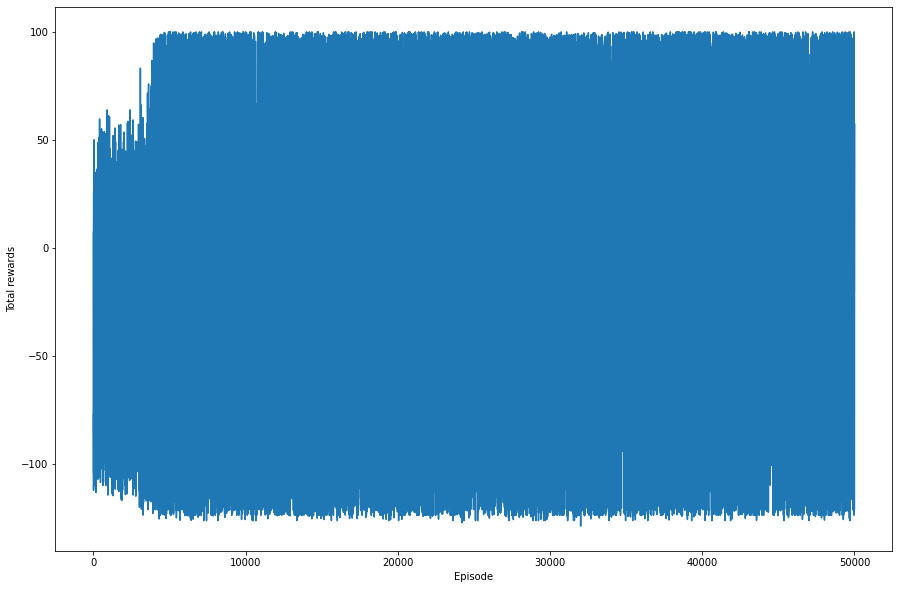

In [13]:
plt.figure(figsize=(15,10))
plt.xlabel("Episode")
plt.ylabel("Total rewards")
plt.plot(reward_list)

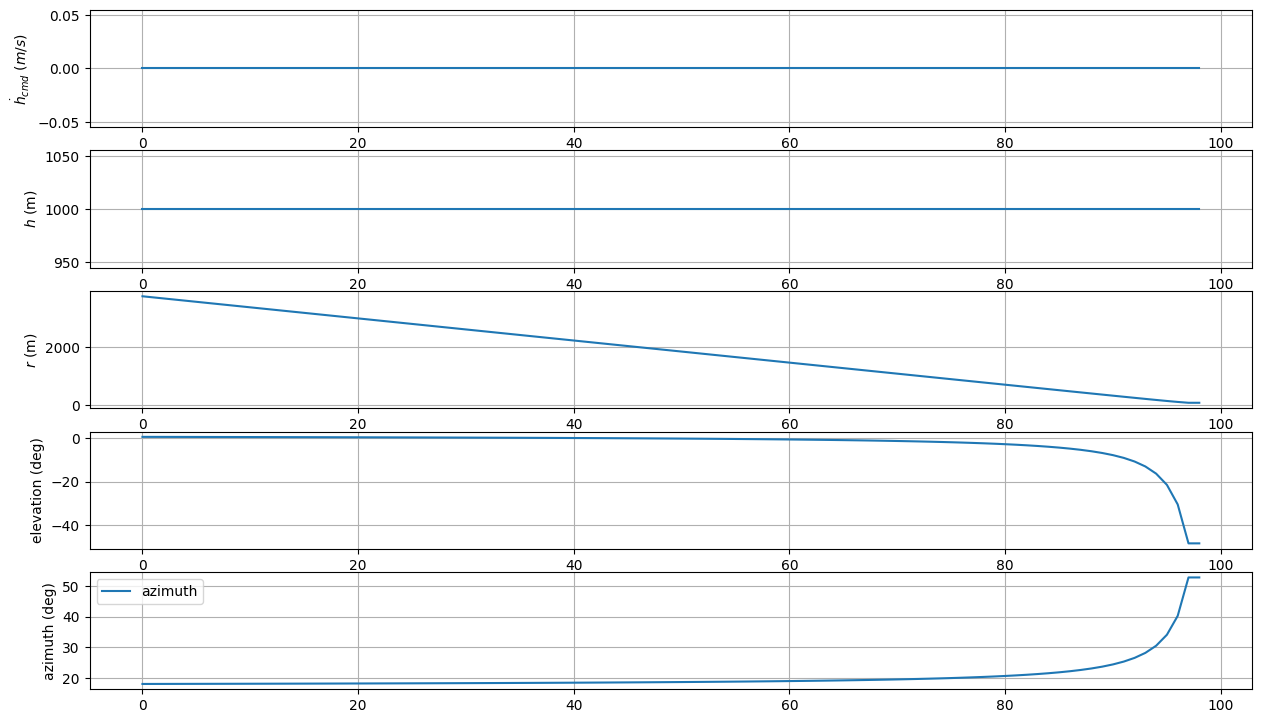

In [14]:
# plots
Deg2Rad = np.pi/180
Rad2Deg = 1/Deg2Rad

plt_res=total_res[9999]


plt.figure(figsize=(15,9), dpi=100)

plt.subplot(511)
plt.plot(plt_res[:,0], label=r'$\dot{h}_{cmd}$')
plt.ylabel(r'$\dot{h}_{cmd}$ ($m/s$)'), plt.grid()

plt.subplot(512)
plt.plot(plt_res[:,10],label=r'$\{h}$')
plt.ylabel(r'$h$ (m)'), plt.grid()

plt.subplot(513)
plt.plot(plt_res[:,1],label=r'$\{r}$')
plt.ylabel(r'$r$ (m)'), plt.grid()

plt.subplot(514)
plt.plot(plt_res[:,2]*Rad2Deg, label='elevation')
plt.ylabel('elevation (deg)'), plt.grid()

plt.subplot(515)
plt.plot(plt_res[:,3]*Rad2Deg, label='azimuth')
plt.ylabel('azimuth (deg)'), plt.grid()

plt.legend()
plt.show()

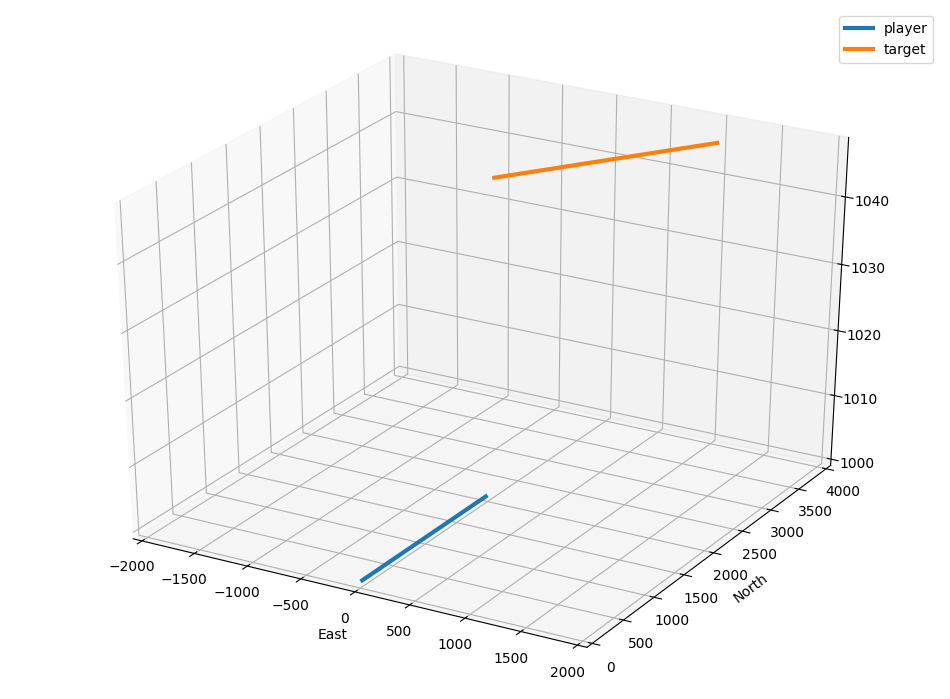

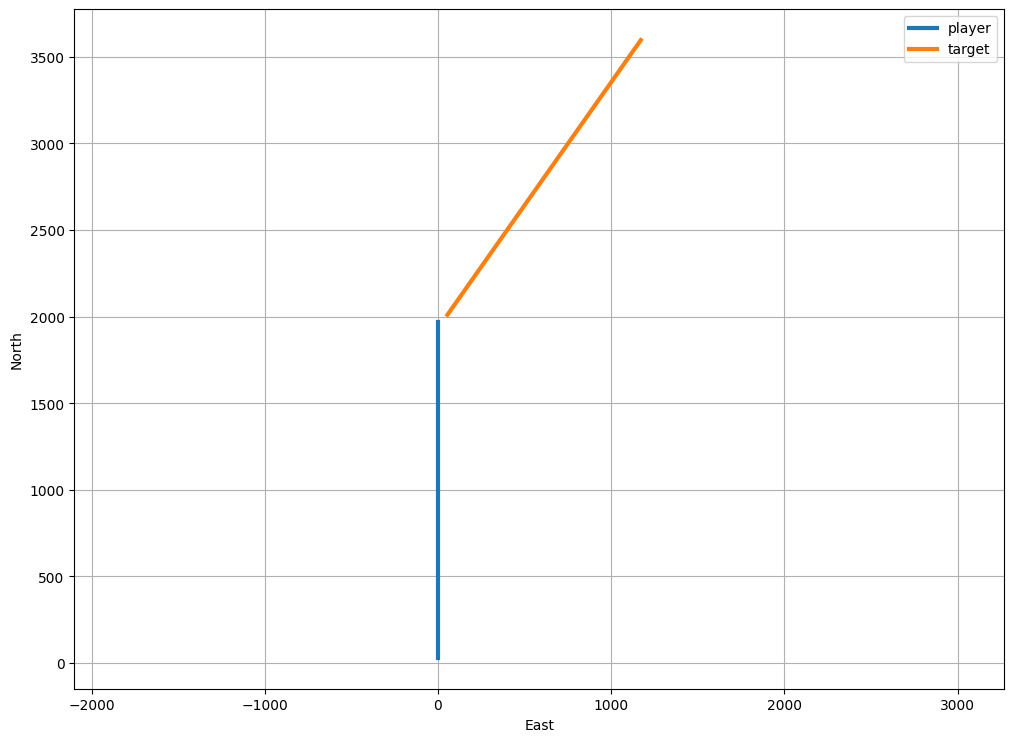

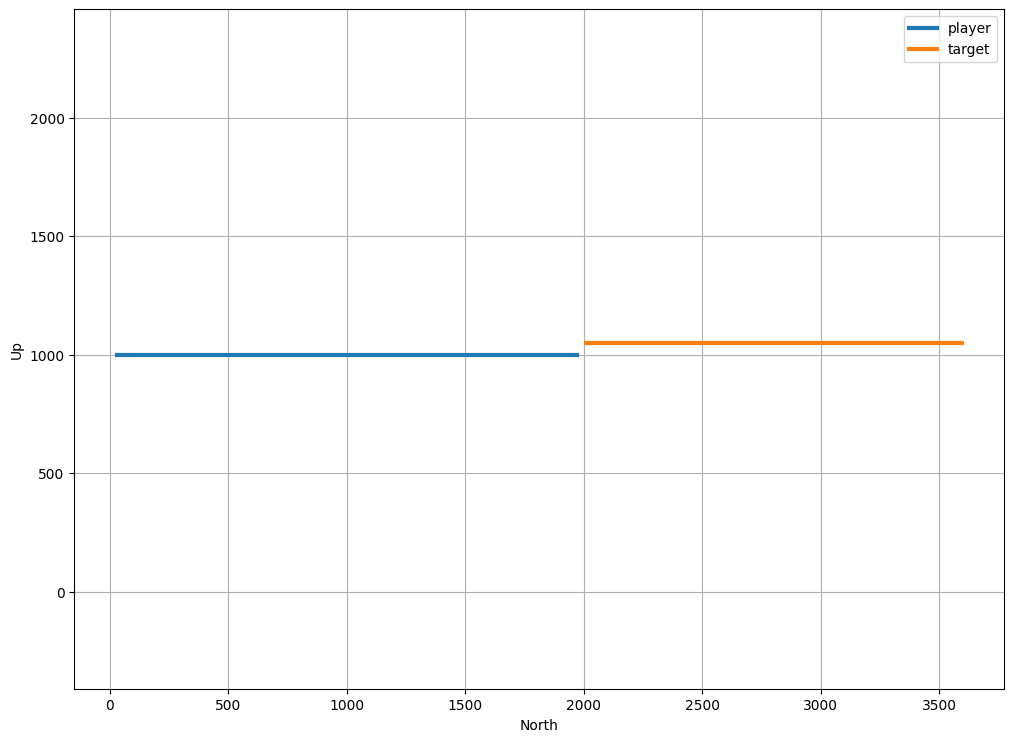

In [15]:
# trajectory plots

from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(12,9), dpi=100)
plt.gca(projection='3d')
plt.plot(plt_res[:,5], plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.xlim(-2000,2000)
plt.ylim(0,4000)
plt.legend()
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,5], plt_res[:,4], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('North')
plt.ylabel('Up')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()